<a href="https://colab.research.google.com/github/mrinalrajl/Adv_Comp_Vision/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Necceesary Packages

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
import time

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.datasets import ImageFolder
from tqdm import tqdm

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Replace '------' with the path such that "ITCS_6010_8010_assignment1" is your working directory
%cd '/content/gdrive/My Drive/ITCS_6010/'

/content/gdrive/My Drive/ITCS_6010


Given Sample Code for Labels in the given data

In [4]:
import albumentations

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_random_seed(0)

# Define the base path for the training data and sort the class directories
base_path = './train/'
directory_paths = sorted(glob.glob(base_path + '*'))
class_names = {i: path.split('/')[-1] for i, path in enumerate(directory_paths)}
print("class_names: %s " % class_names)

def load_dataset(path, img_size, num_per_class=-1, batch_size=16, shuffle=False,
                 augment=False, is_color=False, zero_centered=False, mirror=False,
                 rotate=False, together=False):
    set_random_seed(0)
    data = []
    labels = []
    channel_num = 3 if is_color else 1

    # Load and process images
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % class_name)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id] * len(img_path_class))
        for filename in img_path_class:
            img = cv2.imread(filename, cv2.IMREAD_COLOR if is_color else cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size[1], img_size[0]), interpolation=cv2.INTER_LINEAR)
            if is_color:
                img = np.transpose(img, (2, 0, 1))
            img = img.astype(np.float32) / 255.0 * 2 - 1
            data.append(img)

    # Apply data augmentation
    if augment:
        augments = {
            'mirror': albumentations.HorizontalFlip(p=1),
            'rotate': albumentations.Rotate(limit=30, p=1, border_mode=0)
        }

        augmented_data = []
        for img in data:
            img_aug = img
            if mirror:
                img_aug = augments['mirror'](image=img_aug)['image']
            if rotate:
                img_aug = augments['rotate'](image=img_aug)['image']
            if together:
                img_aug = augments['mirror'](image=img_aug)['image']
                img_aug = augments['rotate'](image=img_aug)['image']
            augmented_data.append(img_aug)
        data.extend(augmented_data)
        labels.extend(labels[:len(augmented_data)])

    # Normalize the data
    if zero_centered:
        mean_color = [0.485, 0.456, 0.406] if is_color else 0.5
        std_color = [0.229, 0.224, 0.225] if is_color else 0.5
        for i, img in enumerate(data):
            if is_color:
                for c in range(3):
                    data[i][c] = (img[c] - mean_color[c]) / std_color[c]
            else:
                data[i] = (img - mean_color) / std_color

    # Shuffle the data
    if shuffle:
        combined = list(zip(data, labels))
        random.shuffle(combined)
        data, labels = zip(*combined)

    # Batch the data
    batch_data = []
    batch_labels = []
    for i in range(0, len(data), batch_size):
        batch_data.append(torch.tensor(data[i:i+batch_size]))
        batch_labels.append(torch.tensor(labels[i:i+batch_size], dtype=torch.int64))

    return zip(batch_data, batch_labels)


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


class_names: {0: 'Bedroom', 1: 'Coast', 2: 'Flower', 3: 'Forest', 4: 'Highway', 5: 'Industrial', 6: 'InsideCity', 7: 'Kitchen', 8: 'LivingRoom', 9: 'Mountain', 10: 'Office', 11: 'OpenCountry', 12: 'Store', 13: 'Street', 14: 'Suburb', 15: 'TallBuilding'} 


Given bash

In [5]:
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 64 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./train/', img_size, batch_size=batch_size, shuffle=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./test/', img_size, num_per_class=50, batch_size=batch_size))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: Bedroom
Loading images from class: Coast
Loading images from class: Flower
Loading images from class: Forest
Loading images from class: Highway
Loading images from class: Industrial
Loading images from class: InsideCity
Loading images from class: Kitchen
Loading images from class: LivingRoom
Loading images from class: Mountain
Loading images from class: Office
Loading images from class: OpenCountry
Loading images from class: Store
Loading images from class: Street
Loading images from class: Suburb
Loading images from class: TallBuilding


<ipython-input-4-45417c440e0d>:83: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  batch_data.append(torch.tensor(data[i:i+batch_size]))


Finish loading 38 minibatches (batch_size=64) of training samples.
Loading images from class: Bedroom
Loading images from class: Coast
Loading images from class: Flower
Loading images from class: Forest
Loading images from class: Highway
Loading images from class: Industrial
Loading images from class: InsideCity
Loading images from class: Kitchen
Loading images from class: LivingRoom
Loading images from class: Mountain
Loading images from class: Office
Loading images from class: OpenCountry
Loading images from class: Store
Loading images from class: Street
Loading images from class: Suburb
Loading images from class: TallBuilding
Finish loading 7 minibatches (batch_size=64) of testing samples.


TallBuilding


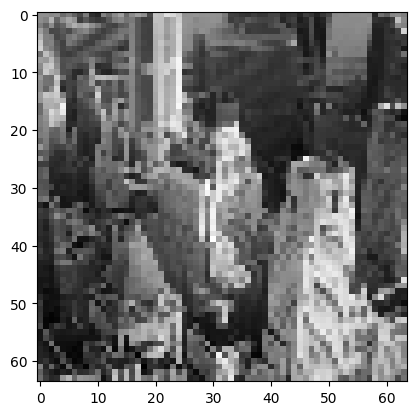

In [6]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    if len(npimg.shape) == 3 and npimg.shape[0] == 3:  # Check if it's a color image in CxHxW format
        npimg = np.transpose(npimg, (1, 2, 0))  # Convert to HxWxC format for matplotlib
    plt.figure()
    if npimg.shape[-1] == 1 or len(npimg.shape) == 2:  # If it's a grayscale image
        plt.imshow(npimg.squeeze(), cmap='gray')  # Use 'squeeze' to remove single-dimensional entries from the shape
    else:
        plt.imshow(npimg)
    plt.show()

# Assuming trainloader_small is properly structured and contains PyTorch tensors
img, label = trainloader_small[0][0][11], trainloader_small[0][1][11]  # Adjusted indexing
label = int(np.array(label))
print(class_names[label])
imshow(img)


## Simple Neural Network

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import time


class TNet(nn.Module):
    def __init__(self):
        super(TNet, self).__init__()
        # Initialize the layers
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),  # Use 3 instead of 1 if you're dealing with RGB images
            nn.ReLU(),
            nn.MaxPool2d(4, stride=4),
        )
        # Calculate the number of features after the last pooling layer
        self.classifier = nn.Sequential(
            nn.Linear(4096, 16),  # Assuming the flattened features are 4096; adjust accordingly
        )

    def forward(self, x):
        # Define the forward pass
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x


def trainModel(net, trainloader, train_option, testloader=None):
    device = torch.device('cuda' if train_option['device'] == 'gpu' and torch.cuda.is_available() else 'cpu')
    net.to(device)
    optimizer = optim.Adam(net.parameters(), lr=train_option['lr'])
    loss_func = nn.CrossEntropyLoss()

    total_iters = 0  # Total iterations for average loss calculation

    for epoch in range(train_option['epoch']):
        net.train()
        for iter, (x, y) in enumerate(trainloader):
            start_time = time.time()
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = net(x)
            loss = loss_func(outputs, y)
            loss.backward()
            optimizer.step()

            total_iters += 1
            elapsed_time = int(time.time() - start_time)
            formatted_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

            if iter % 20 == 0 or iter == 0:  # Adjust logging frequency as needed
                print(f'Epoch: {epoch + 1} | Iter: {iter:5} | Time: {formatted_time} | Train Loss: {loss.item():.4f} | Average Loss: {(loss.item() / total_iters):.4f}')

        if testloader:
            evalModel(net, testloader)

def evalModel(net, testloader):
    device = torch.device('cuda' if next(net.parameters()).is_cuda else 'cpu')
    net.to(device)
    net.eval()
    correct = 0
    total = 0

    start_time = time.time()

    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            outputs = net(x)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    elapsed_time = int(time.time() - start_time)
    formatted_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
    accuracy = correct / total

    print(f'Accuracy: {accuracy:.6f} | Time: {formatted_time}')
    # Data transformations and loading
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(),  # Remove this line if working with RGB
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder('./train', transform=transform)
trainloader_small = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = datasets.ImageFolder('./test', transform=transform)
testloader_small = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Setup and train the model
net = TNet()
train_option = {
    'lr': 0.002,
    'epoch': 20,
    'device': 'gpu'
}

trainModel(net, trainloader_small, train_option, testloader_small)


Epoch: 1 | Iter:     0 | Time: 00:00:01 | Train Loss: 2.8239 | Average Loss: 2.8239
Epoch: 1 | Iter:    20 | Time: 00:00:00 | Train Loss: 2.7019 | Average Loss: 0.1287
Epoch: 1 | Iter:    40 | Time: 00:00:00 | Train Loss: 2.7796 | Average Loss: 0.0678
Epoch: 1 | Iter:    60 | Time: 00:00:00 | Train Loss: 2.5315 | Average Loss: 0.0415
Accuracy: 0.305000 | Time: 00:00:01
Epoch: 2 | Iter:     0 | Time: 00:00:00 | Train Loss: 2.2802 | Average Loss: 0.0300
Epoch: 2 | Iter:    20 | Time: 00:00:00 | Train Loss: 2.3970 | Average Loss: 0.0250
Epoch: 2 | Iter:    40 | Time: 00:00:00 | Train Loss: 1.9456 | Average Loss: 0.0168
Epoch: 2 | Iter:    60 | Time: 00:00:00 | Train Loss: 1.8020 | Average Loss: 0.0133
Accuracy: 0.362500 | Time: 00:00:01
Epoch: 3 | Iter:     0 | Time: 00:00:00 | Train Loss: 1.7573 | Average Loss: 0.0116
Epoch: 3 | Iter:    20 | Time: 00:00:00 | Train Loss: 1.8272 | Average Loss: 0.0107
Epoch: 3 | Iter:    40 | Time: 00:00:00 | Train Loss: 1.5788 | Average Loss: 0.0083
Epoc

# SSL

In [13]:
# Define transformations
ssl_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation([-180, 180]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

classification_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
train_dataset = datasets.ImageFolder('./train/', transform=ssl_transform)
test_dataset = datasets.ImageFolder('./test/', transform=classification_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define model
class SSLModel(nn.Module):
    def __init__(self, num_classes=16):
        super(SSLModel, self).__init__()
        self.backbone = models.resnet18(pretrained=False)
        self.backbone.fc = nn.Identity()
        self.ssl_head = nn.Linear(512, 4)  # 4 rotation classes
        self.cls_head = nn.Linear(512, num_classes)

    def forward(self, x, mode='ssl'):
        features = self.backbone(x)
        if mode == 'ssl':
            return self.ssl_head(features)
        elif mode == 'cls':
            return self.cls_head(features)

model = SSLModel().cuda()

# SSL training
ssl_criterion = nn.CrossEntropyLoss()
ssl_optimizer = optim.Adam(model.parameters(), lr=0.001)

def rotate_batch(x):
    rotations = [0, 90, 180, 270]
    batch = []
    labels = []
    for img in x:
        rot = np.random.choice(rotations)
        batch.append(transforms.functional.rotate(img, int(rot)))
        labels.append(rotations.index(rot))
    return torch.stack(batch), torch.tensor(labels)

print("Starting SSL training...")
for epoch in range(20):  # SSL epochs
    model.train()
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        rotated_data, rot_labels = rotate_batch(data)
        rotated_data, rot_labels = rotated_data.cuda(), rot_labels.cuda()

        ssl_optimizer.zero_grad()
        outputs = model(rotated_data, mode='ssl')
        loss = ssl_criterion(outputs, rot_labels)
        loss.backward()
        ssl_optimizer.step()

        total_loss += loss.item()

    print(f"SSL Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

# Classification fine-tuning
cls_criterion = nn.CrossEntropyLoss()
cls_optimizer = optim.Adam(model.parameters(), lr=0.0001)

print("Starting classification fine-tuning...")
for epoch in range(20):  # Classification epochs
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()

        cls_optimizer.zero_grad()
        outputs = model(data, mode='cls')
        loss = cls_criterion(outputs, target)
        loss.backward()
        cls_optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    train_accuracy = 100. * correct / total
    print(f"Classification Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            outputs = model(data, mode='cls')
            _, predicted = outputs.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    test_accuracy = 100. * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

print("Training completed!")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting SSL training...
SSL Epoch 1, Loss: 1.5203
SSL Epoch 2, Loss: 1.4328
SSL Epoch 3, Loss: 1.4150
SSL Epoch 4, Loss: 1.4103
SSL Epoch 5, Loss: 1.4124
SSL Epoch 6, Loss: 1.4044
SSL Epoch 7, Loss: 1.4026
SSL Epoch 8, Loss: 1.4084
SSL Epoch 9, Loss: 1.3998
SSL Epoch 10, Loss: 1.4031
SSL Epoch 11, Loss: 1.3961
SSL Epoch 12, Loss: 1.3974
SSL Epoch 13, Loss: 1.4033
SSL Epoch 14, Loss: 1.4030
SSL Epoch 15, Loss: 1.3978
SSL Epoch 16, Loss: 1.4018
SSL Epoch 17, Loss: 1.4074
SSL Epoch 18, Loss: 1.3996
SSL Epoch 19, Loss: 1.3995
SSL Epoch 20, Loss: 1.3982
Starting classification fine-tuning...
Classification Epoch 1, Loss: 2.6038, Accuracy: 16.21%
Test Accuracy: 24.75%
Classification Epoch 2, Loss: 2.3014, Accuracy: 26.46%
Test Accuracy: 33.50%
Classification Epoch 3, Loss: 2.1403, Accuracy: 31.08%
Test Accuracy: 37.00%
Classification Epoch 4, Loss: 2.0721, Accuracy: 33.79%
Test Accuracy: 36.50%
Classification Epoch 5, Loss: 2.0246, Accuracy: 34.88%
Test Accuracy: 38.75%
Classification Epoch

# DINO


In [14]:

from tqdm import tqdm

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# DINO model
class DINO(nn.Module):
    def __init__(self, backbone, dim=512, hidden_dim=512, output_dim=65536):
        super(DINO, self).__init__()
        self.backbone = backbone
        self.projector = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, output_dim)
        )
        self.teacher_temp = 0.04
        self.student_temp = 0.1
        self.center = nn.Parameter(torch.zeros(1, output_dim))

    def forward(self, x):
        features = self.backbone(x)
        return self.projector(features)

# Data augmentation
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
train_dataset = ImageFolder('./train/', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

# Initialize model
backbone = models.resnet18(pretrained=False)
backbone.fc = nn.Identity()
model = DINO(backbone).to(device)

# Initialize teacher model
teacher_model = DINO(backbone).to(device)
teacher_model.load_state_dict(model.state_dict())

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.05)

# DINO loss
def dino_loss(student_output, teacher_output, center):
    student_out = student_output / model.student_temp
    student_out = torch.softmax(student_out, dim=-1)
    teacher_out = teacher_output / model.teacher_temp
    teacher_out = torch.softmax(teacher_out, dim=-1)

    loss = torch.sum(-teacher_out * torch.log(student_out), dim=-1).mean()

    # Center loss
    center_loss = torch.sum(student_out.mean(0) * torch.log(student_out.mean(0) + 1e-10))

    return loss + 0.1 * center_loss

# Training loop
def train(epochs):
    model.train()
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        im_q = data.to(device)

        output = model(im_q)

        with torch.no_grad():
            teacher_model.eval()
            target = teacher_model(im_q)
            target = target.detach()

        loss = nn.CrossEntropyLoss()(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')

    return total_loss / len(train_loader)

# Train the model
train(epochs=20)

# Save the model
torch.save(model.state_dict(), 'dino_model.pth')

# Classification model
class ClassificationModel(nn.Module):
    def __init__(self, dino_model, num_classes=16):
        super(ClassificationModel, self).__init__()
        self.backbone = dino_model.backbone
        # Change input features to 512 to match backbone output
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        features = self.backbone(x)
        return self.fc(features)

# Initialize classification model
classification_model = ClassificationModel(model, num_classes=16).to(device)
classification_optimizer = optim.Adam(classification_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Fine-tuning loop
def fine_tune(epochs):
    for epoch in range(epochs):
        classification_model.train()
        total_loss = 0
        correct = 0
        total = 0
        for data, target in tqdm(train_loader):
            data, target = data.to(device), target.to(device)

            output = classification_model(data)
            loss = criterion(output, target)

            classification_optimizer.zero_grad()
            loss.backward()
            classification_optimizer.step()

            total_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

        accuracy = 100. * correct / total
        print(f'Fine-tuning Epoch: {epoch+1}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')

# Fine-tune the model
fine_tune(epochs=20)

# Save the fine-tuned model
torch.save(classification_model.state_dict(), 'dino_finetuned_model.pth')

# Evaluation function
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in tqdm(data_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    return 100. * correct / total

# Evaluate on test set
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolder('./test/', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

test_accuracy = evaluate(classification_model, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Using device: cuda
Epoch: 19, Batch: 0, Loss: -407.0458
Epoch: 19, Batch: 10, Loss: -1452486174383255060480.0000
Epoch: 19, Batch: 20, Loss: -297899244263706009272320.0000
Epoch: 19, Batch: 30, Loss: -489976435305567962005504.0000
Epoch: 19, Batch: 40, Loss: -786425628575651728457728.0000
Epoch: 19, Batch: 50, Loss: -829535237130346723016704.0000
Epoch: 19, Batch: 60, Loss: -1046512686396752072278016.0000
Epoch: 19, Batch: 70, Loss: -1303494782490758101336064.0000


100%|██████████| 75/75 [00:21<00:00,  3.46it/s]


Fine-tuning Epoch: 1, Loss: 2.7718, Accuracy: 10.67%


100%|██████████| 75/75 [00:21<00:00,  3.45it/s]


Fine-tuning Epoch: 2, Loss: 2.5531, Accuracy: 16.54%


100%|██████████| 75/75 [00:20<00:00,  3.66it/s]


Fine-tuning Epoch: 3, Loss: 2.4404, Accuracy: 19.58%


100%|██████████| 75/75 [00:22<00:00,  3.34it/s]


Fine-tuning Epoch: 4, Loss: 2.2435, Accuracy: 26.46%


100%|██████████| 75/75 [00:20<00:00,  3.69it/s]


Fine-tuning Epoch: 5, Loss: 2.0712, Accuracy: 30.29%


100%|██████████| 75/75 [00:21<00:00,  3.51it/s]


Fine-tuning Epoch: 6, Loss: 1.9726, Accuracy: 33.92%


100%|██████████| 75/75 [00:20<00:00,  3.60it/s]


Fine-tuning Epoch: 7, Loss: 1.8432, Accuracy: 36.29%


100%|██████████| 75/75 [00:20<00:00,  3.71it/s]


Fine-tuning Epoch: 8, Loss: 1.7624, Accuracy: 40.00%


100%|██████████| 75/75 [00:22<00:00,  3.38it/s]


Fine-tuning Epoch: 9, Loss: 1.6884, Accuracy: 43.08%


100%|██████████| 75/75 [00:20<00:00,  3.66it/s]


Fine-tuning Epoch: 10, Loss: 1.5979, Accuracy: 47.46%


100%|██████████| 75/75 [00:21<00:00,  3.44it/s]


Fine-tuning Epoch: 11, Loss: 1.5786, Accuracy: 47.54%


100%|██████████| 75/75 [00:20<00:00,  3.64it/s]


Fine-tuning Epoch: 12, Loss: 1.4745, Accuracy: 50.38%


100%|██████████| 75/75 [00:20<00:00,  3.74it/s]


Fine-tuning Epoch: 13, Loss: 1.4126, Accuracy: 52.92%


100%|██████████| 75/75 [00:22<00:00,  3.39it/s]


Fine-tuning Epoch: 14, Loss: 1.3745, Accuracy: 55.21%


100%|██████████| 75/75 [00:20<00:00,  3.70it/s]


Fine-tuning Epoch: 15, Loss: 1.3231, Accuracy: 55.29%


100%|██████████| 75/75 [00:21<00:00,  3.51it/s]


Fine-tuning Epoch: 16, Loss: 1.3221, Accuracy: 55.79%


100%|██████████| 75/75 [00:20<00:00,  3.74it/s]


Fine-tuning Epoch: 17, Loss: 1.2886, Accuracy: 56.88%


100%|██████████| 75/75 [00:20<00:00,  3.74it/s]


Fine-tuning Epoch: 18, Loss: 1.2412, Accuracy: 58.58%


100%|██████████| 75/75 [00:22<00:00,  3.40it/s]


Fine-tuning Epoch: 19, Loss: 1.1853, Accuracy: 60.12%


100%|██████████| 75/75 [00:20<00:00,  3.73it/s]


Fine-tuning Epoch: 20, Loss: 1.2197, Accuracy: 59.04%


100%|██████████| 13/13 [00:03<00:00,  4.19it/s]

Test Accuracy: 71.25%


# MOCO

In [15]:


# MoCo model
class MoCo(nn.Module):
    def __init__(self, dim=128, K=4096, m=0.999, T=0.07):
        super(MoCo, self).__init__()
        self.K = K
        self.m = m
        self.T = T

        # Encoders
        self.encoder_q = models.resnet18(num_classes=dim)
        self.encoder_k = models.resnet18(num_classes=dim)

        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False

        # Queue
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        batch_size = keys.shape[0]
        ptr = int(self.queue_ptr)
        self.queue[:, ptr:ptr + batch_size] = keys.T
        ptr = (ptr + batch_size) % self.K
        self.queue_ptr[0] = ptr

    def forward(self, im_q, im_k):
        q = self.encoder_q(im_q)
        q = nn.functional.normalize(q, dim=1)

        with torch.no_grad():
            self._momentum_update_key_encoder()
            k = self.encoder_k(im_k)
            k = nn.functional.normalize(k, dim=1)

        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])

        logits = torch.cat([l_pos, l_neg], dim=1)
        logits /= self.T

        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(device)

        self._dequeue_and_enqueue(k)

        return logits, labels

# Data augmentation
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
train_dataset = ImageFolder('./train/', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

# Initialize model
model = MoCo().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=1e-4)

# Training loop
def train(epochs):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, _ in tqdm(train_loader):
            img_q = images.to(device)
            img_k = images.to(device)

            output, target = model(img_q, img_k)
            loss = nn.CrossEntropyLoss()(output, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

# Train the model
train(epochs=20)

# Save the model
torch.save(model.state_dict(), 'moco_model.pth')

# Classification model
class ClassificationModel(nn.Module):
    def __init__(self, moco_model, num_classes=16):
        super(ClassificationModel, self).__init__()
        self.features = moco_model.encoder_q
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        return self.fc(x)

# Initialize classification model
classification_model = ClassificationModel(model, num_classes=16).to(device)
classification_optimizer = torch.optim.Adam(classification_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Fine-tuning loop
def fine_tune(epochs):
    for epoch in range(epochs):
        classification_model.train()
        total_loss = 0
        correct = 0
        total = 0
        for data, target in tqdm(train_loader):
            data, target = data.to(device), target.to(device)

            output = classification_model(data)
            loss = criterion(output, target)

            classification_optimizer.zero_grad()
            loss.backward()
            classification_optimizer.step()

            total_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

        accuracy = 100. * correct / total
        print(f'Fine-tuning Epoch: {epoch+1}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')

# Fine-tune the model
fine_tune(epochs=50)

# Save the fine-tuned model
torch.save(classification_model.state_dict(), 'moco_finetuned_model.pth')

# Evaluation function
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in tqdm(data_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    return 100. * correct / total

# Evaluate on test set
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolder('./test/', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

test_accuracy = evaluate(classification_model, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")

100%|██████████| 75/75 [00:22<00:00,  3.36it/s]


Epoch 1, Loss: 5.0248


100%|██████████| 75/75 [00:23<00:00,  3.25it/s]


Epoch 2, Loss: 5.2380


100%|██████████| 75/75 [00:20<00:00,  3.62it/s]


Epoch 3, Loss: 4.6441


100%|██████████| 75/75 [00:21<00:00,  3.49it/s]


Epoch 4, Loss: 4.1178


100%|██████████| 75/75 [00:21<00:00,  3.44it/s]


Epoch 5, Loss: 3.6228


100%|██████████| 75/75 [00:21<00:00,  3.57it/s]


Epoch 6, Loss: 3.1469


100%|██████████| 75/75 [00:22<00:00,  3.33it/s]


Epoch 7, Loss: 2.6949


100%|██████████| 75/75 [00:21<00:00,  3.54it/s]


Epoch 8, Loss: 2.2646


100%|██████████| 75/75 [00:23<00:00,  3.20it/s]


Epoch 9, Loss: 1.9760


100%|██████████| 75/75 [00:21<00:00,  3.46it/s]


Epoch 10, Loss: 1.6843


100%|██████████| 75/75 [00:24<00:00,  3.12it/s]


Epoch 11, Loss: 1.4054


100%|██████████| 75/75 [00:21<00:00,  3.43it/s]


Epoch 12, Loss: 1.1669


100%|██████████| 75/75 [00:23<00:00,  3.18it/s]


Epoch 13, Loss: 1.0056


100%|██████████| 75/75 [00:21<00:00,  3.51it/s]


Epoch 14, Loss: 0.8638


100%|██████████| 75/75 [00:23<00:00,  3.23it/s]


Epoch 15, Loss: 0.7342


100%|██████████| 75/75 [00:21<00:00,  3.56it/s]


Epoch 16, Loss: 0.6306


100%|██████████| 75/75 [00:22<00:00,  3.26it/s]


Epoch 17, Loss: 0.5319


100%|██████████| 75/75 [00:21<00:00,  3.52it/s]


Epoch 18, Loss: 0.4569


100%|██████████| 75/75 [00:23<00:00,  3.22it/s]


Epoch 19, Loss: 0.3816


100%|██████████| 75/75 [00:21<00:00,  3.54it/s]


Epoch 20, Loss: 0.3360


100%|██████████| 75/75 [00:21<00:00,  3.45it/s]


Fine-tuning Epoch: 1, Loss: 2.4096, Accuracy: 22.46%


100%|██████████| 75/75 [00:20<00:00,  3.68it/s]


Fine-tuning Epoch: 2, Loss: 1.9934, Accuracy: 33.21%


100%|██████████| 75/75 [00:22<00:00,  3.38it/s]


Fine-tuning Epoch: 3, Loss: 1.8546, Accuracy: 36.96%


100%|██████████| 75/75 [00:20<00:00,  3.72it/s]


Fine-tuning Epoch: 4, Loss: 1.6998, Accuracy: 43.29%


100%|██████████| 75/75 [00:21<00:00,  3.46it/s]


Fine-tuning Epoch: 5, Loss: 1.5840, Accuracy: 46.00%


100%|██████████| 75/75 [00:20<00:00,  3.70it/s]


Fine-tuning Epoch: 6, Loss: 1.4969, Accuracy: 49.67%


100%|██████████| 75/75 [00:20<00:00,  3.63it/s]


Fine-tuning Epoch: 7, Loss: 1.4560, Accuracy: 50.54%


100%|██████████| 75/75 [00:21<00:00,  3.44it/s]


Fine-tuning Epoch: 8, Loss: 1.4038, Accuracy: 53.00%


100%|██████████| 75/75 [00:20<00:00,  3.71it/s]


Fine-tuning Epoch: 9, Loss: 1.3689, Accuracy: 55.04%


100%|██████████| 75/75 [00:22<00:00,  3.31it/s]


Fine-tuning Epoch: 10, Loss: 1.3260, Accuracy: 54.88%


100%|██████████| 75/75 [00:20<00:00,  3.67it/s]


Fine-tuning Epoch: 11, Loss: 1.2282, Accuracy: 59.38%


100%|██████████| 75/75 [00:21<00:00,  3.43it/s]


Fine-tuning Epoch: 12, Loss: 1.1984, Accuracy: 59.12%


100%|██████████| 75/75 [00:20<00:00,  3.75it/s]


Fine-tuning Epoch: 13, Loss: 1.1579, Accuracy: 61.67%


100%|██████████| 75/75 [00:19<00:00,  3.76it/s]


Fine-tuning Epoch: 14, Loss: 1.1805, Accuracy: 60.21%


100%|██████████| 75/75 [00:21<00:00,  3.46it/s]


Fine-tuning Epoch: 15, Loss: 1.1797, Accuracy: 60.67%


100%|██████████| 75/75 [00:19<00:00,  3.78it/s]


Fine-tuning Epoch: 16, Loss: 1.1083, Accuracy: 63.04%


100%|██████████| 75/75 [00:20<00:00,  3.58it/s]


Fine-tuning Epoch: 17, Loss: 1.0819, Accuracy: 62.67%


100%|██████████| 75/75 [00:20<00:00,  3.65it/s]


Fine-tuning Epoch: 18, Loss: 1.0537, Accuracy: 64.25%


100%|██████████| 75/75 [00:19<00:00,  3.81it/s]


Fine-tuning Epoch: 19, Loss: 1.0972, Accuracy: 64.42%


100%|██████████| 75/75 [00:21<00:00,  3.49it/s]


Fine-tuning Epoch: 20, Loss: 1.0312, Accuracy: 64.54%


100%|██████████| 13/13 [00:02<00:00,  6.27it/s]

Test Accuracy: 71.00%


# MAE


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# MAE model
class MAE(nn.Module):
    def __init__(self, encoder, decoder_dim=512, mask_ratio=0.75):
        super().__init__()
        self.encoder = encoder
        # Get the number of features from the last convolutional layer
        num_features = encoder.layer4[-1].conv2.out_channels
        self.decoder = nn.Sequential(
            nn.Linear(num_features, decoder_dim),
            nn.GELU(),
            nn.Linear(decoder_dim, 3 * 224 * 224)
        )
        self.mask_ratio = mask_ratio

    def forward(self, x):
        B, C, H, W = x.shape
        x_patch = x.view(B, C, H // 16, 16, W // 16, 16).permute(0, 2, 4, 1, 3, 5).reshape(B, -1, 768)

        # Masking
        num_patches = x_patch.shape[1]
        num_mask = int(self.mask_ratio * num_patches)
        mask_idx = random.sample(range(num_patches), num_mask)
        mask = torch.ones(B, num_patches).to(x.device)
        mask[:, mask_idx] = 0

        # Encoding
        x_masked = x_patch * mask.unsqueeze(-1)
        encoded = self.encoder(x_masked.permute(0, 2, 1).reshape(B, C, H, W))

        # Decoding
        decoded = self.decoder(encoded).view(B, 3, H, W)

        return decoded, x

# Data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
train_dataset = ImageFolder('./train/', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

# Initialize model
encoder = models.resnet18(pretrained=False)
num_features = encoder.fc.in_features
encoder.fc = nn.Identity()
model = MAE(encoder).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)

# Training loop
def train_ssl(epochs):
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, _ in tqdm(train_loader):
            images = images.to(device)

            reconstructed, original = model(images)
            loss = criterion(reconstructed, original)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

# Train the model
train_ssl(epochs=20)

# Save the model
torch.save(model.state_dict(), 'mae_model.pth')

# Classification model
class ClassificationModel(nn.Module):
    def __init__(self, mae_model, num_classes=16):
        super().__init__()
        self.features = mae_model.encoder
        self.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.features(x)
        return self.fc(x)

# Initialize classification model
classification_model = ClassificationModel(model, num_classes=16).to(device)
classification_optimizer = torch.optim.Adam(classification_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Fine-tuning loop
def fine_tune(epochs):
    for epoch in range(epochs):
        classification_model.train()
        total_loss = 0
        correct = 0
        total = 0
        for data, target in tqdm(train_loader):
            data, target = data.to(device), target.to(device)

            output = classification_model(data)
            loss = criterion(output, target)

            classification_optimizer.zero_grad()
            loss.backward()
            classification_optimizer.step()

            total_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

        accuracy = 100. * correct / total
        print(f'Fine-tuning Epoch: {epoch+1}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')

# Fine-tune the model
fine_tune(epochs=50)

# Save the fine-tuned model
torch.save(classification_model.state_dict(), 'mae_finetuned_model.pth')

# Evaluation function
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in tqdm(data_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    return 100. * correct / total

# Evaluate on test set
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolder('./test/', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

test_accuracy = evaluate(classification_model, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")

100%|██████████| 75/75 [00:16<00:00,  4.67it/s]


Epoch 1, Loss: 1.0490


100%|██████████| 75/75 [00:15<00:00,  4.76it/s]


Epoch 2, Loss: 0.9040


100%|██████████| 75/75 [00:15<00:00,  4.79it/s]


Epoch 3, Loss: 0.8988


100%|██████████| 75/75 [00:15<00:00,  4.81it/s]


Epoch 4, Loss: 0.8909


100%|██████████| 75/75 [00:15<00:00,  4.70it/s]


Epoch 5, Loss: 0.8836


100%|██████████| 75/75 [00:15<00:00,  4.80it/s]


Epoch 6, Loss: 0.8702


100%|██████████| 75/75 [00:16<00:00,  4.61it/s]


Epoch 7, Loss: 0.8215


100%|██████████| 75/75 [00:16<00:00,  4.63it/s]


Epoch 8, Loss: 0.8109


100%|██████████| 75/75 [00:16<00:00,  4.63it/s]


Epoch 9, Loss: 0.7978


100%|██████████| 75/75 [00:16<00:00,  4.68it/s]


Epoch 10, Loss: 0.7676


100%|██████████| 75/75 [00:15<00:00,  4.74it/s]


Epoch 11, Loss: 0.7552


100%|██████████| 75/75 [00:15<00:00,  4.72it/s]


Epoch 12, Loss: 0.7421


100%|██████████| 75/75 [00:15<00:00,  4.79it/s]


Epoch 13, Loss: 0.7150


100%|██████████| 75/75 [00:15<00:00,  4.72it/s]


Epoch 14, Loss: 0.6953


100%|██████████| 75/75 [00:16<00:00,  4.66it/s]


Epoch 15, Loss: 0.6863


100%|██████████| 75/75 [00:15<00:00,  4.74it/s]


Epoch 16, Loss: 0.6838


100%|██████████| 75/75 [00:15<00:00,  4.75it/s]


Epoch 17, Loss: 0.6821


100%|██████████| 75/75 [00:15<00:00,  4.72it/s]


Epoch 18, Loss: 0.6788


100%|██████████| 75/75 [00:15<00:00,  4.72it/s]


Epoch 19, Loss: 0.6745


100%|██████████| 75/75 [00:16<00:00,  4.68it/s]


Epoch 20, Loss: 0.6750


100%|██████████| 75/75 [00:17<00:00,  4.32it/s]


Fine-tuning Epoch: 1, Loss: 2.1334, Accuracy: 29.88%


100%|██████████| 75/75 [00:15<00:00,  4.88it/s]


Fine-tuning Epoch: 2, Loss: 1.5235, Accuracy: 48.58%


100%|██████████| 75/75 [00:15<00:00,  4.87it/s]


Fine-tuning Epoch: 3, Loss: 1.2741, Accuracy: 56.21%


100%|██████████| 75/75 [00:15<00:00,  4.93it/s]


Fine-tuning Epoch: 4, Loss: 1.0659, Accuracy: 63.75%


100%|██████████| 75/75 [00:15<00:00,  4.83it/s]


Fine-tuning Epoch: 5, Loss: 0.9220, Accuracy: 68.04%


100%|██████████| 75/75 [00:15<00:00,  4.90it/s]


Fine-tuning Epoch: 6, Loss: 0.8199, Accuracy: 72.42%


100%|██████████| 75/75 [00:15<00:00,  4.74it/s]


Fine-tuning Epoch: 7, Loss: 0.7247, Accuracy: 74.38%


100%|██████████| 75/75 [00:15<00:00,  4.85it/s]


Fine-tuning Epoch: 8, Loss: 0.6344, Accuracy: 78.42%


100%|██████████| 75/75 [00:15<00:00,  4.99it/s]


Fine-tuning Epoch: 9, Loss: 0.5603, Accuracy: 79.96%


100%|██████████| 75/75 [00:15<00:00,  4.94it/s]


Fine-tuning Epoch: 10, Loss: 0.5274, Accuracy: 81.21%


100%|██████████| 75/75 [00:15<00:00,  4.85it/s]


Fine-tuning Epoch: 11, Loss: 0.4247, Accuracy: 85.00%


100%|██████████| 75/75 [00:15<00:00,  4.83it/s]


Fine-tuning Epoch: 12, Loss: 0.4273, Accuracy: 84.67%


100%|██████████| 75/75 [00:15<00:00,  4.94it/s]


Fine-tuning Epoch: 13, Loss: 0.3958, Accuracy: 86.58%


100%|██████████| 75/75 [00:15<00:00,  4.87it/s]


Fine-tuning Epoch: 14, Loss: 0.3666, Accuracy: 86.96%


100%|██████████| 75/75 [00:15<00:00,  4.92it/s]


Fine-tuning Epoch: 15, Loss: 0.3212, Accuracy: 88.92%


100%|██████████| 75/75 [00:15<00:00,  4.86it/s]


Fine-tuning Epoch: 16, Loss: 0.2113, Accuracy: 92.88%


100%|██████████| 75/75 [00:15<00:00,  4.83it/s]


Fine-tuning Epoch: 17, Loss: 0.2643, Accuracy: 90.96%


100%|██████████| 75/75 [00:15<00:00,  4.97it/s]


Fine-tuning Epoch: 18, Loss: 0.1938, Accuracy: 94.00%


100%|██████████| 75/75 [00:15<00:00,  5.00it/s]


Fine-tuning Epoch: 19, Loss: 0.1327, Accuracy: 95.58%


100%|██████████| 75/75 [00:15<00:00,  4.94it/s]


Fine-tuning Epoch: 20, Loss: 0.1241, Accuracy: 96.00%


100%|██████████| 75/75 [00:15<00:00,  4.89it/s]


Fine-tuning Epoch: 21, Loss: 0.1672, Accuracy: 93.67%


100%|██████████| 75/75 [00:15<00:00,  4.94it/s]


Fine-tuning Epoch: 22, Loss: 0.1281, Accuracy: 95.67%


100%|██████████| 75/75 [00:15<00:00,  4.91it/s]


Fine-tuning Epoch: 23, Loss: 0.1303, Accuracy: 95.83%


100%|██████████| 75/75 [00:15<00:00,  4.93it/s]


Fine-tuning Epoch: 24, Loss: 0.0970, Accuracy: 97.08%


100%|██████████| 75/75 [00:15<00:00,  4.86it/s]


Fine-tuning Epoch: 25, Loss: 0.0993, Accuracy: 96.92%


100%|██████████| 75/75 [00:15<00:00,  4.94it/s]


Fine-tuning Epoch: 26, Loss: 0.0721, Accuracy: 97.79%


100%|██████████| 75/75 [00:15<00:00,  4.93it/s]


Fine-tuning Epoch: 27, Loss: 0.0943, Accuracy: 96.67%


100%|██████████| 75/75 [00:15<00:00,  4.97it/s]


Fine-tuning Epoch: 28, Loss: 0.1108, Accuracy: 96.00%


100%|██████████| 75/75 [00:15<00:00,  4.92it/s]


Fine-tuning Epoch: 29, Loss: 0.0875, Accuracy: 97.33%


100%|██████████| 75/75 [00:15<00:00,  4.96it/s]


Fine-tuning Epoch: 30, Loss: 0.0463, Accuracy: 98.71%


100%|██████████| 75/75 [00:15<00:00,  4.91it/s]


Fine-tuning Epoch: 31, Loss: 0.0235, Accuracy: 99.46%


100%|██████████| 75/75 [00:15<00:00,  4.87it/s]


Fine-tuning Epoch: 32, Loss: 0.0471, Accuracy: 98.54%


100%|██████████| 75/75 [00:15<00:00,  4.90it/s]


Fine-tuning Epoch: 33, Loss: 0.0767, Accuracy: 97.62%


100%|██████████| 75/75 [00:15<00:00,  4.91it/s]


Fine-tuning Epoch: 34, Loss: 0.1752, Accuracy: 94.38%


100%|██████████| 75/75 [00:15<00:00,  4.91it/s]


Fine-tuning Epoch: 35, Loss: 0.1192, Accuracy: 95.96%


100%|██████████| 75/75 [00:15<00:00,  4.90it/s]


Fine-tuning Epoch: 36, Loss: 0.0943, Accuracy: 96.79%


100%|██████████| 75/75 [00:15<00:00,  4.69it/s]


Fine-tuning Epoch: 37, Loss: 0.0360, Accuracy: 98.96%


100%|██████████| 75/75 [00:15<00:00,  4.81it/s]


Fine-tuning Epoch: 38, Loss: 0.0403, Accuracy: 98.71%


100%|██████████| 75/75 [00:15<00:00,  4.77it/s]


Fine-tuning Epoch: 39, Loss: 0.0556, Accuracy: 98.21%


100%|██████████| 75/75 [00:15<00:00,  4.88it/s]


Fine-tuning Epoch: 40, Loss: 0.0274, Accuracy: 99.25%


100%|██████████| 75/75 [00:15<00:00,  4.79it/s]


Fine-tuning Epoch: 41, Loss: 0.0273, Accuracy: 99.25%


100%|██████████| 75/75 [00:15<00:00,  4.87it/s]


Fine-tuning Epoch: 42, Loss: 0.0355, Accuracy: 98.83%


100%|██████████| 75/75 [00:15<00:00,  4.87it/s]


Fine-tuning Epoch: 43, Loss: 0.0566, Accuracy: 98.04%


100%|██████████| 75/75 [00:15<00:00,  4.97it/s]


Fine-tuning Epoch: 44, Loss: 0.0568, Accuracy: 98.08%


100%|██████████| 75/75 [00:15<00:00,  4.95it/s]


Fine-tuning Epoch: 45, Loss: 0.0216, Accuracy: 99.42%


100%|██████████| 75/75 [00:14<00:00,  5.01it/s]


Fine-tuning Epoch: 46, Loss: 0.0274, Accuracy: 99.08%


100%|██████████| 75/75 [00:15<00:00,  4.90it/s]


Fine-tuning Epoch: 47, Loss: 0.0416, Accuracy: 98.46%


100%|██████████| 75/75 [00:15<00:00,  4.96it/s]


Fine-tuning Epoch: 48, Loss: 0.0594, Accuracy: 98.12%


100%|██████████| 75/75 [00:15<00:00,  4.94it/s]


Fine-tuning Epoch: 49, Loss: 0.0745, Accuracy: 97.67%


100%|██████████| 75/75 [00:15<00:00,  4.99it/s]


Fine-tuning Epoch: 50, Loss: 0.0950, Accuracy: 97.17%


100%|██████████| 13/13 [00:02<00:00,  6.19it/s]

Test Accuracy: 73.75%


# aug data

In [19]:

from torch.utils.data import SubsetRandomSampler
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data augmentation
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


full_dataset = ImageFolder('./train/', transform=transform)

# Number of samples per class
samples_per_class = 120
class_indices = {cls: [] for cls in range(len(full_dataset.classes))}
for idx, (_, label) in enumerate(full_dataset.samples):
    class_indices[label].append(idx)

reduced_indices = []
for cls in class_indices:
    reduced_indices.extend(random.sample(class_indices[cls], min(samples_per_class, len(class_indices[cls]))))

sampler = SubsetRandomSampler(reduced_indices)
train_loader = DataLoader(full_dataset, batch_size=32, sampler=sampler, num_workers=2, pin_memory=True)

# MAE model
class MAE(nn.Module):
    def __init__(self, encoder, num_features, decoder_dim=512, mask_ratio=0.75):
        super().__init__()
        self.encoder = encoder
        self.decoder = nn.Sequential(
            nn.Linear(num_features, decoder_dim),
            nn.GELU(),
            nn.Linear(decoder_dim, 3 * 224 * 224)
        )
        self.mask_ratio = mask_ratio

    def forward(self, x):
        B, C, H, W = x.shape

        # Reshape and permute
        x_patch = x.view(B, C, H // 16, 16, W // 16, 16).permute(0, 2, 4, 1, 3, 5).reshape(B, -1, 16*16*C)

        # Masking
        num_patches = x_patch.shape[1]
        num_mask = int(self.mask_ratio * num_patches)
        mask_idx = random.sample(range(num_patches), num_mask)
        mask = torch.ones(B, num_patches, 1).to(x.device)
        mask[:, mask_idx] = 0

        # Apply mask
        x_masked = x_patch * mask

        # Encoding
        encoded = self.encoder(x_masked.view(B, C, H, W))

        # Decoding
        decoded = self.decoder(encoded)

        return decoded, x

# Initialize model
encoder = models.resnet18(weights=None)
num_features = encoder.fc.in_features
encoder.fc = nn.Identity()
model = MAE(encoder=encoder, num_features=num_features).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)

# Training loop
def train_ssl(epochs):
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for images, _ in tqdm(train_loader):
            images = images.to(device)

            reconstructed, original = model(images)
            loss = criterion(reconstructed, original.view(original.size(0), -1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

# Train the model
train_ssl(epochs=20)

# Save the model after SSL training
torch.save(model.state_dict(), 'mae_model.pth')

# Classification model for fine-tuning
class ClassificationModel(nn.Module):
    def __init__(self, mae_model,num_features ,num_classes=16):
        super().__init__()
        self.features = mae_model.encoder
        self.fc = nn.Linear(num_features , num_classes)

    def forward(self,x):
      x=self.features(x)
      return self.fc(x)

# Initialize classification model for fine-tuning
classification_model = ClassificationModel(mae_model=model,num_features=num_features,num_classes=16).to(device)
classification_optimizer = torch.optim.Adam(classification_model.parameters(), lr=0.001)
criterion_cls = nn.CrossEntropyLoss()

# Fine-tuning loop for classification task
def fine_tune(epochs):
    for epoch in range(epochs):
        classification_model.train()
        total_loss = 0
        correct = 0
        total = 0
        for data,target in tqdm(train_loader):
          data,target=data.to(device),target.to(device)

          output=classification_model(data)
          loss=criterion_cls(output,target)

          classification_optimizer.zero_grad()
          loss.backward()
          classification_optimizer.step()

          total_loss+=loss.item()
          _,predicted=output.max(1)
          total+=target.size(0)
          correct+=predicted.eq(target).sum().item()

          accuracy=100.*correct/total

          print(f'Fine-tuning Epoch: {epoch+1}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')

# Fine-tune the model on classification task
fine_tune(epochs=50)

# Save the fine-tuned model after classification task
torch.save(classification_model.state_dict(), 'mae_finetuned_model.pth')

# Evaluation function to test performance on test set
def evaluate(model,data_loader):
   model.eval()
   correct,total=0.,0.
   with torch.no_grad():
     for data,target in tqdm(data_loader):
       data,target=data.to(device),target.to(device)
       output=model(data)

       _,predicted=output.max(1)
       total+=target.size(0)
       correct+=predicted.eq(target).sum().item()

   return (100.*correct/total)


# Evaluate on test set
# Evaluate on test set
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolder('./test/', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

test_accuracy = evaluate(classification_model, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Using device: cuda


100%|██████████| 60/60 [00:21<00:00,  2.83it/s]


Epoch 1, Loss: 1.1433


100%|██████████| 60/60 [00:18<00:00,  3.31it/s]


Epoch 2, Loss: 0.8440


100%|██████████| 60/60 [00:18<00:00,  3.32it/s]


Epoch 3, Loss: 0.8230


100%|██████████| 60/60 [00:21<00:00,  2.83it/s]


Epoch 4, Loss: 0.7981


100%|██████████| 60/60 [00:18<00:00,  3.23it/s]


Epoch 5, Loss: 0.8245


100%|██████████| 60/60 [00:18<00:00,  3.26it/s]


Epoch 6, Loss: 0.7878


100%|██████████| 60/60 [00:19<00:00,  3.10it/s]


Epoch 7, Loss: 0.7812


100%|██████████| 60/60 [00:19<00:00,  3.05it/s]


Epoch 8, Loss: 0.7550


100%|██████████| 60/60 [00:18<00:00,  3.32it/s]


Epoch 9, Loss: 0.7724


100%|██████████| 60/60 [00:18<00:00,  3.21it/s]


Epoch 10, Loss: 0.7439


100%|██████████| 60/60 [00:20<00:00,  2.98it/s]


Epoch 11, Loss: 0.7473


100%|██████████| 60/60 [00:18<00:00,  3.30it/s]


Epoch 12, Loss: 0.7735


100%|██████████| 60/60 [00:18<00:00,  3.27it/s]


Epoch 13, Loss: 0.7365


100%|██████████| 60/60 [00:18<00:00,  3.26it/s]


Epoch 14, Loss: 0.7574


100%|██████████| 60/60 [00:20<00:00,  2.96it/s]


Epoch 15, Loss: 0.7420


100%|██████████| 60/60 [00:18<00:00,  3.22it/s]


Epoch 16, Loss: 0.7316


100%|██████████| 60/60 [00:18<00:00,  3.20it/s]


Epoch 17, Loss: 0.7243


100%|██████████| 60/60 [00:19<00:00,  3.15it/s]


Epoch 18, Loss: 0.6811


100%|██████████| 60/60 [00:19<00:00,  3.07it/s]


Epoch 19, Loss: 0.7088


100%|██████████| 60/60 [00:18<00:00,  3.29it/s]


Epoch 20, Loss: 0.6969


100%|██████████| 60/60 [00:18<00:00,  3.25it/s]


Epoch 21, Loss: 0.6882


100%|██████████| 60/60 [00:18<00:00,  3.20it/s]


Epoch 22, Loss: 0.6935


100%|██████████| 60/60 [00:20<00:00,  2.99it/s]


Epoch 23, Loss: 0.6934


100%|██████████| 60/60 [00:18<00:00,  3.27it/s]


Epoch 24, Loss: 0.6819


100%|██████████| 60/60 [00:18<00:00,  3.22it/s]


Epoch 25, Loss: 0.6500


100%|██████████| 60/60 [00:18<00:00,  3.19it/s]


Epoch 26, Loss: 0.6622


100%|██████████| 60/60 [00:20<00:00,  2.95it/s]


Epoch 27, Loss: 0.6491


100%|██████████| 60/60 [00:18<00:00,  3.22it/s]


Epoch 28, Loss: 0.6487


100%|██████████| 60/60 [00:19<00:00,  3.13it/s]


Epoch 29, Loss: 0.6126


100%|██████████| 60/60 [00:20<00:00,  2.92it/s]


Epoch 30, Loss: 0.6283


100%|██████████| 60/60 [00:18<00:00,  3.18it/s]


Epoch 31, Loss: 0.6303


100%|██████████| 60/60 [00:22<00:00,  2.64it/s]


Epoch 32, Loss: 0.6214


100%|██████████| 60/60 [00:20<00:00,  2.96it/s]


Epoch 33, Loss: 0.6258


100%|██████████| 60/60 [00:18<00:00,  3.19it/s]


Epoch 34, Loss: 0.6108


100%|██████████| 60/60 [00:18<00:00,  3.18it/s]


Epoch 35, Loss: 0.6209


100%|██████████| 60/60 [00:19<00:00,  3.08it/s]


Epoch 36, Loss: 0.5931


100%|██████████| 60/60 [00:19<00:00,  3.08it/s]


Epoch 37, Loss: 0.6081


100%|██████████| 60/60 [00:18<00:00,  3.19it/s]


Epoch 38, Loss: 0.6058


100%|██████████| 60/60 [00:19<00:00,  3.13it/s]


Epoch 39, Loss: 0.5948


100%|██████████| 60/60 [00:20<00:00,  2.90it/s]


Epoch 40, Loss: 0.6008


100%|██████████| 60/60 [00:18<00:00,  3.17it/s]


Epoch 41, Loss: 0.5962


100%|██████████| 60/60 [00:18<00:00,  3.21it/s]


Epoch 42, Loss: 0.6036


100%|██████████| 60/60 [00:19<00:00,  3.15it/s]


Epoch 43, Loss: 0.5788


100%|██████████| 60/60 [00:19<00:00,  3.09it/s]


Epoch 44, Loss: 0.5752


100%|██████████| 60/60 [00:18<00:00,  3.18it/s]


Epoch 45, Loss: 0.5985


100%|██████████| 60/60 [00:18<00:00,  3.23it/s]


Epoch 46, Loss: 0.5827


100%|██████████| 60/60 [00:21<00:00,  2.86it/s]


Epoch 47, Loss: 0.5854


100%|██████████| 60/60 [00:18<00:00,  3.27it/s]


Epoch 48, Loss: 0.5765


100%|██████████| 60/60 [00:18<00:00,  3.28it/s]


Epoch 49, Loss: 0.5844


100%|██████████| 60/60 [00:19<00:00,  3.11it/s]


Epoch 50, Loss: 0.5917


100%|██████████| 60/60 [00:19<00:00,  3.09it/s]


Epoch 51, Loss: 0.5766


100%|██████████| 60/60 [00:18<00:00,  3.23it/s]


Epoch 52, Loss: 0.5699


100%|██████████| 60/60 [00:20<00:00,  2.91it/s]


Epoch 53, Loss: 0.5671


100%|██████████| 60/60 [00:21<00:00,  2.74it/s]


Epoch 54, Loss: 0.5642


100%|██████████| 60/60 [00:19<00:00,  3.15it/s]


Epoch 55, Loss: 0.5629


100%|██████████| 60/60 [00:21<00:00,  2.82it/s]


Epoch 56, Loss: 0.5772


100%|██████████| 60/60 [00:18<00:00,  3.21it/s]


Epoch 57, Loss: 0.5614


100%|██████████| 60/60 [00:18<00:00,  3.24it/s]


Epoch 58, Loss: 0.5540


100%|██████████| 60/60 [00:21<00:00,  2.75it/s]


Epoch 59, Loss: 0.5738


100%|██████████| 60/60 [00:18<00:00,  3.16it/s]


Epoch 60, Loss: 0.5646


100%|██████████| 60/60 [00:18<00:00,  3.22it/s]


Epoch 61, Loss: 0.5528


100%|██████████| 60/60 [00:19<00:00,  3.07it/s]


Epoch 62, Loss: 0.5529


100%|██████████| 60/60 [00:19<00:00,  3.05it/s]


Epoch 63, Loss: 0.5575


100%|██████████| 60/60 [00:18<00:00,  3.21it/s]


Epoch 64, Loss: 0.5635


100%|██████████| 60/60 [00:19<00:00,  3.13it/s]


Epoch 65, Loss: 0.5473


100%|██████████| 60/60 [00:21<00:00,  2.83it/s]


Epoch 66, Loss: 0.5486


100%|██████████| 60/60 [00:18<00:00,  3.16it/s]


Epoch 67, Loss: 0.5437


100%|██████████| 60/60 [00:19<00:00,  3.14it/s]


Epoch 68, Loss: 0.5448


100%|██████████| 60/60 [00:19<00:00,  3.03it/s]


Epoch 69, Loss: 0.5557


100%|██████████| 60/60 [00:19<00:00,  3.09it/s]


Epoch 70, Loss: 0.5456


100%|██████████| 60/60 [00:18<00:00,  3.21it/s]


Epoch 71, Loss: 0.5460


100%|██████████| 60/60 [00:18<00:00,  3.18it/s]


Epoch 72, Loss: 0.5400


100%|██████████| 60/60 [00:20<00:00,  2.89it/s]


Epoch 73, Loss: 0.5478


100%|██████████| 60/60 [00:18<00:00,  3.23it/s]


Epoch 74, Loss: 0.5284


100%|██████████| 60/60 [00:18<00:00,  3.21it/s]


Epoch 75, Loss: 0.5288


100%|██████████| 60/60 [00:20<00:00,  2.98it/s]


Epoch 76, Loss: 0.5252


100%|██████████| 60/60 [00:19<00:00,  3.12it/s]


Epoch 77, Loss: 0.5390


100%|██████████| 60/60 [00:18<00:00,  3.24it/s]


Epoch 78, Loss: 0.5426


100%|██████████| 60/60 [00:18<00:00,  3.23it/s]


Epoch 79, Loss: 0.5196


100%|██████████| 60/60 [00:20<00:00,  2.98it/s]


Epoch 80, Loss: 0.5281


100%|██████████| 60/60 [00:18<00:00,  3.24it/s]


Epoch 81, Loss: 0.5361


100%|██████████| 60/60 [00:21<00:00,  2.77it/s]


Epoch 82, Loss: 0.5228


100%|██████████| 60/60 [00:22<00:00,  2.72it/s]


Epoch 83, Loss: 0.5404


100%|██████████| 60/60 [00:18<00:00,  3.24it/s]


Epoch 84, Loss: 0.5327


100%|██████████| 60/60 [00:19<00:00,  3.13it/s]


Epoch 85, Loss: 0.5398


100%|██████████| 60/60 [00:19<00:00,  3.04it/s]


Epoch 86, Loss: 0.5184


100%|██████████| 60/60 [00:19<00:00,  3.01it/s]


Epoch 87, Loss: 0.5189


100%|██████████| 60/60 [00:21<00:00,  2.85it/s]


Epoch 88, Loss: 0.5227


100%|██████████| 60/60 [00:20<00:00,  2.97it/s]


Epoch 89, Loss: 0.5203


100%|██████████| 60/60 [00:18<00:00,  3.24it/s]


Epoch 90, Loss: 0.5345


100%|██████████| 60/60 [00:21<00:00,  2.82it/s]


Epoch 91, Loss: 0.5276


100%|██████████| 60/60 [00:22<00:00,  2.63it/s]


Epoch 92, Loss: 0.5223


100%|██████████| 60/60 [00:18<00:00,  3.25it/s]


Epoch 93, Loss: 0.5183


100%|██████████| 60/60 [00:20<00:00,  2.96it/s]


Epoch 94, Loss: 0.5128


100%|██████████| 60/60 [00:20<00:00,  2.98it/s]


Epoch 95, Loss: 0.5221


100%|██████████| 60/60 [00:19<00:00,  3.12it/s]


Epoch 96, Loss: 0.5089


100%|██████████| 60/60 [00:19<00:00,  3.14it/s]


Epoch 97, Loss: 0.5167


100%|██████████| 60/60 [00:20<00:00,  2.92it/s]


Epoch 98, Loss: 0.5184


100%|██████████| 60/60 [00:18<00:00,  3.21it/s]


Epoch 99, Loss: 0.5177


100%|██████████| 60/60 [00:18<00:00,  3.22it/s]


Epoch 100, Loss: 0.5260


  3%|▎         | 2/60 [00:01<00:39,  1.48it/s]

Fine-tuning Epoch: 1, Loss: 0.0520, Accuracy: 3.12%
Fine-tuning Epoch: 1, Loss: 0.1009, Accuracy: 6.25%


  7%|▋         | 4/60 [00:02<00:26,  2.09it/s]

Fine-tuning Epoch: 1, Loss: 0.1547, Accuracy: 4.17%
Fine-tuning Epoch: 1, Loss: 0.1982, Accuracy: 8.59%


 10%|█         | 6/60 [00:03<00:22,  2.41it/s]

Fine-tuning Epoch: 1, Loss: 0.2480, Accuracy: 8.12%
Fine-tuning Epoch: 1, Loss: 0.2944, Accuracy: 8.85%


 13%|█▎        | 8/60 [00:04<00:20,  2.54it/s]

Fine-tuning Epoch: 1, Loss: 0.3433, Accuracy: 8.93%
Fine-tuning Epoch: 1, Loss: 0.3889, Accuracy: 8.59%


 17%|█▋        | 10/60 [00:05<00:19,  2.51it/s]

Fine-tuning Epoch: 1, Loss: 0.4344, Accuracy: 9.38%
Fine-tuning Epoch: 1, Loss: 0.4848, Accuracy: 9.38%


 20%|██        | 12/60 [00:05<00:17,  2.68it/s]

Fine-tuning Epoch: 1, Loss: 0.5305, Accuracy: 9.66%
Fine-tuning Epoch: 1, Loss: 0.5737, Accuracy: 10.42%


 23%|██▎       | 14/60 [00:06<00:14,  3.25it/s]

Fine-tuning Epoch: 1, Loss: 0.6213, Accuracy: 10.58%
Fine-tuning Epoch: 1, Loss: 0.6642, Accuracy: 11.16%


 25%|██▌       | 15/60 [00:06<00:13,  3.34it/s]

Fine-tuning Epoch: 1, Loss: 0.7035, Accuracy: 11.88%


 27%|██▋       | 16/60 [00:06<00:12,  3.48it/s]

Fine-tuning Epoch: 1, Loss: 0.7478, Accuracy: 11.72%


 28%|██▊       | 17/60 [00:07<00:12,  3.46it/s]

Fine-tuning Epoch: 1, Loss: 0.7955, Accuracy: 11.03%


 30%|███       | 18/60 [00:07<00:11,  3.64it/s]

Fine-tuning Epoch: 1, Loss: 0.8372, Accuracy: 11.46%


 32%|███▏      | 19/60 [00:07<00:11,  3.63it/s]

Fine-tuning Epoch: 1, Loss: 0.8846, Accuracy: 11.02%


 33%|███▎      | 20/60 [00:07<00:11,  3.62it/s]

Fine-tuning Epoch: 1, Loss: 0.9319, Accuracy: 11.09%


 35%|███▌      | 21/60 [00:08<00:10,  3.82it/s]

Fine-tuning Epoch: 1, Loss: 0.9759, Accuracy: 11.01%


 37%|███▋      | 22/60 [00:08<00:10,  3.56it/s]

Fine-tuning Epoch: 1, Loss: 1.0199, Accuracy: 11.51%


 38%|███▊      | 23/60 [00:08<00:09,  3.88it/s]

Fine-tuning Epoch: 1, Loss: 1.0611, Accuracy: 11.82%


 40%|████      | 24/60 [00:09<00:10,  3.56it/s]

Fine-tuning Epoch: 1, Loss: 1.1012, Accuracy: 12.37%
Fine-tuning Epoch: 1, Loss: 1.1426, Accuracy: 12.75%


 43%|████▎     | 26/60 [00:09<00:09,  3.69it/s]

Fine-tuning Epoch: 1, Loss: 1.1859, Accuracy: 12.74%


 45%|████▌     | 27/60 [00:10<00:10,  3.08it/s]

Fine-tuning Epoch: 1, Loss: 1.2274, Accuracy: 12.73%


 47%|████▋     | 28/60 [00:10<00:11,  2.88it/s]

Fine-tuning Epoch: 1, Loss: 1.2709, Accuracy: 12.50%


 48%|████▊     | 29/60 [00:10<00:12,  2.43it/s]

Fine-tuning Epoch: 1, Loss: 1.3099, Accuracy: 12.61%


 50%|█████     | 30/60 [00:11<00:11,  2.71it/s]

Fine-tuning Epoch: 1, Loss: 1.3494, Accuracy: 13.12%


 52%|█████▏    | 31/60 [00:11<00:12,  2.35it/s]

Fine-tuning Epoch: 1, Loss: 1.3888, Accuracy: 13.31%


 53%|█████▎    | 32/60 [00:12<00:10,  2.55it/s]

Fine-tuning Epoch: 1, Loss: 1.4318, Accuracy: 13.77%


 55%|█████▌    | 33/60 [00:12<00:10,  2.48it/s]

Fine-tuning Epoch: 1, Loss: 1.4739, Accuracy: 14.30%


 57%|█████▋    | 34/60 [00:12<00:10,  2.55it/s]

Fine-tuning Epoch: 1, Loss: 1.5164, Accuracy: 14.61%


 58%|█████▊    | 35/60 [00:13<00:08,  2.86it/s]

Fine-tuning Epoch: 1, Loss: 1.5604, Accuracy: 14.82%


 60%|██████    | 36/60 [00:13<00:07,  3.07it/s]

Fine-tuning Epoch: 1, Loss: 1.5986, Accuracy: 15.02%


 62%|██████▏   | 37/60 [00:13<00:07,  3.24it/s]

Fine-tuning Epoch: 1, Loss: 1.6346, Accuracy: 15.54%


 63%|██████▎   | 38/60 [00:14<00:06,  3.29it/s]

Fine-tuning Epoch: 1, Loss: 1.6762, Accuracy: 15.62%


 65%|██████▌   | 39/60 [00:14<00:05,  3.57it/s]

Fine-tuning Epoch: 1, Loss: 1.7159, Accuracy: 15.87%


 67%|██████▋   | 40/60 [00:14<00:05,  3.59it/s]

Fine-tuning Epoch: 1, Loss: 1.7542, Accuracy: 16.09%


 70%|███████   | 42/60 [00:14<00:04,  4.08it/s]

Fine-tuning Epoch: 1, Loss: 1.7902, Accuracy: 16.46%
Fine-tuning Epoch: 1, Loss: 1.8280, Accuracy: 16.59%


 73%|███████▎  | 44/60 [00:15<00:04,  3.99it/s]

Fine-tuning Epoch: 1, Loss: 1.8637, Accuracy: 16.93%
Fine-tuning Epoch: 1, Loss: 1.9074, Accuracy: 17.05%


 75%|███████▌  | 45/60 [00:16<00:05,  2.71it/s]

Fine-tuning Epoch: 1, Loss: 1.9509, Accuracy: 17.15%


 77%|███████▋  | 46/60 [00:16<00:04,  3.07it/s]

Fine-tuning Epoch: 1, Loss: 1.9950, Accuracy: 17.19%


 80%|████████  | 48/60 [00:17<00:04,  2.87it/s]

Fine-tuning Epoch: 1, Loss: 2.0361, Accuracy: 17.35%
Fine-tuning Epoch: 1, Loss: 2.0779, Accuracy: 17.51%


 83%|████████▎ | 50/60 [00:18<00:03,  2.78it/s]

Fine-tuning Epoch: 1, Loss: 2.1146, Accuracy: 17.86%
Fine-tuning Epoch: 1, Loss: 2.1540, Accuracy: 17.88%


 87%|████████▋ | 52/60 [00:18<00:02,  2.71it/s]

Fine-tuning Epoch: 1, Loss: 2.1887, Accuracy: 17.95%
Fine-tuning Epoch: 1, Loss: 2.2285, Accuracy: 17.91%


 88%|████████▊ | 53/60 [00:19<00:03,  2.07it/s]

Fine-tuning Epoch: 1, Loss: 2.2681, Accuracy: 18.16%


 90%|█████████ | 54/60 [00:19<00:02,  2.42it/s]

Fine-tuning Epoch: 1, Loss: 2.3085, Accuracy: 18.29%


 93%|█████████▎| 56/60 [00:21<00:02,  1.89it/s]

Fine-tuning Epoch: 1, Loss: 2.3480, Accuracy: 18.41%
Fine-tuning Epoch: 1, Loss: 2.3897, Accuracy: 18.42%


 97%|█████████▋| 58/60 [00:21<00:00,  2.69it/s]

Fine-tuning Epoch: 1, Loss: 2.4283, Accuracy: 18.53%
Fine-tuning Epoch: 1, Loss: 2.4658, Accuracy: 18.97%


100%|██████████| 60/60 [00:22<00:00,  2.67it/s]


Fine-tuning Epoch: 1, Loss: 2.5010, Accuracy: 19.28%
Fine-tuning Epoch: 1, Loss: 2.5412, Accuracy: 19.32%


  3%|▎         | 2/60 [00:00<00:19,  2.94it/s]

Fine-tuning Epoch: 2, Loss: 0.0496, Accuracy: 6.25%
Fine-tuning Epoch: 2, Loss: 0.0942, Accuracy: 10.94%


  7%|▋         | 4/60 [00:01<00:14,  3.84it/s]

Fine-tuning Epoch: 2, Loss: 0.1308, Accuracy: 17.71%
Fine-tuning Epoch: 2, Loss: 0.1745, Accuracy: 18.75%


 10%|█         | 6/60 [00:01<00:13,  4.05it/s]

Fine-tuning Epoch: 2, Loss: 0.2135, Accuracy: 20.62%
Fine-tuning Epoch: 2, Loss: 0.2561, Accuracy: 18.23%


 13%|█▎        | 8/60 [00:02<00:12,  4.30it/s]

Fine-tuning Epoch: 2, Loss: 0.2991, Accuracy: 16.96%
Fine-tuning Epoch: 2, Loss: 0.3382, Accuracy: 17.58%


 17%|█▋        | 10/60 [00:02<00:11,  4.24it/s]

Fine-tuning Epoch: 2, Loss: 0.3792, Accuracy: 17.71%
Fine-tuning Epoch: 2, Loss: 0.4197, Accuracy: 18.44%


 20%|██        | 12/60 [00:03<00:11,  4.06it/s]

Fine-tuning Epoch: 2, Loss: 0.4625, Accuracy: 17.90%
Fine-tuning Epoch: 2, Loss: 0.5046, Accuracy: 17.97%


 23%|██▎       | 14/60 [00:03<00:11,  4.08it/s]

Fine-tuning Epoch: 2, Loss: 0.5470, Accuracy: 18.03%
Fine-tuning Epoch: 2, Loss: 0.5896, Accuracy: 18.08%


 27%|██▋       | 16/60 [00:04<00:10,  4.00it/s]

Fine-tuning Epoch: 2, Loss: 0.6295, Accuracy: 17.71%
Fine-tuning Epoch: 2, Loss: 0.6683, Accuracy: 17.97%


 30%|███       | 18/60 [00:04<00:10,  4.07it/s]

Fine-tuning Epoch: 2, Loss: 0.7045, Accuracy: 18.20%
Fine-tuning Epoch: 2, Loss: 0.7461, Accuracy: 18.40%


 33%|███▎      | 20/60 [00:05<00:09,  4.09it/s]

Fine-tuning Epoch: 2, Loss: 0.7823, Accuracy: 19.08%
Fine-tuning Epoch: 2, Loss: 0.8203, Accuracy: 18.91%


 37%|███▋      | 22/60 [00:06<00:08,  4.25it/s]

Fine-tuning Epoch: 2, Loss: 0.8650, Accuracy: 18.15%
Fine-tuning Epoch: 2, Loss: 0.9044, Accuracy: 18.32%


 40%|████      | 24/60 [00:06<00:08,  4.05it/s]

Fine-tuning Epoch: 2, Loss: 0.9440, Accuracy: 18.21%
Fine-tuning Epoch: 2, Loss: 0.9823, Accuracy: 18.49%


 43%|████▎     | 26/60 [00:07<00:08,  4.04it/s]

Fine-tuning Epoch: 2, Loss: 1.0168, Accuracy: 18.75%
Fine-tuning Epoch: 2, Loss: 1.0566, Accuracy: 18.87%


 47%|████▋     | 28/60 [00:07<00:07,  4.06it/s]

Fine-tuning Epoch: 2, Loss: 1.0946, Accuracy: 18.75%
Fine-tuning Epoch: 2, Loss: 1.1327, Accuracy: 19.08%


 50%|█████     | 30/60 [00:08<00:07,  4.06it/s]

Fine-tuning Epoch: 2, Loss: 1.1695, Accuracy: 19.50%
Fine-tuning Epoch: 2, Loss: 1.2091, Accuracy: 19.38%


 53%|█████▎    | 32/60 [00:09<00:08,  3.24it/s]

Fine-tuning Epoch: 2, Loss: 1.2441, Accuracy: 19.76%
Fine-tuning Epoch: 2, Loss: 1.2769, Accuracy: 20.21%


 57%|█████▋    | 34/60 [00:09<00:08,  2.93it/s]

Fine-tuning Epoch: 2, Loss: 1.3133, Accuracy: 20.64%
Fine-tuning Epoch: 2, Loss: 1.3453, Accuracy: 21.14%


 60%|██████    | 36/60 [00:10<00:08,  2.73it/s]

Fine-tuning Epoch: 2, Loss: 1.3844, Accuracy: 21.34%
Fine-tuning Epoch: 2, Loss: 1.4187, Accuracy: 21.44%


 63%|██████▎   | 38/60 [00:11<00:08,  2.73it/s]

Fine-tuning Epoch: 2, Loss: 1.4576, Accuracy: 21.54%
Fine-tuning Epoch: 2, Loss: 1.4933, Accuracy: 22.04%


 67%|██████▋   | 40/60 [00:12<00:07,  2.77it/s]

Fine-tuning Epoch: 2, Loss: 1.5279, Accuracy: 22.12%
Fine-tuning Epoch: 2, Loss: 1.5669, Accuracy: 22.34%


 70%|███████   | 42/60 [00:13<00:06,  2.67it/s]

Fine-tuning Epoch: 2, Loss: 1.5980, Accuracy: 22.94%
Fine-tuning Epoch: 2, Loss: 1.6303, Accuracy: 23.44%


 73%|███████▎  | 44/60 [00:13<00:05,  3.16it/s]

Fine-tuning Epoch: 2, Loss: 1.6610, Accuracy: 23.84%
Fine-tuning Epoch: 2, Loss: 1.6926, Accuracy: 24.22%


 77%|███████▋  | 46/60 [00:14<00:03,  3.56it/s]

Fine-tuning Epoch: 2, Loss: 1.7310, Accuracy: 24.38%
Fine-tuning Epoch: 2, Loss: 1.7648, Accuracy: 24.39%


 80%|████████  | 48/60 [00:15<00:03,  3.79it/s]

Fine-tuning Epoch: 2, Loss: 1.8012, Accuracy: 24.47%
Fine-tuning Epoch: 2, Loss: 1.8363, Accuracy: 24.41%


 83%|████████▎ | 50/60 [00:15<00:02,  4.07it/s]

Fine-tuning Epoch: 2, Loss: 1.8708, Accuracy: 24.55%
Fine-tuning Epoch: 2, Loss: 1.9053, Accuracy: 24.69%


 87%|████████▋ | 52/60 [00:16<00:01,  4.00it/s]

Fine-tuning Epoch: 2, Loss: 1.9431, Accuracy: 24.69%
Fine-tuning Epoch: 2, Loss: 1.9813, Accuracy: 24.76%


 90%|█████████ | 54/60 [00:16<00:01,  4.16it/s]

Fine-tuning Epoch: 2, Loss: 2.0142, Accuracy: 25.18%
Fine-tuning Epoch: 2, Loss: 2.0507, Accuracy: 25.23%


 93%|█████████▎| 56/60 [00:17<00:00,  4.10it/s]

Fine-tuning Epoch: 2, Loss: 2.0895, Accuracy: 25.34%
Fine-tuning Epoch: 2, Loss: 2.1306, Accuracy: 25.17%


 97%|█████████▋| 58/60 [00:17<00:00,  4.11it/s]

Fine-tuning Epoch: 2, Loss: 2.1705, Accuracy: 25.05%
Fine-tuning Epoch: 2, Loss: 2.2092, Accuracy: 25.05%


100%|██████████| 60/60 [00:18<00:00,  3.31it/s]


Fine-tuning Epoch: 2, Loss: 2.2490, Accuracy: 25.05%
Fine-tuning Epoch: 2, Loss: 2.2873, Accuracy: 25.16%


  3%|▎         | 2/60 [00:00<00:23,  2.49it/s]

Fine-tuning Epoch: 3, Loss: 0.0407, Accuracy: 15.62%
Fine-tuning Epoch: 3, Loss: 0.0728, Accuracy: 26.56%


  7%|▋         | 4/60 [00:01<00:16,  3.50it/s]

Fine-tuning Epoch: 3, Loss: 0.1069, Accuracy: 29.17%
Fine-tuning Epoch: 3, Loss: 0.1431, Accuracy: 29.69%


 10%|█         | 6/60 [00:01<00:14,  3.79it/s]

Fine-tuning Epoch: 3, Loss: 0.1794, Accuracy: 30.00%
Fine-tuning Epoch: 3, Loss: 0.2134, Accuracy: 29.17%


 13%|█▎        | 8/60 [00:02<00:13,  3.99it/s]

Fine-tuning Epoch: 3, Loss: 0.2475, Accuracy: 29.91%
Fine-tuning Epoch: 3, Loss: 0.2807, Accuracy: 28.91%


 17%|█▋        | 10/60 [00:03<00:12,  4.04it/s]

Fine-tuning Epoch: 3, Loss: 0.3174, Accuracy: 29.51%
Fine-tuning Epoch: 3, Loss: 0.3580, Accuracy: 28.75%


 20%|██        | 12/60 [00:03<00:11,  4.02it/s]

Fine-tuning Epoch: 3, Loss: 0.3938, Accuracy: 28.69%
Fine-tuning Epoch: 3, Loss: 0.4325, Accuracy: 29.17%


 23%|██▎       | 14/60 [00:04<00:11,  4.06it/s]

Fine-tuning Epoch: 3, Loss: 0.4693, Accuracy: 29.09%
Fine-tuning Epoch: 3, Loss: 0.5035, Accuracy: 29.02%


 27%|██▋       | 16/60 [00:04<00:10,  4.20it/s]

Fine-tuning Epoch: 3, Loss: 0.5340, Accuracy: 28.96%
Fine-tuning Epoch: 3, Loss: 0.5705, Accuracy: 30.08%


 30%|███       | 18/60 [00:05<00:09,  4.34it/s]

Fine-tuning Epoch: 3, Loss: 0.6078, Accuracy: 29.78%
Fine-tuning Epoch: 3, Loss: 0.6444, Accuracy: 29.86%


 33%|███▎      | 20/60 [00:05<00:11,  3.57it/s]

Fine-tuning Epoch: 3, Loss: 0.6764, Accuracy: 29.77%
Fine-tuning Epoch: 3, Loss: 0.7067, Accuracy: 30.00%


 37%|███▋      | 22/60 [00:06<00:12,  2.96it/s]

Fine-tuning Epoch: 3, Loss: 0.7409, Accuracy: 29.91%
Fine-tuning Epoch: 3, Loss: 0.7702, Accuracy: 30.54%


 40%|████      | 24/60 [00:07<00:13,  2.76it/s]

Fine-tuning Epoch: 3, Loss: 0.8053, Accuracy: 30.84%
Fine-tuning Epoch: 3, Loss: 0.8435, Accuracy: 30.86%


 43%|████▎     | 26/60 [00:08<00:12,  2.80it/s]

Fine-tuning Epoch: 3, Loss: 0.8781, Accuracy: 31.12%
Fine-tuning Epoch: 3, Loss: 0.9123, Accuracy: 31.13%


 47%|████▋     | 28/60 [00:09<00:11,  2.68it/s]

Fine-tuning Epoch: 3, Loss: 0.9437, Accuracy: 31.48%
Fine-tuning Epoch: 3, Loss: 0.9747, Accuracy: 31.70%


 50%|█████     | 30/60 [00:10<00:11,  2.59it/s]

Fine-tuning Epoch: 3, Loss: 1.0133, Accuracy: 31.47%
Fine-tuning Epoch: 3, Loss: 1.0460, Accuracy: 31.46%


 53%|█████▎    | 32/60 [00:10<00:09,  3.03it/s]

Fine-tuning Epoch: 3, Loss: 1.0834, Accuracy: 31.05%
Fine-tuning Epoch: 3, Loss: 1.1227, Accuracy: 30.86%


 57%|█████▋    | 34/60 [00:11<00:07,  3.33it/s]

Fine-tuning Epoch: 3, Loss: 1.1532, Accuracy: 31.25%
Fine-tuning Epoch: 3, Loss: 1.1894, Accuracy: 31.25%


 60%|██████    | 36/60 [00:11<00:06,  3.73it/s]

Fine-tuning Epoch: 3, Loss: 1.2216, Accuracy: 31.70%
Fine-tuning Epoch: 3, Loss: 1.2523, Accuracy: 32.03%


 63%|██████▎   | 38/60 [00:12<00:05,  3.81it/s]

Fine-tuning Epoch: 3, Loss: 1.2891, Accuracy: 31.67%
Fine-tuning Epoch: 3, Loss: 1.3224, Accuracy: 31.58%


 67%|██████▋   | 40/60 [00:13<00:04,  4.02it/s]

Fine-tuning Epoch: 3, Loss: 1.3536, Accuracy: 31.65%
Fine-tuning Epoch: 3, Loss: 1.3822, Accuracy: 32.19%


 70%|███████   | 42/60 [00:13<00:04,  3.93it/s]

Fine-tuning Epoch: 3, Loss: 1.4141, Accuracy: 32.47%
Fine-tuning Epoch: 3, Loss: 1.4440, Accuracy: 32.66%


 73%|███████▎  | 44/60 [00:14<00:03,  4.22it/s]

Fine-tuning Epoch: 3, Loss: 1.4850, Accuracy: 32.34%
Fine-tuning Epoch: 3, Loss: 1.5138, Accuracy: 32.60%


 77%|███████▋  | 46/60 [00:14<00:03,  4.14it/s]

Fine-tuning Epoch: 3, Loss: 1.5452, Accuracy: 32.71%
Fine-tuning Epoch: 3, Loss: 1.5765, Accuracy: 32.74%


 80%|████████  | 48/60 [00:15<00:02,  4.33it/s]

Fine-tuning Epoch: 3, Loss: 1.6065, Accuracy: 33.05%
Fine-tuning Epoch: 3, Loss: 1.6377, Accuracy: 32.94%


 83%|████████▎ | 50/60 [00:15<00:02,  4.07it/s]

Fine-tuning Epoch: 3, Loss: 1.6754, Accuracy: 32.84%
Fine-tuning Epoch: 3, Loss: 1.7102, Accuracy: 32.94%


 87%|████████▋ | 52/60 [00:16<00:01,  4.11it/s]

Fine-tuning Epoch: 3, Loss: 1.7425, Accuracy: 33.09%
Fine-tuning Epoch: 3, Loss: 1.7712, Accuracy: 33.35%


 90%|█████████ | 54/60 [00:16<00:01,  3.97it/s]

Fine-tuning Epoch: 3, Loss: 1.8014, Accuracy: 33.37%
Fine-tuning Epoch: 3, Loss: 1.8366, Accuracy: 33.39%


 93%|█████████▎| 56/60 [00:17<00:00,  4.08it/s]

Fine-tuning Epoch: 3, Loss: 1.8716, Accuracy: 33.41%
Fine-tuning Epoch: 3, Loss: 1.9090, Accuracy: 33.26%


 97%|█████████▋| 58/60 [00:17<00:00,  4.15it/s]

Fine-tuning Epoch: 3, Loss: 1.9425, Accuracy: 33.33%
Fine-tuning Epoch: 3, Loss: 1.9793, Accuracy: 33.08%


100%|██████████| 60/60 [00:18<00:00,  3.26it/s]


Fine-tuning Epoch: 3, Loss: 2.0150, Accuracy: 33.05%
Fine-tuning Epoch: 3, Loss: 2.0470, Accuracy: 33.07%


  3%|▎         | 2/60 [00:00<00:20,  2.81it/s]

Fine-tuning Epoch: 4, Loss: 0.0370, Accuracy: 25.00%
Fine-tuning Epoch: 4, Loss: 0.0817, Accuracy: 21.88%


  7%|▋         | 4/60 [00:01<00:16,  3.41it/s]

Fine-tuning Epoch: 4, Loss: 0.1110, Accuracy: 28.12%
Fine-tuning Epoch: 4, Loss: 0.1431, Accuracy: 30.47%


 10%|█         | 6/60 [00:01<00:14,  3.75it/s]

Fine-tuning Epoch: 4, Loss: 0.1716, Accuracy: 33.12%
Fine-tuning Epoch: 4, Loss: 0.1980, Accuracy: 35.42%


 13%|█▎        | 8/60 [00:03<00:19,  2.62it/s]

Fine-tuning Epoch: 4, Loss: 0.2350, Accuracy: 33.48%
Fine-tuning Epoch: 4, Loss: 0.2619, Accuracy: 33.98%


 17%|█▋        | 10/60 [00:03<00:18,  2.64it/s]

Fine-tuning Epoch: 4, Loss: 0.2943, Accuracy: 34.38%
Fine-tuning Epoch: 4, Loss: 0.3264, Accuracy: 34.06%


 20%|██        | 12/60 [00:04<00:17,  2.69it/s]

Fine-tuning Epoch: 4, Loss: 0.3597, Accuracy: 34.94%
Fine-tuning Epoch: 4, Loss: 0.3898, Accuracy: 35.94%


 23%|██▎       | 14/60 [00:05<00:17,  2.60it/s]

Fine-tuning Epoch: 4, Loss: 0.4250, Accuracy: 34.86%
Fine-tuning Epoch: 4, Loss: 0.4561, Accuracy: 34.60%


 27%|██▋       | 16/60 [00:06<00:17,  2.51it/s]

Fine-tuning Epoch: 4, Loss: 0.4914, Accuracy: 35.00%
Fine-tuning Epoch: 4, Loss: 0.5376, Accuracy: 34.18%


 30%|███       | 18/60 [00:07<00:15,  2.72it/s]

Fine-tuning Epoch: 4, Loss: 0.5718, Accuracy: 34.56%
Fine-tuning Epoch: 4, Loss: 0.6052, Accuracy: 35.07%


 33%|███▎      | 20/60 [00:07<00:12,  3.24it/s]

Fine-tuning Epoch: 4, Loss: 0.6423, Accuracy: 34.87%
Fine-tuning Epoch: 4, Loss: 0.6796, Accuracy: 34.06%


 37%|███▋      | 22/60 [00:08<00:10,  3.50it/s]

Fine-tuning Epoch: 4, Loss: 0.7121, Accuracy: 34.38%
Fine-tuning Epoch: 4, Loss: 0.7437, Accuracy: 34.09%


 40%|████      | 24/60 [00:09<00:09,  3.76it/s]

Fine-tuning Epoch: 4, Loss: 0.7762, Accuracy: 34.10%
Fine-tuning Epoch: 4, Loss: 0.8154, Accuracy: 33.46%


 43%|████▎     | 26/60 [00:09<00:08,  3.91it/s]

Fine-tuning Epoch: 4, Loss: 0.8535, Accuracy: 33.50%
Fine-tuning Epoch: 4, Loss: 0.8881, Accuracy: 33.65%


 47%|████▋     | 28/60 [00:10<00:08,  3.97it/s]

Fine-tuning Epoch: 4, Loss: 0.9178, Accuracy: 34.26%
Fine-tuning Epoch: 4, Loss: 0.9503, Accuracy: 34.15%


 50%|█████     | 30/60 [00:10<00:07,  3.85it/s]

Fine-tuning Epoch: 4, Loss: 0.9800, Accuracy: 34.38%
Fine-tuning Epoch: 4, Loss: 1.0157, Accuracy: 34.38%


 53%|█████▎    | 32/60 [00:11<00:06,  4.03it/s]

Fine-tuning Epoch: 4, Loss: 1.0458, Accuracy: 34.58%
Fine-tuning Epoch: 4, Loss: 1.0831, Accuracy: 34.38%


 57%|█████▋    | 34/60 [00:11<00:06,  4.06it/s]

Fine-tuning Epoch: 4, Loss: 1.1149, Accuracy: 34.66%
Fine-tuning Epoch: 4, Loss: 1.1436, Accuracy: 34.83%


 60%|██████    | 36/60 [00:12<00:05,  4.34it/s]

Fine-tuning Epoch: 4, Loss: 1.1725, Accuracy: 35.00%
Fine-tuning Epoch: 4, Loss: 1.2085, Accuracy: 34.90%


 63%|██████▎   | 38/60 [00:12<00:05,  4.13it/s]

Fine-tuning Epoch: 4, Loss: 1.2388, Accuracy: 35.05%
Fine-tuning Epoch: 4, Loss: 1.2682, Accuracy: 35.53%


 67%|██████▋   | 40/60 [00:13<00:04,  4.16it/s]

Fine-tuning Epoch: 4, Loss: 1.3038, Accuracy: 35.18%
Fine-tuning Epoch: 4, Loss: 1.3362, Accuracy: 35.39%


 70%|███████   | 42/60 [00:13<00:04,  4.17it/s]

Fine-tuning Epoch: 4, Loss: 1.3734, Accuracy: 35.14%
Fine-tuning Epoch: 4, Loss: 1.4070, Accuracy: 34.97%


 73%|███████▎  | 44/60 [00:14<00:03,  4.41it/s]

Fine-tuning Epoch: 4, Loss: 1.4376, Accuracy: 35.03%
Fine-tuning Epoch: 4, Loss: 1.4666, Accuracy: 35.44%


 77%|███████▋  | 46/60 [00:14<00:03,  4.03it/s]

Fine-tuning Epoch: 4, Loss: 1.5010, Accuracy: 35.42%
Fine-tuning Epoch: 4, Loss: 1.5294, Accuracy: 35.53%


 80%|████████  | 48/60 [00:15<00:02,  4.08it/s]

Fine-tuning Epoch: 4, Loss: 1.5618, Accuracy: 35.37%
Fine-tuning Epoch: 4, Loss: 1.5994, Accuracy: 35.09%


 83%|████████▎ | 50/60 [00:16<00:02,  4.09it/s]

Fine-tuning Epoch: 4, Loss: 1.6323, Accuracy: 35.20%
Fine-tuning Epoch: 4, Loss: 1.6627, Accuracy: 35.19%


 87%|████████▋ | 52/60 [00:16<00:01,  4.25it/s]

Fine-tuning Epoch: 4, Loss: 1.6914, Accuracy: 35.36%
Fine-tuning Epoch: 4, Loss: 1.7209, Accuracy: 35.46%


 90%|█████████ | 54/60 [00:17<00:01,  4.26it/s]

Fine-tuning Epoch: 4, Loss: 1.7496, Accuracy: 35.38%
Fine-tuning Epoch: 4, Loss: 1.7812, Accuracy: 35.30%


 93%|█████████▎| 56/60 [00:17<00:01,  3.53it/s]

Fine-tuning Epoch: 4, Loss: 1.8054, Accuracy: 35.74%
Fine-tuning Epoch: 4, Loss: 1.8387, Accuracy: 35.77%


 97%|█████████▋| 58/60 [00:18<00:00,  2.89it/s]

Fine-tuning Epoch: 4, Loss: 1.8691, Accuracy: 35.69%
Fine-tuning Epoch: 4, Loss: 1.9029, Accuracy: 35.61%


100%|██████████| 60/60 [00:19<00:00,  3.35it/s]

Fine-tuning Epoch: 4, Loss: 1.9335, Accuracy: 35.65%
Fine-tuning Epoch: 4, Loss: 1.9696, Accuracy: 35.68%


  3%|▎         | 2/60 [00:01<00:33,  1.76it/s]

Fine-tuning Epoch: 5, Loss: 0.0283, Accuracy: 37.50%
Fine-tuning Epoch: 5, Loss: 0.0586, Accuracy: 40.62%


  7%|▋         | 4/60 [00:02<00:24,  2.26it/s]

Fine-tuning Epoch: 5, Loss: 0.0935, Accuracy: 36.46%
Fine-tuning Epoch: 5, Loss: 0.1228, Accuracy: 36.72%


 10%|█         | 6/60 [00:03<00:21,  2.52it/s]

Fine-tuning Epoch: 5, Loss: 0.1526, Accuracy: 36.88%
Fine-tuning Epoch: 5, Loss: 0.1844, Accuracy: 36.46%


 13%|█▎        | 8/60 [00:03<00:16,  3.23it/s]

Fine-tuning Epoch: 5, Loss: 0.2174, Accuracy: 35.27%
Fine-tuning Epoch: 5, Loss: 0.2457, Accuracy: 35.55%


 17%|█▋        | 10/60 [00:04<00:13,  3.63it/s]

Fine-tuning Epoch: 5, Loss: 0.2763, Accuracy: 34.72%
Fine-tuning Epoch: 5, Loss: 0.3097, Accuracy: 34.69%


 20%|██        | 12/60 [00:04<00:12,  3.94it/s]

Fine-tuning Epoch: 5, Loss: 0.3426, Accuracy: 35.23%
Fine-tuning Epoch: 5, Loss: 0.3714, Accuracy: 35.68%


 23%|██▎       | 14/60 [00:05<00:11,  4.00it/s]

Fine-tuning Epoch: 5, Loss: 0.4017, Accuracy: 36.54%
Fine-tuning Epoch: 5, Loss: 0.4330, Accuracy: 37.05%


 27%|██▋       | 16/60 [00:05<00:11,  3.96it/s]

Fine-tuning Epoch: 5, Loss: 0.4651, Accuracy: 37.08%
Fine-tuning Epoch: 5, Loss: 0.4947, Accuracy: 37.11%


 30%|███       | 18/60 [00:06<00:10,  4.03it/s]

Fine-tuning Epoch: 5, Loss: 0.5251, Accuracy: 37.13%
Fine-tuning Epoch: 5, Loss: 0.5564, Accuracy: 37.33%


 33%|███▎      | 20/60 [00:06<00:10,  3.96it/s]

Fine-tuning Epoch: 5, Loss: 0.5864, Accuracy: 37.34%
Fine-tuning Epoch: 5, Loss: 0.6187, Accuracy: 36.72%


 37%|███▋      | 22/60 [00:07<00:09,  4.04it/s]

Fine-tuning Epoch: 5, Loss: 0.6595, Accuracy: 36.16%
Fine-tuning Epoch: 5, Loss: 0.6916, Accuracy: 36.65%


 40%|████      | 24/60 [00:07<00:09,  3.94it/s]

Fine-tuning Epoch: 5, Loss: 0.7241, Accuracy: 36.28%
Fine-tuning Epoch: 5, Loss: 0.7538, Accuracy: 36.20%


 43%|████▎     | 26/60 [00:08<00:08,  3.97it/s]

Fine-tuning Epoch: 5, Loss: 0.7847, Accuracy: 35.75%
Fine-tuning Epoch: 5, Loss: 0.8141, Accuracy: 35.82%


 47%|████▋     | 28/60 [00:09<00:08,  3.89it/s]

Fine-tuning Epoch: 5, Loss: 0.8541, Accuracy: 35.19%
Fine-tuning Epoch: 5, Loss: 0.8852, Accuracy: 35.38%


 50%|█████     | 30/60 [00:09<00:07,  4.03it/s]

Fine-tuning Epoch: 5, Loss: 0.9271, Accuracy: 35.24%
Fine-tuning Epoch: 5, Loss: 0.9580, Accuracy: 35.42%


 53%|█████▎    | 32/60 [00:10<00:06,  4.01it/s]

Fine-tuning Epoch: 5, Loss: 0.9864, Accuracy: 35.99%
Fine-tuning Epoch: 5, Loss: 1.0172, Accuracy: 36.23%


 57%|█████▋    | 34/60 [00:10<00:06,  3.97it/s]

Fine-tuning Epoch: 5, Loss: 1.0531, Accuracy: 36.08%
Fine-tuning Epoch: 5, Loss: 1.0916, Accuracy: 35.75%


 60%|██████    | 36/60 [00:11<00:05,  4.02it/s]

Fine-tuning Epoch: 5, Loss: 1.1183, Accuracy: 36.16%
Fine-tuning Epoch: 5, Loss: 1.1497, Accuracy: 36.28%


 63%|██████▎   | 38/60 [00:11<00:05,  4.10it/s]

Fine-tuning Epoch: 5, Loss: 1.1777, Accuracy: 36.49%
Fine-tuning Epoch: 5, Loss: 1.2027, Accuracy: 36.84%


 67%|██████▋   | 40/60 [00:12<00:04,  4.22it/s]

Fine-tuning Epoch: 5, Loss: 1.2367, Accuracy: 36.62%
Fine-tuning Epoch: 5, Loss: 1.2665, Accuracy: 36.72%


 70%|███████   | 42/60 [00:12<00:04,  3.93it/s]

Fine-tuning Epoch: 5, Loss: 1.2987, Accuracy: 36.81%
Fine-tuning Epoch: 5, Loss: 1.3345, Accuracy: 36.68%


 73%|███████▎  | 44/60 [00:13<00:05,  3.10it/s]

Fine-tuning Epoch: 5, Loss: 1.3672, Accuracy: 36.56%
Fine-tuning Epoch: 5, Loss: 1.4010, Accuracy: 36.51%


 77%|███████▋  | 46/60 [00:14<00:04,  2.82it/s]

Fine-tuning Epoch: 5, Loss: 1.4277, Accuracy: 36.67%
Fine-tuning Epoch: 5, Loss: 1.4648, Accuracy: 36.62%


 80%|████████  | 48/60 [00:15<00:04,  2.85it/s]

Fine-tuning Epoch: 5, Loss: 1.4972, Accuracy: 36.37%
Fine-tuning Epoch: 5, Loss: 1.5238, Accuracy: 36.65%


 83%|████████▎ | 50/60 [00:16<00:03,  2.93it/s]

Fine-tuning Epoch: 5, Loss: 1.5583, Accuracy: 36.67%
Fine-tuning Epoch: 5, Loss: 1.5908, Accuracy: 36.69%


 87%|████████▋ | 52/60 [00:17<00:03,  2.66it/s]

Fine-tuning Epoch: 5, Loss: 1.6168, Accuracy: 36.95%
Fine-tuning Epoch: 5, Loss: 1.6459, Accuracy: 37.08%


 90%|█████████ | 54/60 [00:17<00:02,  2.74it/s]

Fine-tuning Epoch: 5, Loss: 1.6707, Accuracy: 37.50%
Fine-tuning Epoch: 5, Loss: 1.6976, Accuracy: 37.79%


 93%|█████████▎| 56/60 [00:18<00:01,  3.29it/s]

Fine-tuning Epoch: 5, Loss: 1.7221, Accuracy: 38.24%
Fine-tuning Epoch: 5, Loss: 1.7494, Accuracy: 38.28%


 97%|█████████▋| 58/60 [00:19<00:00,  3.53it/s]

Fine-tuning Epoch: 5, Loss: 1.7769, Accuracy: 38.54%
Fine-tuning Epoch: 5, Loss: 1.8074, Accuracy: 38.58%


100%|██████████| 60/60 [00:19<00:00,  3.06it/s]


Fine-tuning Epoch: 5, Loss: 1.8352, Accuracy: 38.51%
Fine-tuning Epoch: 5, Loss: 1.8632, Accuracy: 38.70%


  3%|▎         | 2/60 [00:00<00:21,  2.73it/s]

Fine-tuning Epoch: 6, Loss: 0.0268, Accuracy: 50.00%
Fine-tuning Epoch: 6, Loss: 0.0524, Accuracy: 45.31%


  7%|▋         | 4/60 [00:01<00:16,  3.48it/s]

Fine-tuning Epoch: 6, Loss: 0.0853, Accuracy: 42.71%
Fine-tuning Epoch: 6, Loss: 0.1154, Accuracy: 40.62%


 10%|█         | 6/60 [00:01<00:14,  3.81it/s]

Fine-tuning Epoch: 6, Loss: 0.1462, Accuracy: 41.88%
Fine-tuning Epoch: 6, Loss: 0.1720, Accuracy: 42.19%


 13%|█▎        | 8/60 [00:02<00:13,  3.85it/s]

Fine-tuning Epoch: 6, Loss: 0.2045, Accuracy: 41.07%
Fine-tuning Epoch: 6, Loss: 0.2318, Accuracy: 41.80%


 17%|█▋        | 10/60 [00:03<00:12,  3.99it/s]

Fine-tuning Epoch: 6, Loss: 0.2652, Accuracy: 41.67%
Fine-tuning Epoch: 6, Loss: 0.3003, Accuracy: 41.25%


 20%|██        | 12/60 [00:03<00:11,  4.02it/s]

Fine-tuning Epoch: 6, Loss: 0.3312, Accuracy: 41.48%
Fine-tuning Epoch: 6, Loss: 0.3569, Accuracy: 42.19%


 23%|██▎       | 14/60 [00:04<00:11,  4.09it/s]

Fine-tuning Epoch: 6, Loss: 0.3821, Accuracy: 42.31%
Fine-tuning Epoch: 6, Loss: 0.4116, Accuracy: 42.63%


 27%|██▋       | 16/60 [00:04<00:10,  4.16it/s]

Fine-tuning Epoch: 6, Loss: 0.4378, Accuracy: 42.92%
Fine-tuning Epoch: 6, Loss: 0.4696, Accuracy: 43.16%


 30%|███       | 18/60 [00:05<00:10,  3.99it/s]

Fine-tuning Epoch: 6, Loss: 0.5045, Accuracy: 42.65%
Fine-tuning Epoch: 6, Loss: 0.5312, Accuracy: 42.88%


 33%|███▎      | 20/60 [00:05<00:09,  4.08it/s]

Fine-tuning Epoch: 6, Loss: 0.5670, Accuracy: 42.27%
Fine-tuning Epoch: 6, Loss: 0.5966, Accuracy: 41.72%


 37%|███▋      | 22/60 [00:06<00:09,  3.97it/s]

Fine-tuning Epoch: 6, Loss: 0.6265, Accuracy: 41.37%
Fine-tuning Epoch: 6, Loss: 0.6518, Accuracy: 41.05%


 40%|████      | 24/60 [00:06<00:08,  4.16it/s]

Fine-tuning Epoch: 6, Loss: 0.6819, Accuracy: 41.17%
Fine-tuning Epoch: 6, Loss: 0.7148, Accuracy: 41.28%


 43%|████▎     | 26/60 [00:07<00:08,  4.22it/s]

Fine-tuning Epoch: 6, Loss: 0.7458, Accuracy: 41.88%
Fine-tuning Epoch: 6, Loss: 0.7728, Accuracy: 42.55%


 47%|████▋     | 28/60 [00:07<00:07,  4.37it/s]

Fine-tuning Epoch: 6, Loss: 0.7993, Accuracy: 42.94%
Fine-tuning Epoch: 6, Loss: 0.8213, Accuracy: 43.53%


 50%|█████     | 30/60 [00:08<00:07,  3.95it/s]

Fine-tuning Epoch: 6, Loss: 0.8472, Accuracy: 43.97%
Fine-tuning Epoch: 6, Loss: 0.8796, Accuracy: 43.75%


 53%|█████▎    | 32/60 [00:09<00:09,  3.01it/s]

Fine-tuning Epoch: 6, Loss: 0.9049, Accuracy: 43.95%
Fine-tuning Epoch: 6, Loss: 0.9325, Accuracy: 43.95%


 57%|█████▋    | 34/60 [00:10<00:08,  2.89it/s]

Fine-tuning Epoch: 6, Loss: 0.9596, Accuracy: 44.13%
Fine-tuning Epoch: 6, Loss: 0.9872, Accuracy: 43.93%


 58%|█████▊    | 35/60 [00:10<00:10,  2.35it/s]

Fine-tuning Epoch: 6, Loss: 1.0128, Accuracy: 44.11%


 60%|██████    | 36/60 [00:11<00:08,  2.75it/s]

Fine-tuning Epoch: 6, Loss: 1.0431, Accuracy: 43.75%


 63%|██████▎   | 38/60 [00:11<00:08,  2.67it/s]

Fine-tuning Epoch: 6, Loss: 1.0650, Accuracy: 44.26%
Fine-tuning Epoch: 6, Loss: 1.1022, Accuracy: 44.16%


 67%|██████▋   | 40/60 [00:12<00:07,  2.61it/s]

Fine-tuning Epoch: 6, Loss: 1.1310, Accuracy: 44.31%
Fine-tuning Epoch: 6, Loss: 1.1637, Accuracy: 44.22%


 70%|███████   | 42/60 [00:13<00:06,  2.70it/s]

Fine-tuning Epoch: 6, Loss: 1.1899, Accuracy: 44.28%
Fine-tuning Epoch: 6, Loss: 1.2186, Accuracy: 44.27%


 73%|███████▎  | 44/60 [00:14<00:04,  3.26it/s]

Fine-tuning Epoch: 6, Loss: 1.2450, Accuracy: 44.40%
Fine-tuning Epoch: 6, Loss: 1.2730, Accuracy: 44.25%


 77%|███████▋  | 46/60 [00:14<00:03,  3.52it/s]

Fine-tuning Epoch: 6, Loss: 1.3110, Accuracy: 43.75%
Fine-tuning Epoch: 6, Loss: 1.3409, Accuracy: 43.75%


 80%|████████  | 48/60 [00:15<00:03,  3.71it/s]

Fine-tuning Epoch: 6, Loss: 1.3682, Accuracy: 43.75%
Fine-tuning Epoch: 6, Loss: 1.3980, Accuracy: 43.62%


 83%|████████▎ | 50/60 [00:15<00:02,  3.88it/s]

Fine-tuning Epoch: 6, Loss: 1.4222, Accuracy: 44.07%
Fine-tuning Epoch: 6, Loss: 1.4566, Accuracy: 43.75%


 87%|████████▋ | 52/60 [00:16<00:01,  4.13it/s]

Fine-tuning Epoch: 6, Loss: 1.4809, Accuracy: 44.00%
Fine-tuning Epoch: 6, Loss: 1.5194, Accuracy: 43.51%


 90%|█████████ | 54/60 [00:16<00:01,  4.01it/s]

Fine-tuning Epoch: 6, Loss: 1.5478, Accuracy: 43.51%
Fine-tuning Epoch: 6, Loss: 1.5727, Accuracy: 43.63%


 93%|█████████▎| 56/60 [00:17<00:00,  4.22it/s]

Fine-tuning Epoch: 6, Loss: 1.5980, Accuracy: 43.58%
Fine-tuning Epoch: 6, Loss: 1.6308, Accuracy: 43.53%


 97%|█████████▋| 58/60 [00:18<00:00,  4.02it/s]

Fine-tuning Epoch: 6, Loss: 1.6616, Accuracy: 43.70%
Fine-tuning Epoch: 6, Loss: 1.6875, Accuracy: 43.80%


100%|██████████| 60/60 [00:18<00:00,  3.23it/s]


Fine-tuning Epoch: 6, Loss: 1.7148, Accuracy: 43.80%
Fine-tuning Epoch: 6, Loss: 1.7479, Accuracy: 43.70%


  3%|▎         | 2/60 [00:00<00:20,  2.83it/s]

Fine-tuning Epoch: 7, Loss: 0.0272, Accuracy: 46.88%
Fine-tuning Epoch: 7, Loss: 0.0605, Accuracy: 37.50%


  7%|▋         | 4/60 [00:01<00:15,  3.64it/s]

Fine-tuning Epoch: 7, Loss: 0.0875, Accuracy: 42.71%
Fine-tuning Epoch: 7, Loss: 0.1147, Accuracy: 42.97%


 10%|█         | 6/60 [00:01<00:13,  4.00it/s]

Fine-tuning Epoch: 7, Loss: 0.1381, Accuracy: 43.75%
Fine-tuning Epoch: 7, Loss: 0.1634, Accuracy: 43.23%


 13%|█▎        | 8/60 [00:02<00:12,  4.04it/s]

Fine-tuning Epoch: 7, Loss: 0.1869, Accuracy: 43.75%
Fine-tuning Epoch: 7, Loss: 0.2166, Accuracy: 42.58%


 17%|█▋        | 10/60 [00:02<00:12,  4.15it/s]

Fine-tuning Epoch: 7, Loss: 0.2462, Accuracy: 42.01%
Fine-tuning Epoch: 7, Loss: 0.2789, Accuracy: 41.88%


 20%|██        | 12/60 [00:03<00:12,  3.97it/s]

Fine-tuning Epoch: 7, Loss: 0.3095, Accuracy: 40.91%
Fine-tuning Epoch: 7, Loss: 0.3358, Accuracy: 41.15%


 23%|██▎       | 14/60 [00:04<00:11,  3.95it/s]

Fine-tuning Epoch: 7, Loss: 0.3631, Accuracy: 41.35%
Fine-tuning Epoch: 7, Loss: 0.3854, Accuracy: 43.75%


 27%|██▋       | 16/60 [00:04<00:11,  3.99it/s]

Fine-tuning Epoch: 7, Loss: 0.4119, Accuracy: 43.96%
Fine-tuning Epoch: 7, Loss: 0.4373, Accuracy: 44.73%


 30%|███       | 18/60 [00:05<00:10,  3.89it/s]

Fine-tuning Epoch: 7, Loss: 0.4644, Accuracy: 44.67%
Fine-tuning Epoch: 7, Loss: 0.4925, Accuracy: 44.79%


 33%|███▎      | 20/60 [00:06<00:13,  3.04it/s]

Fine-tuning Epoch: 7, Loss: 0.5233, Accuracy: 44.41%
Fine-tuning Epoch: 7, Loss: 0.5533, Accuracy: 44.38%


 37%|███▋      | 22/60 [00:06<00:13,  2.79it/s]

Fine-tuning Epoch: 7, Loss: 0.5819, Accuracy: 44.20%
Fine-tuning Epoch: 7, Loss: 0.6033, Accuracy: 44.89%


 40%|████      | 24/60 [00:07<00:12,  2.78it/s]

Fine-tuning Epoch: 7, Loss: 0.6301, Accuracy: 44.43%
Fine-tuning Epoch: 7, Loss: 0.6556, Accuracy: 44.66%


 43%|████▎     | 26/60 [00:08<00:12,  2.71it/s]

Fine-tuning Epoch: 7, Loss: 0.6808, Accuracy: 44.50%
Fine-tuning Epoch: 7, Loss: 0.7148, Accuracy: 44.11%


 47%|████▋     | 28/60 [00:09<00:12,  2.56it/s]

Fine-tuning Epoch: 7, Loss: 0.7435, Accuracy: 44.10%
Fine-tuning Epoch: 7, Loss: 0.7751, Accuracy: 43.53%


 50%|█████     | 30/60 [00:10<00:10,  2.86it/s]

Fine-tuning Epoch: 7, Loss: 0.8029, Accuracy: 43.75%
Fine-tuning Epoch: 7, Loss: 0.8343, Accuracy: 43.23%


 53%|█████▎    | 32/60 [00:10<00:08,  3.40it/s]

Fine-tuning Epoch: 7, Loss: 0.8670, Accuracy: 43.04%
Fine-tuning Epoch: 7, Loss: 0.8919, Accuracy: 43.55%


 57%|█████▋    | 34/60 [00:11<00:07,  3.64it/s]

Fine-tuning Epoch: 7, Loss: 0.9199, Accuracy: 43.47%
Fine-tuning Epoch: 7, Loss: 0.9479, Accuracy: 43.47%


 60%|██████    | 36/60 [00:11<00:06,  3.82it/s]

Fine-tuning Epoch: 7, Loss: 0.9755, Accuracy: 43.93%
Fine-tuning Epoch: 7, Loss: 1.0057, Accuracy: 44.10%


 63%|██████▎   | 38/60 [00:12<00:05,  4.07it/s]

Fine-tuning Epoch: 7, Loss: 1.0341, Accuracy: 44.17%
Fine-tuning Epoch: 7, Loss: 1.0586, Accuracy: 44.57%


 67%|██████▋   | 40/60 [00:12<00:04,  4.01it/s]

Fine-tuning Epoch: 7, Loss: 1.0947, Accuracy: 44.39%
Fine-tuning Epoch: 7, Loss: 1.1185, Accuracy: 44.69%


 70%|███████   | 42/60 [00:13<00:04,  4.09it/s]

Fine-tuning Epoch: 7, Loss: 1.1451, Accuracy: 44.59%
Fine-tuning Epoch: 7, Loss: 1.1755, Accuracy: 44.35%


 73%|███████▎  | 44/60 [00:14<00:03,  4.15it/s]

Fine-tuning Epoch: 7, Loss: 1.2035, Accuracy: 44.33%
Fine-tuning Epoch: 7, Loss: 1.2336, Accuracy: 44.46%


 77%|███████▋  | 46/60 [00:14<00:03,  4.17it/s]

Fine-tuning Epoch: 7, Loss: 1.2649, Accuracy: 44.38%
Fine-tuning Epoch: 7, Loss: 1.2889, Accuracy: 44.63%


 80%|████████  | 48/60 [00:15<00:02,  4.07it/s]

Fine-tuning Epoch: 7, Loss: 1.3196, Accuracy: 44.68%
Fine-tuning Epoch: 7, Loss: 1.3442, Accuracy: 44.86%


 83%|████████▎ | 50/60 [00:15<00:02,  3.94it/s]

Fine-tuning Epoch: 7, Loss: 1.3774, Accuracy: 44.64%
Fine-tuning Epoch: 7, Loss: 1.4024, Accuracy: 44.75%


 87%|████████▋ | 52/60 [00:16<00:02,  3.94it/s]

Fine-tuning Epoch: 7, Loss: 1.4284, Accuracy: 44.91%
Fine-tuning Epoch: 7, Loss: 1.4544, Accuracy: 45.01%


 90%|█████████ | 54/60 [00:16<00:01,  4.18it/s]

Fine-tuning Epoch: 7, Loss: 1.4796, Accuracy: 44.99%
Fine-tuning Epoch: 7, Loss: 1.5000, Accuracy: 45.14%


 93%|█████████▎| 56/60 [00:17<00:00,  4.15it/s]

Fine-tuning Epoch: 7, Loss: 1.5308, Accuracy: 45.17%
Fine-tuning Epoch: 7, Loss: 1.5631, Accuracy: 44.98%


 97%|█████████▋| 58/60 [00:17<00:00,  4.02it/s]

Fine-tuning Epoch: 7, Loss: 1.5916, Accuracy: 45.01%
Fine-tuning Epoch: 7, Loss: 1.6225, Accuracy: 44.94%


100%|██████████| 60/60 [00:18<00:00,  3.27it/s]


Fine-tuning Epoch: 7, Loss: 1.6473, Accuracy: 45.18%
Fine-tuning Epoch: 7, Loss: 1.6687, Accuracy: 45.42%


  3%|▎         | 2/60 [00:00<00:20,  2.90it/s]

Fine-tuning Epoch: 8, Loss: 0.0238, Accuracy: 50.00%
Fine-tuning Epoch: 8, Loss: 0.0540, Accuracy: 50.00%


  7%|▋         | 4/60 [00:01<00:16,  3.45it/s]

Fine-tuning Epoch: 8, Loss: 0.0803, Accuracy: 50.00%
Fine-tuning Epoch: 8, Loss: 0.1022, Accuracy: 50.78%


 10%|█         | 6/60 [00:02<00:16,  3.27it/s]

Fine-tuning Epoch: 8, Loss: 0.1291, Accuracy: 50.62%
Fine-tuning Epoch: 8, Loss: 0.1583, Accuracy: 48.96%


 13%|█▎        | 8/60 [00:03<00:19,  2.70it/s]

Fine-tuning Epoch: 8, Loss: 0.1859, Accuracy: 49.11%
Fine-tuning Epoch: 8, Loss: 0.2085, Accuracy: 50.00%


 17%|█▋        | 10/60 [00:04<00:19,  2.54it/s]

Fine-tuning Epoch: 8, Loss: 0.2344, Accuracy: 49.31%
Fine-tuning Epoch: 8, Loss: 0.2659, Accuracy: 49.06%


 20%|██        | 12/60 [00:04<00:18,  2.59it/s]

Fine-tuning Epoch: 8, Loss: 0.2938, Accuracy: 48.58%
Fine-tuning Epoch: 8, Loss: 0.3225, Accuracy: 47.92%


 23%|██▎       | 14/60 [00:05<00:16,  2.72it/s]

Fine-tuning Epoch: 8, Loss: 0.3526, Accuracy: 47.84%
Fine-tuning Epoch: 8, Loss: 0.3758, Accuracy: 48.44%


 27%|██▋       | 16/60 [00:06<00:15,  2.83it/s]

Fine-tuning Epoch: 8, Loss: 0.4066, Accuracy: 47.71%
Fine-tuning Epoch: 8, Loss: 0.4304, Accuracy: 48.05%


 30%|███       | 18/60 [00:07<00:14,  2.80it/s]

Fine-tuning Epoch: 8, Loss: 0.4579, Accuracy: 47.79%
Fine-tuning Epoch: 8, Loss: 0.4937, Accuracy: 47.05%


 33%|███▎      | 20/60 [00:07<00:12,  3.23it/s]

Fine-tuning Epoch: 8, Loss: 0.5159, Accuracy: 47.70%
Fine-tuning Epoch: 8, Loss: 0.5396, Accuracy: 47.97%


 37%|███▋      | 22/60 [00:08<00:10,  3.56it/s]

Fine-tuning Epoch: 8, Loss: 0.5617, Accuracy: 48.66%
Fine-tuning Epoch: 8, Loss: 0.5902, Accuracy: 48.30%


 40%|████      | 24/60 [00:08<00:09,  3.84it/s]

Fine-tuning Epoch: 8, Loss: 0.6199, Accuracy: 47.69%
Fine-tuning Epoch: 8, Loss: 0.6458, Accuracy: 47.66%


 43%|████▎     | 26/60 [00:09<00:08,  3.88it/s]

Fine-tuning Epoch: 8, Loss: 0.6770, Accuracy: 47.75%
Fine-tuning Epoch: 8, Loss: 0.7018, Accuracy: 48.08%


 47%|████▋     | 28/60 [00:10<00:07,  4.06it/s]

Fine-tuning Epoch: 8, Loss: 0.7316, Accuracy: 47.80%
Fine-tuning Epoch: 8, Loss: 0.7598, Accuracy: 47.32%


 50%|█████     | 30/60 [00:10<00:07,  4.09it/s]

Fine-tuning Epoch: 8, Loss: 0.7852, Accuracy: 47.63%
Fine-tuning Epoch: 8, Loss: 0.8106, Accuracy: 47.50%


 53%|█████▎    | 32/60 [00:11<00:07,  3.92it/s]

Fine-tuning Epoch: 8, Loss: 0.8363, Accuracy: 47.48%
Fine-tuning Epoch: 8, Loss: 0.8610, Accuracy: 47.85%


 57%|█████▋    | 34/60 [00:11<00:06,  4.03it/s]

Fine-tuning Epoch: 8, Loss: 0.8870, Accuracy: 47.92%
Fine-tuning Epoch: 8, Loss: 0.9187, Accuracy: 47.89%


 60%|██████    | 36/60 [00:12<00:05,  4.25it/s]

Fine-tuning Epoch: 8, Loss: 0.9458, Accuracy: 47.77%
Fine-tuning Epoch: 8, Loss: 0.9729, Accuracy: 47.74%


 63%|██████▎   | 38/60 [00:12<00:05,  4.10it/s]

Fine-tuning Epoch: 8, Loss: 0.9965, Accuracy: 47.64%
Fine-tuning Epoch: 8, Loss: 1.0263, Accuracy: 47.45%


 67%|██████▋   | 40/60 [00:13<00:04,  4.13it/s]

Fine-tuning Epoch: 8, Loss: 1.0567, Accuracy: 47.36%
Fine-tuning Epoch: 8, Loss: 1.0804, Accuracy: 47.50%


 70%|███████   | 42/60 [00:13<00:04,  4.00it/s]

Fine-tuning Epoch: 8, Loss: 1.1079, Accuracy: 47.33%
Fine-tuning Epoch: 8, Loss: 1.1354, Accuracy: 47.54%


 73%|███████▎  | 44/60 [00:14<00:04,  3.99it/s]

Fine-tuning Epoch: 8, Loss: 1.1642, Accuracy: 47.31%
Fine-tuning Epoch: 8, Loss: 1.1949, Accuracy: 47.09%


 77%|███████▋  | 46/60 [00:14<00:03,  4.03it/s]

Fine-tuning Epoch: 8, Loss: 1.2240, Accuracy: 47.01%
Fine-tuning Epoch: 8, Loss: 1.2479, Accuracy: 46.88%


 80%|████████  | 48/60 [00:15<00:02,  4.05it/s]

Fine-tuning Epoch: 8, Loss: 1.2731, Accuracy: 47.07%
Fine-tuning Epoch: 8, Loss: 1.3004, Accuracy: 47.07%


 83%|████████▎ | 50/60 [00:16<00:02,  3.93it/s]

Fine-tuning Epoch: 8, Loss: 1.3226, Accuracy: 47.26%
Fine-tuning Epoch: 8, Loss: 1.3458, Accuracy: 47.31%


 87%|████████▋ | 52/60 [00:16<00:02,  3.94it/s]

Fine-tuning Epoch: 8, Loss: 1.3741, Accuracy: 47.24%
Fine-tuning Epoch: 8, Loss: 1.4023, Accuracy: 47.00%


 90%|█████████ | 54/60 [00:17<00:01,  3.60it/s]

Fine-tuning Epoch: 8, Loss: 1.4323, Accuracy: 46.76%
Fine-tuning Epoch: 8, Loss: 1.4611, Accuracy: 46.64%


 93%|█████████▎| 56/60 [00:18<00:01,  3.04it/s]

Fine-tuning Epoch: 8, Loss: 1.4930, Accuracy: 46.36%
Fine-tuning Epoch: 8, Loss: 1.5219, Accuracy: 46.21%


 97%|█████████▋| 58/60 [00:19<00:00,  2.75it/s]

Fine-tuning Epoch: 8, Loss: 1.5478, Accuracy: 46.22%
Fine-tuning Epoch: 8, Loss: 1.5735, Accuracy: 46.12%


100%|██████████| 60/60 [00:19<00:00,  3.50it/s]

Fine-tuning Epoch: 8, Loss: 1.6052, Accuracy: 45.97%
Fine-tuning Epoch: 8, Loss: 1.6331, Accuracy: 46.04%


  3%|▎         | 2/60 [00:01<00:31,  1.82it/s]

Fine-tuning Epoch: 9, Loss: 0.0357, Accuracy: 31.25%
Fine-tuning Epoch: 9, Loss: 0.0632, Accuracy: 34.38%


  7%|▋         | 4/60 [00:02<00:23,  2.34it/s]

Fine-tuning Epoch: 9, Loss: 0.0871, Accuracy: 39.58%
Fine-tuning Epoch: 9, Loss: 0.1110, Accuracy: 40.62%


 10%|█         | 6/60 [00:02<00:19,  2.80it/s]

Fine-tuning Epoch: 9, Loss: 0.1349, Accuracy: 43.75%
Fine-tuning Epoch: 9, Loss: 0.1696, Accuracy: 44.79%


 13%|█▎        | 8/60 [00:03<00:15,  3.28it/s]

Fine-tuning Epoch: 9, Loss: 0.1965, Accuracy: 44.20%
Fine-tuning Epoch: 9, Loss: 0.2185, Accuracy: 46.48%


 17%|█▋        | 10/60 [00:03<00:14,  3.57it/s]

Fine-tuning Epoch: 9, Loss: 0.2473, Accuracy: 46.88%
Fine-tuning Epoch: 9, Loss: 0.2725, Accuracy: 46.88%


 20%|██        | 12/60 [00:04<00:12,  3.81it/s]

Fine-tuning Epoch: 9, Loss: 0.2955, Accuracy: 47.44%
Fine-tuning Epoch: 9, Loss: 0.3230, Accuracy: 46.09%


 23%|██▎       | 14/60 [00:05<00:12,  3.76it/s]

Fine-tuning Epoch: 9, Loss: 0.3485, Accuracy: 47.36%
Fine-tuning Epoch: 9, Loss: 0.3731, Accuracy: 47.10%


 27%|██▋       | 16/60 [00:05<00:11,  3.96it/s]

Fine-tuning Epoch: 9, Loss: 0.3936, Accuracy: 48.12%
Fine-tuning Epoch: 9, Loss: 0.4181, Accuracy: 48.44%


 30%|███       | 18/60 [00:06<00:10,  4.12it/s]

Fine-tuning Epoch: 9, Loss: 0.4496, Accuracy: 47.43%
Fine-tuning Epoch: 9, Loss: 0.4812, Accuracy: 47.05%


 33%|███▎      | 20/60 [00:06<00:09,  4.08it/s]

Fine-tuning Epoch: 9, Loss: 0.5081, Accuracy: 46.88%
Fine-tuning Epoch: 9, Loss: 0.5378, Accuracy: 47.03%


 37%|███▋      | 22/60 [00:07<00:09,  4.03it/s]

Fine-tuning Epoch: 9, Loss: 0.5629, Accuracy: 47.02%
Fine-tuning Epoch: 9, Loss: 0.5859, Accuracy: 47.16%


 40%|████      | 24/60 [00:07<00:08,  4.22it/s]

Fine-tuning Epoch: 9, Loss: 0.6067, Accuracy: 47.69%
Fine-tuning Epoch: 9, Loss: 0.6301, Accuracy: 48.18%


 43%|████▎     | 26/60 [00:08<00:08,  4.25it/s]

Fine-tuning Epoch: 9, Loss: 0.6558, Accuracy: 48.12%
Fine-tuning Epoch: 9, Loss: 0.6806, Accuracy: 48.20%


 47%|████▋     | 28/60 [00:08<00:07,  4.09it/s]

Fine-tuning Epoch: 9, Loss: 0.7110, Accuracy: 47.92%
Fine-tuning Epoch: 9, Loss: 0.7412, Accuracy: 47.32%


 50%|█████     | 30/60 [00:09<00:07,  4.21it/s]

Fine-tuning Epoch: 9, Loss: 0.7668, Accuracy: 47.31%
Fine-tuning Epoch: 9, Loss: 0.7924, Accuracy: 47.50%


 53%|█████▎    | 32/60 [00:09<00:06,  4.35it/s]

Fine-tuning Epoch: 9, Loss: 0.8211, Accuracy: 47.28%
Fine-tuning Epoch: 9, Loss: 0.8459, Accuracy: 47.56%


 57%|█████▋    | 34/60 [00:10<00:06,  4.07it/s]

Fine-tuning Epoch: 9, Loss: 0.8750, Accuracy: 47.63%
Fine-tuning Epoch: 9, Loss: 0.9051, Accuracy: 47.43%


 60%|██████    | 36/60 [00:10<00:05,  4.16it/s]

Fine-tuning Epoch: 9, Loss: 0.9328, Accuracy: 47.59%
Fine-tuning Epoch: 9, Loss: 0.9566, Accuracy: 48.00%


 63%|██████▎   | 38/60 [00:11<00:05,  4.14it/s]

Fine-tuning Epoch: 9, Loss: 0.9859, Accuracy: 47.80%
Fine-tuning Epoch: 9, Loss: 1.0101, Accuracy: 47.94%


 67%|██████▋   | 40/60 [00:12<00:04,  4.13it/s]

Fine-tuning Epoch: 9, Loss: 1.0363, Accuracy: 47.92%
Fine-tuning Epoch: 9, Loss: 1.0664, Accuracy: 47.81%


 70%|███████   | 42/60 [00:12<00:04,  4.07it/s]

Fine-tuning Epoch: 9, Loss: 1.0965, Accuracy: 47.71%
Fine-tuning Epoch: 9, Loss: 1.1269, Accuracy: 47.47%


 73%|███████▎  | 44/60 [00:13<00:05,  3.07it/s]

Fine-tuning Epoch: 9, Loss: 1.1483, Accuracy: 47.75%
Fine-tuning Epoch: 9, Loss: 1.1773, Accuracy: 47.66%


 77%|███████▋  | 46/60 [00:14<00:04,  3.07it/s]

Fine-tuning Epoch: 9, Loss: 1.1976, Accuracy: 47.92%
Fine-tuning Epoch: 9, Loss: 1.2223, Accuracy: 48.17%


 80%|████████  | 48/60 [00:15<00:04,  2.90it/s]

Fine-tuning Epoch: 9, Loss: 1.2476, Accuracy: 48.14%
Fine-tuning Epoch: 9, Loss: 1.2788, Accuracy: 47.85%


 83%|████████▎ | 50/60 [00:15<00:03,  2.73it/s]

Fine-tuning Epoch: 9, Loss: 1.3007, Accuracy: 48.02%
Fine-tuning Epoch: 9, Loss: 1.3231, Accuracy: 48.31%


 87%|████████▋ | 52/60 [00:16<00:02,  2.97it/s]

Fine-tuning Epoch: 9, Loss: 1.3462, Accuracy: 48.47%
Fine-tuning Epoch: 9, Loss: 1.3700, Accuracy: 48.62%


 90%|█████████ | 54/60 [00:17<00:02,  2.71it/s]

Fine-tuning Epoch: 9, Loss: 1.3970, Accuracy: 48.53%
Fine-tuning Epoch: 9, Loss: 1.4173, Accuracy: 48.67%


 93%|█████████▎| 56/60 [00:18<00:01,  3.02it/s]

Fine-tuning Epoch: 9, Loss: 1.4430, Accuracy: 48.69%
Fine-tuning Epoch: 9, Loss: 1.4656, Accuracy: 48.83%


 97%|█████████▋| 58/60 [00:18<00:00,  3.56it/s]

Fine-tuning Epoch: 9, Loss: 1.4982, Accuracy: 48.68%
Fine-tuning Epoch: 9, Loss: 1.5294, Accuracy: 48.44%


100%|██████████| 60/60 [00:19<00:00,  3.12it/s]


Fine-tuning Epoch: 9, Loss: 1.5579, Accuracy: 48.31%
Fine-tuning Epoch: 9, Loss: 1.5866, Accuracy: 48.07%


  3%|▎         | 2/60 [00:00<00:21,  2.76it/s]

Fine-tuning Epoch: 10, Loss: 0.0264, Accuracy: 50.00%
Fine-tuning Epoch: 10, Loss: 0.0503, Accuracy: 54.69%


  7%|▋         | 4/60 [00:01<00:16,  3.49it/s]

Fine-tuning Epoch: 10, Loss: 0.0759, Accuracy: 52.08%
Fine-tuning Epoch: 10, Loss: 0.1059, Accuracy: 52.34%


 10%|█         | 6/60 [00:01<00:14,  3.85it/s]

Fine-tuning Epoch: 10, Loss: 0.1362, Accuracy: 51.88%
Fine-tuning Epoch: 10, Loss: 0.1597, Accuracy: 51.04%


 13%|█▎        | 8/60 [00:02<00:13,  3.97it/s]

Fine-tuning Epoch: 10, Loss: 0.1880, Accuracy: 49.55%
Fine-tuning Epoch: 10, Loss: 0.2202, Accuracy: 46.88%


 17%|█▋        | 10/60 [00:02<00:12,  4.05it/s]

Fine-tuning Epoch: 10, Loss: 0.2455, Accuracy: 47.57%
Fine-tuning Epoch: 10, Loss: 0.2709, Accuracy: 46.56%


 20%|██        | 12/60 [00:03<00:12,  3.97it/s]

Fine-tuning Epoch: 10, Loss: 0.3024, Accuracy: 45.45%
Fine-tuning Epoch: 10, Loss: 0.3359, Accuracy: 44.53%


 23%|██▎       | 14/60 [00:04<00:11,  3.91it/s]

Fine-tuning Epoch: 10, Loss: 0.3607, Accuracy: 44.95%
Fine-tuning Epoch: 10, Loss: 0.3910, Accuracy: 45.09%


 27%|██▋       | 16/60 [00:04<00:12,  3.59it/s]

Fine-tuning Epoch: 10, Loss: 0.4151, Accuracy: 46.25%
Fine-tuning Epoch: 10, Loss: 0.4351, Accuracy: 47.07%


 30%|███       | 18/60 [00:05<00:10,  3.91it/s]

Fine-tuning Epoch: 10, Loss: 0.4564, Accuracy: 47.79%
Fine-tuning Epoch: 10, Loss: 0.4784, Accuracy: 47.40%


 33%|███▎      | 20/60 [00:05<00:10,  4.00it/s]

Fine-tuning Epoch: 10, Loss: 0.4999, Accuracy: 47.70%
Fine-tuning Epoch: 10, Loss: 0.5250, Accuracy: 47.97%


 37%|███▋      | 22/60 [00:06<00:09,  4.05it/s]

Fine-tuning Epoch: 10, Loss: 0.5493, Accuracy: 48.07%
Fine-tuning Epoch: 10, Loss: 0.5812, Accuracy: 47.73%


 40%|████      | 24/60 [00:06<00:09,  3.98it/s]

Fine-tuning Epoch: 10, Loss: 0.6028, Accuracy: 48.51%
Fine-tuning Epoch: 10, Loss: 0.6303, Accuracy: 48.57%


 43%|████▎     | 26/60 [00:07<00:08,  3.88it/s]

Fine-tuning Epoch: 10, Loss: 0.6517, Accuracy: 48.75%
Fine-tuning Epoch: 10, Loss: 0.6768, Accuracy: 48.68%


 47%|████▋     | 28/60 [00:08<00:07,  4.09it/s]

Fine-tuning Epoch: 10, Loss: 0.7034, Accuracy: 48.50%
Fine-tuning Epoch: 10, Loss: 0.7257, Accuracy: 48.44%


 50%|█████     | 30/60 [00:08<00:07,  3.89it/s]

Fine-tuning Epoch: 10, Loss: 0.7520, Accuracy: 48.28%
Fine-tuning Epoch: 10, Loss: 0.7721, Accuracy: 48.65%


 53%|█████▎    | 32/60 [00:09<00:08,  3.14it/s]

Fine-tuning Epoch: 10, Loss: 0.7976, Accuracy: 48.69%
Fine-tuning Epoch: 10, Loss: 0.8261, Accuracy: 48.44%


 57%|█████▋    | 34/60 [00:10<00:09,  2.77it/s]

Fine-tuning Epoch: 10, Loss: 0.8525, Accuracy: 48.39%
Fine-tuning Epoch: 10, Loss: 0.8748, Accuracy: 48.35%


 60%|██████    | 36/60 [00:11<00:08,  2.75it/s]

Fine-tuning Epoch: 10, Loss: 0.8966, Accuracy: 48.75%
Fine-tuning Epoch: 10, Loss: 0.9218, Accuracy: 48.96%


 63%|██████▎   | 38/60 [00:12<00:08,  2.57it/s]

Fine-tuning Epoch: 10, Loss: 0.9450, Accuracy: 48.73%
Fine-tuning Epoch: 10, Loss: 0.9800, Accuracy: 48.52%


 67%|██████▋   | 40/60 [00:13<00:07,  2.68it/s]

Fine-tuning Epoch: 10, Loss: 1.0017, Accuracy: 48.72%
Fine-tuning Epoch: 10, Loss: 1.0297, Accuracy: 48.59%


 70%|███████   | 42/60 [00:13<00:06,  2.68it/s]

Fine-tuning Epoch: 10, Loss: 1.0520, Accuracy: 48.78%
Fine-tuning Epoch: 10, Loss: 1.0739, Accuracy: 49.11%


 73%|███████▎  | 44/60 [00:14<00:04,  3.33it/s]

Fine-tuning Epoch: 10, Loss: 1.1014, Accuracy: 49.13%
Fine-tuning Epoch: 10, Loss: 1.1279, Accuracy: 49.08%


 77%|███████▋  | 46/60 [00:14<00:03,  3.70it/s]

Fine-tuning Epoch: 10, Loss: 1.1576, Accuracy: 48.89%
Fine-tuning Epoch: 10, Loss: 1.1829, Accuracy: 48.91%


 80%|████████  | 48/60 [00:15<00:03,  3.83it/s]

Fine-tuning Epoch: 10, Loss: 1.2046, Accuracy: 49.14%
Fine-tuning Epoch: 10, Loss: 1.2241, Accuracy: 49.28%


 83%|████████▎ | 50/60 [00:16<00:02,  3.82it/s]

Fine-tuning Epoch: 10, Loss: 1.2497, Accuracy: 49.43%
Fine-tuning Epoch: 10, Loss: 1.2766, Accuracy: 49.31%


 87%|████████▋ | 52/60 [00:16<00:01,  4.13it/s]

Fine-tuning Epoch: 10, Loss: 1.3054, Accuracy: 49.14%
Fine-tuning Epoch: 10, Loss: 1.3301, Accuracy: 49.04%


 90%|█████████ | 54/60 [00:17<00:01,  4.13it/s]

Fine-tuning Epoch: 10, Loss: 1.3635, Accuracy: 48.76%
Fine-tuning Epoch: 10, Loss: 1.3869, Accuracy: 48.90%


 93%|█████████▎| 56/60 [00:17<00:00,  4.10it/s]

Fine-tuning Epoch: 10, Loss: 1.4068, Accuracy: 49.20%
Fine-tuning Epoch: 10, Loss: 1.4285, Accuracy: 49.33%


 97%|█████████▋| 58/60 [00:18<00:00,  4.32it/s]

Fine-tuning Epoch: 10, Loss: 1.4549, Accuracy: 49.23%
Fine-tuning Epoch: 10, Loss: 1.4773, Accuracy: 49.52%


100%|██████████| 60/60 [00:18<00:00,  3.22it/s]


Fine-tuning Epoch: 10, Loss: 1.5001, Accuracy: 49.74%
Fine-tuning Epoch: 10, Loss: 1.5285, Accuracy: 49.58%


  3%|▎         | 2/60 [00:00<00:20,  2.84it/s]

Fine-tuning Epoch: 11, Loss: 0.0320, Accuracy: 40.62%
Fine-tuning Epoch: 11, Loss: 0.0455, Accuracy: 59.38%


  7%|▋         | 4/60 [00:01<00:16,  3.48it/s]

Fine-tuning Epoch: 11, Loss: 0.0721, Accuracy: 55.21%
Fine-tuning Epoch: 11, Loss: 0.0954, Accuracy: 56.25%


 10%|█         | 6/60 [00:01<00:13,  3.88it/s]

Fine-tuning Epoch: 11, Loss: 0.1186, Accuracy: 57.50%
Fine-tuning Epoch: 11, Loss: 0.1449, Accuracy: 57.29%


 13%|█▎        | 8/60 [00:02<00:12,  4.03it/s]

Fine-tuning Epoch: 11, Loss: 0.1704, Accuracy: 54.46%
Fine-tuning Epoch: 11, Loss: 0.1992, Accuracy: 54.69%


 17%|█▋        | 10/60 [00:02<00:12,  3.97it/s]

Fine-tuning Epoch: 11, Loss: 0.2347, Accuracy: 52.78%
Fine-tuning Epoch: 11, Loss: 0.2633, Accuracy: 52.50%


 20%|██        | 12/60 [00:03<00:12,  3.96it/s]

Fine-tuning Epoch: 11, Loss: 0.2900, Accuracy: 52.56%
Fine-tuning Epoch: 11, Loss: 0.3099, Accuracy: 53.12%


 23%|██▎       | 14/60 [00:04<00:11,  4.02it/s]

Fine-tuning Epoch: 11, Loss: 0.3421, Accuracy: 51.44%
Fine-tuning Epoch: 11, Loss: 0.3626, Accuracy: 51.79%


 27%|██▋       | 16/60 [00:04<00:11,  3.99it/s]

Fine-tuning Epoch: 11, Loss: 0.3912, Accuracy: 51.46%
Fine-tuning Epoch: 11, Loss: 0.4183, Accuracy: 50.59%


 30%|███       | 18/60 [00:05<00:11,  3.82it/s]

Fine-tuning Epoch: 11, Loss: 0.4479, Accuracy: 49.82%
Fine-tuning Epoch: 11, Loss: 0.4685, Accuracy: 50.69%


 33%|███▎      | 20/60 [00:06<00:14,  2.84it/s]

Fine-tuning Epoch: 11, Loss: 0.4934, Accuracy: 50.33%
Fine-tuning Epoch: 11, Loss: 0.5216, Accuracy: 50.16%


 37%|███▋      | 22/60 [00:07<00:14,  2.70it/s]

Fine-tuning Epoch: 11, Loss: 0.5463, Accuracy: 50.00%
Fine-tuning Epoch: 11, Loss: 0.5758, Accuracy: 49.86%


 40%|████      | 24/60 [00:08<00:13,  2.62it/s]

Fine-tuning Epoch: 11, Loss: 0.5992, Accuracy: 49.59%
Fine-tuning Epoch: 11, Loss: 0.6226, Accuracy: 49.09%


 43%|████▎     | 26/60 [00:08<00:12,  2.63it/s]

Fine-tuning Epoch: 11, Loss: 0.6415, Accuracy: 49.88%
Fine-tuning Epoch: 11, Loss: 0.6763, Accuracy: 49.52%


 47%|████▋     | 28/60 [00:09<00:12,  2.66it/s]

Fine-tuning Epoch: 11, Loss: 0.7090, Accuracy: 49.31%
Fine-tuning Epoch: 11, Loss: 0.7351, Accuracy: 48.77%


 50%|█████     | 30/60 [00:10<00:10,  2.89it/s]

Fine-tuning Epoch: 11, Loss: 0.7574, Accuracy: 49.03%
Fine-tuning Epoch: 11, Loss: 0.7835, Accuracy: 49.27%


 53%|█████▎    | 32/60 [00:10<00:08,  3.44it/s]

Fine-tuning Epoch: 11, Loss: 0.8075, Accuracy: 49.40%
Fine-tuning Epoch: 11, Loss: 0.8343, Accuracy: 49.22%


 57%|█████▋    | 34/60 [00:11<00:06,  3.85it/s]

Fine-tuning Epoch: 11, Loss: 0.8603, Accuracy: 48.96%
Fine-tuning Epoch: 11, Loss: 0.8859, Accuracy: 48.99%


 60%|██████    | 36/60 [00:12<00:05,  4.02it/s]

Fine-tuning Epoch: 11, Loss: 0.9160, Accuracy: 48.48%
Fine-tuning Epoch: 11, Loss: 0.9385, Accuracy: 48.87%


 63%|██████▎   | 38/60 [00:12<00:05,  4.09it/s]

Fine-tuning Epoch: 11, Loss: 0.9659, Accuracy: 48.82%
Fine-tuning Epoch: 11, Loss: 0.9894, Accuracy: 49.18%


 67%|██████▋   | 40/60 [00:13<00:04,  4.15it/s]

Fine-tuning Epoch: 11, Loss: 1.0141, Accuracy: 49.36%
Fine-tuning Epoch: 11, Loss: 1.0363, Accuracy: 49.45%


 70%|███████   | 42/60 [00:13<00:04,  4.28it/s]

Fine-tuning Epoch: 11, Loss: 1.0564, Accuracy: 49.77%
Fine-tuning Epoch: 11, Loss: 1.0795, Accuracy: 49.93%


 73%|███████▎  | 44/60 [00:14<00:03,  4.04it/s]

Fine-tuning Epoch: 11, Loss: 1.1048, Accuracy: 50.07%
Fine-tuning Epoch: 11, Loss: 1.1352, Accuracy: 49.86%


 77%|███████▋  | 46/60 [00:14<00:03,  4.05it/s]

Fine-tuning Epoch: 11, Loss: 1.1581, Accuracy: 49.72%
Fine-tuning Epoch: 11, Loss: 1.1808, Accuracy: 49.73%


 80%|████████  | 48/60 [00:15<00:02,  4.11it/s]

Fine-tuning Epoch: 11, Loss: 1.1988, Accuracy: 50.00%
Fine-tuning Epoch: 11, Loss: 1.2223, Accuracy: 50.00%


 83%|████████▎ | 50/60 [00:15<00:02,  4.22it/s]

Fine-tuning Epoch: 11, Loss: 1.2461, Accuracy: 50.00%
Fine-tuning Epoch: 11, Loss: 1.2729, Accuracy: 49.88%


 87%|████████▋ | 52/60 [00:16<00:02,  3.96it/s]

Fine-tuning Epoch: 11, Loss: 1.2980, Accuracy: 50.12%
Fine-tuning Epoch: 11, Loss: 1.3193, Accuracy: 50.30%


 90%|█████████ | 54/60 [00:16<00:01,  4.05it/s]

Fine-tuning Epoch: 11, Loss: 1.3390, Accuracy: 50.41%
Fine-tuning Epoch: 11, Loss: 1.3616, Accuracy: 50.46%


 93%|█████████▎| 56/60 [00:17<00:00,  4.22it/s]

Fine-tuning Epoch: 11, Loss: 1.3880, Accuracy: 50.45%
Fine-tuning Epoch: 11, Loss: 1.4141, Accuracy: 50.56%


 97%|█████████▋| 58/60 [00:17<00:00,  3.98it/s]

Fine-tuning Epoch: 11, Loss: 1.4337, Accuracy: 50.71%
Fine-tuning Epoch: 11, Loss: 1.4528, Accuracy: 50.75%


100%|██████████| 60/60 [00:18<00:00,  3.24it/s]


Fine-tuning Epoch: 11, Loss: 1.4797, Accuracy: 50.79%
Fine-tuning Epoch: 11, Loss: 1.5078, Accuracy: 50.73%


  3%|▎         | 2/60 [00:00<00:20,  2.85it/s]

Fine-tuning Epoch: 12, Loss: 0.0232, Accuracy: 53.12%
Fine-tuning Epoch: 12, Loss: 0.0427, Accuracy: 57.81%


  7%|▋         | 4/60 [00:01<00:16,  3.45it/s]

Fine-tuning Epoch: 12, Loss: 0.0666, Accuracy: 55.21%
Fine-tuning Epoch: 12, Loss: 0.0905, Accuracy: 56.25%


 10%|█         | 6/60 [00:02<00:16,  3.36it/s]

Fine-tuning Epoch: 12, Loss: 0.1202, Accuracy: 53.12%
Fine-tuning Epoch: 12, Loss: 0.1447, Accuracy: 52.60%


 13%|█▎        | 8/60 [00:03<00:19,  2.69it/s]

Fine-tuning Epoch: 12, Loss: 0.1718, Accuracy: 50.89%
Fine-tuning Epoch: 12, Loss: 0.1933, Accuracy: 51.95%


 17%|█▋        | 10/60 [00:04<00:19,  2.54it/s]

Fine-tuning Epoch: 12, Loss: 0.2198, Accuracy: 50.69%
Fine-tuning Epoch: 12, Loss: 0.2381, Accuracy: 52.19%


 20%|██        | 12/60 [00:04<00:18,  2.54it/s]

Fine-tuning Epoch: 12, Loss: 0.2602, Accuracy: 52.27%
Fine-tuning Epoch: 12, Loss: 0.2850, Accuracy: 51.82%


 23%|██▎       | 14/60 [00:05<00:18,  2.49it/s]

Fine-tuning Epoch: 12, Loss: 0.3072, Accuracy: 51.92%
Fine-tuning Epoch: 12, Loss: 0.3268, Accuracy: 52.46%


 27%|██▋       | 16/60 [00:06<00:16,  2.75it/s]

Fine-tuning Epoch: 12, Loss: 0.3470, Accuracy: 52.71%
Fine-tuning Epoch: 12, Loss: 0.3728, Accuracy: 52.54%


 30%|███       | 18/60 [00:07<00:12,  3.29it/s]

Fine-tuning Epoch: 12, Loss: 0.3967, Accuracy: 52.94%
Fine-tuning Epoch: 12, Loss: 0.4233, Accuracy: 53.12%


 33%|███▎      | 20/60 [00:07<00:11,  3.60it/s]

Fine-tuning Epoch: 12, Loss: 0.4456, Accuracy: 53.29%
Fine-tuning Epoch: 12, Loss: 0.4715, Accuracy: 52.81%


 37%|███▋      | 22/60 [00:08<00:09,  3.92it/s]

Fine-tuning Epoch: 12, Loss: 0.4949, Accuracy: 52.98%
Fine-tuning Epoch: 12, Loss: 0.5210, Accuracy: 52.84%


 40%|████      | 24/60 [00:08<00:08,  4.14it/s]

Fine-tuning Epoch: 12, Loss: 0.5485, Accuracy: 52.99%
Fine-tuning Epoch: 12, Loss: 0.5714, Accuracy: 53.26%


 43%|████▎     | 26/60 [00:09<00:08,  4.13it/s]

Fine-tuning Epoch: 12, Loss: 0.6010, Accuracy: 52.88%
Fine-tuning Epoch: 12, Loss: 0.6248, Accuracy: 52.76%


 47%|████▋     | 28/60 [00:09<00:07,  4.05it/s]

Fine-tuning Epoch: 12, Loss: 0.6522, Accuracy: 52.55%
Fine-tuning Epoch: 12, Loss: 0.6794, Accuracy: 52.23%


 50%|█████     | 30/60 [00:10<00:07,  3.92it/s]

Fine-tuning Epoch: 12, Loss: 0.7043, Accuracy: 51.83%
Fine-tuning Epoch: 12, Loss: 0.7238, Accuracy: 52.29%


 53%|█████▎    | 32/60 [00:10<00:06,  4.19it/s]

Fine-tuning Epoch: 12, Loss: 0.7401, Accuracy: 52.72%
Fine-tuning Epoch: 12, Loss: 0.7717, Accuracy: 51.76%


 57%|█████▋    | 34/60 [00:11<00:06,  4.06it/s]

Fine-tuning Epoch: 12, Loss: 0.7947, Accuracy: 51.89%
Fine-tuning Epoch: 12, Loss: 0.8200, Accuracy: 52.02%


 60%|██████    | 36/60 [00:11<00:05,  4.13it/s]

Fine-tuning Epoch: 12, Loss: 0.8399, Accuracy: 52.14%
Fine-tuning Epoch: 12, Loss: 0.8593, Accuracy: 52.52%


 63%|██████▎   | 38/60 [00:12<00:05,  4.18it/s]

Fine-tuning Epoch: 12, Loss: 0.8781, Accuracy: 52.62%
Fine-tuning Epoch: 12, Loss: 0.9069, Accuracy: 52.47%


 67%|██████▋   | 40/60 [00:13<00:04,  4.02it/s]

Fine-tuning Epoch: 12, Loss: 0.9289, Accuracy: 52.40%
Fine-tuning Epoch: 12, Loss: 0.9503, Accuracy: 52.66%


 70%|███████   | 42/60 [00:13<00:04,  4.11it/s]

Fine-tuning Epoch: 12, Loss: 0.9671, Accuracy: 53.05%
Fine-tuning Epoch: 12, Loss: 0.9874, Accuracy: 53.35%


 73%|███████▎  | 44/60 [00:14<00:03,  4.25it/s]

Fine-tuning Epoch: 12, Loss: 1.0139, Accuracy: 53.20%
Fine-tuning Epoch: 12, Loss: 1.0432, Accuracy: 52.63%


 77%|███████▋  | 46/60 [00:14<00:03,  4.18it/s]

Fine-tuning Epoch: 12, Loss: 1.0678, Accuracy: 52.71%
Fine-tuning Epoch: 12, Loss: 1.0885, Accuracy: 52.79%


 80%|████████  | 48/60 [00:15<00:02,  4.01it/s]

Fine-tuning Epoch: 12, Loss: 1.1076, Accuracy: 52.99%
Fine-tuning Epoch: 12, Loss: 1.1349, Accuracy: 53.06%


 83%|████████▎ | 50/60 [00:15<00:02,  4.10it/s]

Fine-tuning Epoch: 12, Loss: 1.1633, Accuracy: 52.74%
Fine-tuning Epoch: 12, Loss: 1.1834, Accuracy: 53.06%


 87%|████████▋ | 52/60 [00:16<00:02,  3.95it/s]

Fine-tuning Epoch: 12, Loss: 1.2081, Accuracy: 52.88%
Fine-tuning Epoch: 12, Loss: 1.2303, Accuracy: 52.82%


 90%|█████████ | 54/60 [00:16<00:01,  3.63it/s]

Fine-tuning Epoch: 12, Loss: 1.2624, Accuracy: 52.59%
Fine-tuning Epoch: 12, Loss: 1.2860, Accuracy: 52.66%


 93%|█████████▎| 56/60 [00:17<00:01,  3.31it/s]

Fine-tuning Epoch: 12, Loss: 1.3106, Accuracy: 52.78%
Fine-tuning Epoch: 12, Loss: 1.3343, Accuracy: 52.73%


 97%|█████████▋| 58/60 [00:18<00:00,  2.82it/s]

Fine-tuning Epoch: 12, Loss: 1.3574, Accuracy: 52.58%
Fine-tuning Epoch: 12, Loss: 1.3872, Accuracy: 52.37%


100%|██████████| 60/60 [00:19<00:00,  3.07it/s]

Fine-tuning Epoch: 12, Loss: 1.4071, Accuracy: 52.49%
Fine-tuning Epoch: 12, Loss: 1.4334, Accuracy: 52.34%



  2%|▏         | 1/60 [00:01<01:01,  1.04s/it]

Fine-tuning Epoch: 13, Loss: 0.0283, Accuracy: 40.62%


  3%|▎         | 2/60 [00:01<00:32,  1.78it/s]

Fine-tuning Epoch: 13, Loss: 0.0509, Accuracy: 45.31%


  7%|▋         | 4/60 [00:02<00:24,  2.26it/s]

Fine-tuning Epoch: 13, Loss: 0.0747, Accuracy: 47.92%
Fine-tuning Epoch: 13, Loss: 0.1009, Accuracy: 46.88%


  8%|▊         | 5/60 [00:02<00:22,  2.44it/s]

Fine-tuning Epoch: 13, Loss: 0.1264, Accuracy: 46.25%


 10%|█         | 6/60 [00:02<00:19,  2.80it/s]

Fine-tuning Epoch: 13, Loss: 0.1493, Accuracy: 45.31%


 12%|█▏        | 7/60 [00:03<00:17,  2.95it/s]

Fine-tuning Epoch: 13, Loss: 0.1860, Accuracy: 43.75%


 13%|█▎        | 8/60 [00:03<00:16,  3.18it/s]

Fine-tuning Epoch: 13, Loss: 0.2136, Accuracy: 44.53%


 15%|█▌        | 9/60 [00:03<00:14,  3.49it/s]

Fine-tuning Epoch: 13, Loss: 0.2380, Accuracy: 45.14%


 17%|█▋        | 10/60 [00:03<00:14,  3.38it/s]

Fine-tuning Epoch: 13, Loss: 0.2575, Accuracy: 47.81%


 18%|█▊        | 11/60 [00:04<00:13,  3.50it/s]

Fine-tuning Epoch: 13, Loss: 0.2840, Accuracy: 48.30%


 20%|██        | 12/60 [00:04<00:14,  3.36it/s]

Fine-tuning Epoch: 13, Loss: 0.2987, Accuracy: 50.26%


 22%|██▏       | 13/60 [00:04<00:12,  3.68it/s]

Fine-tuning Epoch: 13, Loss: 0.3197, Accuracy: 50.72%


 23%|██▎       | 14/60 [00:04<00:13,  3.37it/s]

Fine-tuning Epoch: 13, Loss: 0.3437, Accuracy: 50.67%


 25%|██▌       | 15/60 [00:05<00:12,  3.69it/s]

Fine-tuning Epoch: 13, Loss: 0.3704, Accuracy: 50.42%


 27%|██▋       | 16/60 [00:05<00:12,  3.41it/s]

Fine-tuning Epoch: 13, Loss: 0.3961, Accuracy: 50.39%


 28%|██▊       | 17/60 [00:05<00:11,  3.63it/s]

Fine-tuning Epoch: 13, Loss: 0.4200, Accuracy: 50.37%


 30%|███       | 18/60 [00:06<00:12,  3.41it/s]

Fine-tuning Epoch: 13, Loss: 0.4441, Accuracy: 50.17%


 32%|███▏      | 19/60 [00:06<00:11,  3.63it/s]

Fine-tuning Epoch: 13, Loss: 0.4719, Accuracy: 49.84%


 33%|███▎      | 20/60 [00:06<00:11,  3.53it/s]

Fine-tuning Epoch: 13, Loss: 0.5001, Accuracy: 49.38%


 35%|███▌      | 21/60 [00:06<00:10,  3.61it/s]

Fine-tuning Epoch: 13, Loss: 0.5197, Accuracy: 50.00%


 37%|███▋      | 22/60 [00:07<00:10,  3.52it/s]

Fine-tuning Epoch: 13, Loss: 0.5385, Accuracy: 50.71%


 38%|███▊      | 23/60 [00:07<00:09,  3.73it/s]

Fine-tuning Epoch: 13, Loss: 0.5607, Accuracy: 51.09%


 42%|████▏     | 25/60 [00:07<00:09,  3.88it/s]

Fine-tuning Epoch: 13, Loss: 0.5907, Accuracy: 50.78%
Fine-tuning Epoch: 13, Loss: 0.6095, Accuracy: 51.50%


 45%|████▌     | 27/60 [00:08<00:08,  3.93it/s]

Fine-tuning Epoch: 13, Loss: 0.6370, Accuracy: 51.32%
Fine-tuning Epoch: 13, Loss: 0.6642, Accuracy: 51.39%


 48%|████▊     | 29/60 [00:09<00:07,  3.88it/s]

Fine-tuning Epoch: 13, Loss: 0.6822, Accuracy: 52.12%
Fine-tuning Epoch: 13, Loss: 0.7023, Accuracy: 52.37%


 52%|█████▏    | 31/60 [00:09<00:07,  3.82it/s]

Fine-tuning Epoch: 13, Loss: 0.7288, Accuracy: 52.50%
Fine-tuning Epoch: 13, Loss: 0.7522, Accuracy: 52.32%


 53%|█████▎    | 32/60 [00:10<00:08,  3.43it/s]

Fine-tuning Epoch: 13, Loss: 0.7751, Accuracy: 52.54%


 55%|█████▌    | 33/60 [00:10<00:07,  3.67it/s]

Fine-tuning Epoch: 13, Loss: 0.7921, Accuracy: 52.94%


 57%|█████▋    | 34/60 [00:10<00:07,  3.46it/s]

Fine-tuning Epoch: 13, Loss: 0.8151, Accuracy: 53.03%


 58%|█████▊    | 35/60 [00:10<00:06,  3.78it/s]

Fine-tuning Epoch: 13, Loss: 0.8477, Accuracy: 52.50%


 62%|██████▏   | 37/60 [00:11<00:05,  3.85it/s]

Fine-tuning Epoch: 13, Loss: 0.8729, Accuracy: 52.43%
Fine-tuning Epoch: 13, Loss: 0.8903, Accuracy: 52.87%


 65%|██████▌   | 39/60 [00:11<00:05,  3.94it/s]

Fine-tuning Epoch: 13, Loss: 0.9185, Accuracy: 52.47%
Fine-tuning Epoch: 13, Loss: 0.9368, Accuracy: 52.72%


 67%|██████▋   | 40/60 [00:12<00:06,  3.15it/s]

Fine-tuning Epoch: 13, Loss: 0.9654, Accuracy: 52.19%


 68%|██████▊   | 41/60 [00:12<00:07,  2.59it/s]

Fine-tuning Epoch: 13, Loss: 0.9905, Accuracy: 52.13%


 70%|███████   | 42/60 [00:13<00:07,  2.40it/s]

Fine-tuning Epoch: 13, Loss: 1.0108, Accuracy: 52.23%


 72%|███████▏  | 43/60 [00:13<00:06,  2.50it/s]

Fine-tuning Epoch: 13, Loss: 1.0413, Accuracy: 51.96%


 73%|███████▎  | 44/60 [00:14<00:07,  2.18it/s]

Fine-tuning Epoch: 13, Loss: 1.0615, Accuracy: 51.85%


 75%|███████▌  | 45/60 [00:14<00:06,  2.43it/s]

Fine-tuning Epoch: 13, Loss: 1.0845, Accuracy: 51.81%


 77%|███████▋  | 46/60 [00:15<00:06,  2.15it/s]

Fine-tuning Epoch: 13, Loss: 1.1084, Accuracy: 51.77%


 78%|███████▊  | 47/60 [00:15<00:05,  2.46it/s]

Fine-tuning Epoch: 13, Loss: 1.1331, Accuracy: 51.80%


 82%|████████▏ | 49/60 [00:16<00:04,  2.62it/s]

Fine-tuning Epoch: 13, Loss: 1.1580, Accuracy: 51.69%
Fine-tuning Epoch: 13, Loss: 1.1837, Accuracy: 51.53%


 85%|████████▌ | 51/60 [00:17<00:03,  2.58it/s]

Fine-tuning Epoch: 13, Loss: 1.2060, Accuracy: 51.81%
Fine-tuning Epoch: 13, Loss: 1.2341, Accuracy: 51.59%


 88%|████████▊ | 53/60 [00:17<00:02,  3.28it/s]

Fine-tuning Epoch: 13, Loss: 1.2528, Accuracy: 51.98%
Fine-tuning Epoch: 13, Loss: 1.2777, Accuracy: 52.00%


 92%|█████████▏| 55/60 [00:18<00:01,  3.58it/s]

Fine-tuning Epoch: 13, Loss: 1.3031, Accuracy: 51.79%
Fine-tuning Epoch: 13, Loss: 1.3321, Accuracy: 51.65%


 95%|█████████▌| 57/60 [00:18<00:00,  3.75it/s]

Fine-tuning Epoch: 13, Loss: 1.3531, Accuracy: 51.79%
Fine-tuning Epoch: 13, Loss: 1.3767, Accuracy: 51.86%


 98%|█████████▊| 59/60 [00:19<00:00,  3.98it/s]

Fine-tuning Epoch: 13, Loss: 1.4033, Accuracy: 51.67%
Fine-tuning Epoch: 13, Loss: 1.4197, Accuracy: 52.17%


100%|██████████| 60/60 [00:19<00:00,  3.05it/s]


Fine-tuning Epoch: 13, Loss: 1.4459, Accuracy: 52.03%


  3%|▎         | 2/60 [00:00<00:20,  2.83it/s]

Fine-tuning Epoch: 14, Loss: 0.0216, Accuracy: 56.25%
Fine-tuning Epoch: 14, Loss: 0.0432, Accuracy: 60.94%


  7%|▋         | 4/60 [00:01<00:15,  3.55it/s]

Fine-tuning Epoch: 14, Loss: 0.0603, Accuracy: 63.54%
Fine-tuning Epoch: 14, Loss: 0.0905, Accuracy: 60.16%


 10%|█         | 6/60 [00:01<00:14,  3.85it/s]

Fine-tuning Epoch: 14, Loss: 0.1107, Accuracy: 59.38%
Fine-tuning Epoch: 14, Loss: 0.1329, Accuracy: 57.29%


 13%|█▎        | 8/60 [00:02<00:13,  3.84it/s]

Fine-tuning Epoch: 14, Loss: 0.1526, Accuracy: 58.04%
Fine-tuning Epoch: 14, Loss: 0.1768, Accuracy: 56.64%


 17%|█▋        | 10/60 [00:03<00:12,  3.96it/s]

Fine-tuning Epoch: 14, Loss: 0.2011, Accuracy: 55.56%
Fine-tuning Epoch: 14, Loss: 0.2321, Accuracy: 53.12%


 20%|██        | 12/60 [00:03<00:12,  3.90it/s]

Fine-tuning Epoch: 14, Loss: 0.2594, Accuracy: 52.56%
Fine-tuning Epoch: 14, Loss: 0.2875, Accuracy: 52.60%


 23%|██▎       | 14/60 [00:04<00:12,  3.79it/s]

Fine-tuning Epoch: 14, Loss: 0.3082, Accuracy: 52.64%
Fine-tuning Epoch: 14, Loss: 0.3292, Accuracy: 53.35%


 27%|██▋       | 16/60 [00:04<00:11,  3.74it/s]

Fine-tuning Epoch: 14, Loss: 0.3526, Accuracy: 53.54%
Fine-tuning Epoch: 14, Loss: 0.3775, Accuracy: 53.52%


 30%|███       | 18/60 [00:05<00:10,  3.88it/s]

Fine-tuning Epoch: 14, Loss: 0.3991, Accuracy: 53.68%
Fine-tuning Epoch: 14, Loss: 0.4168, Accuracy: 53.99%


 33%|███▎      | 20/60 [00:05<00:10,  3.97it/s]

Fine-tuning Epoch: 14, Loss: 0.4379, Accuracy: 54.11%
Fine-tuning Epoch: 14, Loss: 0.4569, Accuracy: 54.53%


 37%|███▋      | 22/60 [00:06<00:09,  3.88it/s]

Fine-tuning Epoch: 14, Loss: 0.4797, Accuracy: 54.32%
Fine-tuning Epoch: 14, Loss: 0.4966, Accuracy: 55.11%


 40%|████      | 24/60 [00:07<00:09,  3.77it/s]

Fine-tuning Epoch: 14, Loss: 0.5140, Accuracy: 55.71%
Fine-tuning Epoch: 14, Loss: 0.5354, Accuracy: 55.99%


 43%|████▎     | 26/60 [00:07<00:08,  3.94it/s]

Fine-tuning Epoch: 14, Loss: 0.5570, Accuracy: 56.00%
Fine-tuning Epoch: 14, Loss: 0.5890, Accuracy: 55.17%


 47%|████▋     | 28/60 [00:08<00:10,  3.01it/s]

Fine-tuning Epoch: 14, Loss: 0.6152, Accuracy: 55.09%
Fine-tuning Epoch: 14, Loss: 0.6362, Accuracy: 55.02%


 50%|█████     | 30/60 [00:09<00:10,  2.81it/s]

Fine-tuning Epoch: 14, Loss: 0.6546, Accuracy: 55.39%
Fine-tuning Epoch: 14, Loss: 0.6779, Accuracy: 55.21%


 53%|█████▎    | 32/60 [00:10<00:10,  2.72it/s]

Fine-tuning Epoch: 14, Loss: 0.7012, Accuracy: 55.34%
Fine-tuning Epoch: 14, Loss: 0.7214, Accuracy: 55.18%


 57%|█████▋    | 34/60 [00:11<00:09,  2.72it/s]

Fine-tuning Epoch: 14, Loss: 0.7419, Accuracy: 55.40%
Fine-tuning Epoch: 14, Loss: 0.7638, Accuracy: 55.70%


 60%|██████    | 36/60 [00:11<00:08,  2.72it/s]

Fine-tuning Epoch: 14, Loss: 0.7791, Accuracy: 56.16%
Fine-tuning Epoch: 14, Loss: 0.7982, Accuracy: 56.08%


 63%|██████▎   | 38/60 [00:12<00:07,  2.82it/s]

Fine-tuning Epoch: 14, Loss: 0.8196, Accuracy: 56.00%
Fine-tuning Epoch: 14, Loss: 0.8432, Accuracy: 55.92%


 67%|██████▋   | 40/60 [00:13<00:06,  3.19it/s]

Fine-tuning Epoch: 14, Loss: 0.8685, Accuracy: 55.77%
Fine-tuning Epoch: 14, Loss: 0.8868, Accuracy: 56.02%


 70%|███████   | 42/60 [00:13<00:05,  3.52it/s]

Fine-tuning Epoch: 14, Loss: 0.9155, Accuracy: 55.72%
Fine-tuning Epoch: 14, Loss: 0.9483, Accuracy: 55.43%


 73%|███████▎  | 44/60 [00:14<00:04,  3.90it/s]

Fine-tuning Epoch: 14, Loss: 0.9660, Accuracy: 55.81%
Fine-tuning Epoch: 14, Loss: 0.9887, Accuracy: 55.68%


 77%|███████▋  | 46/60 [00:14<00:03,  3.83it/s]

Fine-tuning Epoch: 14, Loss: 1.0103, Accuracy: 55.69%
Fine-tuning Epoch: 14, Loss: 1.0342, Accuracy: 55.37%


 80%|████████  | 48/60 [00:15<00:02,  4.07it/s]

Fine-tuning Epoch: 14, Loss: 1.0605, Accuracy: 55.12%
Fine-tuning Epoch: 14, Loss: 1.0811, Accuracy: 55.08%


 83%|████████▎ | 50/60 [00:16<00:02,  3.99it/s]

Fine-tuning Epoch: 14, Loss: 1.1081, Accuracy: 54.78%
Fine-tuning Epoch: 14, Loss: 1.1315, Accuracy: 54.75%


 87%|████████▋ | 52/60 [00:16<00:02,  3.87it/s]

Fine-tuning Epoch: 14, Loss: 1.1535, Accuracy: 55.09%
Fine-tuning Epoch: 14, Loss: 1.1707, Accuracy: 55.47%


 90%|█████████ | 54/60 [00:17<00:01,  3.92it/s]

Fine-tuning Epoch: 14, Loss: 1.1941, Accuracy: 55.42%
Fine-tuning Epoch: 14, Loss: 1.2156, Accuracy: 55.44%


 93%|█████████▎| 56/60 [00:17<00:01,  3.79it/s]

Fine-tuning Epoch: 14, Loss: 1.2399, Accuracy: 55.45%
Fine-tuning Epoch: 14, Loss: 1.2648, Accuracy: 55.30%


 97%|█████████▋| 58/60 [00:18<00:00,  4.15it/s]

Fine-tuning Epoch: 14, Loss: 1.2878, Accuracy: 55.04%
Fine-tuning Epoch: 14, Loss: 1.3113, Accuracy: 54.85%


100%|██████████| 60/60 [00:18<00:00,  3.18it/s]


Fine-tuning Epoch: 14, Loss: 1.3380, Accuracy: 54.61%
Fine-tuning Epoch: 14, Loss: 1.3620, Accuracy: 54.69%


  3%|▎         | 2/60 [00:00<00:21,  2.69it/s]

Fine-tuning Epoch: 15, Loss: 0.0221, Accuracy: 56.25%
Fine-tuning Epoch: 15, Loss: 0.0442, Accuracy: 54.69%


  7%|▋         | 4/60 [00:01<00:16,  3.37it/s]

Fine-tuning Epoch: 15, Loss: 0.0628, Accuracy: 58.33%
Fine-tuning Epoch: 15, Loss: 0.0854, Accuracy: 57.03%


 10%|█         | 6/60 [00:01<00:14,  3.74it/s]

Fine-tuning Epoch: 15, Loss: 0.1128, Accuracy: 54.38%
Fine-tuning Epoch: 15, Loss: 0.1334, Accuracy: 53.65%


 13%|█▎        | 8/60 [00:02<00:13,  3.80it/s]

Fine-tuning Epoch: 15, Loss: 0.1495, Accuracy: 54.91%
Fine-tuning Epoch: 15, Loss: 0.1710, Accuracy: 55.86%


 17%|█▋        | 10/60 [00:03<00:12,  3.96it/s]

Fine-tuning Epoch: 15, Loss: 0.1900, Accuracy: 55.21%
Fine-tuning Epoch: 15, Loss: 0.2193, Accuracy: 54.06%


 20%|██        | 12/60 [00:03<00:12,  3.83it/s]

Fine-tuning Epoch: 15, Loss: 0.2428, Accuracy: 53.12%
Fine-tuning Epoch: 15, Loss: 0.2709, Accuracy: 53.12%


 23%|██▎       | 14/60 [00:04<00:15,  3.05it/s]

Fine-tuning Epoch: 15, Loss: 0.2917, Accuracy: 54.09%
Fine-tuning Epoch: 15, Loss: 0.3152, Accuracy: 54.24%


 27%|██▋       | 16/60 [00:05<00:16,  2.74it/s]

Fine-tuning Epoch: 15, Loss: 0.3453, Accuracy: 53.54%
Fine-tuning Epoch: 15, Loss: 0.3625, Accuracy: 54.49%


 30%|███       | 18/60 [00:06<00:17,  2.46it/s]

Fine-tuning Epoch: 15, Loss: 0.3863, Accuracy: 54.41%
Fine-tuning Epoch: 15, Loss: 0.4082, Accuracy: 54.51%


 33%|███▎      | 20/60 [00:07<00:16,  2.49it/s]

Fine-tuning Epoch: 15, Loss: 0.4379, Accuracy: 53.45%
Fine-tuning Epoch: 15, Loss: 0.4550, Accuracy: 53.44%


 37%|███▋      | 22/60 [00:08<00:15,  2.47it/s]

Fine-tuning Epoch: 15, Loss: 0.4770, Accuracy: 53.72%
Fine-tuning Epoch: 15, Loss: 0.4977, Accuracy: 53.41%


 40%|████      | 24/60 [00:09<00:12,  2.89it/s]

Fine-tuning Epoch: 15, Loss: 0.5179, Accuracy: 53.53%
Fine-tuning Epoch: 15, Loss: 0.5421, Accuracy: 53.52%


 43%|████▎     | 26/60 [00:09<00:10,  3.38it/s]

Fine-tuning Epoch: 15, Loss: 0.5711, Accuracy: 52.75%
Fine-tuning Epoch: 15, Loss: 0.5943, Accuracy: 52.76%


 47%|████▋     | 28/60 [00:10<00:08,  3.88it/s]

Fine-tuning Epoch: 15, Loss: 0.6255, Accuracy: 52.20%
Fine-tuning Epoch: 15, Loss: 0.6429, Accuracy: 53.12%


 50%|█████     | 30/60 [00:10<00:07,  3.86it/s]

Fine-tuning Epoch: 15, Loss: 0.6635, Accuracy: 53.02%
Fine-tuning Epoch: 15, Loss: 0.6918, Accuracy: 53.02%


 53%|█████▎    | 32/60 [00:11<00:07,  3.85it/s]

Fine-tuning Epoch: 15, Loss: 0.7125, Accuracy: 52.92%
Fine-tuning Epoch: 15, Loss: 0.7307, Accuracy: 53.61%


 57%|█████▋    | 34/60 [00:11<00:06,  3.94it/s]

Fine-tuning Epoch: 15, Loss: 0.7537, Accuracy: 53.41%
Fine-tuning Epoch: 15, Loss: 0.7727, Accuracy: 53.68%


 60%|██████    | 36/60 [00:12<00:06,  3.98it/s]

Fine-tuning Epoch: 15, Loss: 0.7939, Accuracy: 53.75%
Fine-tuning Epoch: 15, Loss: 0.8169, Accuracy: 53.73%


 63%|██████▎   | 38/60 [00:12<00:05,  4.09it/s]

Fine-tuning Epoch: 15, Loss: 0.8395, Accuracy: 53.72%
Fine-tuning Epoch: 15, Loss: 0.8617, Accuracy: 53.70%


 67%|██████▋   | 40/60 [00:13<00:05,  3.95it/s]

Fine-tuning Epoch: 15, Loss: 0.8772, Accuracy: 54.09%
Fine-tuning Epoch: 15, Loss: 0.9008, Accuracy: 54.06%


 70%|███████   | 42/60 [00:13<00:04,  3.88it/s]

Fine-tuning Epoch: 15, Loss: 0.9247, Accuracy: 54.19%
Fine-tuning Epoch: 15, Loss: 0.9410, Accuracy: 54.32%


 73%|███████▎  | 44/60 [00:14<00:04,  3.98it/s]

Fine-tuning Epoch: 15, Loss: 0.9646, Accuracy: 54.14%
Fine-tuning Epoch: 15, Loss: 0.9800, Accuracy: 54.40%


 77%|███████▋  | 46/60 [00:15<00:03,  4.16it/s]

Fine-tuning Epoch: 15, Loss: 1.0026, Accuracy: 54.44%
Fine-tuning Epoch: 15, Loss: 1.0231, Accuracy: 54.62%


 80%|████████  | 48/60 [00:15<00:02,  4.11it/s]

Fine-tuning Epoch: 15, Loss: 1.0498, Accuracy: 54.52%
Fine-tuning Epoch: 15, Loss: 1.0694, Accuracy: 54.62%


 83%|████████▎ | 50/60 [00:16<00:02,  4.04it/s]

Fine-tuning Epoch: 15, Loss: 1.0864, Accuracy: 55.10%
Fine-tuning Epoch: 15, Loss: 1.1145, Accuracy: 54.81%


 87%|████████▋ | 52/60 [00:16<00:01,  4.16it/s]

Fine-tuning Epoch: 15, Loss: 1.1313, Accuracy: 55.15%
Fine-tuning Epoch: 15, Loss: 1.1576, Accuracy: 55.11%


 90%|█████████ | 54/60 [00:17<00:01,  4.30it/s]

Fine-tuning Epoch: 15, Loss: 1.1805, Accuracy: 55.13%
Fine-tuning Epoch: 15, Loss: 1.2063, Accuracy: 55.15%


 93%|█████████▎| 56/60 [00:17<00:00,  4.14it/s]

Fine-tuning Epoch: 15, Loss: 1.2401, Accuracy: 55.11%
Fine-tuning Epoch: 15, Loss: 1.2632, Accuracy: 55.19%


 97%|█████████▋| 58/60 [00:18<00:00,  4.18it/s]

Fine-tuning Epoch: 15, Loss: 1.2817, Accuracy: 55.26%
Fine-tuning Epoch: 15, Loss: 1.3075, Accuracy: 55.12%


100%|██████████| 60/60 [00:18<00:00,  3.18it/s]

Fine-tuning Epoch: 15, Loss: 1.3331, Accuracy: 55.03%
Fine-tuning Epoch: 15, Loss: 1.3577, Accuracy: 54.84%



  2%|▏         | 1/60 [00:01<00:59,  1.01s/it]

Fine-tuning Epoch: 16, Loss: 0.0201, Accuracy: 59.38%


  3%|▎         | 2/60 [00:01<00:36,  1.58it/s]

Fine-tuning Epoch: 16, Loss: 0.0400, Accuracy: 62.50%


  5%|▌         | 3/60 [00:01<00:29,  1.94it/s]

Fine-tuning Epoch: 16, Loss: 0.0680, Accuracy: 56.25%


  7%|▋         | 4/60 [00:02<00:28,  1.96it/s]

Fine-tuning Epoch: 16, Loss: 0.0954, Accuracy: 53.12%


  8%|▊         | 5/60 [00:02<00:25,  2.14it/s]

Fine-tuning Epoch: 16, Loss: 0.1159, Accuracy: 55.62%


 10%|█         | 6/60 [00:03<00:23,  2.29it/s]

Fine-tuning Epoch: 16, Loss: 0.1401, Accuracy: 55.21%


 12%|█▏        | 7/60 [00:03<00:23,  2.28it/s]

Fine-tuning Epoch: 16, Loss: 0.1614, Accuracy: 54.46%


 13%|█▎        | 8/60 [00:03<00:23,  2.26it/s]

Fine-tuning Epoch: 16, Loss: 0.1862, Accuracy: 55.08%


 15%|█▌        | 9/60 [00:04<00:23,  2.21it/s]

Fine-tuning Epoch: 16, Loss: 0.2068, Accuracy: 54.17%


 17%|█▋        | 10/60 [00:04<00:21,  2.29it/s]

Fine-tuning Epoch: 16, Loss: 0.2283, Accuracy: 54.69%


 18%|█▊        | 11/60 [00:05<00:18,  2.65it/s]

Fine-tuning Epoch: 16, Loss: 0.2490, Accuracy: 54.55%


 20%|██        | 12/60 [00:05<00:19,  2.52it/s]

Fine-tuning Epoch: 16, Loss: 0.2719, Accuracy: 53.65%


 22%|██▏       | 13/60 [00:05<00:15,  2.96it/s]

Fine-tuning Epoch: 16, Loss: 0.2881, Accuracy: 54.81%


 23%|██▎       | 14/60 [00:06<00:15,  2.96it/s]

Fine-tuning Epoch: 16, Loss: 0.3129, Accuracy: 54.46%


 25%|██▌       | 15/60 [00:06<00:13,  3.27it/s]

Fine-tuning Epoch: 16, Loss: 0.3355, Accuracy: 54.38%


 27%|██▋       | 16/60 [00:06<00:13,  3.26it/s]

Fine-tuning Epoch: 16, Loss: 0.3544, Accuracy: 54.88%


 28%|██▊       | 17/60 [00:06<00:12,  3.53it/s]

Fine-tuning Epoch: 16, Loss: 0.3790, Accuracy: 54.96%


 30%|███       | 18/60 [00:07<00:12,  3.25it/s]

Fine-tuning Epoch: 16, Loss: 0.4030, Accuracy: 55.38%


 32%|███▏      | 19/60 [00:07<00:11,  3.53it/s]

Fine-tuning Epoch: 16, Loss: 0.4235, Accuracy: 55.43%


 33%|███▎      | 20/60 [00:07<00:11,  3.45it/s]

Fine-tuning Epoch: 16, Loss: 0.4491, Accuracy: 55.31%


 35%|███▌      | 21/60 [00:07<00:10,  3.73it/s]

Fine-tuning Epoch: 16, Loss: 0.4701, Accuracy: 55.21%


 37%|███▋      | 22/60 [00:08<00:11,  3.38it/s]

Fine-tuning Epoch: 16, Loss: 0.4933, Accuracy: 54.83%


 38%|███▊      | 23/60 [00:08<00:10,  3.63it/s]

Fine-tuning Epoch: 16, Loss: 0.5134, Accuracy: 54.76%


 42%|████▏     | 25/60 [00:08<00:08,  3.92it/s]

Fine-tuning Epoch: 16, Loss: 0.5353, Accuracy: 54.82%
Fine-tuning Epoch: 16, Loss: 0.5561, Accuracy: 55.00%


 45%|████▌     | 27/60 [00:09<00:08,  3.80it/s]

Fine-tuning Epoch: 16, Loss: 0.5779, Accuracy: 54.81%
Fine-tuning Epoch: 16, Loss: 0.6010, Accuracy: 55.09%


 47%|████▋     | 28/60 [00:09<00:09,  3.35it/s]

Fine-tuning Epoch: 16, Loss: 0.6219, Accuracy: 55.02%


 48%|████▊     | 29/60 [00:10<00:08,  3.69it/s]

Fine-tuning Epoch: 16, Loss: 0.6428, Accuracy: 55.28%


 52%|█████▏    | 31/60 [00:10<00:07,  3.82it/s]

Fine-tuning Epoch: 16, Loss: 0.6651, Accuracy: 55.31%
Fine-tuning Epoch: 16, Loss: 0.6869, Accuracy: 55.54%


 53%|█████▎    | 32/60 [00:11<00:08,  3.46it/s]

Fine-tuning Epoch: 16, Loss: 0.7071, Accuracy: 55.57%


 55%|█████▌    | 33/60 [00:11<00:07,  3.41it/s]

Fine-tuning Epoch: 16, Loss: 0.7296, Accuracy: 55.68%


 57%|█████▋    | 34/60 [00:11<00:08,  3.05it/s]

Fine-tuning Epoch: 16, Loss: 0.7500, Accuracy: 55.70%


 58%|█████▊    | 35/60 [00:11<00:07,  3.37it/s]

Fine-tuning Epoch: 16, Loss: 0.7697, Accuracy: 55.80%


 60%|██████    | 36/60 [00:12<00:07,  3.27it/s]

Fine-tuning Epoch: 16, Loss: 0.7958, Accuracy: 55.47%


 62%|██████▏   | 37/60 [00:12<00:06,  3.43it/s]

Fine-tuning Epoch: 16, Loss: 0.8129, Accuracy: 55.91%


 63%|██████▎   | 38/60 [00:12<00:06,  3.42it/s]

Fine-tuning Epoch: 16, Loss: 0.8331, Accuracy: 55.84%


 65%|██████▌   | 39/60 [00:13<00:06,  3.49it/s]

Fine-tuning Epoch: 16, Loss: 0.8511, Accuracy: 56.09%


 67%|██████▋   | 40/60 [00:13<00:05,  3.49it/s]

Fine-tuning Epoch: 16, Loss: 0.8711, Accuracy: 56.25%


 68%|██████▊   | 41/60 [00:13<00:05,  3.74it/s]

Fine-tuning Epoch: 16, Loss: 0.8964, Accuracy: 56.25%


 72%|███████▏  | 43/60 [00:14<00:04,  3.90it/s]

Fine-tuning Epoch: 16, Loss: 0.9164, Accuracy: 56.40%
Fine-tuning Epoch: 16, Loss: 0.9411, Accuracy: 56.25%


 73%|███████▎  | 44/60 [00:14<00:04,  3.51it/s]

Fine-tuning Epoch: 16, Loss: 0.9628, Accuracy: 56.39%


 75%|███████▌  | 45/60 [00:14<00:03,  3.77it/s]

Fine-tuning Epoch: 16, Loss: 0.9803, Accuracy: 56.60%


 77%|███████▋  | 46/60 [00:15<00:05,  2.76it/s]

Fine-tuning Epoch: 16, Loss: 0.9960, Accuracy: 56.86%


 78%|███████▊  | 47/60 [00:15<00:04,  2.75it/s]

Fine-tuning Epoch: 16, Loss: 1.0181, Accuracy: 56.65%


 80%|████████  | 48/60 [00:16<00:04,  2.43it/s]

Fine-tuning Epoch: 16, Loss: 1.0391, Accuracy: 56.58%


 82%|████████▏ | 49/60 [00:16<00:04,  2.35it/s]

Fine-tuning Epoch: 16, Loss: 1.0573, Accuracy: 56.57%


 83%|████████▎ | 50/60 [00:17<00:04,  2.37it/s]

Fine-tuning Epoch: 16, Loss: 1.0719, Accuracy: 56.94%


 85%|████████▌ | 51/60 [00:17<00:03,  2.28it/s]

Fine-tuning Epoch: 16, Loss: 1.0963, Accuracy: 56.86%


 87%|████████▋ | 52/60 [00:17<00:03,  2.63it/s]

Fine-tuning Epoch: 16, Loss: 1.1170, Accuracy: 56.79%


 88%|████████▊ | 53/60 [00:18<00:03,  2.13it/s]

Fine-tuning Epoch: 16, Loss: 1.1385, Accuracy: 56.78%


 90%|█████████ | 54/60 [00:18<00:02,  2.39it/s]

Fine-tuning Epoch: 16, Loss: 1.1606, Accuracy: 56.83%


 92%|█████████▏| 55/60 [00:19<00:02,  2.09it/s]

Fine-tuning Epoch: 16, Loss: 1.1837, Accuracy: 56.76%


 93%|█████████▎| 56/60 [00:19<00:01,  2.45it/s]

Fine-tuning Epoch: 16, Loss: 1.2010, Accuracy: 57.03%


 97%|█████████▋| 58/60 [00:20<00:00,  2.85it/s]

Fine-tuning Epoch: 16, Loss: 1.2234, Accuracy: 57.07%
Fine-tuning Epoch: 16, Loss: 1.2391, Accuracy: 57.22%


100%|██████████| 60/60 [00:20<00:00,  2.88it/s]


Fine-tuning Epoch: 16, Loss: 1.2591, Accuracy: 57.20%
Fine-tuning Epoch: 16, Loss: 1.2908, Accuracy: 57.14%


  3%|▎         | 2/60 [00:00<00:20,  2.85it/s]

Fine-tuning Epoch: 17, Loss: 0.0159, Accuracy: 62.50%
Fine-tuning Epoch: 17, Loss: 0.0346, Accuracy: 64.06%


  7%|▋         | 4/60 [00:01<00:15,  3.55it/s]

Fine-tuning Epoch: 17, Loss: 0.0539, Accuracy: 60.42%
Fine-tuning Epoch: 17, Loss: 0.0734, Accuracy: 60.16%


 10%|█         | 6/60 [00:01<00:14,  3.77it/s]

Fine-tuning Epoch: 17, Loss: 0.0939, Accuracy: 60.62%
Fine-tuning Epoch: 17, Loss: 0.1132, Accuracy: 60.94%


 13%|█▎        | 8/60 [00:02<00:13,  3.85it/s]

Fine-tuning Epoch: 17, Loss: 0.1331, Accuracy: 62.05%
Fine-tuning Epoch: 17, Loss: 0.1546, Accuracy: 61.72%


 17%|█▋        | 10/60 [00:03<00:12,  3.95it/s]

Fine-tuning Epoch: 17, Loss: 0.1759, Accuracy: 61.11%
Fine-tuning Epoch: 17, Loss: 0.1972, Accuracy: 60.00%


 20%|██        | 12/60 [00:03<00:11,  4.01it/s]

Fine-tuning Epoch: 17, Loss: 0.2194, Accuracy: 59.94%
Fine-tuning Epoch: 17, Loss: 0.2432, Accuracy: 58.85%


 23%|██▎       | 14/60 [00:04<00:11,  4.05it/s]

Fine-tuning Epoch: 17, Loss: 0.2597, Accuracy: 59.86%
Fine-tuning Epoch: 17, Loss: 0.2810, Accuracy: 59.15%


 27%|██▋       | 16/60 [00:04<00:10,  4.10it/s]

Fine-tuning Epoch: 17, Loss: 0.3016, Accuracy: 59.79%
Fine-tuning Epoch: 17, Loss: 0.3278, Accuracy: 58.59%


 30%|███       | 18/60 [00:05<00:10,  4.04it/s]

Fine-tuning Epoch: 17, Loss: 0.3483, Accuracy: 58.46%
Fine-tuning Epoch: 17, Loss: 0.3648, Accuracy: 59.20%


 33%|███▎      | 20/60 [00:05<00:09,  4.10it/s]

Fine-tuning Epoch: 17, Loss: 0.3853, Accuracy: 59.05%
Fine-tuning Epoch: 17, Loss: 0.4054, Accuracy: 59.06%


 37%|███▋      | 22/60 [00:06<00:09,  4.03it/s]

Fine-tuning Epoch: 17, Loss: 0.4265, Accuracy: 59.38%
Fine-tuning Epoch: 17, Loss: 0.4448, Accuracy: 59.66%


 40%|████      | 24/60 [00:06<00:09,  3.94it/s]

Fine-tuning Epoch: 17, Loss: 0.4676, Accuracy: 59.24%
Fine-tuning Epoch: 17, Loss: 0.4872, Accuracy: 59.24%


 43%|████▎     | 26/60 [00:07<00:08,  4.05it/s]

Fine-tuning Epoch: 17, Loss: 0.5155, Accuracy: 58.75%
Fine-tuning Epoch: 17, Loss: 0.5403, Accuracy: 58.53%


 47%|████▋     | 28/60 [00:07<00:07,  4.20it/s]

Fine-tuning Epoch: 17, Loss: 0.5567, Accuracy: 59.03%
Fine-tuning Epoch: 17, Loss: 0.5775, Accuracy: 59.04%


 50%|█████     | 30/60 [00:08<00:07,  4.13it/s]

Fine-tuning Epoch: 17, Loss: 0.5964, Accuracy: 58.94%
Fine-tuning Epoch: 17, Loss: 0.6121, Accuracy: 59.48%


 53%|█████▎    | 32/60 [00:09<00:06,  4.00it/s]

Fine-tuning Epoch: 17, Loss: 0.6414, Accuracy: 59.48%
Fine-tuning Epoch: 17, Loss: 0.6642, Accuracy: 59.28%


 57%|█████▋    | 34/60 [00:09<00:07,  3.26it/s]

Fine-tuning Epoch: 17, Loss: 0.6849, Accuracy: 59.38%
Fine-tuning Epoch: 17, Loss: 0.7007, Accuracy: 59.65%


 58%|█████▊    | 35/60 [00:10<00:10,  2.33it/s]

Fine-tuning Epoch: 17, Loss: 0.7215, Accuracy: 59.46%


 60%|██████    | 36/60 [00:10<00:08,  2.68it/s]

Fine-tuning Epoch: 17, Loss: 0.7350, Accuracy: 59.98%


 63%|██████▎   | 38/60 [00:11<00:08,  2.54it/s]

Fine-tuning Epoch: 17, Loss: 0.7589, Accuracy: 59.88%
Fine-tuning Epoch: 17, Loss: 0.7798, Accuracy: 60.12%


 65%|██████▌   | 39/60 [00:12<00:09,  2.19it/s]

Fine-tuning Epoch: 17, Loss: 0.7983, Accuracy: 60.42%


 67%|██████▋   | 40/60 [00:12<00:07,  2.52it/s]

Fine-tuning Epoch: 17, Loss: 0.8179, Accuracy: 60.16%


 68%|██████▊   | 41/60 [00:13<00:08,  2.28it/s]

Fine-tuning Epoch: 17, Loss: 0.8388, Accuracy: 60.21%


 70%|███████   | 42/60 [00:13<00:08,  2.23it/s]

Fine-tuning Epoch: 17, Loss: 0.8585, Accuracy: 59.97%


 72%|███████▏  | 43/60 [00:14<00:07,  2.21it/s]

Fine-tuning Epoch: 17, Loss: 0.8776, Accuracy: 59.96%


 73%|███████▎  | 44/60 [00:14<00:06,  2.50it/s]

Fine-tuning Epoch: 17, Loss: 0.8928, Accuracy: 60.16%


 75%|███████▌  | 45/60 [00:14<00:05,  2.86it/s]

Fine-tuning Epoch: 17, Loss: 0.9140, Accuracy: 60.21%


 77%|███████▋  | 46/60 [00:14<00:04,  2.83it/s]

Fine-tuning Epoch: 17, Loss: 0.9312, Accuracy: 60.39%


 78%|███████▊  | 47/60 [00:15<00:04,  3.00it/s]

Fine-tuning Epoch: 17, Loss: 0.9602, Accuracy: 59.84%


 80%|████████  | 48/60 [00:15<00:03,  3.37it/s]

Fine-tuning Epoch: 17, Loss: 0.9793, Accuracy: 59.77%


 82%|████████▏ | 49/60 [00:15<00:03,  3.17it/s]

Fine-tuning Epoch: 17, Loss: 0.9984, Accuracy: 59.76%


 83%|████████▎ | 50/60 [00:15<00:02,  3.53it/s]

Fine-tuning Epoch: 17, Loss: 1.0177, Accuracy: 59.69%


 87%|████████▋ | 52/60 [00:16<00:02,  3.67it/s]

Fine-tuning Epoch: 17, Loss: 1.0429, Accuracy: 59.44%
Fine-tuning Epoch: 17, Loss: 1.0657, Accuracy: 59.07%


 90%|█████████ | 54/60 [00:17<00:01,  3.78it/s]

Fine-tuning Epoch: 17, Loss: 1.0845, Accuracy: 59.02%
Fine-tuning Epoch: 17, Loss: 1.1045, Accuracy: 59.26%


 93%|█████████▎| 56/60 [00:17<00:01,  3.74it/s]

Fine-tuning Epoch: 17, Loss: 1.1263, Accuracy: 59.15%
Fine-tuning Epoch: 17, Loss: 1.1469, Accuracy: 59.15%


 95%|█████████▌| 57/60 [00:17<00:00,  3.53it/s]

Fine-tuning Epoch: 17, Loss: 1.1667, Accuracy: 59.10%


 97%|█████████▋| 58/60 [00:18<00:00,  3.56it/s]

Fine-tuning Epoch: 17, Loss: 1.1898, Accuracy: 59.00%


100%|██████████| 60/60 [00:18<00:00,  3.99it/s]

Fine-tuning Epoch: 17, Loss: 1.2088, Accuracy: 59.00%
Fine-tuning Epoch: 17, Loss: 1.2305, Accuracy: 59.06%


  3%|▎         | 2/60 [00:00<00:21,  2.72it/s]

Fine-tuning Epoch: 18, Loss: 0.0184, Accuracy: 59.38%
Fine-tuning Epoch: 18, Loss: 0.0402, Accuracy: 59.38%


  7%|▋         | 4/60 [00:01<00:16,  3.42it/s]

Fine-tuning Epoch: 18, Loss: 0.0639, Accuracy: 56.25%
Fine-tuning Epoch: 18, Loss: 0.0817, Accuracy: 60.94%


 10%|█         | 6/60 [00:01<00:14,  3.69it/s]

Fine-tuning Epoch: 18, Loss: 0.1009, Accuracy: 60.00%
Fine-tuning Epoch: 18, Loss: 0.1246, Accuracy: 58.33%


 13%|█▎        | 8/60 [00:02<00:12,  4.02it/s]

Fine-tuning Epoch: 18, Loss: 0.1457, Accuracy: 58.48%
Fine-tuning Epoch: 18, Loss: 0.1733, Accuracy: 57.42%


 17%|█▋        | 10/60 [00:03<00:12,  4.09it/s]

Fine-tuning Epoch: 18, Loss: 0.1894, Accuracy: 59.03%
Fine-tuning Epoch: 18, Loss: 0.2155, Accuracy: 57.81%


 20%|██        | 12/60 [00:03<00:12,  3.95it/s]

Fine-tuning Epoch: 18, Loss: 0.2345, Accuracy: 58.24%
Fine-tuning Epoch: 18, Loss: 0.2636, Accuracy: 57.03%


 23%|██▎       | 14/60 [00:04<00:11,  4.17it/s]

Fine-tuning Epoch: 18, Loss: 0.2901, Accuracy: 56.73%
Fine-tuning Epoch: 18, Loss: 0.3114, Accuracy: 56.70%


 27%|██▋       | 16/60 [00:04<00:11,  3.97it/s]

Fine-tuning Epoch: 18, Loss: 0.3317, Accuracy: 57.08%
Fine-tuning Epoch: 18, Loss: 0.3565, Accuracy: 56.25%


 30%|███       | 18/60 [00:05<00:10,  4.10it/s]

Fine-tuning Epoch: 18, Loss: 0.3780, Accuracy: 56.25%
Fine-tuning Epoch: 18, Loss: 0.3980, Accuracy: 56.60%


 33%|███▎      | 20/60 [00:05<00:11,  3.50it/s]

Fine-tuning Epoch: 18, Loss: 0.4211, Accuracy: 56.74%
Fine-tuning Epoch: 18, Loss: 0.4430, Accuracy: 56.41%


 37%|███▋      | 22/60 [00:06<00:13,  2.83it/s]

Fine-tuning Epoch: 18, Loss: 0.4633, Accuracy: 56.25%
Fine-tuning Epoch: 18, Loss: 0.4857, Accuracy: 56.25%


 40%|████      | 24/60 [00:07<00:12,  2.78it/s]

Fine-tuning Epoch: 18, Loss: 0.5058, Accuracy: 56.39%
Fine-tuning Epoch: 18, Loss: 0.5219, Accuracy: 56.90%


 43%|████▎     | 26/60 [00:08<00:12,  2.76it/s]

Fine-tuning Epoch: 18, Loss: 0.5421, Accuracy: 56.75%
Fine-tuning Epoch: 18, Loss: 0.5633, Accuracy: 56.73%


 47%|████▋     | 28/60 [00:09<00:12,  2.54it/s]

Fine-tuning Epoch: 18, Loss: 0.5809, Accuracy: 57.29%
Fine-tuning Epoch: 18, Loss: 0.5999, Accuracy: 57.25%


 50%|█████     | 30/60 [00:10<00:11,  2.67it/s]

Fine-tuning Epoch: 18, Loss: 0.6185, Accuracy: 57.33%
Fine-tuning Epoch: 18, Loss: 0.6426, Accuracy: 56.98%


 53%|█████▎    | 32/60 [00:10<00:08,  3.42it/s]

Fine-tuning Epoch: 18, Loss: 0.6608, Accuracy: 56.96%
Fine-tuning Epoch: 18, Loss: 0.6821, Accuracy: 57.32%


 57%|█████▋    | 34/60 [00:11<00:07,  3.65it/s]

Fine-tuning Epoch: 18, Loss: 0.7012, Accuracy: 57.48%
Fine-tuning Epoch: 18, Loss: 0.7253, Accuracy: 57.08%


 60%|██████    | 36/60 [00:11<00:06,  3.82it/s]

Fine-tuning Epoch: 18, Loss: 0.7388, Accuracy: 57.86%
Fine-tuning Epoch: 18, Loss: 0.7577, Accuracy: 57.90%


 63%|██████▎   | 38/60 [00:12<00:05,  3.76it/s]

Fine-tuning Epoch: 18, Loss: 0.7749, Accuracy: 58.11%
Fine-tuning Epoch: 18, Loss: 0.8020, Accuracy: 57.89%


 67%|██████▋   | 40/60 [00:13<00:05,  3.87it/s]

Fine-tuning Epoch: 18, Loss: 0.8212, Accuracy: 57.77%
Fine-tuning Epoch: 18, Loss: 0.8426, Accuracy: 57.73%


 70%|███████   | 42/60 [00:13<00:04,  3.94it/s]

Fine-tuning Epoch: 18, Loss: 0.8634, Accuracy: 57.70%
Fine-tuning Epoch: 18, Loss: 0.8848, Accuracy: 57.74%


 73%|███████▎  | 44/60 [00:14<00:03,  4.12it/s]

Fine-tuning Epoch: 18, Loss: 0.9069, Accuracy: 57.63%
Fine-tuning Epoch: 18, Loss: 0.9271, Accuracy: 57.53%


 77%|███████▋  | 46/60 [00:14<00:03,  4.13it/s]

Fine-tuning Epoch: 18, Loss: 0.9445, Accuracy: 57.78%
Fine-tuning Epoch: 18, Loss: 0.9619, Accuracy: 58.08%


 80%|████████  | 48/60 [00:15<00:03,  3.88it/s]

Fine-tuning Epoch: 18, Loss: 0.9841, Accuracy: 58.05%
Fine-tuning Epoch: 18, Loss: 1.0108, Accuracy: 57.94%


 83%|████████▎ | 50/60 [00:15<00:02,  4.28it/s]

Fine-tuning Epoch: 18, Loss: 1.0252, Accuracy: 58.16%
Fine-tuning Epoch: 18, Loss: 1.0486, Accuracy: 58.19%


 87%|████████▋ | 52/60 [00:16<00:01,  4.05it/s]

Fine-tuning Epoch: 18, Loss: 1.0739, Accuracy: 58.09%
Fine-tuning Epoch: 18, Loss: 1.0945, Accuracy: 58.11%


 90%|█████████ | 54/60 [00:16<00:01,  3.99it/s]

Fine-tuning Epoch: 18, Loss: 1.1119, Accuracy: 58.14%
Fine-tuning Epoch: 18, Loss: 1.1339, Accuracy: 58.28%


 93%|█████████▎| 56/60 [00:17<00:01,  4.00it/s]

Fine-tuning Epoch: 18, Loss: 1.1476, Accuracy: 58.30%
Fine-tuning Epoch: 18, Loss: 1.1668, Accuracy: 58.37%


 97%|█████████▋| 58/60 [00:17<00:00,  4.16it/s]

Fine-tuning Epoch: 18, Loss: 1.1868, Accuracy: 58.39%
Fine-tuning Epoch: 18, Loss: 1.2096, Accuracy: 58.46%


100%|██████████| 60/60 [00:18<00:00,  3.23it/s]


Fine-tuning Epoch: 18, Loss: 1.2337, Accuracy: 58.37%
Fine-tuning Epoch: 18, Loss: 1.2536, Accuracy: 58.49%


  3%|▎         | 2/60 [00:00<00:20,  2.87it/s]

Fine-tuning Epoch: 19, Loss: 0.0190, Accuracy: 59.38%
Fine-tuning Epoch: 19, Loss: 0.0373, Accuracy: 62.50%


  7%|▋         | 4/60 [00:01<00:15,  3.54it/s]

Fine-tuning Epoch: 19, Loss: 0.0601, Accuracy: 61.46%
Fine-tuning Epoch: 19, Loss: 0.0766, Accuracy: 62.50%


 10%|█         | 6/60 [00:02<00:15,  3.41it/s]

Fine-tuning Epoch: 19, Loss: 0.0956, Accuracy: 61.25%
Fine-tuning Epoch: 19, Loss: 0.1164, Accuracy: 60.94%


 13%|█▎        | 8/60 [00:02<00:17,  3.00it/s]

Fine-tuning Epoch: 19, Loss: 0.1371, Accuracy: 61.61%
Fine-tuning Epoch: 19, Loss: 0.1531, Accuracy: 62.11%


 17%|█▋        | 10/60 [00:03<00:17,  2.86it/s]

Fine-tuning Epoch: 19, Loss: 0.1729, Accuracy: 62.50%
Fine-tuning Epoch: 19, Loss: 0.1870, Accuracy: 62.81%


 20%|██        | 12/60 [00:04<00:17,  2.80it/s]

Fine-tuning Epoch: 19, Loss: 0.2075, Accuracy: 61.93%
Fine-tuning Epoch: 19, Loss: 0.2258, Accuracy: 60.94%


 23%|██▎       | 14/60 [00:05<00:17,  2.57it/s]

Fine-tuning Epoch: 19, Loss: 0.2437, Accuracy: 61.30%
Fine-tuning Epoch: 19, Loss: 0.2686, Accuracy: 60.27%


 27%|██▋       | 16/60 [00:06<00:16,  2.60it/s]

Fine-tuning Epoch: 19, Loss: 0.2910, Accuracy: 59.58%
Fine-tuning Epoch: 19, Loss: 0.3089, Accuracy: 59.57%


 30%|███       | 18/60 [00:07<00:15,  2.72it/s]

Fine-tuning Epoch: 19, Loss: 0.3322, Accuracy: 59.56%
Fine-tuning Epoch: 19, Loss: 0.3490, Accuracy: 59.72%


 33%|███▎      | 20/60 [00:07<00:12,  3.30it/s]

Fine-tuning Epoch: 19, Loss: 0.3742, Accuracy: 58.88%
Fine-tuning Epoch: 19, Loss: 0.3963, Accuracy: 58.91%


 37%|███▋      | 22/60 [00:08<00:11,  3.38it/s]

Fine-tuning Epoch: 19, Loss: 0.4226, Accuracy: 59.08%
Fine-tuning Epoch: 19, Loss: 0.4464, Accuracy: 58.95%


 40%|████      | 24/60 [00:08<00:09,  3.70it/s]

Fine-tuning Epoch: 19, Loss: 0.4667, Accuracy: 58.97%
Fine-tuning Epoch: 19, Loss: 0.4891, Accuracy: 58.46%


 43%|████▎     | 26/60 [00:09<00:08,  3.83it/s]

Fine-tuning Epoch: 19, Loss: 0.5100, Accuracy: 58.38%
Fine-tuning Epoch: 19, Loss: 0.5319, Accuracy: 58.53%


 47%|████▋     | 28/60 [00:10<00:08,  3.81it/s]

Fine-tuning Epoch: 19, Loss: 0.5454, Accuracy: 59.14%
Fine-tuning Epoch: 19, Loss: 0.5622, Accuracy: 59.38%


 50%|█████     | 30/60 [00:10<00:07,  3.90it/s]

Fine-tuning Epoch: 19, Loss: 0.5838, Accuracy: 59.16%
Fine-tuning Epoch: 19, Loss: 0.6044, Accuracy: 59.17%


 53%|█████▎    | 32/60 [00:11<00:07,  3.81it/s]

Fine-tuning Epoch: 19, Loss: 0.6221, Accuracy: 59.17%
Fine-tuning Epoch: 19, Loss: 0.6433, Accuracy: 59.28%


 57%|█████▋    | 34/60 [00:11<00:06,  3.88it/s]

Fine-tuning Epoch: 19, Loss: 0.6621, Accuracy: 59.66%
Fine-tuning Epoch: 19, Loss: 0.6934, Accuracy: 59.28%


 60%|██████    | 36/60 [00:12<00:06,  3.78it/s]

Fine-tuning Epoch: 19, Loss: 0.7109, Accuracy: 59.55%
Fine-tuning Epoch: 19, Loss: 0.7293, Accuracy: 59.64%


 63%|██████▎   | 38/60 [00:12<00:05,  3.82it/s]

Fine-tuning Epoch: 19, Loss: 0.7535, Accuracy: 59.46%
Fine-tuning Epoch: 19, Loss: 0.7783, Accuracy: 59.29%


 67%|██████▋   | 40/60 [00:13<00:04,  4.14it/s]

Fine-tuning Epoch: 19, Loss: 0.7929, Accuracy: 59.62%
Fine-tuning Epoch: 19, Loss: 0.8206, Accuracy: 59.38%


 70%|███████   | 42/60 [00:13<00:04,  3.97it/s]

Fine-tuning Epoch: 19, Loss: 0.8484, Accuracy: 58.84%
Fine-tuning Epoch: 19, Loss: 0.8693, Accuracy: 58.93%


 73%|███████▎  | 44/60 [00:14<00:04,  3.99it/s]

Fine-tuning Epoch: 19, Loss: 0.8926, Accuracy: 58.94%
Fine-tuning Epoch: 19, Loss: 0.9175, Accuracy: 58.88%


 77%|███████▋  | 46/60 [00:15<00:03,  3.99it/s]

Fine-tuning Epoch: 19, Loss: 0.9450, Accuracy: 58.61%
Fine-tuning Epoch: 19, Loss: 0.9621, Accuracy: 58.63%


 80%|████████  | 48/60 [00:15<00:03,  3.97it/s]

Fine-tuning Epoch: 19, Loss: 0.9818, Accuracy: 58.58%
Fine-tuning Epoch: 19, Loss: 1.0022, Accuracy: 58.46%


 83%|████████▎ | 50/60 [00:16<00:02,  3.92it/s]

Fine-tuning Epoch: 19, Loss: 1.0185, Accuracy: 58.61%
Fine-tuning Epoch: 19, Loss: 1.0355, Accuracy: 58.69%


 87%|████████▋ | 52/60 [00:16<00:02,  3.92it/s]

Fine-tuning Epoch: 19, Loss: 1.0601, Accuracy: 58.70%
Fine-tuning Epoch: 19, Loss: 1.0825, Accuracy: 58.53%


 90%|█████████ | 54/60 [00:17<00:01,  3.21it/s]

Fine-tuning Epoch: 19, Loss: 1.0987, Accuracy: 58.79%
Fine-tuning Epoch: 19, Loss: 1.1178, Accuracy: 58.91%


 93%|█████████▎| 56/60 [00:18<00:01,  2.97it/s]

Fine-tuning Epoch: 19, Loss: 1.1365, Accuracy: 59.09%
Fine-tuning Epoch: 19, Loss: 1.1583, Accuracy: 59.15%


 97%|█████████▋| 58/60 [00:19<00:00,  2.81it/s]

Fine-tuning Epoch: 19, Loss: 1.1748, Accuracy: 59.32%
Fine-tuning Epoch: 19, Loss: 1.1942, Accuracy: 59.38%


100%|██████████| 60/60 [00:19<00:00,  3.23it/s]

Fine-tuning Epoch: 19, Loss: 1.2120, Accuracy: 59.48%
Fine-tuning Epoch: 19, Loss: 1.2334, Accuracy: 59.58%


  3%|▎         | 2/60 [00:01<00:32,  1.80it/s]

Fine-tuning Epoch: 20, Loss: 0.0186, Accuracy: 62.50%
Fine-tuning Epoch: 20, Loss: 0.0400, Accuracy: 64.06%


  7%|▋         | 4/60 [00:02<00:24,  2.27it/s]

Fine-tuning Epoch: 20, Loss: 0.0547, Accuracy: 65.62%
Fine-tuning Epoch: 20, Loss: 0.0754, Accuracy: 62.50%


 10%|█         | 6/60 [00:02<00:18,  3.00it/s]

Fine-tuning Epoch: 20, Loss: 0.1044, Accuracy: 57.50%
Fine-tuning Epoch: 20, Loss: 0.1242, Accuracy: 58.33%


 13%|█▎        | 8/60 [00:03<00:15,  3.33it/s]

Fine-tuning Epoch: 20, Loss: 0.1467, Accuracy: 58.48%
Fine-tuning Epoch: 20, Loss: 0.1690, Accuracy: 58.98%


 17%|█▋        | 10/60 [00:03<00:13,  3.59it/s]

Fine-tuning Epoch: 20, Loss: 0.1878, Accuracy: 59.03%
Fine-tuning Epoch: 20, Loss: 0.2151, Accuracy: 57.19%


 20%|██        | 12/60 [00:04<00:12,  3.78it/s]

Fine-tuning Epoch: 20, Loss: 0.2393, Accuracy: 56.53%
Fine-tuning Epoch: 20, Loss: 0.2612, Accuracy: 57.29%


 23%|██▎       | 14/60 [00:05<00:11,  3.93it/s]

Fine-tuning Epoch: 20, Loss: 0.2820, Accuracy: 56.97%
Fine-tuning Epoch: 20, Loss: 0.3036, Accuracy: 56.92%


 27%|██▋       | 16/60 [00:05<00:10,  4.21it/s]

Fine-tuning Epoch: 20, Loss: 0.3234, Accuracy: 57.50%
Fine-tuning Epoch: 20, Loss: 0.3441, Accuracy: 57.23%


 30%|███       | 18/60 [00:06<00:09,  4.28it/s]

Fine-tuning Epoch: 20, Loss: 0.3640, Accuracy: 56.80%
Fine-tuning Epoch: 20, Loss: 0.3836, Accuracy: 56.94%


 33%|███▎      | 20/60 [00:06<00:09,  4.22it/s]

Fine-tuning Epoch: 20, Loss: 0.4050, Accuracy: 57.07%
Fine-tuning Epoch: 20, Loss: 0.4269, Accuracy: 57.19%


 37%|███▋      | 22/60 [00:07<00:09,  4.17it/s]

Fine-tuning Epoch: 20, Loss: 0.4461, Accuracy: 57.29%
Fine-tuning Epoch: 20, Loss: 0.4652, Accuracy: 57.39%


 40%|████      | 24/60 [00:07<00:09,  3.91it/s]

Fine-tuning Epoch: 20, Loss: 0.4903, Accuracy: 57.20%
Fine-tuning Epoch: 20, Loss: 0.5148, Accuracy: 56.77%


 43%|████▎     | 26/60 [00:08<00:08,  3.85it/s]

Fine-tuning Epoch: 20, Loss: 0.5369, Accuracy: 56.62%
Fine-tuning Epoch: 20, Loss: 0.5644, Accuracy: 56.25%


 47%|████▋     | 28/60 [00:08<00:07,  4.20it/s]

Fine-tuning Epoch: 20, Loss: 0.5800, Accuracy: 56.60%
Fine-tuning Epoch: 20, Loss: 0.5994, Accuracy: 56.92%


 50%|█████     | 30/60 [00:09<00:07,  3.93it/s]

Fine-tuning Epoch: 20, Loss: 0.6213, Accuracy: 57.11%
Fine-tuning Epoch: 20, Loss: 0.6421, Accuracy: 57.19%


 52%|█████▏    | 31/60 [00:09<00:07,  3.70it/s]

Fine-tuning Epoch: 20, Loss: 0.6595, Accuracy: 57.76%


 53%|█████▎    | 32/60 [00:09<00:07,  3.70it/s]

Fine-tuning Epoch: 20, Loss: 0.6788, Accuracy: 58.11%


 55%|█████▌    | 33/60 [00:10<00:07,  3.77it/s]

Fine-tuning Epoch: 20, Loss: 0.7015, Accuracy: 58.14%


 57%|█████▋    | 34/60 [00:10<00:07,  3.71it/s]

Fine-tuning Epoch: 20, Loss: 0.7169, Accuracy: 58.64%


 58%|█████▊    | 35/60 [00:10<00:07,  3.50it/s]

Fine-tuning Epoch: 20, Loss: 0.7375, Accuracy: 58.66%


 60%|██████    | 36/60 [00:11<00:06,  3.65it/s]

Fine-tuning Epoch: 20, Loss: 0.7595, Accuracy: 58.68%


 62%|██████▏   | 37/60 [00:11<00:06,  3.59it/s]

Fine-tuning Epoch: 20, Loss: 0.7790, Accuracy: 58.78%


 63%|██████▎   | 38/60 [00:11<00:05,  3.72it/s]

Fine-tuning Epoch: 20, Loss: 0.7996, Accuracy: 58.55%


 65%|██████▌   | 39/60 [00:11<00:06,  3.41it/s]

Fine-tuning Epoch: 20, Loss: 0.8122, Accuracy: 58.97%


 67%|██████▋   | 40/60 [00:12<00:05,  3.44it/s]

Fine-tuning Epoch: 20, Loss: 0.8377, Accuracy: 58.20%


 68%|██████▊   | 41/60 [00:12<00:07,  2.59it/s]

Fine-tuning Epoch: 20, Loss: 0.8605, Accuracy: 58.23%


 70%|███████   | 42/60 [00:13<00:06,  2.86it/s]

Fine-tuning Epoch: 20, Loss: 0.8861, Accuracy: 58.11%


 72%|███████▏  | 43/60 [00:13<00:07,  2.36it/s]

Fine-tuning Epoch: 20, Loss: 0.9056, Accuracy: 58.07%


 73%|███████▎  | 44/60 [00:14<00:06,  2.47it/s]

Fine-tuning Epoch: 20, Loss: 0.9225, Accuracy: 58.17%


 75%|███████▌  | 45/60 [00:14<00:06,  2.21it/s]

Fine-tuning Epoch: 20, Loss: 0.9403, Accuracy: 58.33%


 77%|███████▋  | 46/60 [00:14<00:05,  2.38it/s]

Fine-tuning Epoch: 20, Loss: 0.9560, Accuracy: 58.49%


 78%|███████▊  | 47/60 [00:15<00:05,  2.50it/s]

Fine-tuning Epoch: 20, Loss: 0.9744, Accuracy: 58.71%


 80%|████████  | 48/60 [00:15<00:05,  2.21it/s]

Fine-tuning Epoch: 20, Loss: 0.9914, Accuracy: 58.72%


 82%|████████▏ | 49/60 [00:16<00:04,  2.54it/s]

Fine-tuning Epoch: 20, Loss: 1.0093, Accuracy: 58.80%


 83%|████████▎ | 50/60 [00:16<00:04,  2.20it/s]

Fine-tuning Epoch: 20, Loss: 1.0282, Accuracy: 59.00%


 85%|████████▌ | 51/60 [00:17<00:03,  2.34it/s]

Fine-tuning Epoch: 20, Loss: 1.0489, Accuracy: 58.95%


 88%|████████▊ | 53/60 [00:17<00:02,  2.97it/s]

Fine-tuning Epoch: 20, Loss: 1.0653, Accuracy: 59.01%
Fine-tuning Epoch: 20, Loss: 1.0986, Accuracy: 58.67%


 92%|█████████▏| 55/60 [00:18<00:01,  3.29it/s]

Fine-tuning Epoch: 20, Loss: 1.1177, Accuracy: 58.68%
Fine-tuning Epoch: 20, Loss: 1.1426, Accuracy: 58.47%


 95%|█████████▌| 57/60 [00:18<00:00,  3.46it/s]

Fine-tuning Epoch: 20, Loss: 1.1688, Accuracy: 58.37%
Fine-tuning Epoch: 20, Loss: 1.1931, Accuracy: 58.28%


 98%|█████████▊| 59/60 [00:19<00:00,  3.89it/s]

Fine-tuning Epoch: 20, Loss: 1.2145, Accuracy: 58.35%
Fine-tuning Epoch: 20, Loss: 1.2268, Accuracy: 58.69%


100%|██████████| 60/60 [00:19<00:00,  3.05it/s]


Fine-tuning Epoch: 20, Loss: 1.2415, Accuracy: 58.96%


  3%|▎         | 2/60 [00:00<00:21,  2.73it/s]

Fine-tuning Epoch: 21, Loss: 0.0179, Accuracy: 65.62%
Fine-tuning Epoch: 21, Loss: 0.0436, Accuracy: 59.38%


  7%|▋         | 4/60 [00:01<00:15,  3.55it/s]

Fine-tuning Epoch: 21, Loss: 0.0667, Accuracy: 61.46%
Fine-tuning Epoch: 21, Loss: 0.0850, Accuracy: 62.50%


 10%|█         | 6/60 [00:01<00:14,  3.70it/s]

Fine-tuning Epoch: 21, Loss: 0.1056, Accuracy: 61.88%
Fine-tuning Epoch: 21, Loss: 0.1245, Accuracy: 62.50%


 13%|█▎        | 8/60 [00:02<00:13,  3.76it/s]

Fine-tuning Epoch: 21, Loss: 0.1421, Accuracy: 61.61%
Fine-tuning Epoch: 21, Loss: 0.1599, Accuracy: 62.89%


 17%|█▋        | 10/60 [00:03<00:12,  3.90it/s]

Fine-tuning Epoch: 21, Loss: 0.1746, Accuracy: 63.89%
Fine-tuning Epoch: 21, Loss: 0.1945, Accuracy: 63.75%


 20%|██        | 12/60 [00:03<00:12,  3.92it/s]

Fine-tuning Epoch: 21, Loss: 0.2172, Accuracy: 63.35%
Fine-tuning Epoch: 21, Loss: 0.2296, Accuracy: 64.06%


 23%|██▎       | 14/60 [00:04<00:12,  3.77it/s]

Fine-tuning Epoch: 21, Loss: 0.2466, Accuracy: 64.18%
Fine-tuning Epoch: 21, Loss: 0.2634, Accuracy: 64.06%


 27%|██▋       | 16/60 [00:04<00:11,  3.88it/s]

Fine-tuning Epoch: 21, Loss: 0.2799, Accuracy: 64.17%
Fine-tuning Epoch: 21, Loss: 0.3044, Accuracy: 63.48%


 30%|███       | 18/60 [00:05<00:10,  3.85it/s]

Fine-tuning Epoch: 21, Loss: 0.3250, Accuracy: 63.60%
Fine-tuning Epoch: 21, Loss: 0.3419, Accuracy: 63.54%


 33%|███▎      | 20/60 [00:05<00:10,  3.95it/s]

Fine-tuning Epoch: 21, Loss: 0.3730, Accuracy: 62.34%
Fine-tuning Epoch: 21, Loss: 0.3993, Accuracy: 61.41%


 37%|███▋      | 22/60 [00:06<00:09,  4.00it/s]

Fine-tuning Epoch: 21, Loss: 0.4216, Accuracy: 61.16%
Fine-tuning Epoch: 21, Loss: 0.4381, Accuracy: 61.36%


 40%|████      | 24/60 [00:07<00:09,  3.91it/s]

Fine-tuning Epoch: 21, Loss: 0.4533, Accuracy: 61.82%
Fine-tuning Epoch: 21, Loss: 0.4705, Accuracy: 61.98%


 43%|████▎     | 26/60 [00:07<00:08,  4.02it/s]

Fine-tuning Epoch: 21, Loss: 0.4840, Accuracy: 62.50%
Fine-tuning Epoch: 21, Loss: 0.4964, Accuracy: 63.34%


 47%|████▋     | 28/60 [00:08<00:10,  3.06it/s]

Fine-tuning Epoch: 21, Loss: 0.5127, Accuracy: 63.19%
Fine-tuning Epoch: 21, Loss: 0.5305, Accuracy: 63.06%


 50%|█████     | 30/60 [00:09<00:10,  2.80it/s]

Fine-tuning Epoch: 21, Loss: 0.5513, Accuracy: 63.36%
Fine-tuning Epoch: 21, Loss: 0.5697, Accuracy: 63.33%


 53%|█████▎    | 32/60 [00:10<00:09,  2.85it/s]

Fine-tuning Epoch: 21, Loss: 0.5931, Accuracy: 62.70%
Fine-tuning Epoch: 21, Loss: 0.6172, Accuracy: 62.50%


 57%|█████▋    | 34/60 [00:11<00:09,  2.72it/s]

Fine-tuning Epoch: 21, Loss: 0.6426, Accuracy: 62.50%
Fine-tuning Epoch: 21, Loss: 0.6576, Accuracy: 62.78%


 60%|██████    | 36/60 [00:11<00:09,  2.62it/s]

Fine-tuning Epoch: 21, Loss: 0.6775, Accuracy: 62.77%
Fine-tuning Epoch: 21, Loss: 0.7003, Accuracy: 62.41%


 63%|██████▎   | 38/60 [00:12<00:08,  2.70it/s]

Fine-tuning Epoch: 21, Loss: 0.7190, Accuracy: 62.50%
Fine-tuning Epoch: 21, Loss: 0.7406, Accuracy: 62.42%


 67%|██████▋   | 40/60 [00:13<00:06,  3.22it/s]

Fine-tuning Epoch: 21, Loss: 0.7688, Accuracy: 61.86%
Fine-tuning Epoch: 21, Loss: 0.7894, Accuracy: 62.03%


 70%|███████   | 42/60 [00:13<00:05,  3.55it/s]

Fine-tuning Epoch: 21, Loss: 0.8104, Accuracy: 62.20%
Fine-tuning Epoch: 21, Loss: 0.8390, Accuracy: 61.68%


 73%|███████▎  | 44/60 [00:14<00:04,  3.59it/s]

Fine-tuning Epoch: 21, Loss: 0.8623, Accuracy: 61.41%
Fine-tuning Epoch: 21, Loss: 0.8848, Accuracy: 61.15%


 77%|███████▋  | 46/60 [00:15<00:03,  3.89it/s]

Fine-tuning Epoch: 21, Loss: 0.9088, Accuracy: 60.83%
Fine-tuning Epoch: 21, Loss: 0.9266, Accuracy: 60.94%


 80%|████████  | 48/60 [00:15<00:03,  3.97it/s]

Fine-tuning Epoch: 21, Loss: 0.9494, Accuracy: 60.70%
Fine-tuning Epoch: 21, Loss: 0.9697, Accuracy: 60.87%


 83%|████████▎ | 50/60 [00:16<00:02,  4.02it/s]

Fine-tuning Epoch: 21, Loss: 0.9906, Accuracy: 60.78%
Fine-tuning Epoch: 21, Loss: 1.0125, Accuracy: 60.81%


 87%|████████▋ | 52/60 [00:16<00:01,  4.14it/s]

Fine-tuning Epoch: 21, Loss: 1.0304, Accuracy: 60.85%
Fine-tuning Epoch: 21, Loss: 1.0469, Accuracy: 61.00%


 90%|█████████ | 54/60 [00:17<00:01,  4.17it/s]

Fine-tuning Epoch: 21, Loss: 1.0691, Accuracy: 60.91%
Fine-tuning Epoch: 21, Loss: 1.0853, Accuracy: 61.17%


 93%|█████████▎| 56/60 [00:17<00:00,  4.24it/s]

Fine-tuning Epoch: 21, Loss: 1.1027, Accuracy: 61.19%
Fine-tuning Epoch: 21, Loss: 1.1193, Accuracy: 61.27%


 97%|█████████▋| 58/60 [00:18<00:00,  4.06it/s]

Fine-tuning Epoch: 21, Loss: 1.1375, Accuracy: 61.18%
Fine-tuning Epoch: 21, Loss: 1.1521, Accuracy: 61.37%


100%|██████████| 60/60 [00:18<00:00,  3.18it/s]


Fine-tuning Epoch: 21, Loss: 1.1678, Accuracy: 61.49%
Fine-tuning Epoch: 21, Loss: 1.1807, Accuracy: 61.82%


  3%|▎         | 2/60 [00:00<00:21,  2.76it/s]

Fine-tuning Epoch: 22, Loss: 0.0212, Accuracy: 53.12%
Fine-tuning Epoch: 22, Loss: 0.0508, Accuracy: 45.31%


  7%|▋         | 4/60 [00:01<00:16,  3.46it/s]

Fine-tuning Epoch: 22, Loss: 0.0671, Accuracy: 52.08%
Fine-tuning Epoch: 22, Loss: 0.0835, Accuracy: 55.47%


 10%|█         | 6/60 [00:01<00:14,  3.78it/s]

Fine-tuning Epoch: 22, Loss: 0.1056, Accuracy: 55.62%
Fine-tuning Epoch: 22, Loss: 0.1226, Accuracy: 56.77%


 13%|█▎        | 8/60 [00:02<00:12,  4.01it/s]

Fine-tuning Epoch: 22, Loss: 0.1408, Accuracy: 58.93%
Fine-tuning Epoch: 22, Loss: 0.1608, Accuracy: 59.38%


 17%|█▋        | 10/60 [00:03<00:12,  3.89it/s]

Fine-tuning Epoch: 22, Loss: 0.1739, Accuracy: 61.11%
Fine-tuning Epoch: 22, Loss: 0.1929, Accuracy: 60.94%


 20%|██        | 12/60 [00:03<00:12,  3.77it/s]

Fine-tuning Epoch: 22, Loss: 0.2196, Accuracy: 59.94%
Fine-tuning Epoch: 22, Loss: 0.2423, Accuracy: 59.90%


 23%|██▎       | 14/60 [00:04<00:13,  3.35it/s]

Fine-tuning Epoch: 22, Loss: 0.2677, Accuracy: 58.41%
Fine-tuning Epoch: 22, Loss: 0.2866, Accuracy: 58.04%


 27%|██▋       | 16/60 [00:05<00:15,  2.89it/s]

Fine-tuning Epoch: 22, Loss: 0.3039, Accuracy: 58.12%
Fine-tuning Epoch: 22, Loss: 0.3286, Accuracy: 57.81%


 30%|███       | 18/60 [00:06<00:14,  2.83it/s]

Fine-tuning Epoch: 22, Loss: 0.3471, Accuracy: 57.72%
Fine-tuning Epoch: 22, Loss: 0.3692, Accuracy: 57.29%


 33%|███▎      | 20/60 [00:06<00:14,  2.72it/s]

Fine-tuning Epoch: 22, Loss: 0.3840, Accuracy: 58.39%
Fine-tuning Epoch: 22, Loss: 0.4047, Accuracy: 58.12%


 37%|███▋      | 22/60 [00:07<00:14,  2.62it/s]

Fine-tuning Epoch: 22, Loss: 0.4256, Accuracy: 58.63%
Fine-tuning Epoch: 22, Loss: 0.4473, Accuracy: 58.52%


 40%|████      | 24/60 [00:08<00:14,  2.55it/s]

Fine-tuning Epoch: 22, Loss: 0.4651, Accuracy: 58.56%
Fine-tuning Epoch: 22, Loss: 0.4929, Accuracy: 57.94%


 43%|████▎     | 26/60 [00:09<00:11,  3.04it/s]

Fine-tuning Epoch: 22, Loss: 0.5125, Accuracy: 57.75%
Fine-tuning Epoch: 22, Loss: 0.5311, Accuracy: 57.81%


 47%|████▋     | 28/60 [00:09<00:09,  3.50it/s]

Fine-tuning Epoch: 22, Loss: 0.5541, Accuracy: 57.75%
Fine-tuning Epoch: 22, Loss: 0.5742, Accuracy: 57.59%


 50%|█████     | 30/60 [00:10<00:08,  3.47it/s]

Fine-tuning Epoch: 22, Loss: 0.5991, Accuracy: 57.76%
Fine-tuning Epoch: 22, Loss: 0.6181, Accuracy: 57.81%


 53%|█████▎    | 32/60 [00:11<00:07,  3.76it/s]

Fine-tuning Epoch: 22, Loss: 0.6381, Accuracy: 57.96%
Fine-tuning Epoch: 22, Loss: 0.6594, Accuracy: 58.01%


 57%|█████▋    | 34/60 [00:11<00:06,  3.86it/s]

Fine-tuning Epoch: 22, Loss: 0.6827, Accuracy: 57.95%
Fine-tuning Epoch: 22, Loss: 0.7005, Accuracy: 58.18%


 60%|██████    | 36/60 [00:12<00:06,  3.83it/s]

Fine-tuning Epoch: 22, Loss: 0.7233, Accuracy: 57.77%
Fine-tuning Epoch: 22, Loss: 0.7396, Accuracy: 57.90%


 63%|██████▎   | 38/60 [00:12<00:05,  4.22it/s]

Fine-tuning Epoch: 22, Loss: 0.7599, Accuracy: 57.85%
Fine-tuning Epoch: 22, Loss: 0.7771, Accuracy: 58.14%


 67%|██████▋   | 40/60 [00:13<00:04,  4.14it/s]

Fine-tuning Epoch: 22, Loss: 0.7968, Accuracy: 57.93%
Fine-tuning Epoch: 22, Loss: 0.8143, Accuracy: 58.20%


 70%|███████   | 42/60 [00:13<00:04,  4.09it/s]

Fine-tuning Epoch: 22, Loss: 0.8359, Accuracy: 58.08%
Fine-tuning Epoch: 22, Loss: 0.8553, Accuracy: 58.26%


 73%|███████▎  | 44/60 [00:14<00:03,  4.07it/s]

Fine-tuning Epoch: 22, Loss: 0.8782, Accuracy: 58.28%
Fine-tuning Epoch: 22, Loss: 0.8985, Accuracy: 58.38%


 77%|███████▋  | 46/60 [00:14<00:03,  4.24it/s]

Fine-tuning Epoch: 22, Loss: 0.9164, Accuracy: 58.40%
Fine-tuning Epoch: 22, Loss: 0.9443, Accuracy: 58.15%


 80%|████████  | 48/60 [00:15<00:02,  4.09it/s]

Fine-tuning Epoch: 22, Loss: 0.9650, Accuracy: 58.18%
Fine-tuning Epoch: 22, Loss: 0.9838, Accuracy: 58.14%


 83%|████████▎ | 50/60 [00:16<00:02,  3.58it/s]

Fine-tuning Epoch: 22, Loss: 1.0013, Accuracy: 58.29%
Fine-tuning Epoch: 22, Loss: 1.0173, Accuracy: 58.44%


 87%|████████▋ | 52/60 [00:16<00:02,  3.77it/s]

Fine-tuning Epoch: 22, Loss: 1.0372, Accuracy: 58.64%
Fine-tuning Epoch: 22, Loss: 1.0574, Accuracy: 58.65%


 90%|█████████ | 54/60 [00:17<00:01,  3.72it/s]

Fine-tuning Epoch: 22, Loss: 1.0801, Accuracy: 58.49%
Fine-tuning Epoch: 22, Loss: 1.0958, Accuracy: 58.51%


 93%|█████████▎| 56/60 [00:17<00:01,  3.67it/s]

Fine-tuning Epoch: 22, Loss: 1.1183, Accuracy: 58.35%
Fine-tuning Epoch: 22, Loss: 1.1355, Accuracy: 58.54%


 97%|█████████▋| 58/60 [00:18<00:00,  3.84it/s]

Fine-tuning Epoch: 22, Loss: 1.1550, Accuracy: 58.61%
Fine-tuning Epoch: 22, Loss: 1.1695, Accuracy: 58.89%


100%|██████████| 60/60 [00:19<00:00,  3.15it/s]


Fine-tuning Epoch: 22, Loss: 1.1862, Accuracy: 59.11%
Fine-tuning Epoch: 22, Loss: 1.2113, Accuracy: 59.06%


  2%|▏         | 1/60 [00:01<01:03,  1.08s/it]

Fine-tuning Epoch: 23, Loss: 0.0154, Accuracy: 68.75%


  3%|▎         | 2/60 [00:01<00:33,  1.75it/s]

Fine-tuning Epoch: 23, Loss: 0.0308, Accuracy: 70.31%


  5%|▌         | 3/60 [00:01<00:32,  1.78it/s]

Fine-tuning Epoch: 23, Loss: 0.0530, Accuracy: 61.46%


  7%|▋         | 4/60 [00:02<00:26,  2.09it/s]

Fine-tuning Epoch: 23, Loss: 0.0705, Accuracy: 59.38%


  8%|▊         | 5/60 [00:02<00:27,  1.98it/s]

Fine-tuning Epoch: 23, Loss: 0.0891, Accuracy: 58.75%


 10%|█         | 6/60 [00:03<00:24,  2.22it/s]

Fine-tuning Epoch: 23, Loss: 0.1161, Accuracy: 54.69%


 12%|█▏        | 7/60 [00:03<00:25,  2.08it/s]

Fine-tuning Epoch: 23, Loss: 0.1313, Accuracy: 57.59%


 13%|█▎        | 8/60 [00:03<00:22,  2.29it/s]

Fine-tuning Epoch: 23, Loss: 0.1491, Accuracy: 58.59%


 15%|█▌        | 9/60 [00:04<00:23,  2.15it/s]

Fine-tuning Epoch: 23, Loss: 0.1655, Accuracy: 59.38%


 17%|█▋        | 10/60 [00:04<00:21,  2.38it/s]

Fine-tuning Epoch: 23, Loss: 0.1806, Accuracy: 60.31%


 20%|██        | 12/60 [00:05<00:17,  2.82it/s]

Fine-tuning Epoch: 23, Loss: 0.2024, Accuracy: 60.51%
Fine-tuning Epoch: 23, Loss: 0.2202, Accuracy: 60.68%


 22%|██▏       | 13/60 [00:05<00:16,  2.85it/s]

Fine-tuning Epoch: 23, Loss: 0.2439, Accuracy: 59.38%


 23%|██▎       | 14/60 [00:06<00:14,  3.21it/s]

Fine-tuning Epoch: 23, Loss: 0.2672, Accuracy: 58.71%


 27%|██▋       | 16/60 [00:06<00:11,  3.74it/s]

Fine-tuning Epoch: 23, Loss: 0.2856, Accuracy: 58.54%
Fine-tuning Epoch: 23, Loss: 0.3051, Accuracy: 58.59%


 30%|███       | 18/60 [00:07<00:11,  3.61it/s]

Fine-tuning Epoch: 23, Loss: 0.3274, Accuracy: 58.82%
Fine-tuning Epoch: 23, Loss: 0.3507, Accuracy: 57.64%


 33%|███▎      | 20/60 [00:07<00:10,  3.98it/s]

Fine-tuning Epoch: 23, Loss: 0.3711, Accuracy: 58.06%
Fine-tuning Epoch: 23, Loss: 0.3901, Accuracy: 58.44%


 37%|███▋      | 22/60 [00:08<00:09,  4.00it/s]

Fine-tuning Epoch: 23, Loss: 0.4126, Accuracy: 58.04%
Fine-tuning Epoch: 23, Loss: 0.4291, Accuracy: 58.24%


 40%|████      | 24/60 [00:08<00:09,  3.95it/s]

Fine-tuning Epoch: 23, Loss: 0.4482, Accuracy: 58.83%
Fine-tuning Epoch: 23, Loss: 0.4657, Accuracy: 58.98%


 43%|████▎     | 26/60 [00:09<00:08,  4.16it/s]

Fine-tuning Epoch: 23, Loss: 0.4816, Accuracy: 59.50%
Fine-tuning Epoch: 23, Loss: 0.5025, Accuracy: 59.50%


 45%|████▌     | 27/60 [00:09<00:08,  3.77it/s]

Fine-tuning Epoch: 23, Loss: 0.5239, Accuracy: 59.84%


 47%|████▋     | 28/60 [00:09<00:08,  3.96it/s]

Fine-tuning Epoch: 23, Loss: 0.5437, Accuracy: 59.82%


 48%|████▊     | 29/60 [00:10<00:08,  3.56it/s]

Fine-tuning Epoch: 23, Loss: 0.5632, Accuracy: 59.81%


 50%|█████     | 30/60 [00:10<00:08,  3.74it/s]

Fine-tuning Epoch: 23, Loss: 0.5804, Accuracy: 60.00%


 52%|█████▏    | 31/60 [00:10<00:08,  3.51it/s]

Fine-tuning Epoch: 23, Loss: 0.5992, Accuracy: 60.28%


 53%|█████▎    | 32/60 [00:10<00:07,  3.70it/s]

Fine-tuning Epoch: 23, Loss: 0.6138, Accuracy: 60.35%


 55%|█████▌    | 33/60 [00:11<00:07,  3.44it/s]

Fine-tuning Epoch: 23, Loss: 0.6283, Accuracy: 60.61%


 57%|█████▋    | 34/60 [00:11<00:07,  3.70it/s]

Fine-tuning Epoch: 23, Loss: 0.6435, Accuracy: 60.85%


 60%|██████    | 36/60 [00:12<00:06,  3.82it/s]

Fine-tuning Epoch: 23, Loss: 0.6654, Accuracy: 60.80%
Fine-tuning Epoch: 23, Loss: 0.6859, Accuracy: 60.59%


 63%|██████▎   | 38/60 [00:12<00:05,  3.74it/s]

Fine-tuning Epoch: 23, Loss: 0.7030, Accuracy: 60.64%
Fine-tuning Epoch: 23, Loss: 0.7200, Accuracy: 60.86%


 65%|██████▌   | 39/60 [00:12<00:05,  3.51it/s]

Fine-tuning Epoch: 23, Loss: 0.7434, Accuracy: 60.66%


 67%|██████▋   | 40/60 [00:13<00:05,  3.57it/s]

Fine-tuning Epoch: 23, Loss: 0.7638, Accuracy: 60.55%


 68%|██████▊   | 41/60 [00:13<00:05,  3.58it/s]

Fine-tuning Epoch: 23, Loss: 0.7765, Accuracy: 61.05%


 70%|███████   | 42/60 [00:13<00:04,  3.66it/s]

Fine-tuning Epoch: 23, Loss: 0.7957, Accuracy: 60.94%


 72%|███████▏  | 43/60 [00:14<00:04,  3.53it/s]

Fine-tuning Epoch: 23, Loss: 0.8139, Accuracy: 61.05%


 73%|███████▎  | 44/60 [00:14<00:04,  3.61it/s]

Fine-tuning Epoch: 23, Loss: 0.8352, Accuracy: 60.87%


 75%|███████▌  | 45/60 [00:14<00:04,  3.49it/s]

Fine-tuning Epoch: 23, Loss: 0.8498, Accuracy: 61.11%


 77%|███████▋  | 46/60 [00:14<00:03,  3.64it/s]

Fine-tuning Epoch: 23, Loss: 0.8682, Accuracy: 61.21%


 78%|███████▊  | 47/60 [00:15<00:04,  3.15it/s]

Fine-tuning Epoch: 23, Loss: 0.8834, Accuracy: 61.30%


 80%|████████  | 48/60 [00:15<00:04,  2.98it/s]

Fine-tuning Epoch: 23, Loss: 0.9094, Accuracy: 61.13%


 82%|████████▏ | 49/60 [00:16<00:04,  2.53it/s]

Fine-tuning Epoch: 23, Loss: 0.9319, Accuracy: 60.91%


 83%|████████▎ | 50/60 [00:16<00:03,  2.54it/s]

Fine-tuning Epoch: 23, Loss: 0.9485, Accuracy: 60.88%


 85%|████████▌ | 51/60 [00:17<00:03,  2.36it/s]

Fine-tuning Epoch: 23, Loss: 0.9686, Accuracy: 60.91%


 87%|████████▋ | 52/60 [00:17<00:03,  2.45it/s]

Fine-tuning Epoch: 23, Loss: 0.9845, Accuracy: 61.06%


 88%|████████▊ | 53/60 [00:18<00:03,  2.15it/s]

Fine-tuning Epoch: 23, Loss: 1.0041, Accuracy: 61.03%


 90%|█████████ | 54/60 [00:18<00:02,  2.39it/s]

Fine-tuning Epoch: 23, Loss: 1.0276, Accuracy: 60.65%


 92%|█████████▏| 55/60 [00:18<00:02,  2.17it/s]

Fine-tuning Epoch: 23, Loss: 1.0446, Accuracy: 60.62%


 93%|█████████▎| 56/60 [00:19<00:01,  2.45it/s]

Fine-tuning Epoch: 23, Loss: 1.0704, Accuracy: 60.21%


 95%|█████████▌| 57/60 [00:19<00:01,  2.13it/s]

Fine-tuning Epoch: 23, Loss: 1.0923, Accuracy: 60.03%


 97%|█████████▋| 58/60 [00:20<00:00,  2.51it/s]

Fine-tuning Epoch: 23, Loss: 1.1068, Accuracy: 60.24%


100%|██████████| 60/60 [00:20<00:00,  2.91it/s]


Fine-tuning Epoch: 23, Loss: 1.1201, Accuracy: 60.54%
Fine-tuning Epoch: 23, Loss: 1.1402, Accuracy: 60.57%


  3%|▎         | 2/60 [00:00<00:23,  2.48it/s]

Fine-tuning Epoch: 24, Loss: 0.0281, Accuracy: 40.62%
Fine-tuning Epoch: 24, Loss: 0.0481, Accuracy: 50.00%


  7%|▋         | 4/60 [00:01<00:16,  3.38it/s]

Fine-tuning Epoch: 24, Loss: 0.0691, Accuracy: 55.21%
Fine-tuning Epoch: 24, Loss: 0.0849, Accuracy: 57.81%


 10%|█         | 6/60 [00:01<00:14,  3.80it/s]

Fine-tuning Epoch: 24, Loss: 0.1121, Accuracy: 55.00%
Fine-tuning Epoch: 24, Loss: 0.1302, Accuracy: 56.77%


 13%|█▎        | 8/60 [00:02<00:12,  4.14it/s]

Fine-tuning Epoch: 24, Loss: 0.1483, Accuracy: 59.38%
Fine-tuning Epoch: 24, Loss: 0.1698, Accuracy: 59.77%


 17%|█▋        | 10/60 [00:03<00:12,  4.05it/s]

Fine-tuning Epoch: 24, Loss: 0.1884, Accuracy: 59.38%
Fine-tuning Epoch: 24, Loss: 0.1985, Accuracy: 61.25%


 20%|██        | 12/60 [00:03<00:11,  4.00it/s]

Fine-tuning Epoch: 24, Loss: 0.2161, Accuracy: 61.65%
Fine-tuning Epoch: 24, Loss: 0.2332, Accuracy: 61.72%


 22%|██▏       | 13/60 [00:03<00:13,  3.59it/s]

Fine-tuning Epoch: 24, Loss: 0.2547, Accuracy: 61.30%


 23%|██▎       | 14/60 [00:04<00:12,  3.79it/s]

Fine-tuning Epoch: 24, Loss: 0.2741, Accuracy: 61.83%


 27%|██▋       | 16/60 [00:04<00:11,  3.98it/s]

Fine-tuning Epoch: 24, Loss: 0.2859, Accuracy: 62.71%
Fine-tuning Epoch: 24, Loss: 0.3099, Accuracy: 62.30%


 30%|███       | 18/60 [00:05<00:11,  3.79it/s]

Fine-tuning Epoch: 24, Loss: 0.3283, Accuracy: 61.95%
Fine-tuning Epoch: 24, Loss: 0.3455, Accuracy: 62.50%


 33%|███▎      | 20/60 [00:05<00:10,  3.96it/s]

Fine-tuning Epoch: 24, Loss: 0.3622, Accuracy: 62.50%
Fine-tuning Epoch: 24, Loss: 0.3801, Accuracy: 62.50%


 37%|███▋      | 22/60 [00:06<00:09,  4.09it/s]

Fine-tuning Epoch: 24, Loss: 0.4010, Accuracy: 62.65%
Fine-tuning Epoch: 24, Loss: 0.4227, Accuracy: 62.36%


 40%|████      | 24/60 [00:06<00:09,  4.00it/s]

Fine-tuning Epoch: 24, Loss: 0.4418, Accuracy: 62.36%
Fine-tuning Epoch: 24, Loss: 0.4606, Accuracy: 62.37%


 43%|████▎     | 26/60 [00:07<00:08,  4.05it/s]

Fine-tuning Epoch: 24, Loss: 0.4859, Accuracy: 62.00%
Fine-tuning Epoch: 24, Loss: 0.5086, Accuracy: 61.78%


 47%|████▋     | 28/60 [00:07<00:08,  3.94it/s]

Fine-tuning Epoch: 24, Loss: 0.5260, Accuracy: 61.69%
Fine-tuning Epoch: 24, Loss: 0.5406, Accuracy: 61.94%


 50%|█████     | 30/60 [00:08<00:07,  4.10it/s]

Fine-tuning Epoch: 24, Loss: 0.5557, Accuracy: 62.18%
Fine-tuning Epoch: 24, Loss: 0.5709, Accuracy: 62.19%


 53%|█████▎    | 32/60 [00:09<00:06,  4.11it/s]

Fine-tuning Epoch: 24, Loss: 0.5918, Accuracy: 61.79%
Fine-tuning Epoch: 24, Loss: 0.6140, Accuracy: 61.72%


 55%|█████▌    | 33/60 [00:09<00:08,  3.34it/s]

Fine-tuning Epoch: 24, Loss: 0.6290, Accuracy: 61.93%


 57%|█████▋    | 34/60 [00:09<00:07,  3.51it/s]

Fine-tuning Epoch: 24, Loss: 0.6475, Accuracy: 61.76%


 58%|█████▊    | 35/60 [00:10<00:10,  2.47it/s]

Fine-tuning Epoch: 24, Loss: 0.6659, Accuracy: 61.88%


 60%|██████    | 36/60 [00:10<00:08,  2.77it/s]

Fine-tuning Epoch: 24, Loss: 0.6852, Accuracy: 61.63%


 62%|██████▏   | 37/60 [00:11<00:10,  2.21it/s]

Fine-tuning Epoch: 24, Loss: 0.7015, Accuracy: 61.66%


 63%|██████▎   | 38/60 [00:11<00:08,  2.62it/s]

Fine-tuning Epoch: 24, Loss: 0.7205, Accuracy: 61.51%


 67%|██████▋   | 40/60 [00:12<00:07,  2.64it/s]

Fine-tuning Epoch: 24, Loss: 0.7395, Accuracy: 61.70%
Fine-tuning Epoch: 24, Loss: 0.7584, Accuracy: 61.72%


 68%|██████▊   | 41/60 [00:13<00:08,  2.13it/s]

Fine-tuning Epoch: 24, Loss: 0.7762, Accuracy: 61.74%


 70%|███████   | 42/60 [00:13<00:07,  2.48it/s]

Fine-tuning Epoch: 24, Loss: 0.8001, Accuracy: 61.24%


 72%|███████▏  | 43/60 [00:14<00:08,  2.04it/s]

Fine-tuning Epoch: 24, Loss: 0.8171, Accuracy: 61.26%


 73%|███████▎  | 44/60 [00:14<00:06,  2.44it/s]

Fine-tuning Epoch: 24, Loss: 0.8345, Accuracy: 61.58%


 77%|███████▋  | 46/60 [00:14<00:04,  2.91it/s]

Fine-tuning Epoch: 24, Loss: 0.8608, Accuracy: 61.46%
Fine-tuning Epoch: 24, Loss: 0.8779, Accuracy: 61.48%


 80%|████████  | 48/60 [00:15<00:03,  3.36it/s]

Fine-tuning Epoch: 24, Loss: 0.8989, Accuracy: 61.24%
Fine-tuning Epoch: 24, Loss: 0.9195, Accuracy: 61.07%


 83%|████████▎ | 50/60 [00:16<00:02,  3.51it/s]

Fine-tuning Epoch: 24, Loss: 0.9397, Accuracy: 61.22%
Fine-tuning Epoch: 24, Loss: 0.9647, Accuracy: 61.00%


 87%|████████▋ | 52/60 [00:16<00:02,  3.74it/s]

Fine-tuning Epoch: 24, Loss: 0.9784, Accuracy: 61.09%
Fine-tuning Epoch: 24, Loss: 0.9993, Accuracy: 61.00%


 88%|████████▊ | 53/60 [00:16<00:02,  3.37it/s]

Fine-tuning Epoch: 24, Loss: 1.0149, Accuracy: 61.14%


 90%|█████████ | 54/60 [00:17<00:01,  3.64it/s]

Fine-tuning Epoch: 24, Loss: 1.0321, Accuracy: 61.17%


 92%|█████████▏| 55/60 [00:17<00:01,  3.54it/s]

Fine-tuning Epoch: 24, Loss: 1.0475, Accuracy: 61.31%


 93%|█████████▎| 56/60 [00:17<00:01,  3.60it/s]

Fine-tuning Epoch: 24, Loss: 1.0715, Accuracy: 61.05%


 95%|█████████▌| 57/60 [00:17<00:00,  3.65it/s]

Fine-tuning Epoch: 24, Loss: 1.0929, Accuracy: 60.86%


 97%|█████████▋| 58/60 [00:18<00:00,  3.68it/s]

Fine-tuning Epoch: 24, Loss: 1.1112, Accuracy: 60.99%


100%|██████████| 60/60 [00:18<00:00,  4.03it/s]

Fine-tuning Epoch: 24, Loss: 1.1251, Accuracy: 61.12%
Fine-tuning Epoch: 24, Loss: 1.1426, Accuracy: 61.15%


  3%|▎         | 2/60 [00:00<00:21,  2.73it/s]

Fine-tuning Epoch: 25, Loss: 0.0165, Accuracy: 68.75%
Fine-tuning Epoch: 25, Loss: 0.0354, Accuracy: 65.62%


  7%|▋         | 4/60 [00:01<00:15,  3.57it/s]

Fine-tuning Epoch: 25, Loss: 0.0464, Accuracy: 71.88%
Fine-tuning Epoch: 25, Loss: 0.0637, Accuracy: 68.75%


 10%|█         | 6/60 [00:01<00:14,  3.83it/s]

Fine-tuning Epoch: 25, Loss: 0.0847, Accuracy: 67.50%
Fine-tuning Epoch: 25, Loss: 0.1048, Accuracy: 67.19%


 13%|█▎        | 8/60 [00:02<00:12,  4.00it/s]

Fine-tuning Epoch: 25, Loss: 0.1236, Accuracy: 66.96%
Fine-tuning Epoch: 25, Loss: 0.1404, Accuracy: 67.19%


 17%|█▋        | 10/60 [00:03<00:13,  3.74it/s]

Fine-tuning Epoch: 25, Loss: 0.1621, Accuracy: 66.32%
Fine-tuning Epoch: 25, Loss: 0.1802, Accuracy: 66.25%


 20%|██        | 12/60 [00:03<00:11,  4.03it/s]

Fine-tuning Epoch: 25, Loss: 0.1983, Accuracy: 66.19%
Fine-tuning Epoch: 25, Loss: 0.2153, Accuracy: 66.15%


 23%|██▎       | 14/60 [00:04<00:11,  3.98it/s]

Fine-tuning Epoch: 25, Loss: 0.2376, Accuracy: 65.62%
Fine-tuning Epoch: 25, Loss: 0.2524, Accuracy: 65.40%


 27%|██▋       | 16/60 [00:04<00:11,  3.96it/s]

Fine-tuning Epoch: 25, Loss: 0.2781, Accuracy: 64.58%
Fine-tuning Epoch: 25, Loss: 0.2921, Accuracy: 65.23%


 30%|███       | 18/60 [00:05<00:10,  3.92it/s]

Fine-tuning Epoch: 25, Loss: 0.3179, Accuracy: 64.89%
Fine-tuning Epoch: 25, Loss: 0.3339, Accuracy: 65.28%


 33%|███▎      | 20/60 [00:05<00:10,  3.98it/s]

Fine-tuning Epoch: 25, Loss: 0.3537, Accuracy: 64.80%
Fine-tuning Epoch: 25, Loss: 0.3712, Accuracy: 65.00%


 35%|███▌      | 21/60 [00:06<00:14,  2.77it/s]

Fine-tuning Epoch: 25, Loss: 0.3927, Accuracy: 64.58%


 37%|███▋      | 22/60 [00:06<00:12,  3.07it/s]

Fine-tuning Epoch: 25, Loss: 0.4141, Accuracy: 64.35%


 38%|███▊      | 23/60 [00:07<00:15,  2.37it/s]

Fine-tuning Epoch: 25, Loss: 0.4336, Accuracy: 63.99%


 40%|████      | 24/60 [00:07<00:13,  2.68it/s]

Fine-tuning Epoch: 25, Loss: 0.4512, Accuracy: 63.80%


 42%|████▏     | 25/60 [00:08<00:15,  2.29it/s]

Fine-tuning Epoch: 25, Loss: 0.4705, Accuracy: 63.75%


 43%|████▎     | 26/60 [00:08<00:13,  2.53it/s]

Fine-tuning Epoch: 25, Loss: 0.4871, Accuracy: 63.94%


 45%|████▌     | 27/60 [00:09<00:14,  2.23it/s]

Fine-tuning Epoch: 25, Loss: 0.5047, Accuracy: 64.12%


 47%|████▋     | 28/60 [00:09<00:12,  2.49it/s]

Fine-tuning Epoch: 25, Loss: 0.5177, Accuracy: 64.51%


 48%|████▊     | 29/60 [00:09<00:14,  2.14it/s]

Fine-tuning Epoch: 25, Loss: 0.5317, Accuracy: 64.76%


 50%|█████     | 30/60 [00:10<00:11,  2.55it/s]

Fine-tuning Epoch: 25, Loss: 0.5456, Accuracy: 64.90%


 53%|█████▎    | 32/60 [00:11<00:10,  2.65it/s]

Fine-tuning Epoch: 25, Loss: 0.5605, Accuracy: 65.02%
Fine-tuning Epoch: 25, Loss: 0.5825, Accuracy: 64.65%


 57%|█████▋    | 34/60 [00:11<00:08,  3.08it/s]

Fine-tuning Epoch: 25, Loss: 0.6130, Accuracy: 63.92%
Fine-tuning Epoch: 25, Loss: 0.6323, Accuracy: 63.60%


 60%|██████    | 36/60 [00:12<00:07,  3.27it/s]

Fine-tuning Epoch: 25, Loss: 0.6496, Accuracy: 63.66%
Fine-tuning Epoch: 25, Loss: 0.6717, Accuracy: 63.54%


 63%|██████▎   | 38/60 [00:12<00:06,  3.57it/s]

Fine-tuning Epoch: 25, Loss: 0.6898, Accuracy: 63.60%
Fine-tuning Epoch: 25, Loss: 0.7151, Accuracy: 63.40%


 67%|██████▋   | 40/60 [00:13<00:05,  3.65it/s]

Fine-tuning Epoch: 25, Loss: 0.7343, Accuracy: 63.62%
Fine-tuning Epoch: 25, Loss: 0.7565, Accuracy: 63.20%


 70%|███████   | 42/60 [00:13<00:04,  3.92it/s]

Fine-tuning Epoch: 25, Loss: 0.7758, Accuracy: 63.19%
Fine-tuning Epoch: 25, Loss: 0.7919, Accuracy: 63.47%


 73%|███████▎  | 44/60 [00:14<00:03,  4.16it/s]

Fine-tuning Epoch: 25, Loss: 0.8148, Accuracy: 63.23%
Fine-tuning Epoch: 25, Loss: 0.8325, Accuracy: 63.35%


 77%|███████▋  | 46/60 [00:14<00:03,  4.13it/s]

Fine-tuning Epoch: 25, Loss: 0.8557, Accuracy: 63.12%
Fine-tuning Epoch: 25, Loss: 0.8799, Accuracy: 63.04%


 80%|████████  | 48/60 [00:15<00:02,  4.02it/s]

Fine-tuning Epoch: 25, Loss: 0.9009, Accuracy: 62.97%
Fine-tuning Epoch: 25, Loss: 0.9185, Accuracy: 63.09%


 83%|████████▎ | 50/60 [00:16<00:02,  3.97it/s]

Fine-tuning Epoch: 25, Loss: 0.9306, Accuracy: 63.14%
Fine-tuning Epoch: 25, Loss: 0.9513, Accuracy: 62.94%


 87%|████████▋ | 52/60 [00:16<00:02,  3.94it/s]

Fine-tuning Epoch: 25, Loss: 0.9703, Accuracy: 62.93%
Fine-tuning Epoch: 25, Loss: 0.9855, Accuracy: 63.04%


 90%|█████████ | 54/60 [00:17<00:01,  4.15it/s]

Fine-tuning Epoch: 25, Loss: 1.0085, Accuracy: 62.74%
Fine-tuning Epoch: 25, Loss: 1.0278, Accuracy: 62.62%


 93%|█████████▎| 56/60 [00:17<00:00,  4.27it/s]

Fine-tuning Epoch: 25, Loss: 1.0442, Accuracy: 62.50%
Fine-tuning Epoch: 25, Loss: 1.0613, Accuracy: 62.67%


 97%|█████████▋| 58/60 [00:18<00:00,  3.89it/s]

Fine-tuning Epoch: 25, Loss: 1.0813, Accuracy: 62.45%
Fine-tuning Epoch: 25, Loss: 1.1014, Accuracy: 62.39%


100%|██████████| 60/60 [00:18<00:00,  3.18it/s]


Fine-tuning Epoch: 25, Loss: 1.1206, Accuracy: 62.39%
Fine-tuning Epoch: 25, Loss: 1.1325, Accuracy: 62.81%


  3%|▎         | 2/60 [00:00<00:21,  2.70it/s]

Fine-tuning Epoch: 26, Loss: 0.0238, Accuracy: 46.88%
Fine-tuning Epoch: 26, Loss: 0.0414, Accuracy: 51.56%


  7%|▋         | 4/60 [00:01<00:16,  3.45it/s]

Fine-tuning Epoch: 26, Loss: 0.0556, Accuracy: 57.29%
Fine-tuning Epoch: 26, Loss: 0.0724, Accuracy: 59.38%


 10%|█         | 6/60 [00:01<00:14,  3.75it/s]

Fine-tuning Epoch: 26, Loss: 0.0878, Accuracy: 59.38%
Fine-tuning Epoch: 26, Loss: 0.1141, Accuracy: 56.77%


 13%|█▎        | 8/60 [00:02<00:16,  3.25it/s]

Fine-tuning Epoch: 26, Loss: 0.1339, Accuracy: 58.48%
Fine-tuning Epoch: 26, Loss: 0.1585, Accuracy: 57.03%


 15%|█▌        | 9/60 [00:03<00:20,  2.48it/s]

Fine-tuning Epoch: 26, Loss: 0.1766, Accuracy: 57.64%


 17%|█▋        | 10/60 [00:03<00:18,  2.74it/s]

Fine-tuning Epoch: 26, Loss: 0.2006, Accuracy: 57.81%


 18%|█▊        | 11/60 [00:04<00:21,  2.32it/s]

Fine-tuning Epoch: 26, Loss: 0.2159, Accuracy: 59.38%


 20%|██        | 12/60 [00:04<00:20,  2.36it/s]

Fine-tuning Epoch: 26, Loss: 0.2347, Accuracy: 59.90%


 22%|██▏       | 13/60 [00:04<00:18,  2.50it/s]

Fine-tuning Epoch: 26, Loss: 0.2551, Accuracy: 60.34%


 23%|██▎       | 14/60 [00:05<00:19,  2.31it/s]

Fine-tuning Epoch: 26, Loss: 0.2773, Accuracy: 59.60%


 25%|██▌       | 15/60 [00:05<00:19,  2.36it/s]

Fine-tuning Epoch: 26, Loss: 0.2994, Accuracy: 59.38%


 27%|██▋       | 16/60 [00:06<00:19,  2.24it/s]

Fine-tuning Epoch: 26, Loss: 0.3136, Accuracy: 60.16%


 28%|██▊       | 17/60 [00:06<00:19,  2.26it/s]

Fine-tuning Epoch: 26, Loss: 0.3333, Accuracy: 59.93%


 30%|███       | 18/60 [00:07<00:18,  2.22it/s]

Fine-tuning Epoch: 26, Loss: 0.3515, Accuracy: 60.24%


 32%|███▏      | 19/60 [00:07<00:17,  2.39it/s]

Fine-tuning Epoch: 26, Loss: 0.3700, Accuracy: 60.53%


 35%|███▌      | 21/60 [00:08<00:12,  3.09it/s]

Fine-tuning Epoch: 26, Loss: 0.3901, Accuracy: 60.94%
Fine-tuning Epoch: 26, Loss: 0.4098, Accuracy: 60.57%


 38%|███▊      | 23/60 [00:08<00:10,  3.53it/s]

Fine-tuning Epoch: 26, Loss: 0.4279, Accuracy: 60.80%
Fine-tuning Epoch: 26, Loss: 0.4503, Accuracy: 60.46%


 42%|████▏     | 25/60 [00:09<00:09,  3.75it/s]

Fine-tuning Epoch: 26, Loss: 0.4736, Accuracy: 60.42%
Fine-tuning Epoch: 26, Loss: 0.4927, Accuracy: 60.50%


 45%|████▌     | 27/60 [00:09<00:08,  4.01it/s]

Fine-tuning Epoch: 26, Loss: 0.5101, Accuracy: 60.34%
Fine-tuning Epoch: 26, Loss: 0.5225, Accuracy: 60.88%


 48%|████▊     | 29/60 [00:10<00:08,  3.81it/s]

Fine-tuning Epoch: 26, Loss: 0.5448, Accuracy: 60.83%
Fine-tuning Epoch: 26, Loss: 0.5625, Accuracy: 61.21%


 52%|█████▏    | 31/60 [00:10<00:07,  3.86it/s]

Fine-tuning Epoch: 26, Loss: 0.5842, Accuracy: 61.04%
Fine-tuning Epoch: 26, Loss: 0.6094, Accuracy: 60.69%


 55%|█████▌    | 33/60 [00:11<00:06,  3.93it/s]

Fine-tuning Epoch: 26, Loss: 0.6279, Accuracy: 60.55%
Fine-tuning Epoch: 26, Loss: 0.6526, Accuracy: 60.23%


 58%|█████▊    | 35/60 [00:11<00:06,  4.05it/s]

Fine-tuning Epoch: 26, Loss: 0.6692, Accuracy: 60.57%
Fine-tuning Epoch: 26, Loss: 0.6870, Accuracy: 60.80%


 62%|██████▏   | 37/60 [00:12<00:05,  4.03it/s]

Fine-tuning Epoch: 26, Loss: 0.7039, Accuracy: 60.85%
Fine-tuning Epoch: 26, Loss: 0.7238, Accuracy: 60.73%


 65%|██████▌   | 39/60 [00:13<00:05,  4.03it/s]

Fine-tuning Epoch: 26, Loss: 0.7375, Accuracy: 61.02%
Fine-tuning Epoch: 26, Loss: 0.7557, Accuracy: 60.98%


 68%|██████▊   | 41/60 [00:13<00:04,  4.01it/s]

Fine-tuning Epoch: 26, Loss: 0.7710, Accuracy: 61.09%
Fine-tuning Epoch: 26, Loss: 0.7831, Accuracy: 61.59%


 72%|███████▏  | 43/60 [00:14<00:04,  3.90it/s]

Fine-tuning Epoch: 26, Loss: 0.7978, Accuracy: 61.90%
Fine-tuning Epoch: 26, Loss: 0.8100, Accuracy: 62.28%


 75%|███████▌  | 45/60 [00:14<00:03,  4.12it/s]

Fine-tuning Epoch: 26, Loss: 0.8362, Accuracy: 62.07%
Fine-tuning Epoch: 26, Loss: 0.8569, Accuracy: 62.08%


 78%|███████▊  | 47/60 [00:15<00:03,  4.13it/s]

Fine-tuning Epoch: 26, Loss: 0.8742, Accuracy: 62.30%
Fine-tuning Epoch: 26, Loss: 0.8946, Accuracy: 62.23%


 82%|████████▏ | 49/60 [00:15<00:02,  3.95it/s]

Fine-tuning Epoch: 26, Loss: 0.9147, Accuracy: 62.17%
Fine-tuning Epoch: 26, Loss: 0.9317, Accuracy: 62.18%


 85%|████████▌ | 51/60 [00:16<00:02,  3.79it/s]

Fine-tuning Epoch: 26, Loss: 0.9467, Accuracy: 62.31%
Fine-tuning Epoch: 26, Loss: 0.9657, Accuracy: 62.32%


 88%|████████▊ | 53/60 [00:17<00:01,  3.82it/s]

Fine-tuning Epoch: 26, Loss: 0.9823, Accuracy: 62.26%
Fine-tuning Epoch: 26, Loss: 1.0043, Accuracy: 62.15%


 92%|█████████▏| 55/60 [00:17<00:01,  3.80it/s]

Fine-tuning Epoch: 26, Loss: 1.0170, Accuracy: 62.38%
Fine-tuning Epoch: 26, Loss: 1.0346, Accuracy: 62.33%


 95%|█████████▌| 57/60 [00:18<00:00,  3.15it/s]

Fine-tuning Epoch: 26, Loss: 1.0635, Accuracy: 62.11%
Fine-tuning Epoch: 26, Loss: 1.0784, Accuracy: 62.23%


 98%|█████████▊| 59/60 [00:19<00:00,  2.96it/s]

Fine-tuning Epoch: 26, Loss: 1.0976, Accuracy: 62.34%
Fine-tuning Epoch: 26, Loss: 1.1152, Accuracy: 62.50%


100%|██████████| 60/60 [00:19<00:00,  3.04it/s]


Fine-tuning Epoch: 26, Loss: 1.1275, Accuracy: 62.76%


  3%|▎         | 2/60 [00:01<00:30,  1.89it/s]

Fine-tuning Epoch: 27, Loss: 0.0199, Accuracy: 68.75%
Fine-tuning Epoch: 27, Loss: 0.0486, Accuracy: 53.12%


  7%|▋         | 4/60 [00:02<00:25,  2.21it/s]

Fine-tuning Epoch: 27, Loss: 0.0639, Accuracy: 60.42%
Fine-tuning Epoch: 27, Loss: 0.0784, Accuracy: 64.84%


 10%|█         | 6/60 [00:02<00:20,  2.61it/s]

Fine-tuning Epoch: 27, Loss: 0.0958, Accuracy: 62.50%
Fine-tuning Epoch: 27, Loss: 0.1182, Accuracy: 63.54%


 13%|█▎        | 8/60 [00:03<00:16,  3.19it/s]

Fine-tuning Epoch: 27, Loss: 0.1330, Accuracy: 65.18%
Fine-tuning Epoch: 27, Loss: 0.1545, Accuracy: 63.28%


 17%|█▋        | 10/60 [00:04<00:14,  3.47it/s]

Fine-tuning Epoch: 27, Loss: 0.1748, Accuracy: 62.50%
Fine-tuning Epoch: 27, Loss: 0.1952, Accuracy: 61.88%


 20%|██        | 12/60 [00:04<00:12,  3.76it/s]

Fine-tuning Epoch: 27, Loss: 0.2194, Accuracy: 61.36%
Fine-tuning Epoch: 27, Loss: 0.2351, Accuracy: 61.72%


 23%|██▎       | 14/60 [00:05<00:11,  3.93it/s]

Fine-tuning Epoch: 27, Loss: 0.2539, Accuracy: 61.78%
Fine-tuning Epoch: 27, Loss: 0.2708, Accuracy: 62.05%


 27%|██▋       | 16/60 [00:05<00:11,  3.87it/s]

Fine-tuning Epoch: 27, Loss: 0.2912, Accuracy: 61.67%
Fine-tuning Epoch: 27, Loss: 0.3083, Accuracy: 61.72%


 30%|███       | 18/60 [00:06<00:10,  3.96it/s]

Fine-tuning Epoch: 27, Loss: 0.3261, Accuracy: 61.58%
Fine-tuning Epoch: 27, Loss: 0.3471, Accuracy: 61.28%


 33%|███▎      | 20/60 [00:06<00:10,  3.84it/s]

Fine-tuning Epoch: 27, Loss: 0.3675, Accuracy: 61.18%
Fine-tuning Epoch: 27, Loss: 0.3861, Accuracy: 60.78%


 37%|███▋      | 22/60 [00:07<00:09,  3.80it/s]

Fine-tuning Epoch: 27, Loss: 0.4019, Accuracy: 60.86%
Fine-tuning Epoch: 27, Loss: 0.4180, Accuracy: 61.36%


 40%|████      | 24/60 [00:08<00:09,  3.83it/s]

Fine-tuning Epoch: 27, Loss: 0.4432, Accuracy: 60.73%
Fine-tuning Epoch: 27, Loss: 0.4577, Accuracy: 61.07%


 43%|████▎     | 26/60 [00:08<00:08,  3.86it/s]

Fine-tuning Epoch: 27, Loss: 0.4787, Accuracy: 60.88%
Fine-tuning Epoch: 27, Loss: 0.4975, Accuracy: 61.06%


 47%|████▋     | 28/60 [00:09<00:08,  3.86it/s]

Fine-tuning Epoch: 27, Loss: 0.5147, Accuracy: 61.11%
Fine-tuning Epoch: 27, Loss: 0.5334, Accuracy: 61.05%


 50%|█████     | 30/60 [00:09<00:07,  3.96it/s]

Fine-tuning Epoch: 27, Loss: 0.5515, Accuracy: 61.31%
Fine-tuning Epoch: 27, Loss: 0.5746, Accuracy: 61.04%


 53%|█████▎    | 32/60 [00:10<00:07,  3.90it/s]

Fine-tuning Epoch: 27, Loss: 0.5915, Accuracy: 61.09%
Fine-tuning Epoch: 27, Loss: 0.6139, Accuracy: 60.84%


 57%|█████▋    | 34/60 [00:10<00:06,  4.08it/s]

Fine-tuning Epoch: 27, Loss: 0.6241, Accuracy: 61.17%
Fine-tuning Epoch: 27, Loss: 0.6425, Accuracy: 61.49%


 60%|██████    | 36/60 [00:11<00:05,  4.36it/s]

Fine-tuning Epoch: 27, Loss: 0.6590, Accuracy: 61.43%
Fine-tuning Epoch: 27, Loss: 0.6813, Accuracy: 61.37%


 63%|██████▎   | 38/60 [00:11<00:05,  4.09it/s]

Fine-tuning Epoch: 27, Loss: 0.6961, Accuracy: 61.15%
Fine-tuning Epoch: 27, Loss: 0.7160, Accuracy: 61.18%


 67%|██████▋   | 40/60 [00:12<00:04,  4.00it/s]

Fine-tuning Epoch: 27, Loss: 0.7300, Accuracy: 61.54%
Fine-tuning Epoch: 27, Loss: 0.7499, Accuracy: 61.25%


 70%|███████   | 42/60 [00:13<00:05,  3.56it/s]

Fine-tuning Epoch: 27, Loss: 0.7729, Accuracy: 60.90%
Fine-tuning Epoch: 27, Loss: 0.7957, Accuracy: 60.71%


 73%|███████▎  | 44/60 [00:14<00:05,  3.01it/s]

Fine-tuning Epoch: 27, Loss: 0.8131, Accuracy: 60.90%
Fine-tuning Epoch: 27, Loss: 0.8328, Accuracy: 60.80%


 77%|███████▋  | 46/60 [00:14<00:05,  2.79it/s]

Fine-tuning Epoch: 27, Loss: 0.8546, Accuracy: 60.76%
Fine-tuning Epoch: 27, Loss: 0.8725, Accuracy: 60.73%


 80%|████████  | 48/60 [00:15<00:04,  2.73it/s]

Fine-tuning Epoch: 27, Loss: 0.8880, Accuracy: 60.97%
Fine-tuning Epoch: 27, Loss: 0.9019, Accuracy: 61.20%


 83%|████████▎ | 50/60 [00:16<00:03,  2.62it/s]

Fine-tuning Epoch: 27, Loss: 0.9169, Accuracy: 61.48%
Fine-tuning Epoch: 27, Loss: 0.9355, Accuracy: 61.50%


 87%|████████▋ | 52/60 [00:17<00:03,  2.65it/s]

Fine-tuning Epoch: 27, Loss: 0.9480, Accuracy: 61.89%
Fine-tuning Epoch: 27, Loss: 0.9654, Accuracy: 61.96%


 90%|█████████ | 54/60 [00:18<00:02,  2.94it/s]

Fine-tuning Epoch: 27, Loss: 0.9848, Accuracy: 61.85%
Fine-tuning Epoch: 27, Loss: 1.0100, Accuracy: 61.46%


 93%|█████████▎| 56/60 [00:18<00:01,  3.32it/s]

Fine-tuning Epoch: 27, Loss: 1.0333, Accuracy: 61.42%
Fine-tuning Epoch: 27, Loss: 1.0508, Accuracy: 61.61%


 97%|█████████▋| 58/60 [00:19<00:00,  3.82it/s]

Fine-tuning Epoch: 27, Loss: 1.0661, Accuracy: 61.79%
Fine-tuning Epoch: 27, Loss: 1.0823, Accuracy: 61.75%


100%|██████████| 60/60 [00:19<00:00,  3.03it/s]


Fine-tuning Epoch: 27, Loss: 1.1040, Accuracy: 61.81%
Fine-tuning Epoch: 27, Loss: 1.1200, Accuracy: 61.88%


  3%|▎         | 2/60 [00:00<00:20,  2.81it/s]

Fine-tuning Epoch: 28, Loss: 0.0208, Accuracy: 53.12%
Fine-tuning Epoch: 28, Loss: 0.0372, Accuracy: 62.50%


  7%|▋         | 4/60 [00:01<00:16,  3.48it/s]

Fine-tuning Epoch: 28, Loss: 0.0542, Accuracy: 62.50%
Fine-tuning Epoch: 28, Loss: 0.0783, Accuracy: 60.16%


 10%|█         | 6/60 [00:01<00:13,  3.91it/s]

Fine-tuning Epoch: 28, Loss: 0.0896, Accuracy: 65.62%
Fine-tuning Epoch: 28, Loss: 0.1078, Accuracy: 66.15%


 13%|█▎        | 8/60 [00:02<00:12,  4.07it/s]

Fine-tuning Epoch: 28, Loss: 0.1224, Accuracy: 66.96%
Fine-tuning Epoch: 28, Loss: 0.1410, Accuracy: 66.41%


 17%|█▋        | 10/60 [00:02<00:12,  3.96it/s]

Fine-tuning Epoch: 28, Loss: 0.1624, Accuracy: 65.97%
Fine-tuning Epoch: 28, Loss: 0.1802, Accuracy: 65.62%


 20%|██        | 12/60 [00:03<00:12,  3.98it/s]

Fine-tuning Epoch: 28, Loss: 0.1943, Accuracy: 65.34%
Fine-tuning Epoch: 28, Loss: 0.2127, Accuracy: 64.32%


 23%|██▎       | 14/60 [00:04<00:11,  4.12it/s]

Fine-tuning Epoch: 28, Loss: 0.2430, Accuracy: 62.50%
Fine-tuning Epoch: 28, Loss: 0.2629, Accuracy: 62.50%


 27%|██▋       | 16/60 [00:04<00:11,  3.94it/s]

Fine-tuning Epoch: 28, Loss: 0.2860, Accuracy: 61.88%
Fine-tuning Epoch: 28, Loss: 0.3012, Accuracy: 62.50%


 30%|███       | 18/60 [00:05<00:10,  4.01it/s]

Fine-tuning Epoch: 28, Loss: 0.3222, Accuracy: 62.68%
Fine-tuning Epoch: 28, Loss: 0.3399, Accuracy: 63.02%


 33%|███▎      | 20/60 [00:05<00:10,  3.96it/s]

Fine-tuning Epoch: 28, Loss: 0.3552, Accuracy: 63.16%
Fine-tuning Epoch: 28, Loss: 0.3804, Accuracy: 62.34%


 37%|███▋      | 22/60 [00:06<00:09,  3.92it/s]

Fine-tuning Epoch: 28, Loss: 0.3959, Accuracy: 62.50%
Fine-tuning Epoch: 28, Loss: 0.4234, Accuracy: 62.07%


 40%|████      | 24/60 [00:06<00:08,  4.02it/s]

Fine-tuning Epoch: 28, Loss: 0.4386, Accuracy: 62.50%
Fine-tuning Epoch: 28, Loss: 0.4665, Accuracy: 61.46%


 43%|████▎     | 26/60 [00:07<00:08,  3.96it/s]

Fine-tuning Epoch: 28, Loss: 0.4865, Accuracy: 61.00%
Fine-tuning Epoch: 28, Loss: 0.5041, Accuracy: 61.30%


 47%|████▋     | 28/60 [00:07<00:07,  4.09it/s]

Fine-tuning Epoch: 28, Loss: 0.5222, Accuracy: 61.00%
Fine-tuning Epoch: 28, Loss: 0.5378, Accuracy: 61.50%


 50%|█████     | 30/60 [00:08<00:09,  3.08it/s]

Fine-tuning Epoch: 28, Loss: 0.5558, Accuracy: 61.64%
Fine-tuning Epoch: 28, Loss: 0.5771, Accuracy: 61.15%


 53%|█████▎    | 32/60 [00:09<00:10,  2.66it/s]

Fine-tuning Epoch: 28, Loss: 0.5952, Accuracy: 61.09%
Fine-tuning Epoch: 28, Loss: 0.6150, Accuracy: 61.04%


 57%|█████▋    | 34/60 [00:10<00:09,  2.65it/s]

Fine-tuning Epoch: 28, Loss: 0.6321, Accuracy: 60.80%
Fine-tuning Epoch: 28, Loss: 0.6484, Accuracy: 61.03%


 60%|██████    | 36/60 [00:11<00:08,  2.74it/s]

Fine-tuning Epoch: 28, Loss: 0.6655, Accuracy: 61.25%
Fine-tuning Epoch: 28, Loss: 0.6826, Accuracy: 61.46%


 63%|██████▎   | 38/60 [00:12<00:08,  2.66it/s]

Fine-tuning Epoch: 28, Loss: 0.7039, Accuracy: 61.32%
Fine-tuning Epoch: 28, Loss: 0.7213, Accuracy: 61.18%


 67%|██████▋   | 40/60 [00:13<00:07,  2.54it/s]

Fine-tuning Epoch: 28, Loss: 0.7401, Accuracy: 61.14%
Fine-tuning Epoch: 28, Loss: 0.7618, Accuracy: 61.33%


 70%|███████   | 42/60 [00:13<00:05,  3.05it/s]

Fine-tuning Epoch: 28, Loss: 0.7841, Accuracy: 61.36%
Fine-tuning Epoch: 28, Loss: 0.8056, Accuracy: 61.24%


 73%|███████▎  | 44/60 [00:14<00:04,  3.40it/s]

Fine-tuning Epoch: 28, Loss: 0.8269, Accuracy: 61.19%
Fine-tuning Epoch: 28, Loss: 0.8428, Accuracy: 61.36%


 77%|███████▋  | 46/60 [00:15<00:03,  3.70it/s]

Fine-tuning Epoch: 28, Loss: 0.8649, Accuracy: 61.18%
Fine-tuning Epoch: 28, Loss: 0.8815, Accuracy: 61.14%


 80%|████████  | 48/60 [00:15<00:03,  3.72it/s]

Fine-tuning Epoch: 28, Loss: 0.8937, Accuracy: 61.57%
Fine-tuning Epoch: 28, Loss: 0.9140, Accuracy: 61.59%


 83%|████████▎ | 50/60 [00:16<00:02,  3.90it/s]

Fine-tuning Epoch: 28, Loss: 0.9277, Accuracy: 61.80%
Fine-tuning Epoch: 28, Loss: 0.9482, Accuracy: 61.62%


 87%|████████▋ | 52/60 [00:16<00:02,  3.96it/s]

Fine-tuning Epoch: 28, Loss: 0.9635, Accuracy: 61.64%
Fine-tuning Epoch: 28, Loss: 0.9783, Accuracy: 61.90%


 90%|█████████ | 54/60 [00:17<00:01,  3.99it/s]

Fine-tuning Epoch: 28, Loss: 0.9952, Accuracy: 61.85%
Fine-tuning Epoch: 28, Loss: 1.0196, Accuracy: 61.63%


 93%|█████████▎| 56/60 [00:17<00:01,  3.84it/s]

Fine-tuning Epoch: 28, Loss: 1.0340, Accuracy: 61.88%
Fine-tuning Epoch: 28, Loss: 1.0494, Accuracy: 61.89%


 97%|█████████▋| 58/60 [00:18<00:00,  3.87it/s]

Fine-tuning Epoch: 28, Loss: 1.0758, Accuracy: 61.62%
Fine-tuning Epoch: 28, Loss: 1.0892, Accuracy: 61.91%


100%|██████████| 60/60 [00:18<00:00,  3.16it/s]


Fine-tuning Epoch: 28, Loss: 1.1045, Accuracy: 62.08%
Fine-tuning Epoch: 28, Loss: 1.1175, Accuracy: 62.29%


  3%|▎         | 2/60 [00:00<00:24,  2.39it/s]

Fine-tuning Epoch: 29, Loss: 0.0109, Accuracy: 71.88%
Fine-tuning Epoch: 29, Loss: 0.0302, Accuracy: 70.31%


  7%|▋         | 4/60 [00:01<00:17,  3.25it/s]

Fine-tuning Epoch: 29, Loss: 0.0497, Accuracy: 66.67%
Fine-tuning Epoch: 29, Loss: 0.0664, Accuracy: 66.41%


 10%|█         | 6/60 [00:02<00:15,  3.51it/s]

Fine-tuning Epoch: 29, Loss: 0.0820, Accuracy: 66.88%
Fine-tuning Epoch: 29, Loss: 0.0941, Accuracy: 68.75%


 13%|█▎        | 8/60 [00:02<00:14,  3.64it/s]

Fine-tuning Epoch: 29, Loss: 0.1132, Accuracy: 67.86%
Fine-tuning Epoch: 29, Loss: 0.1324, Accuracy: 67.19%


 17%|█▋        | 10/60 [00:03<00:13,  3.79it/s]

Fine-tuning Epoch: 29, Loss: 0.1522, Accuracy: 66.32%
Fine-tuning Epoch: 29, Loss: 0.1668, Accuracy: 66.56%


 20%|██        | 12/60 [00:03<00:12,  3.86it/s]

Fine-tuning Epoch: 29, Loss: 0.1785, Accuracy: 66.76%
Fine-tuning Epoch: 29, Loss: 0.1933, Accuracy: 66.67%


 23%|██▎       | 14/60 [00:04<00:11,  4.04it/s]

Fine-tuning Epoch: 29, Loss: 0.2078, Accuracy: 67.07%
Fine-tuning Epoch: 29, Loss: 0.2237, Accuracy: 67.41%


 27%|██▋       | 16/60 [00:05<00:13,  3.20it/s]

Fine-tuning Epoch: 29, Loss: 0.2404, Accuracy: 67.50%
Fine-tuning Epoch: 29, Loss: 0.2598, Accuracy: 67.58%


 30%|███       | 18/60 [00:06<00:14,  2.81it/s]

Fine-tuning Epoch: 29, Loss: 0.2754, Accuracy: 67.10%
Fine-tuning Epoch: 29, Loss: 0.2928, Accuracy: 65.97%


 33%|███▎      | 20/60 [00:06<00:14,  2.80it/s]

Fine-tuning Epoch: 29, Loss: 0.3058, Accuracy: 66.45%
Fine-tuning Epoch: 29, Loss: 0.3205, Accuracy: 66.56%


 37%|███▋      | 22/60 [00:07<00:14,  2.69it/s]

Fine-tuning Epoch: 29, Loss: 0.3448, Accuracy: 65.77%
Fine-tuning Epoch: 29, Loss: 0.3608, Accuracy: 66.05%


 40%|████      | 24/60 [00:08<00:13,  2.62it/s]

Fine-tuning Epoch: 29, Loss: 0.3719, Accuracy: 66.58%
Fine-tuning Epoch: 29, Loss: 0.3938, Accuracy: 66.41%


 43%|████▎     | 26/60 [00:09<00:12,  2.71it/s]

Fine-tuning Epoch: 29, Loss: 0.4074, Accuracy: 67.00%
Fine-tuning Epoch: 29, Loss: 0.4259, Accuracy: 66.95%


 47%|████▋     | 28/60 [00:10<00:09,  3.20it/s]

Fine-tuning Epoch: 29, Loss: 0.4478, Accuracy: 66.67%
Fine-tuning Epoch: 29, Loss: 0.4698, Accuracy: 66.29%


 50%|█████     | 30/60 [00:10<00:08,  3.68it/s]

Fine-tuning Epoch: 29, Loss: 0.4840, Accuracy: 66.27%
Fine-tuning Epoch: 29, Loss: 0.5065, Accuracy: 66.04%


 53%|█████▎    | 32/60 [00:11<00:07,  3.80it/s]

Fine-tuning Epoch: 29, Loss: 0.5243, Accuracy: 65.93%
Fine-tuning Epoch: 29, Loss: 0.5460, Accuracy: 65.43%


 57%|█████▋    | 34/60 [00:11<00:06,  3.80it/s]

Fine-tuning Epoch: 29, Loss: 0.5610, Accuracy: 65.44%
Fine-tuning Epoch: 29, Loss: 0.5850, Accuracy: 64.98%


 60%|██████    | 36/60 [00:12<00:06,  3.98it/s]

Fine-tuning Epoch: 29, Loss: 0.5993, Accuracy: 65.27%
Fine-tuning Epoch: 29, Loss: 0.6172, Accuracy: 65.28%


 63%|██████▎   | 38/60 [00:12<00:05,  4.01it/s]

Fine-tuning Epoch: 29, Loss: 0.6341, Accuracy: 65.29%
Fine-tuning Epoch: 29, Loss: 0.6549, Accuracy: 65.05%


 67%|██████▋   | 40/60 [00:13<00:05,  3.85it/s]

Fine-tuning Epoch: 29, Loss: 0.6734, Accuracy: 65.06%
Fine-tuning Epoch: 29, Loss: 0.6855, Accuracy: 65.47%


 70%|███████   | 42/60 [00:13<00:04,  3.95it/s]

Fine-tuning Epoch: 29, Loss: 0.7023, Accuracy: 65.40%
Fine-tuning Epoch: 29, Loss: 0.7174, Accuracy: 65.55%


 73%|███████▎  | 44/60 [00:14<00:04,  3.82it/s]

Fine-tuning Epoch: 29, Loss: 0.7326, Accuracy: 65.41%
Fine-tuning Epoch: 29, Loss: 0.7414, Accuracy: 65.70%


 77%|███████▋  | 46/60 [00:15<00:03,  4.08it/s]

Fine-tuning Epoch: 29, Loss: 0.7605, Accuracy: 65.56%
Fine-tuning Epoch: 29, Loss: 0.7769, Accuracy: 65.42%


 80%|████████  | 48/60 [00:15<00:03,  3.89it/s]

Fine-tuning Epoch: 29, Loss: 0.7944, Accuracy: 65.36%
Fine-tuning Epoch: 29, Loss: 0.8110, Accuracy: 65.43%


 83%|████████▎ | 50/60 [00:16<00:02,  3.99it/s]

Fine-tuning Epoch: 29, Loss: 0.8293, Accuracy: 65.37%
Fine-tuning Epoch: 29, Loss: 0.8510, Accuracy: 65.19%


 87%|████████▋ | 52/60 [00:16<00:02,  3.85it/s]

Fine-tuning Epoch: 29, Loss: 0.8648, Accuracy: 65.50%
Fine-tuning Epoch: 29, Loss: 0.8799, Accuracy: 65.56%


 90%|█████████ | 54/60 [00:17<00:01,  3.98it/s]

Fine-tuning Epoch: 29, Loss: 0.9005, Accuracy: 65.39%
Fine-tuning Epoch: 29, Loss: 0.9136, Accuracy: 65.57%


 93%|█████████▎| 56/60 [00:17<00:01,  3.75it/s]

Fine-tuning Epoch: 29, Loss: 0.9358, Accuracy: 65.51%
Fine-tuning Epoch: 29, Loss: 0.9573, Accuracy: 65.40%


 97%|█████████▋| 58/60 [00:18<00:00,  3.71it/s]

Fine-tuning Epoch: 29, Loss: 0.9736, Accuracy: 65.52%
Fine-tuning Epoch: 29, Loss: 0.9907, Accuracy: 65.52%


100%|██████████| 60/60 [00:19<00:00,  3.14it/s]


Fine-tuning Epoch: 29, Loss: 1.0078, Accuracy: 65.31%
Fine-tuning Epoch: 29, Loss: 1.0339, Accuracy: 65.16%


  3%|▎         | 2/60 [00:01<00:32,  1.79it/s]

Fine-tuning Epoch: 30, Loss: 0.0140, Accuracy: 68.75%
Fine-tuning Epoch: 30, Loss: 0.0279, Accuracy: 73.44%


  5%|▌         | 3/60 [00:02<00:36,  1.57it/s]

Fine-tuning Epoch: 30, Loss: 0.0427, Accuracy: 73.96%


  7%|▋         | 4/60 [00:02<00:27,  2.06it/s]

Fine-tuning Epoch: 30, Loss: 0.0527, Accuracy: 75.78%


  8%|▊         | 5/60 [00:02<00:28,  1.91it/s]

Fine-tuning Epoch: 30, Loss: 0.0690, Accuracy: 72.50%


 10%|█         | 6/60 [00:03<00:22,  2.37it/s]

Fine-tuning Epoch: 30, Loss: 0.0875, Accuracy: 70.83%


 12%|█▏        | 7/60 [00:03<00:25,  2.06it/s]

Fine-tuning Epoch: 30, Loss: 0.1085, Accuracy: 69.64%


 13%|█▎        | 8/60 [00:03<00:21,  2.46it/s]

Fine-tuning Epoch: 30, Loss: 0.1247, Accuracy: 68.75%


 15%|█▌        | 9/60 [00:04<00:24,  2.08it/s]

Fine-tuning Epoch: 30, Loss: 0.1438, Accuracy: 67.36%


 17%|█▋        | 10/60 [00:04<00:20,  2.43it/s]

Fine-tuning Epoch: 30, Loss: 0.1573, Accuracy: 68.12%


 20%|██        | 12/60 [00:05<00:18,  2.57it/s]

Fine-tuning Epoch: 30, Loss: 0.1723, Accuracy: 68.47%
Fine-tuning Epoch: 30, Loss: 0.1909, Accuracy: 68.23%


 23%|██▎       | 14/60 [00:06<00:14,  3.14it/s]

Fine-tuning Epoch: 30, Loss: 0.2036, Accuracy: 68.99%
Fine-tuning Epoch: 30, Loss: 0.2188, Accuracy: 69.20%


 27%|██▋       | 16/60 [00:06<00:12,  3.43it/s]

Fine-tuning Epoch: 30, Loss: 0.2355, Accuracy: 68.75%
Fine-tuning Epoch: 30, Loss: 0.2556, Accuracy: 67.38%


 30%|███       | 18/60 [00:07<00:11,  3.65it/s]

Fine-tuning Epoch: 30, Loss: 0.2747, Accuracy: 67.10%
Fine-tuning Epoch: 30, Loss: 0.2956, Accuracy: 66.49%


 33%|███▎      | 20/60 [00:07<00:10,  3.87it/s]

Fine-tuning Epoch: 30, Loss: 0.3142, Accuracy: 65.95%
Fine-tuning Epoch: 30, Loss: 0.3346, Accuracy: 65.62%


 37%|███▋      | 22/60 [00:08<00:09,  3.99it/s]

Fine-tuning Epoch: 30, Loss: 0.3480, Accuracy: 65.92%
Fine-tuning Epoch: 30, Loss: 0.3653, Accuracy: 65.62%


 40%|████      | 24/60 [00:09<00:09,  4.00it/s]

Fine-tuning Epoch: 30, Loss: 0.3779, Accuracy: 66.03%
Fine-tuning Epoch: 30, Loss: 0.4056, Accuracy: 64.84%


 43%|████▎     | 26/60 [00:09<00:08,  3.95it/s]

Fine-tuning Epoch: 30, Loss: 0.4214, Accuracy: 65.38%
Fine-tuning Epoch: 30, Loss: 0.4340, Accuracy: 65.75%


 47%|████▋     | 28/60 [00:10<00:08,  3.93it/s]

Fine-tuning Epoch: 30, Loss: 0.4535, Accuracy: 65.62%
Fine-tuning Epoch: 30, Loss: 0.4680, Accuracy: 66.07%


 50%|█████     | 30/60 [00:10<00:07,  3.86it/s]

Fine-tuning Epoch: 30, Loss: 0.4827, Accuracy: 65.84%
Fine-tuning Epoch: 30, Loss: 0.5006, Accuracy: 65.62%


 53%|█████▎    | 32/60 [00:11<00:07,  3.97it/s]

Fine-tuning Epoch: 30, Loss: 0.5178, Accuracy: 65.73%
Fine-tuning Epoch: 30, Loss: 0.5362, Accuracy: 65.62%


 57%|█████▋    | 34/60 [00:11<00:06,  3.91it/s]

Fine-tuning Epoch: 30, Loss: 0.5553, Accuracy: 65.53%
Fine-tuning Epoch: 30, Loss: 0.5759, Accuracy: 65.53%


 60%|██████    | 36/60 [00:12<00:05,  4.03it/s]

Fine-tuning Epoch: 30, Loss: 0.5954, Accuracy: 65.36%
Fine-tuning Epoch: 30, Loss: 0.6146, Accuracy: 65.28%


 63%|██████▎   | 38/60 [00:12<00:05,  4.00it/s]

Fine-tuning Epoch: 30, Loss: 0.6338, Accuracy: 65.20%
Fine-tuning Epoch: 30, Loss: 0.6469, Accuracy: 65.46%


 67%|██████▋   | 40/60 [00:13<00:05,  3.94it/s]

Fine-tuning Epoch: 30, Loss: 0.6664, Accuracy: 65.30%
Fine-tuning Epoch: 30, Loss: 0.6834, Accuracy: 65.23%


 70%|███████   | 42/60 [00:14<00:04,  4.20it/s]

Fine-tuning Epoch: 30, Loss: 0.6976, Accuracy: 65.62%
Fine-tuning Epoch: 30, Loss: 0.7135, Accuracy: 65.55%


 73%|███████▎  | 44/60 [00:14<00:03,  4.09it/s]

Fine-tuning Epoch: 30, Loss: 0.7290, Accuracy: 65.70%
Fine-tuning Epoch: 30, Loss: 0.7501, Accuracy: 65.41%


 77%|███████▋  | 46/60 [00:15<00:03,  4.05it/s]

Fine-tuning Epoch: 30, Loss: 0.7683, Accuracy: 65.35%
Fine-tuning Epoch: 30, Loss: 0.7936, Accuracy: 64.95%


 78%|███████▊  | 47/60 [00:15<00:03,  3.77it/s]

Fine-tuning Epoch: 30, Loss: 0.8128, Accuracy: 64.96%


 80%|████████  | 48/60 [00:15<00:03,  3.72it/s]

Fine-tuning Epoch: 30, Loss: 0.8323, Accuracy: 64.97%


 82%|████████▏ | 49/60 [00:16<00:03,  2.90it/s]

Fine-tuning Epoch: 30, Loss: 0.8462, Accuracy: 65.31%


 83%|████████▎ | 50/60 [00:16<00:03,  2.86it/s]

Fine-tuning Epoch: 30, Loss: 0.8619, Accuracy: 65.44%


 85%|████████▌ | 51/60 [00:17<00:03,  2.32it/s]

Fine-tuning Epoch: 30, Loss: 0.8743, Accuracy: 65.62%


 87%|████████▋ | 52/60 [00:17<00:02,  2.74it/s]

Fine-tuning Epoch: 30, Loss: 0.8889, Accuracy: 65.69%


 88%|████████▊ | 53/60 [00:17<00:03,  2.30it/s]

Fine-tuning Epoch: 30, Loss: 0.9047, Accuracy: 65.80%


 90%|█████████ | 54/60 [00:18<00:02,  2.63it/s]

Fine-tuning Epoch: 30, Loss: 0.9188, Accuracy: 65.91%


 92%|█████████▏| 55/60 [00:18<00:02,  2.33it/s]

Fine-tuning Epoch: 30, Loss: 0.9390, Accuracy: 65.80%


 93%|█████████▎| 56/60 [00:19<00:01,  2.54it/s]

Fine-tuning Epoch: 30, Loss: 0.9569, Accuracy: 65.85%


 95%|█████████▌| 57/60 [00:19<00:01,  2.19it/s]

Fine-tuning Epoch: 30, Loss: 0.9724, Accuracy: 65.79%


 97%|█████████▋| 58/60 [00:19<00:00,  2.54it/s]

Fine-tuning Epoch: 30, Loss: 0.9892, Accuracy: 65.89%


100%|██████████| 60/60 [00:20<00:00,  2.87it/s]


Fine-tuning Epoch: 30, Loss: 1.0063, Accuracy: 65.94%
Fine-tuning Epoch: 30, Loss: 1.0246, Accuracy: 65.78%


  3%|▎         | 2/60 [00:00<00:21,  2.66it/s]

Fine-tuning Epoch: 31, Loss: 0.0151, Accuracy: 65.62%
Fine-tuning Epoch: 31, Loss: 0.0315, Accuracy: 67.19%


  7%|▋         | 4/60 [00:01<00:17,  3.28it/s]

Fine-tuning Epoch: 31, Loss: 0.0442, Accuracy: 68.75%
Fine-tuning Epoch: 31, Loss: 0.0596, Accuracy: 67.19%


 10%|█         | 6/60 [00:02<00:14,  3.68it/s]

Fine-tuning Epoch: 31, Loss: 0.0820, Accuracy: 63.12%
Fine-tuning Epoch: 31, Loss: 0.1069, Accuracy: 59.38%


 13%|█▎        | 8/60 [00:02<00:13,  3.88it/s]

Fine-tuning Epoch: 31, Loss: 0.1205, Accuracy: 60.27%
Fine-tuning Epoch: 31, Loss: 0.1410, Accuracy: 61.72%


 17%|█▋        | 10/60 [00:03<00:12,  3.87it/s]

Fine-tuning Epoch: 31, Loss: 0.1599, Accuracy: 61.81%
Fine-tuning Epoch: 31, Loss: 0.1729, Accuracy: 63.44%


 20%|██        | 12/60 [00:03<00:11,  4.01it/s]

Fine-tuning Epoch: 31, Loss: 0.1891, Accuracy: 63.64%
Fine-tuning Epoch: 31, Loss: 0.2093, Accuracy: 63.28%


 23%|██▎       | 14/60 [00:04<00:10,  4.18it/s]

Fine-tuning Epoch: 31, Loss: 0.2312, Accuracy: 63.22%
Fine-tuning Epoch: 31, Loss: 0.2489, Accuracy: 63.39%


 27%|██▋       | 16/60 [00:04<00:10,  4.01it/s]

Fine-tuning Epoch: 31, Loss: 0.2589, Accuracy: 65.00%
Fine-tuning Epoch: 31, Loss: 0.2787, Accuracy: 64.65%


 30%|███       | 18/60 [00:05<00:09,  4.27it/s]

Fine-tuning Epoch: 31, Loss: 0.2912, Accuracy: 65.44%
Fine-tuning Epoch: 31, Loss: 0.3104, Accuracy: 64.58%


 33%|███▎      | 20/60 [00:05<00:09,  4.08it/s]

Fine-tuning Epoch: 31, Loss: 0.3289, Accuracy: 64.31%
Fine-tuning Epoch: 31, Loss: 0.3470, Accuracy: 64.69%


 37%|███▋      | 22/60 [00:06<00:09,  4.05it/s]

Fine-tuning Epoch: 31, Loss: 0.3620, Accuracy: 65.03%
Fine-tuning Epoch: 31, Loss: 0.3695, Accuracy: 66.05%


 40%|████      | 24/60 [00:06<00:09,  3.92it/s]

Fine-tuning Epoch: 31, Loss: 0.3890, Accuracy: 65.35%
Fine-tuning Epoch: 31, Loss: 0.4027, Accuracy: 65.36%


 43%|████▎     | 26/60 [00:07<00:08,  4.12it/s]

Fine-tuning Epoch: 31, Loss: 0.4175, Accuracy: 65.88%
Fine-tuning Epoch: 31, Loss: 0.4358, Accuracy: 66.23%


 47%|████▋     | 28/60 [00:07<00:07,  4.00it/s]

Fine-tuning Epoch: 31, Loss: 0.4484, Accuracy: 66.44%
Fine-tuning Epoch: 31, Loss: 0.4608, Accuracy: 67.08%


 50%|█████     | 30/60 [00:08<00:07,  4.20it/s]

Fine-tuning Epoch: 31, Loss: 0.4753, Accuracy: 67.35%
Fine-tuning Epoch: 31, Loss: 0.4936, Accuracy: 67.19%


 53%|█████▎    | 32/60 [00:09<00:06,  4.01it/s]

Fine-tuning Epoch: 31, Loss: 0.5174, Accuracy: 66.73%
Fine-tuning Epoch: 31, Loss: 0.5376, Accuracy: 66.41%


 57%|█████▋    | 34/60 [00:09<00:06,  3.91it/s]

Fine-tuning Epoch: 31, Loss: 0.5587, Accuracy: 66.29%
Fine-tuning Epoch: 31, Loss: 0.5765, Accuracy: 66.18%


 60%|██████    | 36/60 [00:10<00:07,  3.28it/s]

Fine-tuning Epoch: 31, Loss: 0.5906, Accuracy: 66.25%
Fine-tuning Epoch: 31, Loss: 0.6059, Accuracy: 66.23%


 63%|██████▎   | 38/60 [00:11<00:07,  2.87it/s]

Fine-tuning Epoch: 31, Loss: 0.6201, Accuracy: 66.22%
Fine-tuning Epoch: 31, Loss: 0.6333, Accuracy: 66.37%


 67%|██████▋   | 40/60 [00:12<00:07,  2.68it/s]

Fine-tuning Epoch: 31, Loss: 0.6460, Accuracy: 66.59%
Fine-tuning Epoch: 31, Loss: 0.6621, Accuracy: 66.56%


 70%|███████   | 42/60 [00:13<00:07,  2.49it/s]

Fine-tuning Epoch: 31, Loss: 0.6777, Accuracy: 66.62%
Fine-tuning Epoch: 31, Loss: 0.6949, Accuracy: 66.74%


 73%|███████▎  | 44/60 [00:14<00:06,  2.52it/s]

Fine-tuning Epoch: 31, Loss: 0.7179, Accuracy: 66.35%
Fine-tuning Epoch: 31, Loss: 0.7320, Accuracy: 66.48%


 77%|███████▋  | 46/60 [00:15<00:05,  2.46it/s]

Fine-tuning Epoch: 31, Loss: 0.7485, Accuracy: 66.46%
Fine-tuning Epoch: 31, Loss: 0.7643, Accuracy: 66.64%


 80%|████████  | 48/60 [00:15<00:03,  3.17it/s]

Fine-tuning Epoch: 31, Loss: 0.7836, Accuracy: 66.49%
Fine-tuning Epoch: 31, Loss: 0.7997, Accuracy: 66.54%


 83%|████████▎ | 50/60 [00:16<00:02,  3.44it/s]

Fine-tuning Epoch: 31, Loss: 0.8211, Accuracy: 66.07%
Fine-tuning Epoch: 31, Loss: 0.8351, Accuracy: 66.25%


 87%|████████▋ | 52/60 [00:16<00:02,  3.66it/s]

Fine-tuning Epoch: 31, Loss: 0.8558, Accuracy: 66.12%
Fine-tuning Epoch: 31, Loss: 0.8696, Accuracy: 66.05%


 90%|█████████ | 54/60 [00:17<00:01,  3.72it/s]

Fine-tuning Epoch: 31, Loss: 0.8844, Accuracy: 66.16%
Fine-tuning Epoch: 31, Loss: 0.9035, Accuracy: 66.09%


 93%|█████████▎| 56/60 [00:17<00:01,  3.99it/s]

Fine-tuning Epoch: 31, Loss: 0.9204, Accuracy: 65.97%
Fine-tuning Epoch: 31, Loss: 0.9388, Accuracy: 65.90%


 97%|█████████▋| 58/60 [00:18<00:00,  3.89it/s]

Fine-tuning Epoch: 31, Loss: 0.9522, Accuracy: 66.06%
Fine-tuning Epoch: 31, Loss: 0.9683, Accuracy: 66.06%


100%|██████████| 60/60 [00:19<00:00,  3.16it/s]


Fine-tuning Epoch: 31, Loss: 0.9823, Accuracy: 66.21%
Fine-tuning Epoch: 31, Loss: 0.9979, Accuracy: 66.25%


  3%|▎         | 2/60 [00:00<00:22,  2.62it/s]

Fine-tuning Epoch: 32, Loss: 0.0133, Accuracy: 81.25%
Fine-tuning Epoch: 32, Loss: 0.0230, Accuracy: 82.81%


  7%|▋         | 4/60 [00:01<00:16,  3.31it/s]

Fine-tuning Epoch: 32, Loss: 0.0412, Accuracy: 79.17%
Fine-tuning Epoch: 32, Loss: 0.0556, Accuracy: 75.78%


 10%|█         | 6/60 [00:02<00:15,  3.47it/s]

Fine-tuning Epoch: 32, Loss: 0.0726, Accuracy: 73.75%
Fine-tuning Epoch: 32, Loss: 0.0874, Accuracy: 73.96%


 13%|█▎        | 8/60 [00:02<00:14,  3.66it/s]

Fine-tuning Epoch: 32, Loss: 0.0981, Accuracy: 75.00%
Fine-tuning Epoch: 32, Loss: 0.1076, Accuracy: 75.78%


 17%|█▋        | 10/60 [00:03<00:13,  3.82it/s]

Fine-tuning Epoch: 32, Loss: 0.1201, Accuracy: 75.35%
Fine-tuning Epoch: 32, Loss: 0.1342, Accuracy: 75.00%


 20%|██        | 12/60 [00:03<00:11,  4.01it/s]

Fine-tuning Epoch: 32, Loss: 0.1512, Accuracy: 73.58%
Fine-tuning Epoch: 32, Loss: 0.1695, Accuracy: 72.92%


 23%|██▎       | 14/60 [00:04<00:11,  3.87it/s]

Fine-tuning Epoch: 32, Loss: 0.1858, Accuracy: 72.36%
Fine-tuning Epoch: 32, Loss: 0.1993, Accuracy: 72.77%


 27%|██▋       | 16/60 [00:04<00:10,  4.03it/s]

Fine-tuning Epoch: 32, Loss: 0.2197, Accuracy: 71.67%
Fine-tuning Epoch: 32, Loss: 0.2280, Accuracy: 72.46%


 30%|███       | 18/60 [00:05<00:10,  3.97it/s]

Fine-tuning Epoch: 32, Loss: 0.2410, Accuracy: 72.43%
Fine-tuning Epoch: 32, Loss: 0.2548, Accuracy: 72.22%


 33%|███▎      | 20/60 [00:05<00:10,  3.91it/s]

Fine-tuning Epoch: 32, Loss: 0.2750, Accuracy: 71.38%
Fine-tuning Epoch: 32, Loss: 0.2931, Accuracy: 70.62%


 37%|███▋      | 22/60 [00:06<00:11,  3.45it/s]

Fine-tuning Epoch: 32, Loss: 0.3060, Accuracy: 70.98%
Fine-tuning Epoch: 32, Loss: 0.3317, Accuracy: 70.03%


 40%|████      | 24/60 [00:07<00:13,  2.72it/s]

Fine-tuning Epoch: 32, Loss: 0.3594, Accuracy: 69.02%
Fine-tuning Epoch: 32, Loss: 0.3793, Accuracy: 68.23%


 43%|████▎     | 26/60 [00:08<00:12,  2.65it/s]

Fine-tuning Epoch: 32, Loss: 0.3919, Accuracy: 68.62%
Fine-tuning Epoch: 32, Loss: 0.4087, Accuracy: 68.39%


 47%|████▋     | 28/60 [00:09<00:12,  2.61it/s]

Fine-tuning Epoch: 32, Loss: 0.4212, Accuracy: 68.52%
Fine-tuning Epoch: 32, Loss: 0.4406, Accuracy: 68.30%


 50%|█████     | 30/60 [00:10<00:11,  2.69it/s]

Fine-tuning Epoch: 32, Loss: 0.4574, Accuracy: 68.32%
Fine-tuning Epoch: 32, Loss: 0.4749, Accuracy: 68.12%


 53%|█████▎    | 32/60 [00:11<00:10,  2.70it/s]

Fine-tuning Epoch: 32, Loss: 0.4896, Accuracy: 68.15%
Fine-tuning Epoch: 32, Loss: 0.5065, Accuracy: 68.16%


 57%|█████▋    | 34/60 [00:11<00:08,  3.20it/s]

Fine-tuning Epoch: 32, Loss: 0.5238, Accuracy: 67.99%
Fine-tuning Epoch: 32, Loss: 0.5373, Accuracy: 68.01%


 60%|██████    | 36/60 [00:12<00:07,  3.35it/s]

Fine-tuning Epoch: 32, Loss: 0.5628, Accuracy: 67.59%
Fine-tuning Epoch: 32, Loss: 0.5841, Accuracy: 67.27%


 63%|██████▎   | 38/60 [00:12<00:06,  3.60it/s]

Fine-tuning Epoch: 32, Loss: 0.6040, Accuracy: 67.06%
Fine-tuning Epoch: 32, Loss: 0.6200, Accuracy: 66.94%


 67%|██████▋   | 40/60 [00:13<00:05,  3.76it/s]

Fine-tuning Epoch: 32, Loss: 0.6365, Accuracy: 66.91%
Fine-tuning Epoch: 32, Loss: 0.6550, Accuracy: 66.88%


 70%|███████   | 42/60 [00:14<00:04,  3.79it/s]

Fine-tuning Epoch: 32, Loss: 0.6737, Accuracy: 66.69%
Fine-tuning Epoch: 32, Loss: 0.6961, Accuracy: 66.29%


 73%|███████▎  | 44/60 [00:14<00:04,  3.95it/s]

Fine-tuning Epoch: 32, Loss: 0.7127, Accuracy: 66.35%
Fine-tuning Epoch: 32, Loss: 0.7307, Accuracy: 66.34%


 77%|███████▋  | 46/60 [00:15<00:03,  3.89it/s]

Fine-tuning Epoch: 32, Loss: 0.7483, Accuracy: 66.32%
Fine-tuning Epoch: 32, Loss: 0.7661, Accuracy: 66.17%


 80%|████████  | 48/60 [00:15<00:03,  3.81it/s]

Fine-tuning Epoch: 32, Loss: 0.7813, Accuracy: 66.22%
Fine-tuning Epoch: 32, Loss: 0.7949, Accuracy: 66.47%


 83%|████████▎ | 50/60 [00:16<00:02,  3.88it/s]

Fine-tuning Epoch: 32, Loss: 0.8148, Accuracy: 66.20%
Fine-tuning Epoch: 32, Loss: 0.8326, Accuracy: 66.06%


 87%|████████▋ | 52/60 [00:16<00:01,  4.02it/s]

Fine-tuning Epoch: 32, Loss: 0.8468, Accuracy: 66.36%
Fine-tuning Epoch: 32, Loss: 0.8618, Accuracy: 66.59%


 90%|█████████ | 54/60 [00:17<00:01,  4.17it/s]

Fine-tuning Epoch: 32, Loss: 0.8788, Accuracy: 66.69%
Fine-tuning Epoch: 32, Loss: 0.8983, Accuracy: 66.55%


 93%|█████████▎| 56/60 [00:18<00:01,  3.92it/s]

Fine-tuning Epoch: 32, Loss: 0.9154, Accuracy: 66.48%
Fine-tuning Epoch: 32, Loss: 0.9342, Accuracy: 66.41%


 97%|█████████▋| 58/60 [00:18<00:00,  3.70it/s]

Fine-tuning Epoch: 32, Loss: 0.9469, Accuracy: 66.61%
Fine-tuning Epoch: 32, Loss: 0.9689, Accuracy: 66.49%


100%|██████████| 60/60 [00:19<00:00,  3.13it/s]


Fine-tuning Epoch: 32, Loss: 0.9852, Accuracy: 66.47%
Fine-tuning Epoch: 32, Loss: 1.0050, Accuracy: 66.46%


  3%|▎         | 2/60 [00:00<00:21,  2.66it/s]

Fine-tuning Epoch: 33, Loss: 0.0113, Accuracy: 71.88%
Fine-tuning Epoch: 33, Loss: 0.0227, Accuracy: 73.44%


  7%|▋         | 4/60 [00:01<00:15,  3.58it/s]

Fine-tuning Epoch: 33, Loss: 0.0394, Accuracy: 69.79%
Fine-tuning Epoch: 33, Loss: 0.0512, Accuracy: 71.88%


 10%|█         | 6/60 [00:01<00:15,  3.59it/s]

Fine-tuning Epoch: 33, Loss: 0.0648, Accuracy: 71.88%
Fine-tuning Epoch: 33, Loss: 0.0890, Accuracy: 68.23%


 13%|█▎        | 8/60 [00:02<00:17,  3.03it/s]

Fine-tuning Epoch: 33, Loss: 0.1072, Accuracy: 67.86%
Fine-tuning Epoch: 33, Loss: 0.1241, Accuracy: 67.97%


 17%|█▋        | 10/60 [00:03<00:16,  3.02it/s]

Fine-tuning Epoch: 33, Loss: 0.1419, Accuracy: 68.75%
Fine-tuning Epoch: 33, Loss: 0.1629, Accuracy: 68.12%


 18%|█▊        | 11/60 [00:04<00:20,  2.41it/s]

Fine-tuning Epoch: 33, Loss: 0.1763, Accuracy: 68.18%


 20%|██        | 12/60 [00:04<00:18,  2.60it/s]

Fine-tuning Epoch: 33, Loss: 0.1929, Accuracy: 67.97%


 22%|██▏       | 13/60 [00:05<00:20,  2.33it/s]

Fine-tuning Epoch: 33, Loss: 0.2071, Accuracy: 68.27%


 23%|██▎       | 14/60 [00:05<00:20,  2.29it/s]

Fine-tuning Epoch: 33, Loss: 0.2262, Accuracy: 68.08%


 25%|██▌       | 15/60 [00:05<00:19,  2.35it/s]

Fine-tuning Epoch: 33, Loss: 0.2437, Accuracy: 68.12%


 27%|██▋       | 16/60 [00:06<00:18,  2.32it/s]

Fine-tuning Epoch: 33, Loss: 0.2541, Accuracy: 68.95%


 28%|██▊       | 17/60 [00:06<00:20,  2.13it/s]

Fine-tuning Epoch: 33, Loss: 0.2767, Accuracy: 67.83%


 30%|███       | 18/60 [00:07<00:17,  2.35it/s]

Fine-tuning Epoch: 33, Loss: 0.2913, Accuracy: 67.71%


 32%|███▏      | 19/60 [00:07<00:17,  2.37it/s]

Fine-tuning Epoch: 33, Loss: 0.3067, Accuracy: 68.09%


 33%|███▎      | 20/60 [00:07<00:15,  2.64it/s]

Fine-tuning Epoch: 33, Loss: 0.3169, Accuracy: 68.91%


 35%|███▌      | 21/60 [00:08<00:14,  2.72it/s]

Fine-tuning Epoch: 33, Loss: 0.3348, Accuracy: 68.45%


 37%|███▋      | 22/60 [00:08<00:12,  3.01it/s]

Fine-tuning Epoch: 33, Loss: 0.3451, Accuracy: 68.61%


 40%|████      | 24/60 [00:08<00:10,  3.60it/s]

Fine-tuning Epoch: 33, Loss: 0.3600, Accuracy: 69.16%
Fine-tuning Epoch: 33, Loss: 0.3767, Accuracy: 69.01%


 43%|████▎     | 26/60 [00:09<00:09,  3.68it/s]

Fine-tuning Epoch: 33, Loss: 0.3884, Accuracy: 69.25%
Fine-tuning Epoch: 33, Loss: 0.4050, Accuracy: 68.75%


 47%|████▋     | 28/60 [00:10<00:08,  3.82it/s]

Fine-tuning Epoch: 33, Loss: 0.4136, Accuracy: 69.10%
Fine-tuning Epoch: 33, Loss: 0.4328, Accuracy: 68.53%


 50%|█████     | 30/60 [00:10<00:07,  3.83it/s]

Fine-tuning Epoch: 33, Loss: 0.4446, Accuracy: 68.64%
Fine-tuning Epoch: 33, Loss: 0.4644, Accuracy: 68.85%


 53%|█████▎    | 32/60 [00:11<00:07,  3.76it/s]

Fine-tuning Epoch: 33, Loss: 0.4814, Accuracy: 68.45%
Fine-tuning Epoch: 33, Loss: 0.4945, Accuracy: 68.55%


 57%|█████▋    | 34/60 [00:11<00:07,  3.69it/s]

Fine-tuning Epoch: 33, Loss: 0.5086, Accuracy: 68.66%
Fine-tuning Epoch: 33, Loss: 0.5312, Accuracy: 68.20%


 60%|██████    | 36/60 [00:12<00:06,  3.85it/s]

Fine-tuning Epoch: 33, Loss: 0.5512, Accuracy: 67.77%
Fine-tuning Epoch: 33, Loss: 0.5640, Accuracy: 67.80%


 63%|██████▎   | 38/60 [00:13<00:05,  3.81it/s]

Fine-tuning Epoch: 33, Loss: 0.5826, Accuracy: 67.40%
Fine-tuning Epoch: 33, Loss: 0.5945, Accuracy: 67.76%


 67%|██████▋   | 40/60 [00:13<00:05,  3.70it/s]

Fine-tuning Epoch: 33, Loss: 0.6119, Accuracy: 67.63%
Fine-tuning Epoch: 33, Loss: 0.6211, Accuracy: 68.05%


 70%|███████   | 42/60 [00:14<00:04,  3.65it/s]

Fine-tuning Epoch: 33, Loss: 0.6452, Accuracy: 67.61%
Fine-tuning Epoch: 33, Loss: 0.6581, Accuracy: 67.86%


 73%|███████▎  | 44/60 [00:14<00:04,  3.71it/s]

Fine-tuning Epoch: 33, Loss: 0.6786, Accuracy: 67.59%
Fine-tuning Epoch: 33, Loss: 0.6974, Accuracy: 67.47%


 77%|███████▋  | 46/60 [00:15<00:03,  3.97it/s]

Fine-tuning Epoch: 33, Loss: 0.7199, Accuracy: 67.22%
Fine-tuning Epoch: 33, Loss: 0.7369, Accuracy: 67.12%


 80%|████████  | 48/60 [00:15<00:03,  3.88it/s]

Fine-tuning Epoch: 33, Loss: 0.7584, Accuracy: 66.89%
Fine-tuning Epoch: 33, Loss: 0.7714, Accuracy: 66.80%


 83%|████████▎ | 50/60 [00:16<00:02,  3.69it/s]

Fine-tuning Epoch: 33, Loss: 0.7918, Accuracy: 66.77%
Fine-tuning Epoch: 33, Loss: 0.8106, Accuracy: 66.56%


 87%|████████▋ | 52/60 [00:17<00:02,  3.71it/s]

Fine-tuning Epoch: 33, Loss: 0.8324, Accuracy: 66.30%
Fine-tuning Epoch: 33, Loss: 0.8472, Accuracy: 66.35%


 90%|█████████ | 54/60 [00:18<00:01,  3.24it/s]

Fine-tuning Epoch: 33, Loss: 0.8670, Accuracy: 66.39%
Fine-tuning Epoch: 33, Loss: 0.8799, Accuracy: 66.67%


 93%|█████████▎| 56/60 [00:18<00:01,  2.74it/s]

Fine-tuning Epoch: 33, Loss: 0.8953, Accuracy: 66.76%
Fine-tuning Epoch: 33, Loss: 0.9115, Accuracy: 66.69%


 97%|█████████▋| 58/60 [00:19<00:00,  2.76it/s]

Fine-tuning Epoch: 33, Loss: 0.9230, Accuracy: 66.89%
Fine-tuning Epoch: 33, Loss: 0.9408, Accuracy: 66.81%


100%|██████████| 60/60 [00:20<00:00,  2.93it/s]


Fine-tuning Epoch: 33, Loss: 0.9582, Accuracy: 66.79%
Fine-tuning Epoch: 33, Loss: 0.9764, Accuracy: 66.51%


  3%|▎         | 2/60 [00:01<00:32,  1.80it/s]

Fine-tuning Epoch: 34, Loss: 0.0177, Accuracy: 62.50%
Fine-tuning Epoch: 34, Loss: 0.0266, Accuracy: 71.88%


  5%|▌         | 3/60 [00:01<00:32,  1.75it/s]

Fine-tuning Epoch: 34, Loss: 0.0381, Accuracy: 75.00%


  7%|▋         | 4/60 [00:02<00:25,  2.17it/s]

Fine-tuning Epoch: 34, Loss: 0.0475, Accuracy: 77.34%


  8%|▊         | 5/60 [00:02<00:24,  2.28it/s]

Fine-tuning Epoch: 34, Loss: 0.0620, Accuracy: 76.88%


 10%|█         | 6/60 [00:02<00:19,  2.73it/s]

Fine-tuning Epoch: 34, Loss: 0.0761, Accuracy: 75.52%


 13%|█▎        | 8/60 [00:03<00:15,  3.30it/s]

Fine-tuning Epoch: 34, Loss: 0.0884, Accuracy: 73.66%
Fine-tuning Epoch: 34, Loss: 0.1057, Accuracy: 72.27%


 17%|█▋        | 10/60 [00:03<00:14,  3.45it/s]

Fine-tuning Epoch: 34, Loss: 0.1209, Accuracy: 71.18%
Fine-tuning Epoch: 34, Loss: 0.1366, Accuracy: 70.62%


 20%|██        | 12/60 [00:04<00:13,  3.68it/s]

Fine-tuning Epoch: 34, Loss: 0.1495, Accuracy: 70.74%
Fine-tuning Epoch: 34, Loss: 0.1641, Accuracy: 70.83%


 23%|██▎       | 14/60 [00:04<00:11,  3.91it/s]

Fine-tuning Epoch: 34, Loss: 0.1802, Accuracy: 70.43%
Fine-tuning Epoch: 34, Loss: 0.1981, Accuracy: 69.42%


 27%|██▋       | 16/60 [00:05<00:11,  3.84it/s]

Fine-tuning Epoch: 34, Loss: 0.2123, Accuracy: 69.38%
Fine-tuning Epoch: 34, Loss: 0.2253, Accuracy: 69.14%


 30%|███       | 18/60 [00:06<00:10,  3.84it/s]

Fine-tuning Epoch: 34, Loss: 0.2412, Accuracy: 69.30%
Fine-tuning Epoch: 34, Loss: 0.2580, Accuracy: 68.75%


 33%|███▎      | 20/60 [00:06<00:10,  3.95it/s]

Fine-tuning Epoch: 34, Loss: 0.2792, Accuracy: 68.09%
Fine-tuning Epoch: 34, Loss: 0.2938, Accuracy: 67.81%


 37%|███▋      | 22/60 [00:07<00:09,  3.83it/s]

Fine-tuning Epoch: 34, Loss: 0.3122, Accuracy: 67.86%
Fine-tuning Epoch: 34, Loss: 0.3333, Accuracy: 67.05%


 40%|████      | 24/60 [00:07<00:08,  4.08it/s]

Fine-tuning Epoch: 34, Loss: 0.3477, Accuracy: 67.39%
Fine-tuning Epoch: 34, Loss: 0.3615, Accuracy: 67.58%


 43%|████▎     | 26/60 [00:08<00:08,  3.82it/s]

Fine-tuning Epoch: 34, Loss: 0.3795, Accuracy: 67.50%
Fine-tuning Epoch: 34, Loss: 0.3996, Accuracy: 67.31%


 47%|████▋     | 28/60 [00:09<00:08,  3.68it/s]

Fine-tuning Epoch: 34, Loss: 0.4214, Accuracy: 66.78%
Fine-tuning Epoch: 34, Loss: 0.4309, Accuracy: 67.08%


 50%|█████     | 30/60 [00:09<00:07,  3.99it/s]

Fine-tuning Epoch: 34, Loss: 0.4462, Accuracy: 67.24%
Fine-tuning Epoch: 34, Loss: 0.4622, Accuracy: 67.19%


 53%|█████▎    | 32/60 [00:10<00:07,  3.90it/s]

Fine-tuning Epoch: 34, Loss: 0.4797, Accuracy: 67.14%
Fine-tuning Epoch: 34, Loss: 0.4956, Accuracy: 67.29%


 57%|█████▋    | 34/60 [00:10<00:06,  3.87it/s]

Fine-tuning Epoch: 34, Loss: 0.5111, Accuracy: 67.33%
Fine-tuning Epoch: 34, Loss: 0.5252, Accuracy: 67.56%


 60%|██████    | 36/60 [00:11<00:06,  3.90it/s]

Fine-tuning Epoch: 34, Loss: 0.5435, Accuracy: 67.32%
Fine-tuning Epoch: 34, Loss: 0.5673, Accuracy: 66.75%


 63%|██████▎   | 38/60 [00:11<00:05,  3.82it/s]

Fine-tuning Epoch: 34, Loss: 0.5805, Accuracy: 66.89%
Fine-tuning Epoch: 34, Loss: 0.5987, Accuracy: 66.78%


 67%|██████▋   | 40/60 [00:12<00:05,  3.77it/s]

Fine-tuning Epoch: 34, Loss: 0.6110, Accuracy: 66.91%
Fine-tuning Epoch: 34, Loss: 0.6269, Accuracy: 66.95%


 70%|███████   | 42/60 [00:13<00:06,  2.96it/s]

Fine-tuning Epoch: 34, Loss: 0.6421, Accuracy: 66.77%
Fine-tuning Epoch: 34, Loss: 0.6570, Accuracy: 66.82%


 73%|███████▎  | 44/60 [00:14<00:05,  2.74it/s]

Fine-tuning Epoch: 34, Loss: 0.6817, Accuracy: 66.57%
Fine-tuning Epoch: 34, Loss: 0.6948, Accuracy: 66.62%


 77%|███████▋  | 46/60 [00:15<00:05,  2.67it/s]

Fine-tuning Epoch: 34, Loss: 0.7080, Accuracy: 66.81%
Fine-tuning Epoch: 34, Loss: 0.7196, Accuracy: 66.98%


 80%|████████  | 48/60 [00:16<00:04,  2.58it/s]

Fine-tuning Epoch: 34, Loss: 0.7368, Accuracy: 66.89%
Fine-tuning Epoch: 34, Loss: 0.7573, Accuracy: 66.67%


 83%|████████▎ | 50/60 [00:17<00:04,  2.50it/s]

Fine-tuning Epoch: 34, Loss: 0.7743, Accuracy: 66.52%
Fine-tuning Epoch: 34, Loss: 0.7942, Accuracy: 66.25%


 87%|████████▋ | 52/60 [00:17<00:03,  2.56it/s]

Fine-tuning Epoch: 34, Loss: 0.8108, Accuracy: 66.24%
Fine-tuning Epoch: 34, Loss: 0.8275, Accuracy: 66.29%


 90%|█████████ | 54/60 [00:18<00:01,  3.07it/s]

Fine-tuning Epoch: 34, Loss: 0.8409, Accuracy: 66.39%
Fine-tuning Epoch: 34, Loss: 0.8639, Accuracy: 66.09%


 93%|█████████▎| 56/60 [00:19<00:01,  3.44it/s]

Fine-tuning Epoch: 34, Loss: 0.8813, Accuracy: 65.85%
Fine-tuning Epoch: 34, Loss: 0.8987, Accuracy: 65.90%


 97%|█████████▋| 58/60 [00:19<00:00,  3.63it/s]

Fine-tuning Epoch: 34, Loss: 0.9274, Accuracy: 65.57%
Fine-tuning Epoch: 34, Loss: 0.9426, Accuracy: 65.52%


100%|██████████| 60/60 [00:20<00:00,  2.98it/s]


Fine-tuning Epoch: 34, Loss: 0.9668, Accuracy: 65.41%
Fine-tuning Epoch: 34, Loss: 0.9883, Accuracy: 65.36%


  3%|▎         | 2/60 [00:00<00:22,  2.61it/s]

Fine-tuning Epoch: 35, Loss: 0.0133, Accuracy: 75.00%
Fine-tuning Epoch: 35, Loss: 0.0351, Accuracy: 65.62%


  7%|▋         | 4/60 [00:01<00:15,  3.52it/s]

Fine-tuning Epoch: 35, Loss: 0.0462, Accuracy: 67.71%
Fine-tuning Epoch: 35, Loss: 0.0651, Accuracy: 67.97%


 10%|█         | 6/60 [00:01<00:14,  3.69it/s]

Fine-tuning Epoch: 35, Loss: 0.0853, Accuracy: 67.50%
Fine-tuning Epoch: 35, Loss: 0.0989, Accuracy: 68.75%


 13%|█▎        | 8/60 [00:02<00:13,  3.87it/s]

Fine-tuning Epoch: 35, Loss: 0.1139, Accuracy: 69.20%
Fine-tuning Epoch: 35, Loss: 0.1244, Accuracy: 70.31%


 17%|█▋        | 10/60 [00:03<00:13,  3.61it/s]

Fine-tuning Epoch: 35, Loss: 0.1412, Accuracy: 68.75%
Fine-tuning Epoch: 35, Loss: 0.1541, Accuracy: 69.38%


 20%|██        | 12/60 [00:03<00:13,  3.50it/s]

Fine-tuning Epoch: 35, Loss: 0.1717, Accuracy: 68.75%
Fine-tuning Epoch: 35, Loss: 0.1859, Accuracy: 69.01%


 23%|██▎       | 14/60 [00:04<00:12,  3.70it/s]

Fine-tuning Epoch: 35, Loss: 0.2036, Accuracy: 68.03%
Fine-tuning Epoch: 35, Loss: 0.2148, Accuracy: 68.53%


 27%|██▋       | 16/60 [00:04<00:11,  3.92it/s]

Fine-tuning Epoch: 35, Loss: 0.2324, Accuracy: 68.12%
Fine-tuning Epoch: 35, Loss: 0.2460, Accuracy: 68.36%


 30%|███       | 18/60 [00:05<00:10,  3.88it/s]

Fine-tuning Epoch: 35, Loss: 0.2633, Accuracy: 68.01%
Fine-tuning Epoch: 35, Loss: 0.2748, Accuracy: 68.40%


 33%|███▎      | 20/60 [00:06<00:10,  3.92it/s]

Fine-tuning Epoch: 35, Loss: 0.2912, Accuracy: 68.75%
Fine-tuning Epoch: 35, Loss: 0.3101, Accuracy: 68.59%


 37%|███▋      | 22/60 [00:06<00:09,  3.87it/s]

Fine-tuning Epoch: 35, Loss: 0.3336, Accuracy: 67.86%
Fine-tuning Epoch: 35, Loss: 0.3515, Accuracy: 67.90%


 40%|████      | 24/60 [00:07<00:09,  3.97it/s]

Fine-tuning Epoch: 35, Loss: 0.3669, Accuracy: 67.93%
Fine-tuning Epoch: 35, Loss: 0.3814, Accuracy: 67.97%


 42%|████▏     | 25/60 [00:07<00:12,  2.90it/s]

Fine-tuning Epoch: 35, Loss: 0.3923, Accuracy: 68.75%


 43%|████▎     | 26/60 [00:07<00:10,  3.30it/s]

Fine-tuning Epoch: 35, Loss: 0.4090, Accuracy: 68.75%


 45%|████▌     | 27/60 [00:08<00:13,  2.45it/s]

Fine-tuning Epoch: 35, Loss: 0.4291, Accuracy: 68.29%


 47%|████▋     | 28/60 [00:08<00:11,  2.84it/s]

Fine-tuning Epoch: 35, Loss: 0.4413, Accuracy: 68.53%


 48%|████▊     | 29/60 [00:09<00:14,  2.19it/s]

Fine-tuning Epoch: 35, Loss: 0.4529, Accuracy: 68.86%


 50%|█████     | 30/60 [00:09<00:11,  2.55it/s]

Fine-tuning Epoch: 35, Loss: 0.4667, Accuracy: 68.65%


 52%|█████▏    | 31/60 [00:10<00:12,  2.25it/s]

Fine-tuning Epoch: 35, Loss: 0.4846, Accuracy: 68.55%


 53%|█████▎    | 32/60 [00:10<00:11,  2.49it/s]

Fine-tuning Epoch: 35, Loss: 0.5035, Accuracy: 68.16%


 55%|█████▌    | 33/60 [00:11<00:12,  2.19it/s]

Fine-tuning Epoch: 35, Loss: 0.5162, Accuracy: 68.37%


 57%|█████▋    | 34/60 [00:11<00:10,  2.39it/s]

Fine-tuning Epoch: 35, Loss: 0.5372, Accuracy: 67.92%


 58%|█████▊    | 35/60 [00:12<00:11,  2.10it/s]

Fine-tuning Epoch: 35, Loss: 0.5584, Accuracy: 67.50%


 60%|██████    | 36/60 [00:12<00:10,  2.32it/s]

Fine-tuning Epoch: 35, Loss: 0.5721, Accuracy: 67.80%


 63%|██████▎   | 38/60 [00:13<00:07,  2.76it/s]

Fine-tuning Epoch: 35, Loss: 0.5879, Accuracy: 67.91%
Fine-tuning Epoch: 35, Loss: 0.6014, Accuracy: 68.01%


 67%|██████▋   | 40/60 [00:13<00:06,  3.23it/s]

Fine-tuning Epoch: 35, Loss: 0.6170, Accuracy: 67.87%
Fine-tuning Epoch: 35, Loss: 0.6277, Accuracy: 68.20%


 70%|███████   | 42/60 [00:14<00:05,  3.56it/s]

Fine-tuning Epoch: 35, Loss: 0.6388, Accuracy: 68.60%
Fine-tuning Epoch: 35, Loss: 0.6583, Accuracy: 68.53%


 73%|███████▎  | 44/60 [00:14<00:04,  3.72it/s]

Fine-tuning Epoch: 35, Loss: 0.6754, Accuracy: 68.31%
Fine-tuning Epoch: 35, Loss: 0.6896, Accuracy: 68.39%


 77%|███████▋  | 46/60 [00:15<00:03,  3.60it/s]

Fine-tuning Epoch: 35, Loss: 0.6997, Accuracy: 68.54%
Fine-tuning Epoch: 35, Loss: 0.7167, Accuracy: 68.41%


 80%|████████  | 48/60 [00:16<00:03,  3.80it/s]

Fine-tuning Epoch: 35, Loss: 0.7342, Accuracy: 68.48%
Fine-tuning Epoch: 35, Loss: 0.7445, Accuracy: 68.68%


 83%|████████▎ | 50/60 [00:16<00:02,  3.89it/s]

Fine-tuning Epoch: 35, Loss: 0.7603, Accuracy: 68.81%
Fine-tuning Epoch: 35, Loss: 0.7784, Accuracy: 68.56%


 87%|████████▋ | 52/60 [00:17<00:02,  3.88it/s]

Fine-tuning Epoch: 35, Loss: 0.7919, Accuracy: 68.57%
Fine-tuning Epoch: 35, Loss: 0.8074, Accuracy: 68.63%


 90%|█████████ | 54/60 [00:17<00:01,  4.00it/s]

Fine-tuning Epoch: 35, Loss: 0.8270, Accuracy: 68.63%
Fine-tuning Epoch: 35, Loss: 0.8497, Accuracy: 68.63%


 93%|█████████▎| 56/60 [00:18<00:01,  3.92it/s]

Fine-tuning Epoch: 35, Loss: 0.8684, Accuracy: 68.58%
Fine-tuning Epoch: 35, Loss: 0.8847, Accuracy: 68.64%


 97%|█████████▋| 58/60 [00:18<00:00,  3.87it/s]

Fine-tuning Epoch: 35, Loss: 0.9051, Accuracy: 68.42%
Fine-tuning Epoch: 35, Loss: 0.9197, Accuracy: 68.53%


100%|██████████| 60/60 [00:19<00:00,  3.08it/s]


Fine-tuning Epoch: 35, Loss: 0.9353, Accuracy: 68.59%
Fine-tuning Epoch: 35, Loss: 0.9440, Accuracy: 68.75%


  3%|▎         | 2/60 [00:00<00:21,  2.75it/s]

Fine-tuning Epoch: 36, Loss: 0.0158, Accuracy: 65.62%
Fine-tuning Epoch: 36, Loss: 0.0356, Accuracy: 57.81%


  7%|▋         | 4/60 [00:01<00:16,  3.46it/s]

Fine-tuning Epoch: 36, Loss: 0.0552, Accuracy: 58.33%
Fine-tuning Epoch: 36, Loss: 0.0663, Accuracy: 62.50%


 10%|█         | 6/60 [00:02<00:15,  3.56it/s]

Fine-tuning Epoch: 36, Loss: 0.0812, Accuracy: 65.62%
Fine-tuning Epoch: 36, Loss: 0.1020, Accuracy: 64.06%


 13%|█▎        | 8/60 [00:02<00:13,  3.77it/s]

Fine-tuning Epoch: 36, Loss: 0.1244, Accuracy: 62.50%
Fine-tuning Epoch: 36, Loss: 0.1361, Accuracy: 64.06%


 17%|█▋        | 10/60 [00:03<00:13,  3.78it/s]

Fine-tuning Epoch: 36, Loss: 0.1501, Accuracy: 64.93%
Fine-tuning Epoch: 36, Loss: 0.1607, Accuracy: 66.25%


 20%|██        | 12/60 [00:03<00:14,  3.29it/s]

Fine-tuning Epoch: 36, Loss: 0.1716, Accuracy: 67.90%
Fine-tuning Epoch: 36, Loss: 0.1889, Accuracy: 67.19%


 23%|██▎       | 14/60 [00:04<00:15,  2.89it/s]

Fine-tuning Epoch: 36, Loss: 0.2065, Accuracy: 66.59%
Fine-tuning Epoch: 36, Loss: 0.2250, Accuracy: 66.74%


 27%|██▋       | 16/60 [00:05<00:16,  2.66it/s]

Fine-tuning Epoch: 36, Loss: 0.2469, Accuracy: 66.25%
Fine-tuning Epoch: 36, Loss: 0.2645, Accuracy: 65.82%


 30%|███       | 18/60 [00:06<00:15,  2.65it/s]

Fine-tuning Epoch: 36, Loss: 0.2772, Accuracy: 66.54%
Fine-tuning Epoch: 36, Loss: 0.2907, Accuracy: 66.84%


 33%|███▎      | 20/60 [00:07<00:15,  2.51it/s]

Fine-tuning Epoch: 36, Loss: 0.3091, Accuracy: 67.27%
Fine-tuning Epoch: 36, Loss: 0.3248, Accuracy: 67.66%


 37%|███▋      | 22/60 [00:08<00:15,  2.53it/s]

Fine-tuning Epoch: 36, Loss: 0.3449, Accuracy: 66.96%
Fine-tuning Epoch: 36, Loss: 0.3582, Accuracy: 66.90%


 40%|████      | 24/60 [00:09<00:12,  2.93it/s]

Fine-tuning Epoch: 36, Loss: 0.3749, Accuracy: 66.98%
Fine-tuning Epoch: 36, Loss: 0.3971, Accuracy: 66.54%


 43%|████▎     | 26/60 [00:09<00:10,  3.25it/s]

Fine-tuning Epoch: 36, Loss: 0.4134, Accuracy: 66.50%
Fine-tuning Epoch: 36, Loss: 0.4329, Accuracy: 66.71%


 47%|████▋     | 28/60 [00:10<00:08,  3.58it/s]

Fine-tuning Epoch: 36, Loss: 0.4520, Accuracy: 66.67%
Fine-tuning Epoch: 36, Loss: 0.4668, Accuracy: 66.85%


 50%|█████     | 30/60 [00:10<00:08,  3.66it/s]

Fine-tuning Epoch: 36, Loss: 0.4803, Accuracy: 67.03%
Fine-tuning Epoch: 36, Loss: 0.4942, Accuracy: 67.29%


 53%|█████▎    | 32/60 [00:11<00:07,  3.80it/s]

Fine-tuning Epoch: 36, Loss: 0.5057, Accuracy: 67.54%
Fine-tuning Epoch: 36, Loss: 0.5216, Accuracy: 67.58%


 57%|█████▋    | 34/60 [00:11<00:06,  3.98it/s]

Fine-tuning Epoch: 36, Loss: 0.5335, Accuracy: 67.90%
Fine-tuning Epoch: 36, Loss: 0.5509, Accuracy: 67.65%


 60%|██████    | 36/60 [00:12<00:05,  4.10it/s]

Fine-tuning Epoch: 36, Loss: 0.5637, Accuracy: 67.68%
Fine-tuning Epoch: 36, Loss: 0.5813, Accuracy: 67.80%


 63%|██████▎   | 38/60 [00:13<00:05,  4.07it/s]

Fine-tuning Epoch: 36, Loss: 0.5995, Accuracy: 67.65%
Fine-tuning Epoch: 36, Loss: 0.6164, Accuracy: 67.60%


 67%|██████▋   | 40/60 [00:13<00:05,  3.80it/s]

Fine-tuning Epoch: 36, Loss: 0.6376, Accuracy: 67.15%
Fine-tuning Epoch: 36, Loss: 0.6492, Accuracy: 67.42%


 70%|███████   | 42/60 [00:14<00:04,  3.81it/s]

Fine-tuning Epoch: 36, Loss: 0.6579, Accuracy: 67.76%
Fine-tuning Epoch: 36, Loss: 0.6739, Accuracy: 67.86%


 73%|███████▎  | 44/60 [00:14<00:04,  3.80it/s]

Fine-tuning Epoch: 36, Loss: 0.6925, Accuracy: 67.88%
Fine-tuning Epoch: 36, Loss: 0.7057, Accuracy: 68.04%


 77%|███████▋  | 46/60 [00:15<00:03,  4.00it/s]

Fine-tuning Epoch: 36, Loss: 0.7194, Accuracy: 67.99%
Fine-tuning Epoch: 36, Loss: 0.7384, Accuracy: 67.73%


 80%|████████  | 48/60 [00:15<00:03,  3.96it/s]

Fine-tuning Epoch: 36, Loss: 0.7587, Accuracy: 67.49%
Fine-tuning Epoch: 36, Loss: 0.7828, Accuracy: 67.25%


 83%|████████▎ | 50/60 [00:16<00:02,  3.99it/s]

Fine-tuning Epoch: 36, Loss: 0.7980, Accuracy: 67.22%
Fine-tuning Epoch: 36, Loss: 0.8195, Accuracy: 66.69%


 87%|████████▋ | 52/60 [00:16<00:01,  4.12it/s]

Fine-tuning Epoch: 36, Loss: 0.8350, Accuracy: 66.67%
Fine-tuning Epoch: 36, Loss: 0.8544, Accuracy: 66.53%


 90%|█████████ | 54/60 [00:17<00:01,  3.93it/s]

Fine-tuning Epoch: 36, Loss: 0.8676, Accuracy: 66.57%
Fine-tuning Epoch: 36, Loss: 0.8880, Accuracy: 66.44%


 93%|█████████▎| 56/60 [00:18<00:01,  3.89it/s]

Fine-tuning Epoch: 36, Loss: 0.9013, Accuracy: 66.53%
Fine-tuning Epoch: 36, Loss: 0.9137, Accuracy: 66.52%


 97%|█████████▋| 58/60 [00:18<00:00,  3.94it/s]

Fine-tuning Epoch: 36, Loss: 0.9256, Accuracy: 66.72%
Fine-tuning Epoch: 36, Loss: 0.9416, Accuracy: 66.65%


100%|██████████| 60/60 [00:19<00:00,  3.09it/s]

Fine-tuning Epoch: 36, Loss: 0.9528, Accuracy: 66.79%
Fine-tuning Epoch: 36, Loss: 0.9658, Accuracy: 66.88%



  3%|▎         | 2/60 [00:01<00:33,  1.71it/s]

Fine-tuning Epoch: 37, Loss: 0.0146, Accuracy: 81.25%
Fine-tuning Epoch: 37, Loss: 0.0263, Accuracy: 78.12%


  7%|▋         | 4/60 [00:02<00:23,  2.37it/s]

Fine-tuning Epoch: 37, Loss: 0.0405, Accuracy: 75.00%
Fine-tuning Epoch: 37, Loss: 0.0540, Accuracy: 74.22%


 10%|█         | 6/60 [00:03<00:22,  2.45it/s]

Fine-tuning Epoch: 37, Loss: 0.0743, Accuracy: 71.88%
Fine-tuning Epoch: 37, Loss: 0.0865, Accuracy: 73.44%


 13%|█▎        | 8/60 [00:03<00:21,  2.42it/s]

Fine-tuning Epoch: 37, Loss: 0.1051, Accuracy: 74.11%
Fine-tuning Epoch: 37, Loss: 0.1174, Accuracy: 73.83%


 17%|█▋        | 10/60 [00:04<00:19,  2.57it/s]

Fine-tuning Epoch: 37, Loss: 0.1319, Accuracy: 73.61%
Fine-tuning Epoch: 37, Loss: 0.1448, Accuracy: 73.12%


 20%|██        | 12/60 [00:05<00:15,  3.02it/s]

Fine-tuning Epoch: 37, Loss: 0.1599, Accuracy: 72.73%
Fine-tuning Epoch: 37, Loss: 0.1733, Accuracy: 72.92%


 23%|██▎       | 14/60 [00:06<00:13,  3.40it/s]

Fine-tuning Epoch: 37, Loss: 0.1852, Accuracy: 73.08%
Fine-tuning Epoch: 37, Loss: 0.1991, Accuracy: 72.54%


 27%|██▋       | 16/60 [00:06<00:12,  3.60it/s]

Fine-tuning Epoch: 37, Loss: 0.2159, Accuracy: 72.71%
Fine-tuning Epoch: 37, Loss: 0.2326, Accuracy: 71.88%


 30%|███       | 18/60 [00:07<00:11,  3.74it/s]

Fine-tuning Epoch: 37, Loss: 0.2548, Accuracy: 70.77%
Fine-tuning Epoch: 37, Loss: 0.2711, Accuracy: 70.66%


 33%|███▎      | 20/60 [00:07<00:10,  3.84it/s]

Fine-tuning Epoch: 37, Loss: 0.2853, Accuracy: 70.89%
Fine-tuning Epoch: 37, Loss: 0.2972, Accuracy: 71.41%


 37%|███▋      | 22/60 [00:08<00:10,  3.79it/s]

Fine-tuning Epoch: 37, Loss: 0.3080, Accuracy: 71.58%
Fine-tuning Epoch: 37, Loss: 0.3252, Accuracy: 71.02%


 40%|████      | 24/60 [00:08<00:09,  3.86it/s]

Fine-tuning Epoch: 37, Loss: 0.3467, Accuracy: 70.65%
Fine-tuning Epoch: 37, Loss: 0.3640, Accuracy: 70.05%


 43%|████▎     | 26/60 [00:09<00:08,  3.96it/s]

Fine-tuning Epoch: 37, Loss: 0.3765, Accuracy: 70.12%
Fine-tuning Epoch: 37, Loss: 0.3929, Accuracy: 69.59%


 47%|████▋     | 28/60 [00:09<00:07,  4.09it/s]

Fine-tuning Epoch: 37, Loss: 0.4115, Accuracy: 69.10%
Fine-tuning Epoch: 37, Loss: 0.4291, Accuracy: 68.97%


 50%|█████     | 30/60 [00:10<00:07,  3.89it/s]

Fine-tuning Epoch: 37, Loss: 0.4437, Accuracy: 68.97%
Fine-tuning Epoch: 37, Loss: 0.4606, Accuracy: 68.85%


 53%|█████▎    | 32/60 [00:11<00:07,  3.81it/s]

Fine-tuning Epoch: 37, Loss: 0.4733, Accuracy: 68.85%
Fine-tuning Epoch: 37, Loss: 0.4870, Accuracy: 69.14%


 57%|█████▋    | 34/60 [00:11<00:06,  3.77it/s]

Fine-tuning Epoch: 37, Loss: 0.4998, Accuracy: 69.32%
Fine-tuning Epoch: 37, Loss: 0.5150, Accuracy: 69.21%


 60%|██████    | 36/60 [00:12<00:06,  3.90it/s]

Fine-tuning Epoch: 37, Loss: 0.5386, Accuracy: 68.48%
Fine-tuning Epoch: 37, Loss: 0.5587, Accuracy: 68.23%


 63%|██████▎   | 38/60 [00:12<00:05,  3.89it/s]

Fine-tuning Epoch: 37, Loss: 0.5736, Accuracy: 68.33%
Fine-tuning Epoch: 37, Loss: 0.5883, Accuracy: 68.50%


 67%|██████▋   | 40/60 [00:13<00:04,  4.13it/s]

Fine-tuning Epoch: 37, Loss: 0.6054, Accuracy: 68.51%
Fine-tuning Epoch: 37, Loss: 0.6242, Accuracy: 68.28%


 70%|███████   | 42/60 [00:14<00:04,  3.84it/s]

Fine-tuning Epoch: 37, Loss: 0.6376, Accuracy: 68.45%
Fine-tuning Epoch: 37, Loss: 0.6551, Accuracy: 68.45%


 73%|███████▎  | 44/60 [00:14<00:03,  4.03it/s]

Fine-tuning Epoch: 37, Loss: 0.6773, Accuracy: 68.17%
Fine-tuning Epoch: 37, Loss: 0.6900, Accuracy: 68.32%


 77%|███████▋  | 46/60 [00:15<00:03,  3.50it/s]

Fine-tuning Epoch: 37, Loss: 0.7013, Accuracy: 68.47%
Fine-tuning Epoch: 37, Loss: 0.7143, Accuracy: 68.61%


 80%|████████  | 48/60 [00:16<00:04,  2.92it/s]

Fine-tuning Epoch: 37, Loss: 0.7359, Accuracy: 68.22%
Fine-tuning Epoch: 37, Loss: 0.7573, Accuracy: 68.03%


 83%|████████▎ | 50/60 [00:16<00:03,  2.86it/s]

Fine-tuning Epoch: 37, Loss: 0.7700, Accuracy: 68.18%
Fine-tuning Epoch: 37, Loss: 0.7813, Accuracy: 68.38%


 87%|████████▋ | 52/60 [00:17<00:03,  2.55it/s]

Fine-tuning Epoch: 37, Loss: 0.8018, Accuracy: 68.20%
Fine-tuning Epoch: 37, Loss: 0.8150, Accuracy: 68.39%


 90%|█████████ | 54/60 [00:18<00:02,  2.42it/s]

Fine-tuning Epoch: 37, Loss: 0.8379, Accuracy: 68.04%
Fine-tuning Epoch: 37, Loss: 0.8512, Accuracy: 68.06%


 93%|█████████▎| 56/60 [00:19<00:01,  2.43it/s]

Fine-tuning Epoch: 37, Loss: 0.8642, Accuracy: 68.07%
Fine-tuning Epoch: 37, Loss: 0.8853, Accuracy: 67.97%


 97%|█████████▋| 58/60 [00:20<00:00,  2.73it/s]

Fine-tuning Epoch: 37, Loss: 0.9000, Accuracy: 67.93%
Fine-tuning Epoch: 37, Loss: 0.9210, Accuracy: 67.83%


100%|██████████| 60/60 [00:21<00:00,  2.85it/s]


Fine-tuning Epoch: 37, Loss: 0.9350, Accuracy: 68.01%
Fine-tuning Epoch: 37, Loss: 0.9492, Accuracy: 68.12%


  3%|▎         | 2/60 [00:00<00:20,  2.77it/s]

Fine-tuning Epoch: 38, Loss: 0.0168, Accuracy: 68.75%
Fine-tuning Epoch: 38, Loss: 0.0380, Accuracy: 59.38%


  7%|▋         | 4/60 [00:01<00:16,  3.47it/s]

Fine-tuning Epoch: 38, Loss: 0.0505, Accuracy: 62.50%
Fine-tuning Epoch: 38, Loss: 0.0632, Accuracy: 67.19%


 10%|█         | 6/60 [00:01<00:14,  3.73it/s]

Fine-tuning Epoch: 38, Loss: 0.0848, Accuracy: 65.62%
Fine-tuning Epoch: 38, Loss: 0.1028, Accuracy: 65.10%


 13%|█▎        | 8/60 [00:02<00:13,  3.93it/s]

Fine-tuning Epoch: 38, Loss: 0.1272, Accuracy: 63.39%
Fine-tuning Epoch: 38, Loss: 0.1464, Accuracy: 63.67%


 17%|█▋        | 10/60 [00:03<00:12,  3.95it/s]

Fine-tuning Epoch: 38, Loss: 0.1727, Accuracy: 62.85%
Fine-tuning Epoch: 38, Loss: 0.1880, Accuracy: 63.44%


 20%|██        | 12/60 [00:03<00:12,  3.83it/s]

Fine-tuning Epoch: 38, Loss: 0.2029, Accuracy: 64.49%
Fine-tuning Epoch: 38, Loss: 0.2191, Accuracy: 64.58%


 23%|██▎       | 14/60 [00:04<00:11,  3.88it/s]

Fine-tuning Epoch: 38, Loss: 0.2382, Accuracy: 64.18%
Fine-tuning Epoch: 38, Loss: 0.2556, Accuracy: 64.51%


 27%|██▋       | 16/60 [00:04<00:11,  3.96it/s]

Fine-tuning Epoch: 38, Loss: 0.2762, Accuracy: 63.96%
Fine-tuning Epoch: 38, Loss: 0.2972, Accuracy: 63.67%


 30%|███       | 18/60 [00:05<00:10,  3.83it/s]

Fine-tuning Epoch: 38, Loss: 0.3134, Accuracy: 63.97%
Fine-tuning Epoch: 38, Loss: 0.3347, Accuracy: 63.37%


 33%|███▎      | 20/60 [00:05<00:10,  3.85it/s]

Fine-tuning Epoch: 38, Loss: 0.3488, Accuracy: 63.98%
Fine-tuning Epoch: 38, Loss: 0.3683, Accuracy: 63.59%


 35%|███▌      | 21/60 [00:06<00:11,  3.50it/s]

Fine-tuning Epoch: 38, Loss: 0.3828, Accuracy: 63.54%


 37%|███▋      | 22/60 [00:06<00:10,  3.59it/s]

Fine-tuning Epoch: 38, Loss: 0.4003, Accuracy: 63.78%


 38%|███▊      | 23/60 [00:06<00:10,  3.56it/s]

Fine-tuning Epoch: 38, Loss: 0.4168, Accuracy: 63.86%


 40%|████      | 24/60 [00:07<00:09,  3.65it/s]

Fine-tuning Epoch: 38, Loss: 0.4326, Accuracy: 64.06%


 42%|████▏     | 25/60 [00:07<00:09,  3.69it/s]

Fine-tuning Epoch: 38, Loss: 0.4435, Accuracy: 64.62%


 43%|████▎     | 26/60 [00:07<00:09,  3.61it/s]

Fine-tuning Epoch: 38, Loss: 0.4602, Accuracy: 64.54%


 45%|████▌     | 27/60 [00:07<00:09,  3.38it/s]

Fine-tuning Epoch: 38, Loss: 0.4753, Accuracy: 65.16%


 47%|████▋     | 28/60 [00:08<00:08,  3.67it/s]

Fine-tuning Epoch: 38, Loss: 0.4944, Accuracy: 65.07%


 50%|█████     | 30/60 [00:08<00:08,  3.69it/s]

Fine-tuning Epoch: 38, Loss: 0.5066, Accuracy: 65.62%
Fine-tuning Epoch: 38, Loss: 0.5281, Accuracy: 65.73%


 53%|█████▎    | 32/60 [00:09<00:07,  3.89it/s]

Fine-tuning Epoch: 38, Loss: 0.5459, Accuracy: 65.83%
Fine-tuning Epoch: 38, Loss: 0.5615, Accuracy: 65.92%


 55%|█████▌    | 33/60 [00:10<00:10,  2.52it/s]

Fine-tuning Epoch: 38, Loss: 0.5812, Accuracy: 65.72%


 57%|█████▋    | 34/60 [00:10<00:09,  2.86it/s]

Fine-tuning Epoch: 38, Loss: 0.5942, Accuracy: 65.72%


 60%|██████    | 36/60 [00:11<00:08,  2.81it/s]

Fine-tuning Epoch: 38, Loss: 0.6073, Accuracy: 65.80%
Fine-tuning Epoch: 38, Loss: 0.6235, Accuracy: 65.80%


 63%|██████▎   | 38/60 [00:11<00:08,  2.70it/s]

Fine-tuning Epoch: 38, Loss: 0.6419, Accuracy: 65.79%
Fine-tuning Epoch: 38, Loss: 0.6600, Accuracy: 65.79%


 67%|██████▋   | 40/60 [00:12<00:07,  2.60it/s]

Fine-tuning Epoch: 38, Loss: 0.6851, Accuracy: 65.22%
Fine-tuning Epoch: 38, Loss: 0.7060, Accuracy: 65.00%


 70%|███████   | 42/60 [00:13<00:06,  2.67it/s]

Fine-tuning Epoch: 38, Loss: 0.7232, Accuracy: 64.94%
Fine-tuning Epoch: 38, Loss: 0.7386, Accuracy: 65.10%


 73%|███████▎  | 44/60 [00:14<00:06,  2.63it/s]

Fine-tuning Epoch: 38, Loss: 0.7508, Accuracy: 65.19%
Fine-tuning Epoch: 38, Loss: 0.7613, Accuracy: 65.62%


 77%|███████▋  | 46/60 [00:15<00:04,  3.04it/s]

Fine-tuning Epoch: 38, Loss: 0.7732, Accuracy: 65.76%
Fine-tuning Epoch: 38, Loss: 0.7974, Accuracy: 65.35%


 80%|████████  | 48/60 [00:15<00:03,  3.53it/s]

Fine-tuning Epoch: 38, Loss: 0.8137, Accuracy: 65.36%
Fine-tuning Epoch: 38, Loss: 0.8355, Accuracy: 65.23%


 83%|████████▎ | 50/60 [00:16<00:02,  3.77it/s]

Fine-tuning Epoch: 38, Loss: 0.8528, Accuracy: 65.31%
Fine-tuning Epoch: 38, Loss: 0.8716, Accuracy: 65.06%


 87%|████████▋ | 52/60 [00:16<00:02,  3.88it/s]

Fine-tuning Epoch: 38, Loss: 0.9000, Accuracy: 64.58%
Fine-tuning Epoch: 38, Loss: 0.9153, Accuracy: 64.66%


 90%|█████████ | 54/60 [00:17<00:01,  3.89it/s]

Fine-tuning Epoch: 38, Loss: 0.9292, Accuracy: 64.74%
Fine-tuning Epoch: 38, Loss: 0.9460, Accuracy: 64.70%


 93%|█████████▎| 56/60 [00:17<00:01,  3.85it/s]

Fine-tuning Epoch: 38, Loss: 0.9549, Accuracy: 65.00%
Fine-tuning Epoch: 38, Loss: 0.9746, Accuracy: 64.84%


 97%|█████████▋| 58/60 [00:18<00:00,  3.93it/s]

Fine-tuning Epoch: 38, Loss: 0.9867, Accuracy: 65.02%
Fine-tuning Epoch: 38, Loss: 1.0042, Accuracy: 65.03%


100%|██████████| 60/60 [00:19<00:00,  3.14it/s]


Fine-tuning Epoch: 38, Loss: 1.0190, Accuracy: 65.15%
Fine-tuning Epoch: 38, Loss: 1.0373, Accuracy: 65.26%


  3%|▎         | 2/60 [00:00<00:21,  2.65it/s]

Fine-tuning Epoch: 39, Loss: 0.0141, Accuracy: 68.75%
Fine-tuning Epoch: 39, Loss: 0.0265, Accuracy: 73.44%


  7%|▋         | 4/60 [00:01<00:16,  3.49it/s]

Fine-tuning Epoch: 39, Loss: 0.0471, Accuracy: 68.75%
Fine-tuning Epoch: 39, Loss: 0.0645, Accuracy: 66.41%


 10%|█         | 6/60 [00:01<00:14,  3.80it/s]

Fine-tuning Epoch: 39, Loss: 0.0782, Accuracy: 67.50%
Fine-tuning Epoch: 39, Loss: 0.0923, Accuracy: 68.23%


 13%|█▎        | 8/60 [00:02<00:13,  3.90it/s]

Fine-tuning Epoch: 39, Loss: 0.1055, Accuracy: 69.20%
Fine-tuning Epoch: 39, Loss: 0.1238, Accuracy: 68.36%


 17%|█▋        | 10/60 [00:03<00:13,  3.82it/s]

Fine-tuning Epoch: 39, Loss: 0.1362, Accuracy: 68.75%
Fine-tuning Epoch: 39, Loss: 0.1572, Accuracy: 67.81%


 20%|██        | 12/60 [00:03<00:12,  3.89it/s]

Fine-tuning Epoch: 39, Loss: 0.1743, Accuracy: 68.47%
Fine-tuning Epoch: 39, Loss: 0.1970, Accuracy: 67.45%


 23%|██▎       | 14/60 [00:04<00:11,  3.99it/s]

Fine-tuning Epoch: 39, Loss: 0.2091, Accuracy: 67.79%
Fine-tuning Epoch: 39, Loss: 0.2224, Accuracy: 68.53%


 27%|██▋       | 16/60 [00:04<00:11,  3.99it/s]

Fine-tuning Epoch: 39, Loss: 0.2358, Accuracy: 68.75%
Fine-tuning Epoch: 39, Loss: 0.2457, Accuracy: 69.34%


 30%|███       | 18/60 [00:05<00:11,  3.72it/s]

Fine-tuning Epoch: 39, Loss: 0.2580, Accuracy: 69.30%
Fine-tuning Epoch: 39, Loss: 0.2760, Accuracy: 69.10%


 32%|███▏      | 19/60 [00:06<00:16,  2.53it/s]

Fine-tuning Epoch: 39, Loss: 0.2912, Accuracy: 69.08%


 33%|███▎      | 20/60 [00:06<00:13,  2.95it/s]

Fine-tuning Epoch: 39, Loss: 0.3033, Accuracy: 69.69%


 37%|███▋      | 22/60 [00:07<00:13,  2.78it/s]

Fine-tuning Epoch: 39, Loss: 0.3151, Accuracy: 69.94%
Fine-tuning Epoch: 39, Loss: 0.3303, Accuracy: 70.03%


 40%|████      | 24/60 [00:08<00:13,  2.64it/s]

Fine-tuning Epoch: 39, Loss: 0.3450, Accuracy: 69.70%
Fine-tuning Epoch: 39, Loss: 0.3663, Accuracy: 69.14%


 43%|████▎     | 26/60 [00:08<00:12,  2.72it/s]

Fine-tuning Epoch: 39, Loss: 0.3822, Accuracy: 69.12%
Fine-tuning Epoch: 39, Loss: 0.3922, Accuracy: 69.71%


 47%|████▋     | 28/60 [00:09<00:12,  2.61it/s]

Fine-tuning Epoch: 39, Loss: 0.4155, Accuracy: 68.98%
Fine-tuning Epoch: 39, Loss: 0.4343, Accuracy: 68.86%


 50%|█████     | 30/60 [00:10<00:11,  2.60it/s]

Fine-tuning Epoch: 39, Loss: 0.4491, Accuracy: 69.18%
Fine-tuning Epoch: 39, Loss: 0.4641, Accuracy: 68.85%


 53%|█████▎    | 32/60 [00:11<00:09,  2.83it/s]

Fine-tuning Epoch: 39, Loss: 0.4788, Accuracy: 68.95%
Fine-tuning Epoch: 39, Loss: 0.4976, Accuracy: 68.46%


 55%|█████▌    | 33/60 [00:11<00:09,  2.83it/s]

Fine-tuning Epoch: 39, Loss: 0.5118, Accuracy: 68.37%


 58%|█████▊    | 35/60 [00:12<00:07,  3.48it/s]

Fine-tuning Epoch: 39, Loss: 0.5265, Accuracy: 68.47%
Fine-tuning Epoch: 39, Loss: 0.5389, Accuracy: 68.57%


 62%|██████▏   | 37/60 [00:12<00:06,  3.79it/s]

Fine-tuning Epoch: 39, Loss: 0.5539, Accuracy: 68.66%
Fine-tuning Epoch: 39, Loss: 0.5762, Accuracy: 68.24%


 65%|██████▌   | 39/60 [00:13<00:05,  3.87it/s]

Fine-tuning Epoch: 39, Loss: 0.5880, Accuracy: 68.50%
Fine-tuning Epoch: 39, Loss: 0.6086, Accuracy: 67.95%


 68%|██████▊   | 41/60 [00:13<00:04,  3.84it/s]

Fine-tuning Epoch: 39, Loss: 0.6267, Accuracy: 67.89%
Fine-tuning Epoch: 39, Loss: 0.6452, Accuracy: 67.68%


 72%|███████▏  | 43/60 [00:14<00:04,  3.92it/s]

Fine-tuning Epoch: 39, Loss: 0.6591, Accuracy: 68.01%
Fine-tuning Epoch: 39, Loss: 0.6741, Accuracy: 67.88%


 75%|███████▌  | 45/60 [00:14<00:03,  3.94it/s]

Fine-tuning Epoch: 39, Loss: 0.6886, Accuracy: 68.04%
Fine-tuning Epoch: 39, Loss: 0.7033, Accuracy: 68.12%


 77%|███████▋  | 46/60 [00:15<00:03,  3.64it/s]

Fine-tuning Epoch: 39, Loss: 0.7152, Accuracy: 68.41%


 78%|███████▊  | 47/60 [00:15<00:03,  3.77it/s]

Fine-tuning Epoch: 39, Loss: 0.7353, Accuracy: 68.22%


 80%|████████  | 48/60 [00:15<00:03,  3.49it/s]

Fine-tuning Epoch: 39, Loss: 0.7481, Accuracy: 68.36%


 82%|████████▏ | 49/60 [00:16<00:03,  3.56it/s]

Fine-tuning Epoch: 39, Loss: 0.7676, Accuracy: 68.11%


 83%|████████▎ | 50/60 [00:16<00:02,  3.51it/s]

Fine-tuning Epoch: 39, Loss: 0.7796, Accuracy: 68.12%


 85%|████████▌ | 51/60 [00:16<00:02,  3.51it/s]

Fine-tuning Epoch: 39, Loss: 0.8036, Accuracy: 67.89%


 87%|████████▋ | 52/60 [00:16<00:02,  3.50it/s]

Fine-tuning Epoch: 39, Loss: 0.8218, Accuracy: 67.97%


 88%|████████▊ | 53/60 [00:17<00:01,  3.60it/s]

Fine-tuning Epoch: 39, Loss: 0.8414, Accuracy: 67.87%


 90%|█████████ | 54/60 [00:17<00:01,  3.63it/s]

Fine-tuning Epoch: 39, Loss: 0.8552, Accuracy: 67.65%


 92%|█████████▏| 55/60 [00:17<00:01,  3.70it/s]

Fine-tuning Epoch: 39, Loss: 0.8772, Accuracy: 67.61%


 93%|█████████▎| 56/60 [00:18<00:01,  3.41it/s]

Fine-tuning Epoch: 39, Loss: 0.8898, Accuracy: 67.75%


 95%|█████████▌| 57/60 [00:18<00:00,  3.57it/s]

Fine-tuning Epoch: 39, Loss: 0.9038, Accuracy: 67.87%


 97%|█████████▋| 58/60 [00:18<00:00,  3.57it/s]

Fine-tuning Epoch: 39, Loss: 0.9253, Accuracy: 67.73%


100%|██████████| 60/60 [00:19<00:00,  3.94it/s]

Fine-tuning Epoch: 39, Loss: 0.9378, Accuracy: 67.74%
Fine-tuning Epoch: 39, Loss: 0.9523, Accuracy: 67.76%


  3%|▎         | 2/60 [00:00<00:20,  2.88it/s]

Fine-tuning Epoch: 40, Loss: 0.0123, Accuracy: 71.88%
Fine-tuning Epoch: 40, Loss: 0.0252, Accuracy: 70.31%


  7%|▋         | 4/60 [00:01<00:15,  3.64it/s]

Fine-tuning Epoch: 40, Loss: 0.0389, Accuracy: 71.88%
Fine-tuning Epoch: 40, Loss: 0.0516, Accuracy: 71.88%


 10%|█         | 6/60 [00:01<00:14,  3.74it/s]

Fine-tuning Epoch: 40, Loss: 0.0670, Accuracy: 71.25%
Fine-tuning Epoch: 40, Loss: 0.0818, Accuracy: 72.40%


 13%|█▎        | 8/60 [00:02<00:17,  3.03it/s]

Fine-tuning Epoch: 40, Loss: 0.0932, Accuracy: 73.21%
Fine-tuning Epoch: 40, Loss: 0.1064, Accuracy: 73.83%


 17%|█▋        | 10/60 [00:03<00:18,  2.75it/s]

Fine-tuning Epoch: 40, Loss: 0.1233, Accuracy: 73.61%
Fine-tuning Epoch: 40, Loss: 0.1459, Accuracy: 71.56%


 20%|██        | 12/60 [00:04<00:18,  2.61it/s]

Fine-tuning Epoch: 40, Loss: 0.1668, Accuracy: 70.17%
Fine-tuning Epoch: 40, Loss: 0.1813, Accuracy: 70.05%


 23%|██▎       | 14/60 [00:05<00:18,  2.54it/s]

Fine-tuning Epoch: 40, Loss: 0.2080, Accuracy: 68.51%
Fine-tuning Epoch: 40, Loss: 0.2259, Accuracy: 68.30%


 27%|██▋       | 16/60 [00:06<00:16,  2.64it/s]

Fine-tuning Epoch: 40, Loss: 0.2421, Accuracy: 68.12%
Fine-tuning Epoch: 40, Loss: 0.2559, Accuracy: 68.36%


 28%|██▊       | 17/60 [00:06<00:20,  2.13it/s]

Fine-tuning Epoch: 40, Loss: 0.2750, Accuracy: 68.01%


 30%|███       | 18/60 [00:07<00:17,  2.46it/s]

Fine-tuning Epoch: 40, Loss: 0.2891, Accuracy: 68.40%


 33%|███▎      | 20/60 [00:07<00:14,  2.83it/s]

Fine-tuning Epoch: 40, Loss: 0.3073, Accuracy: 68.59%
Fine-tuning Epoch: 40, Loss: 0.3263, Accuracy: 68.28%


 37%|███▋      | 22/60 [00:08<00:11,  3.33it/s]

Fine-tuning Epoch: 40, Loss: 0.3410, Accuracy: 68.75%
Fine-tuning Epoch: 40, Loss: 0.3544, Accuracy: 68.47%


 40%|████      | 24/60 [00:09<00:09,  3.63it/s]

Fine-tuning Epoch: 40, Loss: 0.3664, Accuracy: 68.48%
Fine-tuning Epoch: 40, Loss: 0.3789, Accuracy: 68.75%


 43%|████▎     | 26/60 [00:09<00:08,  3.79it/s]

Fine-tuning Epoch: 40, Loss: 0.3917, Accuracy: 69.12%
Fine-tuning Epoch: 40, Loss: 0.4112, Accuracy: 69.11%


 47%|████▋     | 28/60 [00:10<00:08,  3.68it/s]

Fine-tuning Epoch: 40, Loss: 0.4283, Accuracy: 69.10%
Fine-tuning Epoch: 40, Loss: 0.4485, Accuracy: 68.75%


 50%|█████     | 30/60 [00:10<00:07,  4.13it/s]

Fine-tuning Epoch: 40, Loss: 0.4622, Accuracy: 68.97%
Fine-tuning Epoch: 40, Loss: 0.4807, Accuracy: 68.85%


 53%|█████▎    | 32/60 [00:11<00:07,  3.90it/s]

Fine-tuning Epoch: 40, Loss: 0.4939, Accuracy: 69.05%
Fine-tuning Epoch: 40, Loss: 0.5074, Accuracy: 69.14%


 57%|█████▋    | 34/60 [00:11<00:06,  3.97it/s]

Fine-tuning Epoch: 40, Loss: 0.5257, Accuracy: 68.84%
Fine-tuning Epoch: 40, Loss: 0.5454, Accuracy: 68.66%


 60%|██████    | 36/60 [00:12<00:05,  4.11it/s]

Fine-tuning Epoch: 40, Loss: 0.5561, Accuracy: 69.02%
Fine-tuning Epoch: 40, Loss: 0.5722, Accuracy: 69.10%


 63%|██████▎   | 38/60 [00:12<00:05,  4.05it/s]

Fine-tuning Epoch: 40, Loss: 0.5854, Accuracy: 69.26%
Fine-tuning Epoch: 40, Loss: 0.5985, Accuracy: 69.49%


 67%|██████▋   | 40/60 [00:13<00:05,  3.93it/s]

Fine-tuning Epoch: 40, Loss: 0.6162, Accuracy: 69.31%
Fine-tuning Epoch: 40, Loss: 0.6258, Accuracy: 69.69%


 70%|███████   | 42/60 [00:14<00:04,  3.93it/s]

Fine-tuning Epoch: 40, Loss: 0.6426, Accuracy: 69.51%
Fine-tuning Epoch: 40, Loss: 0.6527, Accuracy: 69.79%


 73%|███████▎  | 44/60 [00:14<00:04,  3.82it/s]

Fine-tuning Epoch: 40, Loss: 0.6642, Accuracy: 69.91%
Fine-tuning Epoch: 40, Loss: 0.6742, Accuracy: 70.31%


 77%|███████▋  | 46/60 [00:15<00:03,  3.89it/s]

Fine-tuning Epoch: 40, Loss: 0.6849, Accuracy: 70.56%
Fine-tuning Epoch: 40, Loss: 0.7051, Accuracy: 70.31%


 80%|████████  | 48/60 [00:15<00:03,  3.76it/s]

Fine-tuning Epoch: 40, Loss: 0.7196, Accuracy: 70.41%
Fine-tuning Epoch: 40, Loss: 0.7362, Accuracy: 70.25%


 83%|████████▎ | 50/60 [00:16<00:02,  3.79it/s]

Fine-tuning Epoch: 40, Loss: 0.7506, Accuracy: 70.15%
Fine-tuning Epoch: 40, Loss: 0.7681, Accuracy: 69.94%


 87%|████████▋ | 52/60 [00:16<00:02,  3.72it/s]

Fine-tuning Epoch: 40, Loss: 0.7811, Accuracy: 70.04%
Fine-tuning Epoch: 40, Loss: 0.7983, Accuracy: 69.83%


 90%|█████████ | 54/60 [00:17<00:01,  3.67it/s]

Fine-tuning Epoch: 40, Loss: 0.8171, Accuracy: 69.69%
Fine-tuning Epoch: 40, Loss: 0.8303, Accuracy: 69.73%


 93%|█████████▎| 56/60 [00:18<00:01,  2.89it/s]

Fine-tuning Epoch: 40, Loss: 0.8497, Accuracy: 69.66%
Fine-tuning Epoch: 40, Loss: 0.8628, Accuracy: 69.81%


 97%|█████████▋| 58/60 [00:19<00:00,  2.81it/s]

Fine-tuning Epoch: 40, Loss: 0.8747, Accuracy: 69.85%
Fine-tuning Epoch: 40, Loss: 0.8894, Accuracy: 69.88%


100%|██████████| 60/60 [00:20<00:00,  2.74it/s]

Fine-tuning Epoch: 40, Loss: 0.9040, Accuracy: 69.76%
Fine-tuning Epoch: 40, Loss: 0.9207, Accuracy: 69.64%


  3%|▎         | 2/60 [00:01<00:33,  1.75it/s]

Fine-tuning Epoch: 41, Loss: 0.0122, Accuracy: 84.38%
Fine-tuning Epoch: 41, Loss: 0.0309, Accuracy: 68.75%


  7%|▋         | 4/60 [00:02<00:25,  2.17it/s]

Fine-tuning Epoch: 41, Loss: 0.0439, Accuracy: 69.79%
Fine-tuning Epoch: 41, Loss: 0.0651, Accuracy: 67.19%


 10%|█         | 6/60 [00:03<00:20,  2.58it/s]

Fine-tuning Epoch: 41, Loss: 0.0802, Accuracy: 67.50%
Fine-tuning Epoch: 41, Loss: 0.0936, Accuracy: 68.75%


 13%|█▎        | 8/60 [00:03<00:15,  3.38it/s]

Fine-tuning Epoch: 41, Loss: 0.1151, Accuracy: 68.30%
Fine-tuning Epoch: 41, Loss: 0.1253, Accuracy: 69.14%


 17%|█▋        | 10/60 [00:04<00:13,  3.66it/s]

Fine-tuning Epoch: 41, Loss: 0.1357, Accuracy: 70.49%
Fine-tuning Epoch: 41, Loss: 0.1501, Accuracy: 70.31%


 20%|██        | 12/60 [00:04<00:12,  3.72it/s]

Fine-tuning Epoch: 41, Loss: 0.1643, Accuracy: 70.17%
Fine-tuning Epoch: 41, Loss: 0.1786, Accuracy: 70.57%


 23%|██▎       | 14/60 [00:05<00:11,  3.92it/s]

Fine-tuning Epoch: 41, Loss: 0.1938, Accuracy: 70.67%
Fine-tuning Epoch: 41, Loss: 0.2087, Accuracy: 70.76%


 27%|██▋       | 16/60 [00:05<00:11,  3.93it/s]

Fine-tuning Epoch: 41, Loss: 0.2243, Accuracy: 70.62%
Fine-tuning Epoch: 41, Loss: 0.2394, Accuracy: 70.90%


 30%|███       | 18/60 [00:06<00:11,  3.60it/s]

Fine-tuning Epoch: 41, Loss: 0.2477, Accuracy: 71.69%
Fine-tuning Epoch: 41, Loss: 0.2629, Accuracy: 71.88%


 33%|███▎      | 20/60 [00:07<00:10,  3.67it/s]

Fine-tuning Epoch: 41, Loss: 0.2762, Accuracy: 71.71%
Fine-tuning Epoch: 41, Loss: 0.2892, Accuracy: 72.03%


 37%|███▋      | 22/60 [00:07<00:09,  3.84it/s]

Fine-tuning Epoch: 41, Loss: 0.3104, Accuracy: 71.58%
Fine-tuning Epoch: 41, Loss: 0.3329, Accuracy: 70.88%


 40%|████      | 24/60 [00:08<00:09,  3.83it/s]

Fine-tuning Epoch: 41, Loss: 0.3465, Accuracy: 71.06%
Fine-tuning Epoch: 41, Loss: 0.3591, Accuracy: 71.48%


 43%|████▎     | 26/60 [00:08<00:08,  4.20it/s]

Fine-tuning Epoch: 41, Loss: 0.3779, Accuracy: 71.38%
Fine-tuning Epoch: 41, Loss: 0.3886, Accuracy: 71.63%


 45%|████▌     | 27/60 [00:09<00:09,  3.48it/s]

Fine-tuning Epoch: 41, Loss: 0.4026, Accuracy: 71.41%


 47%|████▋     | 28/60 [00:09<00:08,  3.77it/s]

Fine-tuning Epoch: 41, Loss: 0.4172, Accuracy: 71.43%


 48%|████▊     | 29/60 [00:09<00:08,  3.64it/s]

Fine-tuning Epoch: 41, Loss: 0.4298, Accuracy: 71.77%


 50%|█████     | 30/60 [00:09<00:08,  3.58it/s]

Fine-tuning Epoch: 41, Loss: 0.4441, Accuracy: 71.46%


 52%|█████▏    | 31/60 [00:10<00:08,  3.48it/s]

Fine-tuning Epoch: 41, Loss: 0.4591, Accuracy: 71.47%


 53%|█████▎    | 32/60 [00:10<00:07,  3.68it/s]

Fine-tuning Epoch: 41, Loss: 0.4755, Accuracy: 71.58%


 55%|█████▌    | 33/60 [00:10<00:07,  3.53it/s]

Fine-tuning Epoch: 41, Loss: 0.4888, Accuracy: 71.69%


 57%|█████▋    | 34/60 [00:10<00:07,  3.62it/s]

Fine-tuning Epoch: 41, Loss: 0.5038, Accuracy: 71.60%


 58%|█████▊    | 35/60 [00:11<00:07,  3.43it/s]

Fine-tuning Epoch: 41, Loss: 0.5199, Accuracy: 71.61%


 60%|██████    | 36/60 [00:11<00:06,  3.65it/s]

Fine-tuning Epoch: 41, Loss: 0.5308, Accuracy: 71.96%


 63%|██████▎   | 38/60 [00:12<00:05,  3.82it/s]

Fine-tuning Epoch: 41, Loss: 0.5439, Accuracy: 72.04%
Fine-tuning Epoch: 41, Loss: 0.5595, Accuracy: 71.79%


 67%|██████▋   | 40/60 [00:12<00:05,  3.97it/s]

Fine-tuning Epoch: 41, Loss: 0.5695, Accuracy: 72.12%
Fine-tuning Epoch: 41, Loss: 0.5841, Accuracy: 71.95%


 68%|██████▊   | 41/60 [00:13<00:06,  2.96it/s]

Fine-tuning Epoch: 41, Loss: 0.5979, Accuracy: 71.95%


 70%|███████   | 42/60 [00:13<00:05,  3.30it/s]

Fine-tuning Epoch: 41, Loss: 0.6146, Accuracy: 71.65%


 73%|███████▎  | 44/60 [00:14<00:05,  2.92it/s]

Fine-tuning Epoch: 41, Loss: 0.6355, Accuracy: 71.22%
Fine-tuning Epoch: 41, Loss: 0.6541, Accuracy: 71.24%


 77%|███████▋  | 46/60 [00:15<00:05,  2.59it/s]

Fine-tuning Epoch: 41, Loss: 0.6656, Accuracy: 71.11%
Fine-tuning Epoch: 41, Loss: 0.6787, Accuracy: 71.20%


 78%|███████▊  | 47/60 [00:15<00:06,  2.09it/s]

Fine-tuning Epoch: 41, Loss: 0.6859, Accuracy: 71.41%


 80%|████████  | 48/60 [00:16<00:04,  2.51it/s]

Fine-tuning Epoch: 41, Loss: 0.6990, Accuracy: 71.29%


 82%|████████▏ | 49/60 [00:16<00:05,  2.03it/s]

Fine-tuning Epoch: 41, Loss: 0.7120, Accuracy: 71.24%


 83%|████████▎ | 50/60 [00:16<00:04,  2.45it/s]

Fine-tuning Epoch: 41, Loss: 0.7295, Accuracy: 71.06%


 85%|████████▌ | 51/60 [00:17<00:04,  2.10it/s]

Fine-tuning Epoch: 41, Loss: 0.7473, Accuracy: 70.89%


 87%|████████▋ | 52/60 [00:17<00:03,  2.44it/s]

Fine-tuning Epoch: 41, Loss: 0.7659, Accuracy: 70.61%


 90%|█████████ | 54/60 [00:18<00:02,  2.91it/s]

Fine-tuning Epoch: 41, Loss: 0.7796, Accuracy: 70.70%
Fine-tuning Epoch: 41, Loss: 0.7905, Accuracy: 70.72%


 93%|█████████▎| 56/60 [00:18<00:01,  3.52it/s]

Fine-tuning Epoch: 41, Loss: 0.8003, Accuracy: 70.85%
Fine-tuning Epoch: 41, Loss: 0.8135, Accuracy: 71.04%


 97%|█████████▋| 58/60 [00:19<00:00,  3.64it/s]

Fine-tuning Epoch: 41, Loss: 0.8346, Accuracy: 70.83%
Fine-tuning Epoch: 41, Loss: 0.8432, Accuracy: 71.17%


100%|██████████| 60/60 [00:20<00:00,  2.98it/s]


Fine-tuning Epoch: 41, Loss: 0.8574, Accuracy: 71.24%
Fine-tuning Epoch: 41, Loss: 0.8726, Accuracy: 71.15%


  3%|▎         | 2/60 [00:00<00:20,  2.87it/s]

Fine-tuning Epoch: 42, Loss: 0.0167, Accuracy: 65.62%
Fine-tuning Epoch: 42, Loss: 0.0284, Accuracy: 71.88%


  7%|▋         | 4/60 [00:01<00:16,  3.34it/s]

Fine-tuning Epoch: 42, Loss: 0.0424, Accuracy: 69.79%
Fine-tuning Epoch: 42, Loss: 0.0564, Accuracy: 69.53%


 10%|█         | 6/60 [00:02<00:15,  3.56it/s]

Fine-tuning Epoch: 42, Loss: 0.0729, Accuracy: 70.00%
Fine-tuning Epoch: 42, Loss: 0.0816, Accuracy: 72.40%


 13%|█▎        | 8/60 [00:02<00:13,  3.96it/s]

Fine-tuning Epoch: 42, Loss: 0.0927, Accuracy: 71.88%
Fine-tuning Epoch: 42, Loss: 0.1108, Accuracy: 70.70%


 17%|█▋        | 10/60 [00:03<00:12,  3.95it/s]

Fine-tuning Epoch: 42, Loss: 0.1285, Accuracy: 69.79%
Fine-tuning Epoch: 42, Loss: 0.1457, Accuracy: 68.44%


 20%|██        | 12/60 [00:03<00:12,  3.94it/s]

Fine-tuning Epoch: 42, Loss: 0.1565, Accuracy: 69.60%
Fine-tuning Epoch: 42, Loss: 0.1742, Accuracy: 69.53%


 23%|██▎       | 14/60 [00:04<00:11,  3.99it/s]

Fine-tuning Epoch: 42, Loss: 0.1830, Accuracy: 70.91%
Fine-tuning Epoch: 42, Loss: 0.1975, Accuracy: 70.76%


 27%|██▋       | 16/60 [00:04<00:11,  3.86it/s]

Fine-tuning Epoch: 42, Loss: 0.2132, Accuracy: 70.21%
Fine-tuning Epoch: 42, Loss: 0.2280, Accuracy: 70.12%


 30%|███       | 18/60 [00:05<00:10,  3.85it/s]

Fine-tuning Epoch: 42, Loss: 0.2444, Accuracy: 70.04%
Fine-tuning Epoch: 42, Loss: 0.2570, Accuracy: 70.49%


 33%|███▎      | 20/60 [00:05<00:10,  3.91it/s]

Fine-tuning Epoch: 42, Loss: 0.2716, Accuracy: 70.56%
Fine-tuning Epoch: 42, Loss: 0.2803, Accuracy: 71.09%


 37%|███▋      | 22/60 [00:06<00:09,  3.90it/s]

Fine-tuning Epoch: 42, Loss: 0.2957, Accuracy: 70.98%
Fine-tuning Epoch: 42, Loss: 0.3085, Accuracy: 71.16%


 40%|████      | 24/60 [00:07<00:09,  3.99it/s]

Fine-tuning Epoch: 42, Loss: 0.3271, Accuracy: 70.65%
Fine-tuning Epoch: 42, Loss: 0.3388, Accuracy: 70.70%


 43%|████▎     | 26/60 [00:07<00:08,  3.83it/s]

Fine-tuning Epoch: 42, Loss: 0.3520, Accuracy: 70.75%
Fine-tuning Epoch: 42, Loss: 0.3711, Accuracy: 70.67%


 47%|████▋     | 28/60 [00:08<00:10,  3.16it/s]

Fine-tuning Epoch: 42, Loss: 0.3846, Accuracy: 70.49%
Fine-tuning Epoch: 42, Loss: 0.3980, Accuracy: 70.31%


 50%|█████     | 30/60 [00:09<00:10,  2.77it/s]

Fine-tuning Epoch: 42, Loss: 0.4135, Accuracy: 70.26%
Fine-tuning Epoch: 42, Loss: 0.4309, Accuracy: 70.00%


 52%|█████▏    | 31/60 [00:10<00:13,  2.11it/s]

Fine-tuning Epoch: 42, Loss: 0.4407, Accuracy: 70.36%


 53%|█████▎    | 32/60 [00:10<00:11,  2.44it/s]

Fine-tuning Epoch: 42, Loss: 0.4644, Accuracy: 69.82%


 55%|█████▌    | 33/60 [00:10<00:12,  2.21it/s]

Fine-tuning Epoch: 42, Loss: 0.4790, Accuracy: 69.89%


 57%|█████▋    | 34/60 [00:11<00:11,  2.17it/s]

Fine-tuning Epoch: 42, Loss: 0.4909, Accuracy: 69.85%


 58%|█████▊    | 35/60 [00:11<00:10,  2.38it/s]

Fine-tuning Epoch: 42, Loss: 0.5082, Accuracy: 69.91%


 60%|██████    | 36/60 [00:12<00:10,  2.36it/s]

Fine-tuning Epoch: 42, Loss: 0.5224, Accuracy: 69.88%


 63%|██████▎   | 38/60 [00:12<00:08,  2.65it/s]

Fine-tuning Epoch: 42, Loss: 0.5385, Accuracy: 69.93%
Fine-tuning Epoch: 42, Loss: 0.5628, Accuracy: 69.49%


 67%|██████▋   | 40/60 [00:13<00:06,  2.96it/s]

Fine-tuning Epoch: 42, Loss: 0.5762, Accuracy: 69.71%
Fine-tuning Epoch: 42, Loss: 0.5849, Accuracy: 70.00%


 70%|███████   | 42/60 [00:14<00:05,  3.33it/s]

Fine-tuning Epoch: 42, Loss: 0.6025, Accuracy: 69.74%
Fine-tuning Epoch: 42, Loss: 0.6195, Accuracy: 69.57%


 73%|███████▎  | 44/60 [00:14<00:04,  3.70it/s]

Fine-tuning Epoch: 42, Loss: 0.6359, Accuracy: 69.48%
Fine-tuning Epoch: 42, Loss: 0.6554, Accuracy: 69.18%


 77%|███████▋  | 46/60 [00:15<00:03,  3.89it/s]

Fine-tuning Epoch: 42, Loss: 0.6745, Accuracy: 69.03%
Fine-tuning Epoch: 42, Loss: 0.6924, Accuracy: 68.82%


 80%|████████  | 48/60 [00:15<00:03,  3.89it/s]

Fine-tuning Epoch: 42, Loss: 0.7031, Accuracy: 68.88%
Fine-tuning Epoch: 42, Loss: 0.7135, Accuracy: 69.14%


 83%|████████▎ | 50/60 [00:16<00:02,  3.98it/s]

Fine-tuning Epoch: 42, Loss: 0.7328, Accuracy: 69.01%
Fine-tuning Epoch: 42, Loss: 0.7457, Accuracy: 69.00%


 87%|████████▋ | 52/60 [00:16<00:02,  3.83it/s]

Fine-tuning Epoch: 42, Loss: 0.7679, Accuracy: 68.75%
Fine-tuning Epoch: 42, Loss: 0.7762, Accuracy: 69.17%


 90%|█████████ | 54/60 [00:17<00:01,  3.96it/s]

Fine-tuning Epoch: 42, Loss: 0.7890, Accuracy: 69.22%
Fine-tuning Epoch: 42, Loss: 0.8035, Accuracy: 69.27%


 93%|█████████▎| 56/60 [00:17<00:01,  3.98it/s]

Fine-tuning Epoch: 42, Loss: 0.8167, Accuracy: 69.38%
Fine-tuning Epoch: 42, Loss: 0.8392, Accuracy: 69.20%


 97%|█████████▋| 58/60 [00:18<00:00,  3.91it/s]

Fine-tuning Epoch: 42, Loss: 0.8589, Accuracy: 68.91%
Fine-tuning Epoch: 42, Loss: 0.8766, Accuracy: 68.97%


100%|██████████| 60/60 [00:19<00:00,  3.13it/s]


Fine-tuning Epoch: 42, Loss: 0.8936, Accuracy: 68.91%
Fine-tuning Epoch: 42, Loss: 0.9108, Accuracy: 68.80%


  3%|▎         | 2/60 [00:00<00:20,  2.81it/s]

Fine-tuning Epoch: 43, Loss: 0.0137, Accuracy: 75.00%
Fine-tuning Epoch: 43, Loss: 0.0257, Accuracy: 73.44%


  7%|▋         | 4/60 [00:01<00:15,  3.54it/s]

Fine-tuning Epoch: 43, Loss: 0.0366, Accuracy: 75.00%
Fine-tuning Epoch: 43, Loss: 0.0514, Accuracy: 75.00%


 10%|█         | 6/60 [00:01<00:14,  3.69it/s]

Fine-tuning Epoch: 43, Loss: 0.0639, Accuracy: 74.38%
Fine-tuning Epoch: 43, Loss: 0.0825, Accuracy: 71.35%


 13%|█▎        | 8/60 [00:02<00:13,  3.80it/s]

Fine-tuning Epoch: 43, Loss: 0.0949, Accuracy: 71.43%
Fine-tuning Epoch: 43, Loss: 0.1112, Accuracy: 71.48%


 17%|█▋        | 10/60 [00:03<00:14,  3.56it/s]

Fine-tuning Epoch: 43, Loss: 0.1251, Accuracy: 71.18%
Fine-tuning Epoch: 43, Loss: 0.1440, Accuracy: 70.00%


 20%|██        | 12/60 [00:03<00:12,  3.81it/s]

Fine-tuning Epoch: 43, Loss: 0.1551, Accuracy: 70.74%
Fine-tuning Epoch: 43, Loss: 0.1706, Accuracy: 70.83%


 23%|██▎       | 14/60 [00:04<00:14,  3.28it/s]

Fine-tuning Epoch: 43, Loss: 0.1851, Accuracy: 70.67%
Fine-tuning Epoch: 43, Loss: 0.2030, Accuracy: 70.09%


 27%|██▋       | 16/60 [00:05<00:15,  2.93it/s]

Fine-tuning Epoch: 43, Loss: 0.2175, Accuracy: 69.17%
Fine-tuning Epoch: 43, Loss: 0.2290, Accuracy: 69.73%


 30%|███       | 18/60 [00:06<00:15,  2.76it/s]

Fine-tuning Epoch: 43, Loss: 0.2449, Accuracy: 69.49%
Fine-tuning Epoch: 43, Loss: 0.2560, Accuracy: 69.79%


 33%|███▎      | 20/60 [00:07<00:15,  2.59it/s]

Fine-tuning Epoch: 43, Loss: 0.2714, Accuracy: 69.90%
Fine-tuning Epoch: 43, Loss: 0.2833, Accuracy: 69.84%


 37%|███▋      | 22/60 [00:07<00:14,  2.69it/s]

Fine-tuning Epoch: 43, Loss: 0.2950, Accuracy: 70.24%
Fine-tuning Epoch: 43, Loss: 0.3057, Accuracy: 70.88%


 40%|████      | 24/60 [00:08<00:13,  2.62it/s]

Fine-tuning Epoch: 43, Loss: 0.3168, Accuracy: 71.33%
Fine-tuning Epoch: 43, Loss: 0.3293, Accuracy: 71.74%


 43%|████▎     | 26/60 [00:09<00:11,  2.98it/s]

Fine-tuning Epoch: 43, Loss: 0.3426, Accuracy: 71.62%
Fine-tuning Epoch: 43, Loss: 0.3546, Accuracy: 71.88%


 47%|████▋     | 28/60 [00:10<00:09,  3.40it/s]

Fine-tuning Epoch: 43, Loss: 0.3667, Accuracy: 72.11%
Fine-tuning Epoch: 43, Loss: 0.3792, Accuracy: 72.10%


 50%|█████     | 30/60 [00:10<00:08,  3.59it/s]

Fine-tuning Epoch: 43, Loss: 0.3932, Accuracy: 71.98%
Fine-tuning Epoch: 43, Loss: 0.4138, Accuracy: 71.77%


 53%|█████▎    | 32/60 [00:11<00:07,  3.78it/s]

Fine-tuning Epoch: 43, Loss: 0.4323, Accuracy: 71.37%
Fine-tuning Epoch: 43, Loss: 0.4492, Accuracy: 71.39%


 57%|█████▋    | 34/60 [00:11<00:06,  3.98it/s]

Fine-tuning Epoch: 43, Loss: 0.4649, Accuracy: 71.31%
Fine-tuning Epoch: 43, Loss: 0.4780, Accuracy: 71.51%


 60%|██████    | 36/60 [00:12<00:05,  4.05it/s]

Fine-tuning Epoch: 43, Loss: 0.4916, Accuracy: 71.07%
Fine-tuning Epoch: 43, Loss: 0.5088, Accuracy: 71.01%


 63%|██████▎   | 38/60 [00:12<00:05,  4.09it/s]

Fine-tuning Epoch: 43, Loss: 0.5257, Accuracy: 70.86%
Fine-tuning Epoch: 43, Loss: 0.5372, Accuracy: 71.05%


 67%|██████▋   | 40/60 [00:13<00:05,  4.00it/s]

Fine-tuning Epoch: 43, Loss: 0.5526, Accuracy: 70.91%
Fine-tuning Epoch: 43, Loss: 0.5706, Accuracy: 70.62%


 70%|███████   | 42/60 [00:14<00:04,  3.86it/s]

Fine-tuning Epoch: 43, Loss: 0.5901, Accuracy: 70.43%
Fine-tuning Epoch: 43, Loss: 0.6032, Accuracy: 70.46%


 73%|███████▎  | 44/60 [00:14<00:04,  3.88it/s]

Fine-tuning Epoch: 43, Loss: 0.6178, Accuracy: 70.57%
Fine-tuning Epoch: 43, Loss: 0.6271, Accuracy: 70.74%


 77%|███████▋  | 46/60 [00:15<00:03,  4.01it/s]

Fine-tuning Epoch: 43, Loss: 0.6400, Accuracy: 70.83%
Fine-tuning Epoch: 43, Loss: 0.6531, Accuracy: 70.86%


 80%|████████  | 48/60 [00:15<00:03,  3.94it/s]

Fine-tuning Epoch: 43, Loss: 0.6637, Accuracy: 71.01%
Fine-tuning Epoch: 43, Loss: 0.6776, Accuracy: 70.96%


 83%|████████▎ | 50/60 [00:16<00:02,  3.94it/s]

Fine-tuning Epoch: 43, Loss: 0.6955, Accuracy: 70.73%
Fine-tuning Epoch: 43, Loss: 0.7084, Accuracy: 70.56%


 87%|████████▋ | 52/60 [00:16<00:02,  3.92it/s]

Fine-tuning Epoch: 43, Loss: 0.7257, Accuracy: 70.65%
Fine-tuning Epoch: 43, Loss: 0.7411, Accuracy: 70.49%


 90%|█████████ | 54/60 [00:17<00:01,  3.91it/s]

Fine-tuning Epoch: 43, Loss: 0.7575, Accuracy: 70.28%
Fine-tuning Epoch: 43, Loss: 0.7743, Accuracy: 70.31%


 93%|█████████▎| 56/60 [00:17<00:01,  3.86it/s]

Fine-tuning Epoch: 43, Loss: 0.7858, Accuracy: 70.57%
Fine-tuning Epoch: 43, Loss: 0.7981, Accuracy: 70.54%


 97%|█████████▋| 58/60 [00:18<00:00,  3.85it/s]

Fine-tuning Epoch: 43, Loss: 0.8116, Accuracy: 70.67%
Fine-tuning Epoch: 43, Loss: 0.8310, Accuracy: 70.47%


100%|██████████| 60/60 [00:19<00:00,  3.13it/s]


Fine-tuning Epoch: 43, Loss: 0.8474, Accuracy: 70.39%
Fine-tuning Epoch: 43, Loss: 0.8627, Accuracy: 70.36%


  3%|▎         | 2/60 [00:01<00:33,  1.75it/s]

Fine-tuning Epoch: 44, Loss: 0.0148, Accuracy: 71.88%
Fine-tuning Epoch: 44, Loss: 0.0230, Accuracy: 76.56%


  7%|▋         | 4/60 [00:02<00:25,  2.19it/s]

Fine-tuning Epoch: 44, Loss: 0.0358, Accuracy: 77.08%
Fine-tuning Epoch: 44, Loss: 0.0480, Accuracy: 74.22%


 10%|█         | 6/60 [00:03<00:22,  2.39it/s]

Fine-tuning Epoch: 44, Loss: 0.0628, Accuracy: 73.12%
Fine-tuning Epoch: 44, Loss: 0.0796, Accuracy: 72.40%


 13%|█▎        | 8/60 [00:04<00:22,  2.28it/s]

Fine-tuning Epoch: 44, Loss: 0.0884, Accuracy: 74.55%
Fine-tuning Epoch: 44, Loss: 0.1047, Accuracy: 73.83%


 17%|█▋        | 10/60 [00:05<00:20,  2.39it/s]

Fine-tuning Epoch: 44, Loss: 0.1174, Accuracy: 74.65%
Fine-tuning Epoch: 44, Loss: 0.1396, Accuracy: 72.81%


 20%|██        | 12/60 [00:05<00:16,  2.91it/s]

Fine-tuning Epoch: 44, Loss: 0.1523, Accuracy: 73.30%
Fine-tuning Epoch: 44, Loss: 0.1672, Accuracy: 72.92%


 23%|██▎       | 14/60 [00:06<00:14,  3.29it/s]

Fine-tuning Epoch: 44, Loss: 0.1814, Accuracy: 72.84%
Fine-tuning Epoch: 44, Loss: 0.1966, Accuracy: 71.88%


 27%|██▋       | 16/60 [00:06<00:12,  3.64it/s]

Fine-tuning Epoch: 44, Loss: 0.2072, Accuracy: 72.08%
Fine-tuning Epoch: 44, Loss: 0.2192, Accuracy: 72.46%


 30%|███       | 18/60 [00:07<00:11,  3.75it/s]

Fine-tuning Epoch: 44, Loss: 0.2339, Accuracy: 72.06%
Fine-tuning Epoch: 44, Loss: 0.2468, Accuracy: 71.70%


 33%|███▎      | 20/60 [00:07<00:10,  3.90it/s]

Fine-tuning Epoch: 44, Loss: 0.2581, Accuracy: 71.88%
Fine-tuning Epoch: 44, Loss: 0.2703, Accuracy: 72.34%


 37%|███▋      | 22/60 [00:08<00:09,  4.11it/s]

Fine-tuning Epoch: 44, Loss: 0.2840, Accuracy: 72.17%
Fine-tuning Epoch: 44, Loss: 0.3031, Accuracy: 72.30%


 40%|████      | 24/60 [00:09<00:09,  3.95it/s]

Fine-tuning Epoch: 44, Loss: 0.3178, Accuracy: 72.28%
Fine-tuning Epoch: 44, Loss: 0.3351, Accuracy: 72.27%


 43%|████▎     | 26/60 [00:09<00:08,  3.86it/s]

Fine-tuning Epoch: 44, Loss: 0.3475, Accuracy: 72.25%
Fine-tuning Epoch: 44, Loss: 0.3571, Accuracy: 72.72%


 47%|████▋     | 28/60 [00:10<00:08,  3.93it/s]

Fine-tuning Epoch: 44, Loss: 0.3712, Accuracy: 72.92%
Fine-tuning Epoch: 44, Loss: 0.3863, Accuracy: 72.66%


 50%|█████     | 30/60 [00:10<00:07,  3.98it/s]

Fine-tuning Epoch: 44, Loss: 0.4031, Accuracy: 72.74%
Fine-tuning Epoch: 44, Loss: 0.4132, Accuracy: 73.02%


 53%|█████▎    | 32/60 [00:11<00:07,  3.99it/s]

Fine-tuning Epoch: 44, Loss: 0.4270, Accuracy: 73.08%
Fine-tuning Epoch: 44, Loss: 0.4434, Accuracy: 73.14%


 57%|█████▋    | 34/60 [00:11<00:06,  3.91it/s]

Fine-tuning Epoch: 44, Loss: 0.4570, Accuracy: 73.20%
Fine-tuning Epoch: 44, Loss: 0.4671, Accuracy: 73.35%


 60%|██████    | 36/60 [00:12<00:06,  3.99it/s]

Fine-tuning Epoch: 44, Loss: 0.4810, Accuracy: 73.21%
Fine-tuning Epoch: 44, Loss: 0.4924, Accuracy: 73.09%


 63%|██████▎   | 38/60 [00:13<00:05,  3.80it/s]

Fine-tuning Epoch: 44, Loss: 0.5182, Accuracy: 72.80%
Fine-tuning Epoch: 44, Loss: 0.5337, Accuracy: 72.78%


 67%|██████▋   | 40/60 [00:13<00:05,  3.86it/s]

Fine-tuning Epoch: 44, Loss: 0.5469, Accuracy: 72.76%
Fine-tuning Epoch: 44, Loss: 0.5615, Accuracy: 72.58%


 70%|███████   | 42/60 [00:14<00:04,  3.81it/s]

Fine-tuning Epoch: 44, Loss: 0.5754, Accuracy: 72.64%
Fine-tuning Epoch: 44, Loss: 0.5893, Accuracy: 72.62%


 73%|███████▎  | 44/60 [00:14<00:04,  3.87it/s]

Fine-tuning Epoch: 44, Loss: 0.6072, Accuracy: 72.38%
Fine-tuning Epoch: 44, Loss: 0.6260, Accuracy: 72.16%


 77%|███████▋  | 46/60 [00:15<00:03,  4.01it/s]

Fine-tuning Epoch: 44, Loss: 0.6455, Accuracy: 72.01%
Fine-tuning Epoch: 44, Loss: 0.6547, Accuracy: 72.15%


 80%|████████  | 48/60 [00:16<00:03,  3.31it/s]

Fine-tuning Epoch: 44, Loss: 0.6715, Accuracy: 72.01%
Fine-tuning Epoch: 44, Loss: 0.6863, Accuracy: 71.88%


 82%|████████▏ | 49/60 [00:16<00:04,  2.58it/s]

Fine-tuning Epoch: 44, Loss: 0.6989, Accuracy: 71.94%


 83%|████████▎ | 50/60 [00:16<00:03,  3.00it/s]

Fine-tuning Epoch: 44, Loss: 0.7147, Accuracy: 72.00%


 87%|████████▋ | 52/60 [00:17<00:02,  2.68it/s]

Fine-tuning Epoch: 44, Loss: 0.7241, Accuracy: 72.30%
Fine-tuning Epoch: 44, Loss: 0.7381, Accuracy: 72.24%


 90%|█████████ | 54/60 [00:18<00:02,  2.60it/s]

Fine-tuning Epoch: 44, Loss: 0.7508, Accuracy: 71.99%
Fine-tuning Epoch: 44, Loss: 0.7616, Accuracy: 72.11%


 93%|█████████▎| 56/60 [00:19<00:01,  2.51it/s]

Fine-tuning Epoch: 44, Loss: 0.7762, Accuracy: 72.05%
Fine-tuning Epoch: 44, Loss: 0.7927, Accuracy: 72.04%


 95%|█████████▌| 57/60 [00:20<00:01,  2.08it/s]

Fine-tuning Epoch: 44, Loss: 0.8132, Accuracy: 71.98%


 97%|█████████▋| 58/60 [00:20<00:00,  2.42it/s]

Fine-tuning Epoch: 44, Loss: 0.8325, Accuracy: 71.93%


100%|██████████| 60/60 [00:21<00:00,  2.83it/s]


Fine-tuning Epoch: 44, Loss: 0.8534, Accuracy: 71.77%
Fine-tuning Epoch: 44, Loss: 0.8751, Accuracy: 71.61%


  3%|▎         | 2/60 [00:00<00:20,  2.77it/s]

Fine-tuning Epoch: 45, Loss: 0.0082, Accuracy: 81.25%
Fine-tuning Epoch: 45, Loss: 0.0232, Accuracy: 76.56%


  7%|▋         | 4/60 [00:01<00:17,  3.28it/s]

Fine-tuning Epoch: 45, Loss: 0.0345, Accuracy: 77.08%
Fine-tuning Epoch: 45, Loss: 0.0488, Accuracy: 75.00%


 10%|█         | 6/60 [00:02<00:15,  3.58it/s]

Fine-tuning Epoch: 45, Loss: 0.0651, Accuracy: 73.12%
Fine-tuning Epoch: 45, Loss: 0.0802, Accuracy: 71.88%


 13%|█▎        | 8/60 [00:02<00:13,  3.97it/s]

Fine-tuning Epoch: 45, Loss: 0.0933, Accuracy: 72.32%
Fine-tuning Epoch: 45, Loss: 0.1050, Accuracy: 73.05%


 17%|█▋        | 10/60 [00:03<00:13,  3.80it/s]

Fine-tuning Epoch: 45, Loss: 0.1264, Accuracy: 71.53%
Fine-tuning Epoch: 45, Loss: 0.1376, Accuracy: 72.50%


 18%|█▊        | 11/60 [00:03<00:14,  3.39it/s]

Fine-tuning Epoch: 45, Loss: 0.1498, Accuracy: 72.44%


 20%|██        | 12/60 [00:03<00:12,  3.71it/s]

Fine-tuning Epoch: 45, Loss: 0.1660, Accuracy: 71.88%


 22%|██▏       | 13/60 [00:03<00:13,  3.58it/s]

Fine-tuning Epoch: 45, Loss: 0.1773, Accuracy: 72.12%


 23%|██▎       | 14/60 [00:04<00:12,  3.65it/s]

Fine-tuning Epoch: 45, Loss: 0.1933, Accuracy: 71.88%


 25%|██▌       | 15/60 [00:04<00:13,  3.42it/s]

Fine-tuning Epoch: 45, Loss: 0.2118, Accuracy: 71.04%


 27%|██▋       | 16/60 [00:04<00:12,  3.55it/s]

Fine-tuning Epoch: 45, Loss: 0.2265, Accuracy: 71.68%


 28%|██▊       | 17/60 [00:05<00:12,  3.42it/s]

Fine-tuning Epoch: 45, Loss: 0.2411, Accuracy: 71.32%


 30%|███       | 18/60 [00:05<00:11,  3.65it/s]

Fine-tuning Epoch: 45, Loss: 0.2604, Accuracy: 70.49%


 32%|███▏      | 19/60 [00:05<00:11,  3.45it/s]

Fine-tuning Epoch: 45, Loss: 0.2719, Accuracy: 71.22%


 33%|███▎      | 20/60 [00:05<00:11,  3.64it/s]

Fine-tuning Epoch: 45, Loss: 0.2910, Accuracy: 70.94%


 35%|███▌      | 21/60 [00:06<00:11,  3.45it/s]

Fine-tuning Epoch: 45, Loss: 0.3067, Accuracy: 70.98%


 37%|███▋      | 22/60 [00:06<00:11,  3.45it/s]

Fine-tuning Epoch: 45, Loss: 0.3205, Accuracy: 71.31%


 38%|███▊      | 23/60 [00:06<00:10,  3.40it/s]

Fine-tuning Epoch: 45, Loss: 0.3356, Accuracy: 71.20%


 40%|████      | 24/60 [00:07<00:10,  3.41it/s]

Fine-tuning Epoch: 45, Loss: 0.3506, Accuracy: 71.22%


 42%|████▏     | 25/60 [00:07<00:10,  3.37it/s]

Fine-tuning Epoch: 45, Loss: 0.3678, Accuracy: 70.62%


 43%|████▎     | 26/60 [00:07<00:09,  3.40it/s]

Fine-tuning Epoch: 45, Loss: 0.3856, Accuracy: 70.43%


 45%|████▌     | 27/60 [00:08<00:09,  3.51it/s]

Fine-tuning Epoch: 45, Loss: 0.4046, Accuracy: 69.91%


 47%|████▋     | 28/60 [00:08<00:09,  3.52it/s]

Fine-tuning Epoch: 45, Loss: 0.4172, Accuracy: 69.98%


 48%|████▊     | 29/60 [00:08<00:09,  3.42it/s]

Fine-tuning Epoch: 45, Loss: 0.4387, Accuracy: 69.40%


 50%|█████     | 30/60 [00:08<00:08,  3.55it/s]

Fine-tuning Epoch: 45, Loss: 0.4526, Accuracy: 69.58%


 52%|█████▏    | 31/60 [00:09<00:08,  3.47it/s]

Fine-tuning Epoch: 45, Loss: 0.4648, Accuracy: 69.96%


 53%|█████▎    | 32/60 [00:09<00:07,  3.51it/s]

Fine-tuning Epoch: 45, Loss: 0.4770, Accuracy: 70.12%


 55%|█████▌    | 33/60 [00:09<00:09,  2.78it/s]

Fine-tuning Epoch: 45, Loss: 0.4959, Accuracy: 70.08%


 57%|█████▋    | 34/60 [00:10<00:08,  2.91it/s]

Fine-tuning Epoch: 45, Loss: 0.5106, Accuracy: 70.04%


 58%|█████▊    | 35/60 [00:10<00:09,  2.58it/s]

Fine-tuning Epoch: 45, Loss: 0.5309, Accuracy: 70.09%


 60%|██████    | 36/60 [00:11<00:09,  2.47it/s]

Fine-tuning Epoch: 45, Loss: 0.5480, Accuracy: 69.88%


 62%|██████▏   | 37/60 [00:11<00:09,  2.37it/s]

Fine-tuning Epoch: 45, Loss: 0.5596, Accuracy: 70.02%


 63%|██████▎   | 38/60 [00:12<00:10,  2.17it/s]

Fine-tuning Epoch: 45, Loss: 0.5720, Accuracy: 70.23%


 65%|██████▌   | 39/60 [00:12<00:09,  2.22it/s]

Fine-tuning Epoch: 45, Loss: 0.5864, Accuracy: 70.19%


 67%|██████▋   | 40/60 [00:13<00:09,  2.19it/s]

Fine-tuning Epoch: 45, Loss: 0.5997, Accuracy: 70.39%


 68%|██████▊   | 41/60 [00:13<00:08,  2.37it/s]

Fine-tuning Epoch: 45, Loss: 0.6138, Accuracy: 70.50%


 70%|███████   | 42/60 [00:13<00:07,  2.35it/s]

Fine-tuning Epoch: 45, Loss: 0.6318, Accuracy: 70.54%


 72%|███████▏  | 43/60 [00:14<00:07,  2.19it/s]

Fine-tuning Epoch: 45, Loss: 0.6469, Accuracy: 70.49%


 73%|███████▎  | 44/60 [00:14<00:07,  2.13it/s]

Fine-tuning Epoch: 45, Loss: 0.6580, Accuracy: 70.81%


 75%|███████▌  | 45/60 [00:15<00:06,  2.20it/s]

Fine-tuning Epoch: 45, Loss: 0.6736, Accuracy: 70.69%


 77%|███████▋  | 46/60 [00:15<00:05,  2.51it/s]

Fine-tuning Epoch: 45, Loss: 0.6874, Accuracy: 70.65%


 78%|███████▊  | 47/60 [00:15<00:04,  2.71it/s]

Fine-tuning Epoch: 45, Loss: 0.7011, Accuracy: 70.61%


 80%|████████  | 48/60 [00:16<00:04,  2.78it/s]

Fine-tuning Epoch: 45, Loss: 0.7144, Accuracy: 70.57%


 82%|████████▏ | 49/60 [00:16<00:03,  3.20it/s]

Fine-tuning Epoch: 45, Loss: 0.7277, Accuracy: 70.73%


 85%|████████▌ | 51/60 [00:17<00:02,  3.56it/s]

Fine-tuning Epoch: 45, Loss: 0.7396, Accuracy: 70.88%
Fine-tuning Epoch: 45, Loss: 0.7509, Accuracy: 70.96%


 88%|████████▊ | 53/60 [00:17<00:01,  3.69it/s]

Fine-tuning Epoch: 45, Loss: 0.7679, Accuracy: 70.85%
Fine-tuning Epoch: 45, Loss: 0.7798, Accuracy: 70.93%


 92%|█████████▏| 55/60 [00:18<00:01,  3.99it/s]

Fine-tuning Epoch: 45, Loss: 0.7945, Accuracy: 70.89%
Fine-tuning Epoch: 45, Loss: 0.8019, Accuracy: 71.19%


 95%|█████████▌| 57/60 [00:18<00:00,  3.79it/s]

Fine-tuning Epoch: 45, Loss: 0.8145, Accuracy: 71.21%
Fine-tuning Epoch: 45, Loss: 0.8281, Accuracy: 71.33%


 98%|█████████▊| 59/60 [00:19<00:00,  3.93it/s]

Fine-tuning Epoch: 45, Loss: 0.8459, Accuracy: 71.17%
Fine-tuning Epoch: 45, Loss: 0.8606, Accuracy: 71.08%


100%|██████████| 60/60 [00:19<00:00,  3.06it/s]


Fine-tuning Epoch: 45, Loss: 0.8690, Accuracy: 71.35%


  3%|▎         | 2/60 [00:00<00:20,  2.79it/s]

Fine-tuning Epoch: 46, Loss: 0.0175, Accuracy: 68.75%
Fine-tuning Epoch: 46, Loss: 0.0305, Accuracy: 70.31%


  7%|▋         | 4/60 [00:01<00:15,  3.56it/s]

Fine-tuning Epoch: 46, Loss: 0.0420, Accuracy: 73.96%
Fine-tuning Epoch: 46, Loss: 0.0602, Accuracy: 73.44%


 10%|█         | 6/60 [00:01<00:14,  3.67it/s]

Fine-tuning Epoch: 46, Loss: 0.0717, Accuracy: 74.38%
Fine-tuning Epoch: 46, Loss: 0.0859, Accuracy: 74.48%


 13%|█▎        | 8/60 [00:02<00:13,  3.72it/s]

Fine-tuning Epoch: 46, Loss: 0.1033, Accuracy: 72.77%
Fine-tuning Epoch: 46, Loss: 0.1141, Accuracy: 74.61%


 15%|█▌        | 9/60 [00:02<00:14,  3.50it/s]

Fine-tuning Epoch: 46, Loss: 0.1273, Accuracy: 74.65%


 17%|█▋        | 10/60 [00:03<00:14,  3.53it/s]

Fine-tuning Epoch: 46, Loss: 0.1398, Accuracy: 74.69%


 18%|█▊        | 11/60 [00:03<00:13,  3.66it/s]

Fine-tuning Epoch: 46, Loss: 0.1565, Accuracy: 74.15%


 20%|██        | 12/60 [00:03<00:14,  3.34it/s]

Fine-tuning Epoch: 46, Loss: 0.1725, Accuracy: 72.92%


 22%|██▏       | 13/60 [00:03<00:13,  3.45it/s]

Fine-tuning Epoch: 46, Loss: 0.1859, Accuracy: 73.08%


 23%|██▎       | 14/60 [00:04<00:13,  3.46it/s]

Fine-tuning Epoch: 46, Loss: 0.2023, Accuracy: 72.99%


 25%|██▌       | 15/60 [00:04<00:12,  3.50it/s]

Fine-tuning Epoch: 46, Loss: 0.2174, Accuracy: 73.12%


 27%|██▋       | 16/60 [00:04<00:12,  3.51it/s]

Fine-tuning Epoch: 46, Loss: 0.2299, Accuracy: 73.24%


 28%|██▊       | 17/60 [00:05<00:11,  3.60it/s]

Fine-tuning Epoch: 46, Loss: 0.2430, Accuracy: 73.16%


 30%|███       | 18/60 [00:05<00:12,  3.45it/s]

Fine-tuning Epoch: 46, Loss: 0.2604, Accuracy: 72.22%


 32%|███▏      | 19/60 [00:05<00:11,  3.48it/s]

Fine-tuning Epoch: 46, Loss: 0.2752, Accuracy: 72.53%


 33%|███▎      | 20/60 [00:06<00:12,  3.13it/s]

Fine-tuning Epoch: 46, Loss: 0.2848, Accuracy: 72.81%


 35%|███▌      | 21/60 [00:06<00:12,  3.07it/s]

Fine-tuning Epoch: 46, Loss: 0.2949, Accuracy: 73.36%


 38%|███▊      | 23/60 [00:07<00:12,  2.94it/s]

Fine-tuning Epoch: 46, Loss: 0.3109, Accuracy: 73.30%
Fine-tuning Epoch: 46, Loss: 0.3236, Accuracy: 73.37%


 40%|████      | 24/60 [00:07<00:14,  2.45it/s]

Fine-tuning Epoch: 46, Loss: 0.3365, Accuracy: 73.57%


 42%|████▏     | 25/60 [00:08<00:15,  2.33it/s]

Fine-tuning Epoch: 46, Loss: 0.3482, Accuracy: 73.88%


 43%|████▎     | 26/60 [00:08<00:14,  2.38it/s]

Fine-tuning Epoch: 46, Loss: 0.3643, Accuracy: 73.80%


 45%|████▌     | 27/60 [00:09<00:14,  2.26it/s]

Fine-tuning Epoch: 46, Loss: 0.3811, Accuracy: 73.61%


 47%|████▋     | 28/60 [00:09<00:12,  2.48it/s]

Fine-tuning Epoch: 46, Loss: 0.3969, Accuracy: 73.66%


 48%|████▊     | 29/60 [00:09<00:13,  2.33it/s]

Fine-tuning Epoch: 46, Loss: 0.4162, Accuracy: 73.38%


 50%|█████     | 30/60 [00:10<00:13,  2.30it/s]

Fine-tuning Epoch: 46, Loss: 0.4292, Accuracy: 73.54%


 52%|█████▏    | 31/60 [00:10<00:12,  2.28it/s]

Fine-tuning Epoch: 46, Loss: 0.4547, Accuracy: 72.98%


 53%|█████▎    | 32/60 [00:11<00:11,  2.40it/s]

Fine-tuning Epoch: 46, Loss: 0.4731, Accuracy: 72.75%


 55%|█████▌    | 33/60 [00:11<00:11,  2.27it/s]

Fine-tuning Epoch: 46, Loss: 0.4827, Accuracy: 73.01%


 57%|█████▋    | 34/60 [00:11<00:09,  2.69it/s]

Fine-tuning Epoch: 46, Loss: 0.4994, Accuracy: 72.61%


 60%|██████    | 36/60 [00:12<00:07,  3.31it/s]

Fine-tuning Epoch: 46, Loss: 0.5186, Accuracy: 72.41%
Fine-tuning Epoch: 46, Loss: 0.5342, Accuracy: 72.40%


 63%|██████▎   | 38/60 [00:13<00:06,  3.55it/s]

Fine-tuning Epoch: 46, Loss: 0.5492, Accuracy: 72.13%
Fine-tuning Epoch: 46, Loss: 0.5578, Accuracy: 72.45%


 67%|██████▋   | 40/60 [00:13<00:05,  3.86it/s]

Fine-tuning Epoch: 46, Loss: 0.5742, Accuracy: 72.60%
Fine-tuning Epoch: 46, Loss: 0.5890, Accuracy: 72.58%


 70%|███████   | 42/60 [00:14<00:04,  3.90it/s]

Fine-tuning Epoch: 46, Loss: 0.6130, Accuracy: 72.03%
Fine-tuning Epoch: 46, Loss: 0.6322, Accuracy: 71.88%


 73%|███████▎  | 44/60 [00:14<00:03,  4.02it/s]

Fine-tuning Epoch: 46, Loss: 0.6467, Accuracy: 71.88%
Fine-tuning Epoch: 46, Loss: 0.6662, Accuracy: 71.80%


 77%|███████▋  | 46/60 [00:15<00:03,  3.90it/s]

Fine-tuning Epoch: 46, Loss: 0.6783, Accuracy: 71.88%
Fine-tuning Epoch: 46, Loss: 0.7001, Accuracy: 71.67%


 80%|████████  | 48/60 [00:15<00:03,  3.83it/s]

Fine-tuning Epoch: 46, Loss: 0.7110, Accuracy: 71.74%
Fine-tuning Epoch: 46, Loss: 0.7250, Accuracy: 71.68%


 83%|████████▎ | 50/60 [00:16<00:02,  3.90it/s]

Fine-tuning Epoch: 46, Loss: 0.7416, Accuracy: 71.49%
Fine-tuning Epoch: 46, Loss: 0.7567, Accuracy: 71.50%


 87%|████████▋ | 52/60 [00:16<00:02,  3.94it/s]

Fine-tuning Epoch: 46, Loss: 0.7718, Accuracy: 71.51%
Fine-tuning Epoch: 46, Loss: 0.7888, Accuracy: 71.57%


 88%|████████▊ | 53/60 [00:17<00:01,  3.51it/s]

Fine-tuning Epoch: 46, Loss: 0.8006, Accuracy: 71.70%


 90%|█████████ | 54/60 [00:17<00:01,  3.66it/s]

Fine-tuning Epoch: 46, Loss: 0.8137, Accuracy: 71.64%


 93%|█████████▎| 56/60 [00:18<00:01,  3.77it/s]

Fine-tuning Epoch: 46, Loss: 0.8297, Accuracy: 71.53%
Fine-tuning Epoch: 46, Loss: 0.8390, Accuracy: 71.82%


 95%|█████████▌| 57/60 [00:18<00:00,  3.47it/s]

Fine-tuning Epoch: 46, Loss: 0.8548, Accuracy: 71.71%


 97%|█████████▋| 58/60 [00:18<00:00,  3.63it/s]

Fine-tuning Epoch: 46, Loss: 0.8648, Accuracy: 71.82%


100%|██████████| 60/60 [00:19<00:00,  3.92it/s]

Fine-tuning Epoch: 46, Loss: 0.8834, Accuracy: 71.66%
Fine-tuning Epoch: 46, Loss: 0.9019, Accuracy: 71.61%


  3%|▎         | 2/60 [00:00<00:20,  2.78it/s]

Fine-tuning Epoch: 47, Loss: 0.0102, Accuracy: 78.12%
Fine-tuning Epoch: 47, Loss: 0.0242, Accuracy: 75.00%


  7%|▋         | 4/60 [00:01<00:16,  3.45it/s]

Fine-tuning Epoch: 47, Loss: 0.0440, Accuracy: 72.92%
Fine-tuning Epoch: 47, Loss: 0.0555, Accuracy: 74.22%


 10%|█         | 6/60 [00:02<00:15,  3.51it/s]

Fine-tuning Epoch: 47, Loss: 0.0726, Accuracy: 74.38%
Fine-tuning Epoch: 47, Loss: 0.0836, Accuracy: 75.52%


 13%|█▎        | 8/60 [00:02<00:15,  3.40it/s]

Fine-tuning Epoch: 47, Loss: 0.0963, Accuracy: 76.34%
Fine-tuning Epoch: 47, Loss: 0.1104, Accuracy: 75.78%


 17%|█▋        | 10/60 [00:03<00:16,  2.96it/s]

Fine-tuning Epoch: 47, Loss: 0.1245, Accuracy: 75.00%
Fine-tuning Epoch: 47, Loss: 0.1377, Accuracy: 75.31%


 20%|██        | 12/60 [00:04<00:17,  2.71it/s]

Fine-tuning Epoch: 47, Loss: 0.1576, Accuracy: 73.58%
Fine-tuning Epoch: 47, Loss: 0.1696, Accuracy: 74.22%


 23%|██▎       | 14/60 [00:05<00:17,  2.64it/s]

Fine-tuning Epoch: 47, Loss: 0.1803, Accuracy: 74.28%
Fine-tuning Epoch: 47, Loss: 0.1939, Accuracy: 74.33%


 27%|██▋       | 16/60 [00:06<00:16,  2.59it/s]

Fine-tuning Epoch: 47, Loss: 0.2018, Accuracy: 75.00%
Fine-tuning Epoch: 47, Loss: 0.2182, Accuracy: 73.83%


 30%|███       | 18/60 [00:07<00:16,  2.49it/s]

Fine-tuning Epoch: 47, Loss: 0.2265, Accuracy: 74.63%
Fine-tuning Epoch: 47, Loss: 0.2368, Accuracy: 75.17%


 33%|███▎      | 20/60 [00:07<00:14,  2.72it/s]

Fine-tuning Epoch: 47, Loss: 0.2479, Accuracy: 74.67%
Fine-tuning Epoch: 47, Loss: 0.2637, Accuracy: 74.38%


 37%|███▋      | 22/60 [00:08<00:12,  3.15it/s]

Fine-tuning Epoch: 47, Loss: 0.2795, Accuracy: 74.11%
Fine-tuning Epoch: 47, Loss: 0.2935, Accuracy: 74.15%


 40%|████      | 24/60 [00:09<00:11,  3.10it/s]

Fine-tuning Epoch: 47, Loss: 0.3038, Accuracy: 74.59%
Fine-tuning Epoch: 47, Loss: 0.3161, Accuracy: 74.35%


 43%|████▎     | 26/60 [00:09<00:09,  3.44it/s]

Fine-tuning Epoch: 47, Loss: 0.3315, Accuracy: 74.00%
Fine-tuning Epoch: 47, Loss: 0.3441, Accuracy: 74.04%


 47%|████▋     | 28/60 [00:10<00:08,  3.75it/s]

Fine-tuning Epoch: 47, Loss: 0.3561, Accuracy: 74.19%
Fine-tuning Epoch: 47, Loss: 0.3693, Accuracy: 73.55%


 50%|█████     | 30/60 [00:11<00:07,  3.79it/s]

Fine-tuning Epoch: 47, Loss: 0.3805, Accuracy: 73.71%
Fine-tuning Epoch: 47, Loss: 0.3942, Accuracy: 73.54%


 53%|█████▎    | 32/60 [00:11<00:07,  3.81it/s]

Fine-tuning Epoch: 47, Loss: 0.4130, Accuracy: 72.98%
Fine-tuning Epoch: 47, Loss: 0.4311, Accuracy: 72.56%


 57%|█████▋    | 34/60 [00:12<00:06,  3.84it/s]

Fine-tuning Epoch: 47, Loss: 0.4498, Accuracy: 72.16%
Fine-tuning Epoch: 47, Loss: 0.4627, Accuracy: 72.43%


 60%|██████    | 36/60 [00:12<00:06,  3.68it/s]

Fine-tuning Epoch: 47, Loss: 0.4811, Accuracy: 72.23%
Fine-tuning Epoch: 47, Loss: 0.5033, Accuracy: 71.88%


 63%|██████▎   | 38/60 [00:13<00:05,  3.84it/s]

Fine-tuning Epoch: 47, Loss: 0.5129, Accuracy: 72.13%
Fine-tuning Epoch: 47, Loss: 0.5250, Accuracy: 72.12%


 67%|██████▋   | 40/60 [00:13<00:04,  4.12it/s]

Fine-tuning Epoch: 47, Loss: 0.5388, Accuracy: 72.12%
Fine-tuning Epoch: 47, Loss: 0.5517, Accuracy: 72.11%


 70%|███████   | 42/60 [00:14<00:04,  4.05it/s]

Fine-tuning Epoch: 47, Loss: 0.5641, Accuracy: 72.18%
Fine-tuning Epoch: 47, Loss: 0.5741, Accuracy: 72.25%


 73%|███████▎  | 44/60 [00:14<00:04,  3.95it/s]

Fine-tuning Epoch: 47, Loss: 0.5930, Accuracy: 71.58%
Fine-tuning Epoch: 47, Loss: 0.6068, Accuracy: 71.66%


 77%|███████▋  | 46/60 [00:15<00:03,  3.76it/s]

Fine-tuning Epoch: 47, Loss: 0.6190, Accuracy: 71.88%
Fine-tuning Epoch: 47, Loss: 0.6271, Accuracy: 72.01%


 80%|████████  | 48/60 [00:16<00:03,  3.95it/s]

Fine-tuning Epoch: 47, Loss: 0.6437, Accuracy: 71.94%
Fine-tuning Epoch: 47, Loss: 0.6570, Accuracy: 71.88%


 83%|████████▎ | 50/60 [00:16<00:02,  4.03it/s]

Fine-tuning Epoch: 47, Loss: 0.6687, Accuracy: 71.94%
Fine-tuning Epoch: 47, Loss: 0.6876, Accuracy: 71.75%


 87%|████████▋ | 52/60 [00:17<00:02,  3.96it/s]

Fine-tuning Epoch: 47, Loss: 0.6984, Accuracy: 71.94%
Fine-tuning Epoch: 47, Loss: 0.7158, Accuracy: 71.69%


 90%|█████████ | 54/60 [00:17<00:01,  3.70it/s]

Fine-tuning Epoch: 47, Loss: 0.7270, Accuracy: 71.82%
Fine-tuning Epoch: 47, Loss: 0.7403, Accuracy: 71.82%


 93%|█████████▎| 56/60 [00:18<00:01,  3.03it/s]

Fine-tuning Epoch: 47, Loss: 0.7501, Accuracy: 71.99%
Fine-tuning Epoch: 47, Loss: 0.7591, Accuracy: 72.04%


 97%|█████████▋| 58/60 [00:19<00:00,  3.04it/s]

Fine-tuning Epoch: 47, Loss: 0.7766, Accuracy: 72.04%
Fine-tuning Epoch: 47, Loss: 0.7929, Accuracy: 71.88%


100%|██████████| 60/60 [00:20<00:00,  2.93it/s]

Fine-tuning Epoch: 47, Loss: 0.8080, Accuracy: 71.77%
Fine-tuning Epoch: 47, Loss: 0.8186, Accuracy: 71.88%



  3%|▎         | 2/60 [00:01<00:32,  1.79it/s]

Fine-tuning Epoch: 48, Loss: 0.0152, Accuracy: 62.50%
Fine-tuning Epoch: 48, Loss: 0.0351, Accuracy: 60.94%


  7%|▋         | 4/60 [00:02<00:23,  2.34it/s]

Fine-tuning Epoch: 48, Loss: 0.0454, Accuracy: 67.71%
Fine-tuning Epoch: 48, Loss: 0.0582, Accuracy: 69.53%


 10%|█         | 6/60 [00:02<00:21,  2.57it/s]

Fine-tuning Epoch: 48, Loss: 0.0711, Accuracy: 69.38%
Fine-tuning Epoch: 48, Loss: 0.0841, Accuracy: 69.79%


 13%|█▎        | 8/60 [00:03<00:16,  3.15it/s]

Fine-tuning Epoch: 48, Loss: 0.0965, Accuracy: 69.64%
Fine-tuning Epoch: 48, Loss: 0.1135, Accuracy: 69.53%


 17%|█▋        | 10/60 [00:04<00:14,  3.45it/s]

Fine-tuning Epoch: 48, Loss: 0.1235, Accuracy: 70.49%
Fine-tuning Epoch: 48, Loss: 0.1370, Accuracy: 70.62%


 20%|██        | 12/60 [00:04<00:13,  3.67it/s]

Fine-tuning Epoch: 48, Loss: 0.1485, Accuracy: 71.02%
Fine-tuning Epoch: 48, Loss: 0.1609, Accuracy: 71.61%


 23%|██▎       | 14/60 [00:05<00:12,  3.70it/s]

Fine-tuning Epoch: 48, Loss: 0.1773, Accuracy: 71.63%
Fine-tuning Epoch: 48, Loss: 0.1897, Accuracy: 71.21%


 27%|██▋       | 16/60 [00:05<00:11,  3.94it/s]

Fine-tuning Epoch: 48, Loss: 0.2006, Accuracy: 71.46%
Fine-tuning Epoch: 48, Loss: 0.2110, Accuracy: 71.88%


 30%|███       | 18/60 [00:06<00:11,  3.79it/s]

Fine-tuning Epoch: 48, Loss: 0.2207, Accuracy: 72.24%
Fine-tuning Epoch: 48, Loss: 0.2372, Accuracy: 72.05%


 33%|███▎      | 20/60 [00:06<00:10,  3.86it/s]

Fine-tuning Epoch: 48, Loss: 0.2452, Accuracy: 72.70%
Fine-tuning Epoch: 48, Loss: 0.2543, Accuracy: 73.28%


 37%|███▋      | 22/60 [00:07<00:09,  4.12it/s]

Fine-tuning Epoch: 48, Loss: 0.2705, Accuracy: 72.92%
Fine-tuning Epoch: 48, Loss: 0.2787, Accuracy: 73.44%


 40%|████      | 24/60 [00:08<00:09,  3.99it/s]

Fine-tuning Epoch: 48, Loss: 0.2934, Accuracy: 73.51%
Fine-tuning Epoch: 48, Loss: 0.3040, Accuracy: 73.44%


 43%|████▎     | 26/60 [00:08<00:08,  3.95it/s]

Fine-tuning Epoch: 48, Loss: 0.3210, Accuracy: 73.25%
Fine-tuning Epoch: 48, Loss: 0.3321, Accuracy: 73.08%


 47%|████▋     | 28/60 [00:09<00:08,  3.75it/s]

Fine-tuning Epoch: 48, Loss: 0.3448, Accuracy: 73.38%
Fine-tuning Epoch: 48, Loss: 0.3571, Accuracy: 73.66%


 48%|████▊     | 29/60 [00:09<00:09,  3.44it/s]

Fine-tuning Epoch: 48, Loss: 0.3749, Accuracy: 73.49%


 52%|█████▏    | 31/60 [00:10<00:07,  3.78it/s]

Fine-tuning Epoch: 48, Loss: 0.3852, Accuracy: 73.75%
Fine-tuning Epoch: 48, Loss: 0.3973, Accuracy: 73.79%


 55%|█████▌    | 33/60 [00:10<00:07,  3.79it/s]

Fine-tuning Epoch: 48, Loss: 0.4133, Accuracy: 73.54%
Fine-tuning Epoch: 48, Loss: 0.4236, Accuracy: 73.77%


 58%|█████▊    | 35/60 [00:11<00:06,  3.86it/s]

Fine-tuning Epoch: 48, Loss: 0.4357, Accuracy: 73.99%
Fine-tuning Epoch: 48, Loss: 0.4512, Accuracy: 73.93%


 62%|██████▏   | 37/60 [00:11<00:06,  3.82it/s]

Fine-tuning Epoch: 48, Loss: 0.4626, Accuracy: 73.96%
Fine-tuning Epoch: 48, Loss: 0.4791, Accuracy: 73.90%


 65%|██████▌   | 39/60 [00:12<00:05,  3.57it/s]

Fine-tuning Epoch: 48, Loss: 0.4965, Accuracy: 73.68%
Fine-tuning Epoch: 48, Loss: 0.5087, Accuracy: 73.48%


 67%|██████▋   | 40/60 [00:12<00:06,  3.19it/s]

Fine-tuning Epoch: 48, Loss: 0.5235, Accuracy: 73.28%


 68%|██████▊   | 41/60 [00:13<00:05,  3.29it/s]

Fine-tuning Epoch: 48, Loss: 0.5416, Accuracy: 73.17%


 70%|███████   | 42/60 [00:13<00:07,  2.33it/s]

Fine-tuning Epoch: 48, Loss: 0.5528, Accuracy: 73.14%


 72%|███████▏  | 43/60 [00:13<00:06,  2.75it/s]

Fine-tuning Epoch: 48, Loss: 0.5666, Accuracy: 73.18%


 75%|███████▌  | 45/60 [00:14<00:05,  2.61it/s]

Fine-tuning Epoch: 48, Loss: 0.5855, Accuracy: 72.80%
Fine-tuning Epoch: 48, Loss: 0.6099, Accuracy: 72.43%


 78%|███████▊  | 47/60 [00:15<00:04,  2.64it/s]

Fine-tuning Epoch: 48, Loss: 0.6219, Accuracy: 72.49%
Fine-tuning Epoch: 48, Loss: 0.6476, Accuracy: 72.01%


 82%|████████▏ | 49/60 [00:16<00:04,  2.60it/s]

Fine-tuning Epoch: 48, Loss: 0.6632, Accuracy: 71.88%
Fine-tuning Epoch: 48, Loss: 0.6771, Accuracy: 71.94%


 85%|████████▌ | 51/60 [00:17<00:03,  2.51it/s]

Fine-tuning Epoch: 48, Loss: 0.6880, Accuracy: 72.00%
Fine-tuning Epoch: 48, Loss: 0.6982, Accuracy: 72.12%


 88%|████████▊ | 53/60 [00:18<00:02,  2.54it/s]

Fine-tuning Epoch: 48, Loss: 0.7082, Accuracy: 72.42%
Fine-tuning Epoch: 48, Loss: 0.7246, Accuracy: 72.46%


 92%|█████████▏| 55/60 [00:19<00:01,  3.02it/s]

Fine-tuning Epoch: 48, Loss: 0.7364, Accuracy: 72.45%
Fine-tuning Epoch: 48, Loss: 0.7552, Accuracy: 72.27%


 95%|█████████▌| 57/60 [00:19<00:00,  3.48it/s]

Fine-tuning Epoch: 48, Loss: 0.7674, Accuracy: 72.27%
Fine-tuning Epoch: 48, Loss: 0.7810, Accuracy: 72.15%


 98%|█████████▊| 59/60 [00:20<00:00,  3.93it/s]

Fine-tuning Epoch: 48, Loss: 0.7947, Accuracy: 72.09%
Fine-tuning Epoch: 48, Loss: 0.8052, Accuracy: 72.19%


100%|██████████| 60/60 [00:20<00:00,  2.93it/s]


Fine-tuning Epoch: 48, Loss: 0.8175, Accuracy: 72.19%


  3%|▎         | 2/60 [00:00<00:21,  2.67it/s]

Fine-tuning Epoch: 49, Loss: 0.0100, Accuracy: 87.50%
Fine-tuning Epoch: 49, Loss: 0.0264, Accuracy: 75.00%


  7%|▋         | 4/60 [00:01<00:16,  3.39it/s]

Fine-tuning Epoch: 49, Loss: 0.0447, Accuracy: 69.79%
Fine-tuning Epoch: 49, Loss: 0.0590, Accuracy: 70.31%


 10%|█         | 6/60 [00:02<00:15,  3.55it/s]

Fine-tuning Epoch: 49, Loss: 0.0720, Accuracy: 70.62%
Fine-tuning Epoch: 49, Loss: 0.0819, Accuracy: 71.35%


 13%|█▎        | 8/60 [00:02<00:14,  3.68it/s]

Fine-tuning Epoch: 49, Loss: 0.0951, Accuracy: 70.09%
Fine-tuning Epoch: 49, Loss: 0.1220, Accuracy: 66.80%


 17%|█▋        | 10/60 [00:03<00:13,  3.80it/s]

Fine-tuning Epoch: 49, Loss: 0.1362, Accuracy: 68.06%
Fine-tuning Epoch: 49, Loss: 0.1486, Accuracy: 69.06%


 20%|██        | 12/60 [00:03<00:12,  3.88it/s]

Fine-tuning Epoch: 49, Loss: 0.1582, Accuracy: 70.45%
Fine-tuning Epoch: 49, Loss: 0.1764, Accuracy: 69.27%


 23%|██▎       | 14/60 [00:04<00:12,  3.77it/s]

Fine-tuning Epoch: 49, Loss: 0.1925, Accuracy: 69.47%
Fine-tuning Epoch: 49, Loss: 0.2047, Accuracy: 69.87%


 27%|██▋       | 16/60 [00:04<00:11,  3.86it/s]

Fine-tuning Epoch: 49, Loss: 0.2193, Accuracy: 70.00%
Fine-tuning Epoch: 49, Loss: 0.2273, Accuracy: 71.09%


 30%|███       | 18/60 [00:05<00:10,  3.85it/s]

Fine-tuning Epoch: 49, Loss: 0.2372, Accuracy: 71.69%
Fine-tuning Epoch: 49, Loss: 0.2487, Accuracy: 71.70%


 33%|███▎      | 20/60 [00:06<00:10,  3.95it/s]

Fine-tuning Epoch: 49, Loss: 0.2691, Accuracy: 71.22%
Fine-tuning Epoch: 49, Loss: 0.2803, Accuracy: 71.72%


 37%|███▋      | 22/60 [00:06<00:09,  3.96it/s]

Fine-tuning Epoch: 49, Loss: 0.2976, Accuracy: 71.13%
Fine-tuning Epoch: 49, Loss: 0.3092, Accuracy: 71.31%


 40%|████      | 24/60 [00:07<00:09,  3.87it/s]

Fine-tuning Epoch: 49, Loss: 0.3248, Accuracy: 71.06%
Fine-tuning Epoch: 49, Loss: 0.3340, Accuracy: 71.22%


 43%|████▎     | 26/60 [00:07<00:09,  3.74it/s]

Fine-tuning Epoch: 49, Loss: 0.3501, Accuracy: 71.12%
Fine-tuning Epoch: 49, Loss: 0.3648, Accuracy: 71.03%


 47%|████▋     | 28/60 [00:08<00:10,  3.06it/s]

Fine-tuning Epoch: 49, Loss: 0.3778, Accuracy: 70.83%
Fine-tuning Epoch: 49, Loss: 0.3904, Accuracy: 71.09%


 50%|█████     | 30/60 [00:09<00:10,  2.84it/s]

Fine-tuning Epoch: 49, Loss: 0.3998, Accuracy: 71.66%
Fine-tuning Epoch: 49, Loss: 0.4140, Accuracy: 71.67%


 53%|█████▎    | 32/60 [00:10<00:11,  2.49it/s]

Fine-tuning Epoch: 49, Loss: 0.4230, Accuracy: 71.88%
Fine-tuning Epoch: 49, Loss: 0.4387, Accuracy: 71.48%


 57%|█████▋    | 34/60 [00:11<00:10,  2.60it/s]

Fine-tuning Epoch: 49, Loss: 0.4520, Accuracy: 71.40%
Fine-tuning Epoch: 49, Loss: 0.4692, Accuracy: 71.32%


 60%|██████    | 36/60 [00:12<00:09,  2.53it/s]

Fine-tuning Epoch: 49, Loss: 0.4827, Accuracy: 71.25%
Fine-tuning Epoch: 49, Loss: 0.4963, Accuracy: 71.18%


 63%|██████▎   | 38/60 [00:13<00:08,  2.62it/s]

Fine-tuning Epoch: 49, Loss: 0.5104, Accuracy: 71.45%
Fine-tuning Epoch: 49, Loss: 0.5260, Accuracy: 71.30%


 67%|██████▋   | 40/60 [00:13<00:06,  3.07it/s]

Fine-tuning Epoch: 49, Loss: 0.5423, Accuracy: 71.23%
Fine-tuning Epoch: 49, Loss: 0.5564, Accuracy: 71.33%


 70%|███████   | 42/60 [00:14<00:05,  3.48it/s]

Fine-tuning Epoch: 49, Loss: 0.5651, Accuracy: 71.80%
Fine-tuning Epoch: 49, Loss: 0.5786, Accuracy: 71.88%


 73%|███████▎  | 44/60 [00:14<00:04,  3.55it/s]

Fine-tuning Epoch: 49, Loss: 0.5937, Accuracy: 71.73%
Fine-tuning Epoch: 49, Loss: 0.6088, Accuracy: 71.59%


 77%|███████▋  | 46/60 [00:15<00:03,  3.72it/s]

Fine-tuning Epoch: 49, Loss: 0.6235, Accuracy: 71.53%
Fine-tuning Epoch: 49, Loss: 0.6446, Accuracy: 71.26%


 80%|████████  | 48/60 [00:16<00:03,  3.81it/s]

Fine-tuning Epoch: 49, Loss: 0.6532, Accuracy: 71.54%
Fine-tuning Epoch: 49, Loss: 0.6604, Accuracy: 71.74%


 83%|████████▎ | 50/60 [00:16<00:02,  3.89it/s]

Fine-tuning Epoch: 49, Loss: 0.6730, Accuracy: 71.81%
Fine-tuning Epoch: 49, Loss: 0.6851, Accuracy: 71.88%


 87%|████████▋ | 52/60 [00:17<00:02,  3.80it/s]

Fine-tuning Epoch: 49, Loss: 0.6983, Accuracy: 71.94%
Fine-tuning Epoch: 49, Loss: 0.7164, Accuracy: 72.00%


 90%|█████████ | 54/60 [00:17<00:01,  4.09it/s]

Fine-tuning Epoch: 49, Loss: 0.7269, Accuracy: 71.93%
Fine-tuning Epoch: 49, Loss: 0.7365, Accuracy: 72.05%


 93%|█████████▎| 56/60 [00:18<00:01,  3.92it/s]

Fine-tuning Epoch: 49, Loss: 0.7513, Accuracy: 71.99%
Fine-tuning Epoch: 49, Loss: 0.7656, Accuracy: 72.04%


 97%|█████████▋| 58/60 [00:18<00:00,  3.87it/s]

Fine-tuning Epoch: 49, Loss: 0.7784, Accuracy: 72.04%
Fine-tuning Epoch: 49, Loss: 0.7886, Accuracy: 72.20%


100%|██████████| 60/60 [00:19<00:00,  3.09it/s]


Fine-tuning Epoch: 49, Loss: 0.8034, Accuracy: 72.25%
Fine-tuning Epoch: 49, Loss: 0.8206, Accuracy: 72.08%


  3%|▎         | 2/60 [00:00<00:22,  2.59it/s]

Fine-tuning Epoch: 50, Loss: 0.0110, Accuracy: 81.25%
Fine-tuning Epoch: 50, Loss: 0.0214, Accuracy: 81.25%


  7%|▋         | 4/60 [00:01<00:17,  3.26it/s]

Fine-tuning Epoch: 50, Loss: 0.0350, Accuracy: 78.12%
Fine-tuning Epoch: 50, Loss: 0.0487, Accuracy: 77.34%


 10%|█         | 6/60 [00:02<00:14,  3.61it/s]

Fine-tuning Epoch: 50, Loss: 0.0591, Accuracy: 77.50%
Fine-tuning Epoch: 50, Loss: 0.0792, Accuracy: 73.44%


 13%|█▎        | 8/60 [00:02<00:13,  3.76it/s]

Fine-tuning Epoch: 50, Loss: 0.1003, Accuracy: 70.09%
Fine-tuning Epoch: 50, Loss: 0.1106, Accuracy: 70.70%


 17%|█▋        | 10/60 [00:03<00:12,  3.90it/s]

Fine-tuning Epoch: 50, Loss: 0.1262, Accuracy: 71.88%
Fine-tuning Epoch: 50, Loss: 0.1398, Accuracy: 71.25%


 20%|██        | 12/60 [00:03<00:12,  3.77it/s]

Fine-tuning Epoch: 50, Loss: 0.1542, Accuracy: 71.31%
Fine-tuning Epoch: 50, Loss: 0.1642, Accuracy: 71.88%


 23%|██▎       | 14/60 [00:04<00:15,  2.92it/s]

Fine-tuning Epoch: 50, Loss: 0.1766, Accuracy: 72.36%
Fine-tuning Epoch: 50, Loss: 0.1923, Accuracy: 72.10%


 27%|██▋       | 16/60 [00:05<00:17,  2.52it/s]

Fine-tuning Epoch: 50, Loss: 0.2118, Accuracy: 71.67%
Fine-tuning Epoch: 50, Loss: 0.2312, Accuracy: 70.90%


 30%|███       | 18/60 [00:06<00:16,  2.52it/s]

Fine-tuning Epoch: 50, Loss: 0.2440, Accuracy: 71.32%
Fine-tuning Epoch: 50, Loss: 0.2574, Accuracy: 71.35%


 33%|███▎      | 20/60 [00:07<00:15,  2.64it/s]

Fine-tuning Epoch: 50, Loss: 0.2768, Accuracy: 71.55%
Fine-tuning Epoch: 50, Loss: 0.2904, Accuracy: 71.56%


 37%|███▋      | 22/60 [00:08<00:14,  2.68it/s]

Fine-tuning Epoch: 50, Loss: 0.3023, Accuracy: 71.58%
Fine-tuning Epoch: 50, Loss: 0.3243, Accuracy: 70.88%


 40%|████      | 24/60 [00:09<00:13,  2.70it/s]

Fine-tuning Epoch: 50, Loss: 0.3398, Accuracy: 71.06%
Fine-tuning Epoch: 50, Loss: 0.3554, Accuracy: 71.22%


 43%|████▎     | 26/60 [00:09<00:11,  3.03it/s]

Fine-tuning Epoch: 50, Loss: 0.3741, Accuracy: 71.12%
Fine-tuning Epoch: 50, Loss: 0.3858, Accuracy: 71.27%


 47%|████▋     | 28/60 [00:10<00:08,  3.57it/s]

Fine-tuning Epoch: 50, Loss: 0.3990, Accuracy: 71.18%
Fine-tuning Epoch: 50, Loss: 0.4140, Accuracy: 71.32%


 50%|█████     | 30/60 [00:10<00:07,  3.78it/s]

Fine-tuning Epoch: 50, Loss: 0.4289, Accuracy: 71.44%
Fine-tuning Epoch: 50, Loss: 0.4444, Accuracy: 71.35%


 53%|█████▎    | 32/60 [00:11<00:06,  4.13it/s]

Fine-tuning Epoch: 50, Loss: 0.4572, Accuracy: 71.37%
Fine-tuning Epoch: 50, Loss: 0.4720, Accuracy: 71.19%


 57%|█████▋    | 34/60 [00:11<00:06,  3.89it/s]

Fine-tuning Epoch: 50, Loss: 0.4879, Accuracy: 71.02%
Fine-tuning Epoch: 50, Loss: 0.4998, Accuracy: 71.23%


 60%|██████    | 36/60 [00:12<00:06,  3.86it/s]

Fine-tuning Epoch: 50, Loss: 0.5162, Accuracy: 71.25%
Fine-tuning Epoch: 50, Loss: 0.5311, Accuracy: 71.09%


 63%|██████▎   | 38/60 [00:13<00:05,  3.90it/s]

Fine-tuning Epoch: 50, Loss: 0.5418, Accuracy: 71.28%
Fine-tuning Epoch: 50, Loss: 0.5545, Accuracy: 71.38%


 67%|██████▋   | 40/60 [00:13<00:05,  3.81it/s]

Fine-tuning Epoch: 50, Loss: 0.5644, Accuracy: 71.71%
Fine-tuning Epoch: 50, Loss: 0.5776, Accuracy: 71.80%


 70%|███████   | 42/60 [00:14<00:04,  3.96it/s]

Fine-tuning Epoch: 50, Loss: 0.5949, Accuracy: 71.49%
Fine-tuning Epoch: 50, Loss: 0.6132, Accuracy: 71.13%


 73%|███████▎  | 44/60 [00:14<00:03,  4.01it/s]

Fine-tuning Epoch: 50, Loss: 0.6219, Accuracy: 71.44%
Fine-tuning Epoch: 50, Loss: 0.6368, Accuracy: 71.38%


 77%|███████▋  | 46/60 [00:15<00:03,  3.94it/s]

Fine-tuning Epoch: 50, Loss: 0.6559, Accuracy: 71.18%
Fine-tuning Epoch: 50, Loss: 0.6674, Accuracy: 71.26%


 80%|████████  | 48/60 [00:15<00:03,  3.92it/s]

Fine-tuning Epoch: 50, Loss: 0.6793, Accuracy: 71.34%
Fine-tuning Epoch: 50, Loss: 0.6981, Accuracy: 71.22%


 83%|████████▎ | 50/60 [00:16<00:02,  3.96it/s]

Fine-tuning Epoch: 50, Loss: 0.7107, Accuracy: 71.11%
Fine-tuning Epoch: 50, Loss: 0.7226, Accuracy: 71.12%


 87%|████████▋ | 52/60 [00:16<00:01,  4.05it/s]

Fine-tuning Epoch: 50, Loss: 0.7408, Accuracy: 70.96%
Fine-tuning Epoch: 50, Loss: 0.7549, Accuracy: 71.09%


 90%|█████████ | 54/60 [00:17<00:01,  4.05it/s]

Fine-tuning Epoch: 50, Loss: 0.7636, Accuracy: 71.29%
Fine-tuning Epoch: 50, Loss: 0.7795, Accuracy: 71.30%


 93%|█████████▎| 56/60 [00:18<00:00,  4.06it/s]

Fine-tuning Epoch: 50, Loss: 0.7913, Accuracy: 71.36%
Fine-tuning Epoch: 50, Loss: 0.8008, Accuracy: 71.37%


 97%|█████████▋| 58/60 [00:18<00:00,  3.99it/s]

Fine-tuning Epoch: 50, Loss: 0.8106, Accuracy: 71.49%
Fine-tuning Epoch: 50, Loss: 0.8266, Accuracy: 71.44%


100%|██████████| 60/60 [00:19<00:00,  3.12it/s]

Fine-tuning Epoch: 50, Loss: 0.8397, Accuracy: 71.56%
Fine-tuning Epoch: 50, Loss: 0.8511, Accuracy: 71.67%



100%|██████████| 13/13 [00:03<00:00,  3.83it/s]

Test Accuracy: 71.75%


# ***OBSERVATION DECK***

* Given Datatset : - 2400 Images
* Classes : -  16

## Base Code
* Accuracy:-  45-50%

## SSL
* Accuracy:-  51%

## DINO
* Accuracy:-  71.25%  

## MOCO
* Accuracy:-  71%

## MAE
* Accuracy:-  73.75%

## AUG Data
* Accuracy:-  71.75%
